In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/CS_project/Project.toml`


In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using Random
#using ControlSystems

### 2D Point Mass Continous dynamics

In [3]:
c = 0.1
m = 1.0
function point_mass(x, u)
   # x = state[1]                #x_1 = ẋ
    ẋ = x[3]
    ẍ = -(c/m)*ẋ + u[1]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    #y = state[3]
    ẏ = x[4]
    ÿ = -(c/m)*ẏ + u[2]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    return [ẋ; ẏ; ẍ; ÿ]
end

point_mass (generic function with 1 method)

### Linearizing and discretizing the dynamics

In [57]:
function lin_dyn_discrete(dynamics, x, u, dt)
    A = ForwardDiff.jacobian(dx -> dynamics(dx, u), x)
    B = ForwardDiff.jacobian(du -> dynamics(x, du), u)
    A = dt .* A + I
    B = dt .* B
    return A, B
end

lin_dyn_discrete (generic function with 1 method)

In [36]:
# Constraint 
obstacle = [10.0, 10.0, 0.0, 0.0]
dmax = 3.0

outside_weight = 10.0

10.0

In [37]:
xₜ = [11.0; 12.0; 0.0; 0.0]
(xₜ[1:2] - obstacle[1:2])'*I*(xₜ[1:2] - obstacle[1:2])

5.0

In [34]:
# function cost(x, x̂, u, û, xgoal, B)

#     goal = x - xgoal# check x or x̂
#     rel_dist = (x[1:2] - obstacle[1:2])'*I*(x[1:2] - obstacle[1:2])

#     if B 
#         if rel_dist < dmax
#             return 0.5*goal'*Qn*goal
#         else
#             outside_penalty = outside_weight*(rel_dist + dmax - 2*sqrt(rel_dist*dmax))
#             return 0.5*goal'*Qn*goal - outside_penalty - dmax
#         end
#     else            
#         dx = x - x̂
#         du = u - û
#         if rel_dist < dmax 
#             return 0.5*dx'*Q*dx + 0.5*du'*R*du - rel_dist
#         else
#             outside_penalty = outside_weight*(rel_dist + dmax - 2*sqrt(rel_dist*dmax))
#             return 0.5*dx'*Q*dx + 0.5*du'*R*du - outside_penalty - dmax
#         end
#     end
# end

cost (generic function with 1 method)

### Cost Function (add distance constrain to arbitary static object)

In [99]:
Q = 1.0*I(4) #state cost for point mass 1
R = 1.0*I(2)
Qn = 0.1*I(4)

# function cost(x, u)
#     c = 0.5*x'*Q*x + 0.5*u'*R*u + rho*min(sqrt((x[1:2] - obstacle[1:2])'*(x[1:2] - obstacle[1:2])), 0)
#     return c
# end

function cost(x, x̂, u, û, xgoal, B)

    goal = x - xgoal# check x or x̂

    if B 
        return 0.5*goal'*Qn*goal
    else            
        dx = x - x̂
        du = u - û
        return 0.5*dx'*Q*dx + 0.5*du'*R*du
    end
end

# rel_dist = (x[1:2] - obstacle[1:2])'*(x[1:2] - obstacle[1:2])
# if rel_dist < dmax 
#     c = 0.5*x'*Q*x + 0.5*u'*R*u - rel_dist
# else
#     outside_penalty = outside_weight*(rel_dist + dmax - 2*sqrt(rel_dist*dmax))
#     c = 0.5*x'*Q*x + 0.5*u'*R*u - outside_penalty - dmax
# end

cost (generic function with 1 method)

### Quadritizing cost function

In [100]:
function quadratic_cost(cost_fun, x, x̂, u, û, xgoal, B)
    """
    2nd order Taylor expansion of cost at t
    I neglected the mixed paritals in the hessian
    """
    Q = ForwardDiff.hessian(dx -> cost_fun(dx, x̂, u, û, xgoal, B), x)
    l = ForwardDiff.gradient(dx -> cost_fun(dx, x̂, u, û, xgoal, B), x)
    R = ForwardDiff.hessian(du -> cost_fun(x, x̂, du, û, xgoal, B), u)
    r = ForwardDiff.gradient(du -> cost_fun(x, x̂, du, û, xgoal, B), u)

    if B
        dx = x - xgoal
        du = u
    else
        dx = x - x̂
        du = u - û
    end
    cost = 0.5 * dx' * (Q*dx + 2*l) + 0.5 * du' * (R*du + 2*r)
    return cost, Q, l, R, r
end

quadratic_cost (generic function with 1 method)

In [98]:
xₜ = [1.0; 1.0; 0.0; 0.0]
x̂ = [-433.0; -2.0; 0.0; 0.0]
xgoal = [1.0; 0.0; 0.0; 0.0]

uₜ = [2.0; 2.0]
û = [0.0; 0.0]

costs, Qₜ, lₜ, Rₜ, rₜ = quadratic_cost(cost, xₜ, x̂, uₜ, û, xgoal, true)
println("actual cost ", cost(xₜ, x̂, uₜ, û, xgoal, true))
@show costs
@show Qₜ
@show lₜ
@show Rₜ
@show rₜ

actual cost 0.05
costs = 0.15000000000000002
Qₜ = [0.1 0.0 0.0 0.0; 0.0 0.1 0.0 0.0; 0.0 0.0 0.1 0.0; 0.0 0.0 0.0 0.1]
lₜ = [0.0, 0.1, 0.0, 0.0]
Rₜ = [0.0 0.0; 0.0 0.0]
rₜ = [0.0, 0.0]


2-element Vector{Float64}:
 0.0
 0.0

In [146]:
dx = xₜ - x̂
du = uₜ - û
l = [100.0, 100.0, 0.0, 0.0]
r = [-0.2, -0.2]
#dx' * (Q*dx + 2*l)
println("linear state cost ", l'*dx)
println("linear control cost ", du'*r)

#### Point Mass Discrete

$$ \frac{d}{dt}x = Ax + \sum Bu$$

Single 2D point mass:
$$\frac{d}{dt}\begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -c/m & 0 \\ 0 & 0 & 0 & -c/m \end{bmatrix}
 \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m & 0 \\ 0 & 1/m \end{bmatrix}
 \begin{bmatrix} u_x \\ u_y\end{bmatrix} $$

two 2D point masses:
$$\frac{d}{dt}\begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
                0 & 0 & -c/m_1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & -c/m_1 & 0 & 0 & 0 & 0\\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
                0 & 0 & 0 & 0 & 0 & 0 & -c/m_2 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & -c/m_2\\ \end{bmatrix}
 \begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m_1 & 0 \\ 0 & 1/m_1 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0\end{bmatrix}
 \begin{bmatrix} u_x^1 \\ u_y^1 \end{bmatrix} +
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 1/m_2 & 0 \\ 0 & 1/m_2\end{bmatrix}
 \begin{bmatrix} u_x^2 \\ u_y^2 \end{bmatrix}  $$


### Single Iteration of Affine QR

In [167]:
n = 4 #8 states
m = 2 #2 controls
function affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ)

    V = copy(Qₜ[:,:,end]) #at last time step
    ζ = copy(lₜ[:,end]) #at last time step
    #P = zeros(k_steps, n*m)
    P = zeros(Float32, (m, n, k_steps))
    #α = zeros(k_steps, m)
    α = zeros(Float32, (m, k_steps))

    #α₂ = zeros(T[1], m)

    for t in (k_steps-1):-1:1
        # solving for Ps, check equation 19 in document
        # Player 1
        # Equation (10) only for 1 player for Pⱼ = 0 
        # println(Rₜ[:,:,t])
        # println(Bₜ[:,:,t])
        # println(V)
        Pₜ = (Rₜ[:,:,t] + (Bₜ[:,:,t]' * V * Bₜ[:,:,t]))\(Bₜ[:,:,t]' * V * Aₜ[:,:,t])
        # Equation (11) only for 1 player for for αⱼ = 0
        αₜ = (Rₜ[:,:,t] + (Bₜ[:,:,t]' * V * Bₜ[:,:,t]))\(Bₜ[:,:,t]' * ζ)
        # Assign Values
        P[:,:,t] = Pₜ
        α[:,t] = αₜ
        #Update value function(s)
        # Equation (14)
        Fₜ = Aₜ[:,:,t] - (Bₜ[:,:,t]*Pₜ)
        # Equation (15)
        βₜ = - Bₜ[:,:,t] * αₜ
        # Equation (17)
        ζ = lₜ[:,t] + (Pₜ' * Rₜ[:,:,t] * αₜ - Pₜ' * rₜ[:,t]) + Fₜ'*(ζ + V * βₜ)
        # Equation (16) where V = Z
        V = Qₜ[:,:,t]' + (Pₜ' * Rₜ[:,:,t] * Pₜ) + (Fₜ' * V * Fₜ)
    end
    return P, α
end

affinelq! (generic function with 1 method)

### Rollout a (nonlinear) trajectory

In [168]:
x = [0,0]
lo = [-1,1]
hi = [2,2]
x .= clamp.(x, lo, hi)

2-element Vector{Int64}:
 0
 1

In [179]:
function Rollout_RK4(fun, x₀, x̂, û, H, dt, P, α)
    """
    Rollout dynamics with initial state x₀ 
    and control law u = -Px - α
    P is an n x b gain matrix
    α is m x 1
    """
    umax = [2,2]
    umin = [-2,-2]
    m = 2 #2 controls
    k_steps = trunc(Int, H/dt) 
    xₜ = zeros(k_steps, length(x₀)) # 1500 x n
    uₜ = zeros(k_steps, m) 
    xₜ[1,:] .= x₀
    for t=1:(k_steps-1)
        # WHAT IS x̂ in xₜ[t,:] - x̂
        uₜ[t,:] .= clamp.(û[t,:] -P[:,:,t]*(xₜ[t,:] - x̂[t,:]) - α[:,t], umin, umax)
        k1 = fun(xₜ[t,:], uₜ[t,:])
        k2 = fun(xₜ[t,:] + 0.5*dt*k1, uₜ[t,:])
        k3 = fun(xₜ[t,:] + 0.5*dt*k2, uₜ[t,:])
        k4 = fun(xₜ[t,:] + dt*k3, uₜ[t,:])
        xₜ[t+1,:] = xₜ[t,:] + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    end
    
    return xₜ, uₜ
end

Rollout_RK4 (generic function with 1 method)

In [180]:
function isConverged(current, last, tolerance = 1e-4)
    if norm(current - last) > tolerance
        return false
    else 
        return true
    end
end

isConverged (generic function with 2 methods)

### Initiating P's and alpha's

In [181]:
# x₀=[0; 0; 0; 0]
dt = 0.1 #step size
H = 15.0  #Horizon
k_steps = Int(H/dt)

P = rand(2,4,k_steps)*0.1
α = rand(2,k_steps)*0.1

2×150 Matrix{Float64}:
 0.0277194  0.0329927  0.0441082  …  0.0724059  0.0935037  0.0264645
 0.051491   0.0778735  0.0401777     0.0928833  0.0816149  0.0558656

In [182]:
#function ilqr()
    # 1. Initialize an initial feasible trajectory

n = 4
m = 2
x₀ = [0.0; 0.0; 0.0; 0.0]
xgoal = [20.0; 20.0; 0.0; 0.0]
x̂ = zeros(k_steps, length(x₀)) # 1500 x need
û = zeros(k_steps, m) 
xₜ, uₜ = Rollout_RK4(point_mass, x₀, x̂, û, H, dt, P, α) #xₜ is [k_steps, 4]
Aₜ = zeros(Float32, (n, n, k_steps))
Bₜ = zeros(Float32, (n, m, k_steps))
Qₜ = zeros(Float32, (n, n, k_steps))
lₜ = zeros(Float32, (n, k_steps))
Rₜ = zeros(Float32, (m, m, k_steps))
rₜ = zeros(Float32, (m, k_steps))
costs = zeros(k_steps);

# x̂ = xₜ
# û = uₜ

150-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [183]:
#println(total_cost)
#converged = false
while !isConverged(xₜ, x̂, 1e-3)
    total_cost = 0
    for t = 1:(k_steps-1)
        # 2. Linearize dynamics about trajectory
        # WHAT IS x̂ in xₜ[t,:] - x̂
        dx = xₜ[t,:] - x̂[t,:]
        du = uₜ[t,:] - û[t,:]
        Aₜ[:,:,t], Bₜ[:,:,t] = lin_dyn_discrete(point_mass, dx, du, dt)
        # 3. Compute second order Taylor series expansion the cost function
        # WHAT IS x̂ in xₜ[t,:] - x̂
        costval, Qₜ[:,:,t], lₜ[:,t], Rₜ[:,:,t], rₜ[:,t] = quadratic_cost(cost, xₜ[t,:], x̂[t,:], uₜ[t,:], û[t,:], xgoal, false)
        # @show Rₜ[:,:,t] 
        total_cost += costval 
    end
    costval, Qₜ[:,:,end], lₜ[:,end], Rₜ[:,:,end], rₜ[:,end] = quadratic_cost(cost, xₜ[end,:], x̂[end,:], uₜ[end,:], û[end,:], xgoal, true)

    total_cost += costval
    # @show costs[end]
    # 4. Do lqr
    P, α = affinelq!(Aₜ, Bₜ, Qₜ, lₜ, Rₜ , rₜ);

    x̂ = xₜ
    û = uₜ

    xₜ, uₜ = Rollout_RK4(point_mass, x₀, x̂, û, H, dt, P, α)


    #@show xₜ[1,:] 
    #@show xₜ[end,:]
    #println(total_cost)
end

247.87261408180782
248.53018606383526
245.19390426183637
247.44940146685883


244.54058438416862
246.83026205286237
243.19874564538077
244.0958932007412
237.59627594666898
234.8328592890202
223.0596951826294
215.03091459961684
197.78041894601432
185.88396309974422
166.7927124863844
155.1448927031808


139.10989305085064
130.93940909714814
120.19984423446198
115.76805370508006
109.52716852546392
107.42635201539245
103.91800170528171
102.83393518633233
100.7145433198934
99.95182932652187
98.49286494420579


97.78714328074263
96.64613984774167
95.92444394046751
94.94583674590677
94.2008940820461
93.31223337276893
92.5537556035003
91.71967197137944
90.9584844682949
90.16089298953348
89.40493657582299


88.63424816059114
87.8884433806335
87.13943101932621
86.40650025640625
85.67623715793506
84.95752008452004
84.24430652758404
83.54034062272555
82.84313239535567
82.15401529935698
81.47211601185184


80.79771474576941
80.13061146883214
79.4706792102771
78.81795496204575
78.17219299584872
77.53348102895704
76.90157034472293
76.27653087013094
75.65814853688754
75.04645775701049
74.4412840716702
73.8426285505878


73.25035042454604
72.66442506406501
72.0847366810339
71.5112433955999
70.9438470460602
70.38249481849438
69.8271002833006
69.27760445136236
68.73392913330619
68.19601187242341
67.66378000856987
67.1371700771763
66.61611313908975


66.10054549749695
65.59040117108914
65.085617337074
64.58613010661676
64.09187782749616
63.60279833646222
63.118831184528034
62.63991613083853
62.16599389571559
61.69700584576061
61.232894186576
60.77360158660977


60.31907164513251
59.869248510512975
59.42407701359503
58.98350278245415
58.54747202512653
58.11593154549635
57.68882886139025
57.26611211246623
56.84806839458506
56.43642937525398


56.03209550501643
55.63569155512684
55.246732155127894
54.86676837064749
54.493664614764384
54.12605592499679
53.768085089757385
53.42195918046624
53.08231131275287
52.74741360582569
52.41913926855293
52.09643101404827


51.778830353466404
51.464826575058105
51.153716844334674
50.84717534954005
50.54523269466406
50.24658327461714
49.95358311197241
49.668558631949885
49.391204954179486
49.11834946011633
48.8473493255913


48.57864573508096
48.314050457212055
48.05628548816384
47.804452157388425
47.55653241802139
47.313271938804725
47.07275656338084
46.83366660276704
46.59612586052215
46.36133878802982
46.13401956753616
45.91239231225844
45.69256671889476


45.474055359632864
45.2568555140519
45.040963026746226
44.82636353918681
44.61433340666722
44.405997940417315
44.200628299529754
43.99662832076062
43.793780540666475
43.59208565362166
43.391537112121405
43.19592425260309
43.00449419648882


42.81441944767434
42.62537098021176
42.437344756226594
42.25033747457608
42.06433915569049
41.88071821204801
41.69947306514821
41.51940069245098
41.34147574192991
41.16618947267135
40.99230115184299


40.81930582014678
40.64720153979187
40.475983630599885
40.30564670811792
40.13620263826602
39.96790923750001
39.80317937518821
39.642779955051
39.48415725588683
39.32629258250571
39.169186155366276


39.01283476838891
38.85859991452364
38.70871100293192
38.56125910452488
38.414545817362885
38.268489053870844
38.12309076339147
37.97954298621837
37.83812533361996
37.69820271171887
37.559866619597436
37.424090691314895


37.2920626804308
37.16161420613926
37.03171726030473
36.9023662665042
36.77356235310282
36.64530032378591
36.51872131505573
36.39408197011563
36.27033027950767
36.1470835086714
36.024340695841566


35.902099300525556
35.780357022664774
35.659111823901114
35.53836122180264
35.418103269220666
35.298335523335155
35.17905601649515
35.060262356632876
34.94195251112607
34.824124211181484
34.706775341935966
34.58990375966394
34.47380324603613


34.361359733542024
34.25226311486761
34.14493784346437
34.03828748138831
33.932039638885875
33.82618255562365
33.72072175560031
33.61565090390974
33.510971335806325
33.40782570404817
33.30621314661509
33.205226072101695
33.10459998465083


33.004336659768065
32.904432491177594
32.80488750766088
32.70569934623529
32.60686718321857
32.508389254509275
32.41026434689869
32.31334935126335
32.217997980254786
32.1233233055006
32.02897802533439
31.934959636592133


31.841268084243616
31.747901084057805
31.65485824973365
31.562137650397826
31.469738535812123
31.37765933368665
31.28589903285498
31.194456277575053
31.103329899721455
31.01303249147969
30.92435547874763


30.83643838070746
30.74962948243896
30.664228263504754
30.579405732630974
30.495163894905065
30.411738789798193
30.32864548362399
30.24582847678974
30.163286330029734
30.081018044404352
29.99902284505334
29.917299439839653


29.835847150043357
29.75466466964963
29.673751299138893
29.594256676414478
29.515857516511158
29.43784422942417
29.360076831403685
29.28256099822066
29.206207072329946
29.13102995714802
29.056296392139323


28.98179324738529
28.907521244764816
28.833478305545633
28.759664610243625
28.686078706514678
28.61272027667818
28.539588280242754
28.46668207212932
28.394000850273578
28.321543865172906
28.249310317447335
28.17729946387449
28.10551055418874


28.033942816518596
27.962595513672202
27.891467874973422
27.82082492203372
27.75160026026641
27.6830199648679
27.614649818703032
27.546477936511884
27.478925179026938
27.412658350058912
27.346930145250397
27.281506450185752
27.21752535816262


27.154191598936173
27.09103996897558
27.028057510029814
26.965252986725165
26.902618740173075
26.840159460279484
26.777871005268384
26.71575524178353
26.65387387654379
26.593404257088142
26.533540562982125
26.47384603017307


26.414302968108622
26.354923789820337
26.295698278533315
26.236633029643627
26.178588411868446
26.121399481912814
26.06448991702993
26.00772379601057
25.951104455836003
25.894628283996155
25.838297342012357


25.78210941387616
25.726065354971052
25.670163906013446
25.614405195481623
25.55878849373207
25.503313613996742
25.44798006269423
25.39278739814066
25.3377353238119
25.28282334636141
25.228051161101163


25.17341826542208
25.11892435308949
25.065228772586842
25.01241812440951
24.9599091553821
24.90752903256165
24.855277318886255
24.803153562947347
24.751157327607665
24.69928848690823
24.647546428597998


24.59593104451049
24.544441791753016
24.493078507473005
24.441840687672766
24.390728072656376
24.339740302669203
24.288877048478042
24.238137959785377
24.187522716780347
24.13765284083972
24.088603886453065
24.0402508277709
23.993630093051628


23.947886478026458
23.902339837159328
23.85688403004739
23.811745499941306
23.766779870888005
23.72191547969905
23.677148280350224
23.632480597845372
23.58791052754695
23.543438895279102
23.499064830666374
23.454788426774783
23.41060930123872


23.36652725322186
23.322542059404437
23.27867292794807
23.235144929571284
23.19174864172977
23.148449359222802
23.105246882017454
23.062140920987215
23.019131256953795
22.97621768213986
22.9333999223662


22.890677775912206
22.84805097678726
22.805519310050425
22.763082565575083
22.720740473573525
22.67849285407341
22.63633942404527
22.594280002067517
22.552314309237584
22.510442167474295
22.468663296569993


22.42697752398053
22.385384573400483
22.3438842729314
22.302476331607693
22.261160600972985
22.219936758063156
22.178804692655245
22.13776410427478
22.096814796052747
22.055956547216855
22.015189126533823
21.974512309806013


21.93392588704572
21.89342965048111
21.85392113640187
21.81481675497508
21.775814300786404
21.736889004349894
21.698051697472764
21.65929364916804
21.62062099732414
21.582029063428617
21.543552162999216


21.50593700388968
21.468569492846306
21.431267831789466
21.39403878434324
21.356891214705744
21.32070240553148
21.285059522508824
21.24954677890674
21.21410044963272
21.17872639211496
21.143419361877967
21.108183159108457
21.073426736354158


21.039329259084955
21.005430266666483
20.97159663348159
20.937825199263358
20.904117808907138
20.87047278637209
20.836891181630683
20.803371988415705
20.769915688360744
20.736521757362368
20.703190314277972


20.66992110322694
20.636714030355137
20.60356898917935
20.57048580807757
20.537464411713753
20.504504604391222
20.471606356085555
20.43876944003076
20.40599380659301
20.373279285423855
20.340625768572323


20.308033138119708
20.275501242071865
20.243029986166267
20.210619219180295
20.178268859623756
20.145978737603105
20.114093143008194
20.082829677963122
20.05174991573335
20.020727904905716
19.98975986025717
19.95884823203678


19.927990836908407
19.89718920579484
19.866441979292457
19.83574994058567
19.805112382532183
19.774529593592327
19.744001220933388
19.713527299461475
19.683107638076027
19.65274216154347
19.622914120038704
19.59358002311952


19.564380637491542
19.53523031258272
19.506130193686637
19.47707899701391
19.44807740294947
19.4191248674537
19.39022152657012
19.361367187927648
19.332561781067554
19.30380525264008
19.27509747535963
19.246438383681813


19.217827838489832
19.189265810018618
19.16075216242344
19.13228684446357
19.10386970538651
19.07550070705932
19.04717973720652
19.018906725173007
18.99068157082408
18.96250418800325
18.93437454708523
18.906292697310004
18.87825850744917


18.850272036957392
18.82233318662709
18.794441977561107
18.76659824510189
18.738801956059756
18.71105295880809
18.68335120359902
18.655696551518776
18.628088959555384
18.600528279983557
18.573014466054598


18.545547381833327
18.518126954650366
18.490753075891284
18.463425674515424
18.436144637394754
18.40890986996341
18.38172130120645
18.35457880850109
18.3280013834027
18.3024189551627
18.277155467456566
18.2519500679544


18.226781069644083
18.20165311575743
18.176562227543478
18.15151139562351
18.126498256771992
18.101524382775153
18.076588580759665
18.051688119276907
18.02697224144679
18.002369795523613
17.977806007091576


17.953281151775183
17.928795037866152
17.90434755633314
17.879938763785372
17.855568422879667
17.831483939833557
17.808110275973135
17.78489113135027
17.761711640010308
17.73856544247011
17.715457103568323
17.69238296067319


17.66934565536741
17.64634317524475
17.623376784308178
17.600445566750043
17.577549960815425
17.55468964251959
17.53186464710452
17.509074892833347
17.48632030586129
17.4636008592649
17.44091643303353
17.418267035401087


17.395652533386198
17.37307292152157
17.35052808427158
17.328018006600082
17.305542580099363
17.2831017821941
17.260695531241137
17.23832378073075
17.21598644241747
17.193683491601934
17.171414824696804
17.149180407692633
17.12698017863649


17.10537529438816
17.08399952812656
17.06267337791742
17.041374321573066
17.02010963640965
16.99887350302619
16.97767017011219
16.95649650551338
16.935354561905314
16.914242935446293
16.893162375835388


16.87211239113525
16.851093142420744
16.830104505368833
16.809146408089987
16.78821887326018
16.767321761027706
16.74645509526834
16.725618754511633
16.704812760222907
16.68403700242094
16.66329147100613
16.642576080340074


16.621890801314247
16.601235588751134
16.580610353365195
16.560015091427516
16.539449712623963
16.518914193727458
16.498408464838988
16.477932482653642
16.45781714304228
16.438049655628035
16.418367302797673
16.39871210978564


16.3790843811609
16.359483635539146
16.339910028873444
16.32036347236362
16.300843873201526
16.281351296513037
16.26188556282375
16.242446753367503
16.22303470991056
16.20364950022712
16.18429099220691
16.165471766529507


16.14683836122272
16.128243254927717
16.109668521451216
16.09112122916794
16.07259576157645
16.054096247873105
16.035619695513866
16.017168065358547
15.998740052103505
15.980336338613313
15.961956543600554
15.943600753915295


15.925268916579919
15.90696094825735
15.888676905719928
15.870416666977546
15.852180238391805
15.83396756156186
15.815778623924954
15.797613368050369
15.77947177505964
15.761353788945724
15.743259396451819
15.72518854335338
15.707141209738824


15.68911734403652
15.671116924578875
15.65313991366861
15.635186255101306
15.617255931079207
15.599348910825247
15.581465140863392
15.563604606140476
15.54576725122409
15.527953061742302
15.510161982896202


15.492394000610073
15.47464905177807
15.456927132691726
15.439228189403345
15.421552188968008
15.403899103171776
15.386268886672513
15.368661514353187
15.35107694345884
15.333515153676888
15.3159760843372
15.29845973545299


15.280966024310155
15.263494981626673
15.246046520525253
15.228620748469522
15.211217623861506
15.1938371475019
15.176479345789017
15.159144224510964
15.141831751372646
15.124541879495862
15.107274574702359
15.090029804232538


15.072807516987744
15.055607693066175
15.038430258079698
15.02127522244755
15.004142513965446
14.987032123534812
14.96994396575565
14.952878063912875
14.935834307421086
14.91887968508589
14.902370751542051
14.885977210147892


14.869608477478527
14.85325694642325
14.836928035777758
14.820867812825474
14.805105173466513
14.7894112537875
14.773736879985396
14.758080311190831
14.742442390793883
14.726822487645043
14.71122100283223
14.69563760382454


14.680072477317584
14.664525442451259
14.648996583630687
14.633485797074192
14.617993091276086
14.602518430759877
14.587061785396694
14.571623147562022
14.556202460488318
14.540799720294729
14.525414870513412
14.510047928389408
14.494698832971352


14.479367563474856
14.464054099658515
14.448758410247907
14.433480462296433
14.418220241087498
14.402977706865574
14.387752837364594
14.372545629182001
14.357356027677362
14.342184005414243
14.327029561143366
14.311892632514864
14.29677322339012


14.281671297705632
14.266586825792587
14.251519787181754
14.236470157457545
14.221437914662813
14.206423004122481
14.191425438434516
14.176445152500845
14.161482149192668
14.146536390021598
14.131607863439935
14.116696528432902


14.101802374678694
14.086925355593113
14.072065447609466
14.05722264950895
14.042396911117034
14.027588228619408
14.012796550151316
13.998021881679332
13.983264165507586
13.968523397981768
13.953799555734795


13.939092602131943
13.92440250979654
13.909729268112734
13.895072841482438
13.880433212800318
13.86581033492567
13.851204221442536
13.836614803340995
13.822042098298802
13.807486050751562
13.79294665218295


13.778423873986629
13.763917687958259
13.749428076463252
13.73495500886605
13.720498466985173
13.706058420100637
13.691634845588377
13.677227716014801
13.662837023821822
13.648470285734977
13.634264524955066


13.620107574024987
13.60596725227706
13.591843684228294
13.577736778685876
13.563646504672267
13.549572877335892
13.53551581085133
13.521475353152024
13.507451404307005
13.493444009691878
13.479453084641074
13.46547864729001
13.451604833257104


13.438214935686073
13.42496166453283
13.411726830225454
13.398505296101423
13.385300781465814
13.372110203012493
13.358935944527769
13.345776170135938
13.332632164285421
13.319503015096066
13.306389258812931
13.293290550091108
13.280207034385338


13.26713860757928
13.254085289360736
13.241047045110214
13.228023845045275
13.215015683965637
13.20202251666511
13.189044341784196
13.176081113026747
13.163132830015808
13.150199463487631
13.137280984962878


13.124377387899559
13.111488628222173
13.098614706991805
13.08575558071052
13.072911248676148
13.060081673687668
13.047266836727761
13.034466711631648
13.021681290447347
13.009220658284425
12.996903258338115


12.9846153510882
12.972338768989678
12.960265872752846
12.948419740282883
12.936624621878968
12.924841562929617
12.913070833403136
12.901312101976425
12.889565398592957
12.877830827064479
12.866108165759316
12.854397635200696


12.842698996674763
12.831012415360991
12.819337746588095
12.80767505550561
12.79602428015685
12.784385435909167
12.773049511959632
12.761846326792348
12.750669388766708
12.73950137026142
12.728345664570558


12.717199504777659
12.706064917818308
12.694940454590249
12.683827058434428
12.672724120154063
12.661631972697538
12.65055042620226
12.639479532504831
12.628419267962512
12.61736959804611
12.606330556562094
12.595302081800483
12.584284198756361


12.573276857539758
12.562280086983726
12.551293838591583
12.540318118413511
12.529352975136838
12.518398407838722
12.507454403197436
12.496520957395337
12.485598056054448
12.474685675386628
12.463783851083171


12.452892604741669
12.442011925521262
12.431141805536681
12.420282209520176
12.409433151702649
12.398594589160687
12.387766526942874
12.376948935656987
12.366141813302129
12.355345134628937
12.344558889440862
12.33378306425227


12.32321983949802
12.312831637079341
12.302479170401881
12.292135950482919
12.28180252792629
12.271478283813265
12.261163607173236
12.25085824583329
12.240562308223332
12.230275746593513
12.219998528897865
12.209730686414023


12.19947215882915
12.189222967038113
12.178983081468896
12.168752502904285
12.15853119973842
12.148319180584519
12.138116413087502
12.12792291086511
12.11773862899983
12.10756358726667
12.097397742676007
12.087241115611283


12.077093655986292
12.066955382516985
12.056826274779992
12.046706317410273
12.036595497347244
12.026493793169248
12.016401209161144
12.0063177239823
11.9962433327017
11.986178007108824
11.976121760656133


11.96607456133505
11.956036403425532
11.94600727992636
11.935987166864418
11.925976062654982
11.91597395069625
11.905980820633003
11.895996662218991
11.886021457882025
11.87605520018463
11.866097877684208
11.856149478508577
11.846209988093177


11.836279399442956
11.826357694260128
11.81644486891657
11.806540893448757
11.796645788390896
11.786759504251467
11.776882069003854
11.767013434154668
11.757153622573224
11.747302590701612
11.737460351403962


11.727626875720075
11.717802168763718
11.707986199904814
11.69817898148875
11.688380477398606
11.678590688742394
11.668809608386685
11.659037212093004
11.649273501062385
11.639724528300002
11.630311384616029
11.620925648715074


11.611547066581863
11.602177056024605
11.592814310567718
11.58345975900467
11.574112749998992
11.564773692713292
11.555442338640242
11.546118786045723
11.536802997690488
11.527494944314215
11.518194664214873


11.50890208970486
11.499617262888107
11.490340132206526
11.48107073513456
11.471809013890178
11.462554997164158
11.453308650206644
11.444069982918931
11.434838976967121
11.425615614842101
11.41639990703521
11.407191828388367


11.39799138292132
11.388798552901557
11.379613331352203
11.370435710633773
11.361265679967717
11.352103225777265
11.342948351274456
11.333801037478802
11.324661275728516
11.315529062148432
11.306404389552204
11.297287232279412


11.288177605046071
11.279075481753377
11.26998087035027
11.260893748786469
11.251814115419332
11.242741954267167
11.23367726253581
11.22462003277844
11.215570248449845
11.206527903886666
11.197492992784278
11.188465508402821
11.179445438534785


11.170432777039933
11.161427515832063
11.152429642678722
11.143439155816363
11.134456042171918
11.125480286874122
11.11651189184483
11.107550844111136
11.098597131573639
11.089650755330444
11.080711699783132


11.071779961797352
11.062855521058067
11.053938377324258
11.045028531058708
11.036125963134136
11.027230667335267
11.018342641912637
11.009461866458663
11.000588350594395
10.991759291513974
10.983170340926804
10.974633291107748


10.966106053690806
10.957583563139577
10.949069081033898
10.94056004557504
10.932058391949637
10.923562709776403
10.915073949226084
10.906591480848544
10.898115682281173
10.889646330325585
10.881183534465675


10.872727225112342
10.864277426338667
10.855834111060629
10.847397289329173
10.83896695091289
10.830543073554944
10.822125683397262
10.8137147381124
10.80531025506951
10.796912211156789
10.788520619849539
10.780135444408561


10.77175670991331
10.763384391019354
10.755018490728535
10.746658996971986
10.738305909338221
10.729959200119115
10.721618888908294
10.71328495043979
10.704957394532402
10.696636203875608
10.6883213799826
10.680012902015948
10.671710782094253


10.663415001381972
10.655125553529713
10.646842436885205
10.638565635606604
10.630295158388245
10.622030985706298
10.613773149368981
10.605521671177584
10.597290724533964
10.589295200141164
10.581352468624589
10.57341918108972
10.565489609675101


10.557567298201572
10.549649473490312
10.541738201837797
10.533831987565867
10.525931849677802
10.518037109438076
10.510148175828414
10.50226483443656
10.49438720388727
10.486515257063825
10.478648989331921


10.470788414051695
10.462933501632643
10.45508426127366
10.447240683727687
10.439402768738217
10.431570492447
10.423743873660431
10.415922890213245
10.408107547258625
10.400297824580734
10.392493732062372
10.38469524917317


10.376902386708858
10.36911512900986
10.361333479804731
10.353557424820458
10.345786960478842
10.338022085117228
10.330262785187301
10.322509086812216
10.314760996895767
10.307018514952361
10.299281646255345


10.291550381794082
10.283824711803387
10.276104648702972
10.268390154199594
10.260708836107378
10.253164194309914
10.245636818813662
10.238115059936593
10.230599006544102
10.223088552142157
10.215583781342536


10.208084605587866
10.2005910856188
10.193103162900416
10.18562086787376
10.178144162478594
10.170673073462753
10.163259750429466
10.155966299015553
10.148680367277748
10.141400095548539
10.13412556526387
10.126856598444618
10.119593390601455


10.112335724197756
10.105083787430376
10.097837400864476
10.09059670723853
10.083361567791858
10.076132080301772
10.068908160417774
10.061689855816466
10.054477117355217
10.047269966036405
10.040068374665253
10.032872355578185
10.02568188062561


10.018496959616234
10.011317574011308
10.004143720541949
9.996975390870515
9.98981258139654
9.98265527791724
9.975503470034841
9.968357165787019
9.961216343954138
9.954080999103086
9.946951131098537


9.939826725847537
9.932707773743095
9.925594280438643
9.918486228006056
9.911383608842105
9.904286418221801
9.897194650824472
9.890108297332919
9.883027352521426
9.875951803995843
9.86888165523298


9.86181688799777
9.854757502181494
9.847703485946992
9.84065483661863
9.833611543387013
9.826573598857207
9.81954099655701
9.812513735825362
9.805491802194748
9.798475197097044
9.791463903411715


9.784457917121482
9.777457235105695
9.770461851881723
9.763471753890384
9.756486933836484
9.749507398680665
9.742533124468101
9.735564118526085
9.728600357752894
9.721641851329974
9.714688586113837


9.707740555884527
9.700797748464334
9.693860166752327
9.686927794009211
9.680000638234764
9.673078673543106
9.666161912033981
9.659250326891193
9.65234393562239
9.64544271200116
9.638546660359932
9.631655762021246
9.624779592648613


9.618098691184793
9.611461147145901
9.60483135099755
9.598204516575912
9.591583674675075
9.58496649089537
9.578354711012114
9.571747069911867
9.565144423159344
9.558546209223925
9.551952758373178
9.545363883266576


9.53877966309601
9.532200060805888
9.525625078768254
9.519054713841715
9.512488951991786
9.505927794298257
9.49937123022459
9.492819264573559
9.486271880737592
9.47972908261044
9.47319085600544
9.466657202589545


9.460128114665233
9.453603592806425
9.447083617129145
9.44056820067328
9.43405731495509
9.427550986500055
9.421049176947951
9.414551907318309
9.408059153218211
9.401581368147403
9.395294039839388
9.389048853253753


9.382810762836527
9.3765750624363
9.370344698303079
9.36411740139947
9.357894868044742
9.351675874652857
9.345461249148787
9.33925045234446
9.333043798672353
9.326841117109714
9.320642468511496


9.314447841494498
9.308257216981605
9.3020706099834
9.295887998235061
9.28970939618531
9.283534780772879
9.277364160596244
9.27119752551532
9.265034880455584
9.258876208003027
9.252721511876237
9.246570789683675


9.240424033510925
9.234281245348603
9.228142411064686
9.222007536650887
9.215876609515185
9.209749635252429
9.203626598361943
9.197507511683007
9.191392347727962
9.185281128086773
9.179173828606082
9.173070460305231
9.166971006034844


9.160875468553904
9.154783848048044
9.148696132690375
9.142612319724739
9.136532403170593
9.130456396176767
9.124384270233758
9.11831604546262
9.112251696025503
9.106191238718498
9.100134645570526


9.094081940643086
9.088033095231145
9.081988125578253
9.075947012288273
9.069909765874721
9.063876365964338
9.057846820809164
9.051821120889274
9.045799269603283
9.039781254047545
9.033767078966417


9.02775673298481
9.021750223226864
9.015747531990046
9.009748667250717
9.003753635061807
8.99776245537151
8.991775129283607
8.985791664250293
8.979812035544338
8.973836255637137
8.967864312568794
8.96189620432882


8.955931927799336
8.949971479853458
8.944014854439333
8.938062047605149
8.932113058101471
8.92616787035962
8.920226502888747
8.914288925825417
8.908355164093871
8.902425179804625
8.896499003217745
8.890576629796147


8.884658082976802
8.8787433608081
8.87283245797951
8.8669253720815
8.861022093519171
8.855122624434616
8.84922695697719
8.843383830125736
8.837672523951223
8.831988490726168
8.826404136058457
8.82091699416457


8.81544941646178
8.809984890011954
8.804523804455133
8.799065595308278
8.793610647232226
8.788158734653207
8.782709964618684
8.777264294903052
8.771821723549948
8.766382258991293
8.760945890156556
8.755512619342925
8.750082442953216


8.744655354948453
8.739231356220941
8.733810437229003
8.728392606129368
8.722977847508343
8.717566174588619
8.71215756747652
8.706752038625998
8.701349576860256
8.69595018352627
8.690553850596652
8.685160581447704


8.679770371189864
8.674383213769293
8.668999116015778
8.663618061465668
8.658240057554085
8.652865102215147
8.64749318771429
8.64212431539796
8.636758479468062
8.63139567850456
8.626035910568788


8.62067916958116
8.61532546064482
8.60997477379789
8.60462711252725
8.599282470449976
8.593940844035618
8.588602236340815
8.583266637732262
8.577934054940515
8.572604473425017
8.567277903379296


8.562102786837722
8.55696445699096
8.55183278945286
8.546702467486869
8.541575958070647
8.536451363582682
8.531381302460328
8.526396799638645
8.5214158039785
8.516437334216976
8.511461791946925
8.50648881780059


8.501518696332145
8.496551207757708
8.491586517296323
8.48662874542624
8.481770999368797
8.476949038563252
8.472129805621437
8.467313326677274
8.46249964765209
8.457688672223735
8.452880499377224
8.448075030295314


8.443272343672147
8.438472368086384
8.433675161493621
8.428880661565355
8.424088920566277
8.419299888990562
8.41458912024198
8.409972708117047
8.405373915869038
8.40077806723207
8.396184474931434
8.39159343410079
8.38700469816421


8.382418479490683
8.37783459037914
8.373253177026713
8.368674124999307
8.36409751081164
8.359523280850519
8.354951465912814
8.350382035237327
8.34581500845055
8.341250370762928
8.336688123929816
8.33212826273787


8.327570791040934
8.323015701179244
8.318462990658029
8.313912653128604
8.309364699258868
8.304819108940647
8.300275896612376
8.295735045039581
8.291196564448905
8.286660442491902
8.282126681115294


8.277595277702002
8.273066232894458
8.268539533837181
8.264015191915783
8.25949319069826
8.254973544233044
8.250456232115033
8.245941265597398
8.241428634279846
8.236918340660697
8.232410380374713
8.227904752187712


8.22340144624663
8.218900470550853
8.214401817149009
8.209905486568465
8.205411473137886
8.200919776625268
8.196430396102787
8.19194332502006
8.18745856666347
8.18297611308228
8.178495967178755


8.17401812201669
8.169542575119507
8.165069330175628
8.16059837803176
8.15612972242023
8.151663358637446
8.147199282807
8.142737495934384
8.138277985430275
8.133820763024852
8.12936581450686
8.124913146940328


8.120462753664013
8.116014625061428
8.111568784711443
8.107125200809955
8.102683895440123
8.098244843735888
8.093808056813227
8.089373527646083
8.084941260768694
8.080511247047207
8.076083484676703
8.071657975979228
8.06723471281864


8.062813701918556
8.058394931002427
8.053978405723914
8.049564120057056
8.045152072233781
8.040742261474435
8.036334683527484
8.031929338380786
8.027526224904008
8.023125335734422
8.01872667478774
8.014330236100802


8.009936021259167
8.005544022584507
8.001154243584372
7.996766679253796
7.992381328311265
7.987998185311633
7.983617255750554
7.979238529563113
7.974862016949057
7.970487698222665
7.966115585025893


7.96174566647354
7.957377949870177
7.953012423128841
7.948649092156861
7.9442879483452655
7.939929000298645
7.9355722349180455
7.931217656665798
7.926865266067791
7.922515050890547
7.918167016858999


7.9138211570054615
7.909477476406328
7.905135963983149
7.900796628790473
7.896459459483605
7.892124458714268
7.887791623337299
7.8834609520798224
7.879132442573667
7.874806096121389
7.870481902549823


7.866159871307201
7.86183998898166
7.857522265526953
7.853206684772215
7.84889325704427
7.844581970936768
7.840272835960937
7.8359658395258895
7.831660986900702
7.827358273347173
7.823057697757635
7.818759260084813
7.81446294922929


7.810168773997475
7.805876727813444
7.801586812107861
7.797299022749053
7.7930133590514945
7.788729816922276
7.784448397085293
7.7801690934490155
7.775891908184116
7.77161684019163
7.767343884577708


7.7630730384728395
7.758804309744048
7.754537686205692
7.75027316973568
7.7460107600891295
7.741750449905341
7.7374922442776235
7.733236139564648
7.728982133028864
7.724730219670644
7.720480405520093


7.7162326866945055
7.71198707213192
7.707743578556793
7.703502205501942
7.699262942364987
7.695025796576172
7.6907907620015115
7.686557839639139
7.682327025937029
7.6780983192773435
7.673871714802075
7.669647214659458


7.6654248132552665
7.661204513424256
7.656986310597963
7.652770201400709
7.648556182667397
7.6443442765107985
7.640134477563854
7.635926804667364
7.631721241191972
7.627517796130111
7.623316458309289
7.619117233700024


7.6149201158312145
7.610725100536516
7.606532195738938
7.602341388779876
7.598152684061248
7.593966074612447
7.589781562803365
7.585599140436657
7.581418813420948
7.577240568136335
7.5730644153616495
7.568890344727273


7.564718360591696
7.560548454662966
7.5563806331523455
7.552214888538546
7.548051215432154
7.543889621700276
7.539730094413898
7.5355726427098055
7.531417254268471
7.5272639347885715
7.523112676214796
7.518963482799219
7.5148163498971225


7.51067127533944
7.506528254178491
7.502387291274403
7.4982483768152255
7.4941115171733275
7.489976705116734
7.485843942008274
7.481713223519541
7.47758454839774
7.473457914677901
7.469333322990131
7.465210767965821


7.461090252587504
7.456971767201702
7.452937384123743
7.448957609353676
7.444987965479212
7.441020029925979
7.437054201580889
7.433090007399543
7.429127805710914
7.425167347974126
7.421208794324395


7.417252046815721
7.413297155240039
7.409344095760906
7.40539286918339
7.401443486737591
7.397495928737574
7.39355020797753
7.389606318369987
7.385664258024634
7.381724025262392
7.377785617740884


7.373849038044789
7.369914284701598
7.365987983589401
7.362172029058589
7.358378781717292
7.3545893806341
7.35080056016438
7.3470141626759435
7.343228822693188
7.339445563975185
7.335663645845589
7.331883581380725


7.328105028073577
7.32432819382582
7.320552962790513
7.3167793916672
7.313007454634128
7.3092371606426765
7.305468501333947
7.301701479587559
7.2979360968124105
7.294172347045458
7.290410236557304
7.286649754561377


7.282890910106114
7.2791336955746155
7.2753781129155595
7.271624158910771
7.267871835410458
7.2641614599193804
7.260520481987685
7.256881849045435
7.2532448114184715
7.249609485758386
7.2459757033481536
7.242343639371152
7.23871312969447


7.235084310610599
7.231457070936238
7.227831495706249
7.224207514005752
7.220585174821951
7.2169644473214944
7.213345581276358
7.20979169627316
7.206284169075076
7.202778220766875
7.199273874384884
7.195771224120609


7.192270109487918
7.188770706363864
7.1852728410458235
7.1817766662678615
7.178282046832895
7.174789089426677
7.171297707307115
7.167807968251246
7.164319811362547
7.160833280274872
7.157348339504857
7.153865009283314


7.150383274927194
7.146903143307647
7.143424608440448
7.139947667362723
7.136472323599569
7.132998568217209
7.129526403254727
7.1260558250278665
7.1225868317420336
7.119119425581174
7.115653599344318
7.11218935326635


7.108726687116619
7.105265596427404
7.101806081957045
7.098348137038784
7.0948917678860886
7.091436964613686
7.087983731755505
7.084532064417939
7.0810819608544
7.0776334198106685
7.074186438754707
7.07074101535971


7.067297148212394
7.063854838501021
7.060414080758797
7.056974876320734
7.053537222731444
7.050101116967312
7.046666557424357
7.043233543483413
7.039802072094417
7.036372142027757
7.032943755032931
7.029516904924709


7.026091588149614
7.02266780940135
7.019245560912858
7.015824847092779
7.012405661164342
7.008988004315365
7.005571870650451
7.002157264564645
6.99874418368119
6.995332622237514
6.991922582211279
6.988514059038385
6.985107052690597


6.9817015605111035
6.97829758550113
6.974895118212993
6.971494162663263
6.968094718792682
6.964696779918926
6.961300347828643
6.957905416021327
6.954511992020776
6.95112006380564
6.947729640165172
6.944340710958389
6.940953280078511


6.937567341636488
6.934182901540211
6.930799947278107
6.927418486051244
6.924038510724254
6.9206600259940165
6.917283024585441
6.913907509037647
6.910533474993136
6.907160924669743
6.903789850395762
6.900420257099922


6.89705214287303
6.893685498046816
6.890320330778136
6.886956633396173
6.883594410617253
6.880233655360564
6.876874367870444
6.873516547693323
6.870160192909398
6.86680529920013
6.863451870161688


6.860099900787314
6.8567493904924826
6.853400337100577
6.850052742723466
6.84670660168247
6.843361916510636
6.840018682109153
6.836676901902966
6.833336571038687
6.829997685300718
6.826660249230089
6.823324257620506


6.81998970851792
6.816656604235982
6.813324939722304
6.809994717985339
6.806665934268388
6.803338588186097
6.800012677431299
6.7966882027936855
6.793365161778293
6.790043552044484
6.786723371987761
6.783404629166963


6.780087334132939
6.7767714886551875
6.773457093477466
6.770144147048372
6.7668326464096475
6.7635225927757245
6.760213985284538
6.756906817827217
6.7536010956494215
6.750296810051758
6.7469939643475785
6.743692554129578


6.740392579827992
6.737094042487881
6.733796935975733
6.7305012602700875
6.72720701606832
6.723914197844839
6.720622812926909
6.717332853947033
6.714044344233251
6.710757277769196
6.7074716576794735
6.704187483025373
6.700904752154625


6.697623459140655
6.694343611784836
6.691065199886942
6.68778822535533
6.684512682979453
6.681238576690347
6.6779659015384505
6.6746946573339105
6.671424841102789
6.66815645113523
6.664889491844863


6.661623949245369
6.658359839152338
6.655097141327979
6.65183586891067
6.648576014518098
6.645317575358553
6.642060552363888
6.638804943274158
6.635550746187047
6.632297960972193
6.6290465855112926
6.625796621608945


6.6225480566847645
6.619300904927514
6.616055152316712
6.612810807412736
6.609567858584001
6.606326313579143
6.603086163363681
6.599847412439322
6.596610055490211
6.593374094209222
6.590139527111372
6.586906349682344


6.5836745638633705
6.5804441662227235
6.577215157146902
6.573987532778219
6.57076129458022
6.5675364401722005
6.5643129680911905
6.561090877811744
6.55787016644135
6.55465083365346
6.551469877425
6.548350910521805


6.545244287236552
6.542139655232033
6.539035987022168
6.535933752670137
6.532832618794675
6.52973284344168
6.526634229564786
6.523536918794761
6.520440809990226
6.517345966666734
6.514252351319117


6.511159981001226
6.50806884850616
6.504978953382646
6.501890295699601
6.498802873741029
6.495716688535705
6.49263173372616
6.489548015309614
6.486465525110435
6.483384271309193
6.480304242582812
6.477225447667754
6.4741478780563355


6.471071537884976
6.467996420470789
6.464997055130228
6.462025541718991
6.459059013300723
6.45609303750036
6.4531286182393375
6.450164959785952
6.447202661245661
6.444241297336777
6.441281152429921
6.4383220447466085


6.435364080295598
6.432407200771045
6.429451430786272
6.4264967645462745
6.423543198105754
6.420590737189915
6.417639373209024
6.4146891108215485
6.411739950422444
6.408791887978797
6.405844924602394


6.402899058694329
6.399954288388503
6.397010618878467
6.394068041428377
6.391126562276727
6.388186176030887
6.3852468869086
6.382308688546004
6.379371585816537
6.376435573385207
6.373500657838408
6.370566828605354


6.367634094645753
6.364702448737988
6.361771894208471
6.3588424299573685
6.355914051328459
6.352986763199235
6.350060562934388
6.347135447047386
6.3442114203490405
6.3412884774042215
6.338366621205995


6.3354458503845965
6.332526163237307
6.329607562300286
6.326690044088174
6.323773606541823
6.320858253616543
6.3179439785641565
6.315030788579849
6.312118676132531
6.3092076462696856
6.306297696369823
6.303388824590718


6.300481033164392
6.297574319682496
6.294668683068449
6.291764123268068
6.288860639618458
6.2859582324428365
6.283056901896445
6.2801566442140135
6.277257464164534
6.274359357648735
6.27146232392158
6.268566364722492
6.265671475808221


6.262777662512925
6.259884919393336
6.256993246738734
6.254102646502917
6.251213116285707
6.248324655393071
6.245437264321836
6.242550940398443
6.239665688395171
6.236781500657919
6.2338983860440855
6.231016333319871


6.22813535139408
6.225255433345791
6.222376583044031
6.219545791989532
6.216760938502622
6.2139770959917655
6.211194277688192
6.208412599762688
6.205631889112758
6.202852328296762
6.20007374609717


6.197296291329875
6.194519836485643
6.191744480378637
6.188970147301301
6.186196893573132
6.183424671795737
6.180653520104628
6.177883407553403
6.175114355243784
6.172346347918115
6.169579391480299
6.166813482929172


6.164079742245639
6.161406012259641
6.158734696778932
6.156064386337015
6.153395177798471
6.150726950868032
6.1480598220057905
6.145393685372285
6.14272862760156
6.14006457588532
6.1374015841040315
6.134739609311227


6.132078680866732
6.129418776382698
6.126759908693579
6.124102067692944
6.121445258485974
6.118789474593085
6.116134719585434
6.11348098690816
6.11082828093225
6.108176594746155
6.105525931716404
6.10287628803241


6.100227665511745
6.0975800579398145
6.094933468626932
6.092287892911757
6.089643334336252
6.086999786375521
6.084357251489048
6.081715728166487
6.079075212675583
6.076435706591618
6.073797207552802
6.071159713848957
6.068523224928966


6.0658877411689005
6.063253260015078
6.060619780110143
6.057987300294526
6.055355817605977
6.052725335716939
6.050095850587984
6.047467357593003
6.044839866298756
6.042213360708107
6.03958785325712
6.036963331907629


6.034339807919729
6.0317172683136455
6.029095721093997
6.026475157182621
6.023855583612649
6.021236991323393
6.018619384882313
6.016002760401959
6.013387115727288
6.010772454142394
6.008158771846323


6.005546066277996
6.0029343392030325
6.0003235917043165
5.997713830675997
5.995105062805589
5.9924972876208065
5.989890505166587
5.987284714813413
5.984679911745418
5.98210172928673
5.97957793507397
5.977065165429528


5.974554088754022
5.972043590985891
5.969534196309786
5.967025516930238
5.964517850280066
5.962010976100566
5.959505046903418
5.956999957076753
5.954495773411827
5.951992457898167
5.949490025451027


5.94698847127625
5.9444877928053375
5.941987991320811
5.93948906285903
5.936991010833212
5.934493830835763
5.931997523997673
5.929502087596252
5.9270075222962175
5.924513829636762
5.922021001422921
5.91952904532566


5.91703795488553
5.914547730092512
5.912058373030609
5.90956987980852
5.907082252252568
5.9045954864519885
5.902109582037637
5.899624541240918
5.897140359699624
5.8946570355827355
5.892174575534908
5.8896929696258615
5.887212224827143


5.884732331858279
5.882253300952937
5.879775120002393
5.877297799032011
5.874821328219443
5.872345721303238
5.869870976141797
5.867397099709252
5.864924086133048
5.8624519418730445
5.859980660255439
5.85751024223315


5.855040686586674
5.852571991991617
5.8501041582634
5.847637186172513
5.845171068890918
5.84270581527423
5.84024141374868
5.837777873831858
5.835315183484869
5.832853352679418
5.83039237310868


5.82793224977306
5.825472977260767
5.823014557203274
5.820556987895819
5.818100268960356
5.815644399520409
5.813189377162473
5.810735205101748
5.80828187719934
5.80582939690248
5.803377760835721
5.80092697082792


5.798477026203643
5.796027921402399
5.793579663157189
5.791132242227981
5.788685667961737
5.786239929091783
5.783795032589417
5.78135097381712
5.7789077523708885
5.776465369456928
5.774023821573912


5.771583112395624
5.769143236091704
5.766704196636266
5.76426598966833
5.761828616299921
5.759392075936621
5.756956366901696
5.754521491494554
5.752087443457417
5.749654228804035
5.747221839231321
5.74479028132456


5.742359547675308
5.739929645756144
5.737500567581191
5.735072315516999
5.732644887790876
5.730218286011812
5.727792508354308
5.7253675530073265
5.722943422259579
5.720520111249698
5.718097624500759
5.715675958045032
5.713255110610438


5.7108350860864565
5.70841587779958
5.705997489924855
5.703579918207353
5.701163164424255
5.698747227095524
5.696332105055008
5.693917798823855
5.6915043089597415
5.689091631341016
5.686679770189942
5.684268720393004


5.681858485355463
5.67944906129893
5.677040448572402
5.674632645908842
5.672225654969481
5.669819473606483
5.667414102005641
5.665009538553089
5.662605785496777
5.660202837547215
5.657800699561023


5.655399364954531
5.652998839811933
5.65059911606259
5.648200201044852
5.645802088205739
5.6434047808458825
5.64100827690438
5.638612575011659
5.63621767879097
5.633823580849907
5.6314302862634324
5.629037794179329


5.626646100724095
5.624255209179847
5.621865116654058
5.619475823267074
5.617087327658346
5.614699631730293
5.612312732407488
5.609926631235214
5.607541326542286
5.6051568189179255
5.60277310712469
5.6003901907240765


5.598008070022696
5.5956448306840825
5.593330742855458
5.591027511001971
5.5887259791052175
5.586424805649945
5.5841245833900945
5.581824911121099
5.579526091556864
5.5772279000204055
5.574930494162618
5.572633769202394


5.570337790083196
5.5680425157736035
5.565747971820006
5.563454141899884
5.561161036834398
5.558868647961662
5.5565769809501715
5.554286030515986
5.551995801131441
5.549706287423373
5.5474174956237485
5.545129420663063
5.542842062234177


5.540555422050569
5.538269498855896
5.5359842926758045
5.53369980546905
5.531416033944737
5.529132977394973
5.526850637834757
5.524569013735321
5.522288104729442
5.520007911674868
5.517728431742307
5.515449670454632


5.513171619092929
5.510894287495128
5.508617664048069
5.506341758469969
5.504066562072317
5.5017920839089465
5.499518316031892
5.497245264973239
5.494972923768377
5.492701296195286
5.490430378395907


5.488160174380635
5.485890681806868
5.483621901507401
5.481353831371241
5.479086473019471
5.476819825795069
5.474553888491178
5.4722886647388345
5.470024148195332
5.4677603424743975
5.4654972475114185


5.463234860027747
5.460973185599651
5.458712219494955
5.456451961440114
5.454192413739644
5.451933573655642
5.449675441919135
5.447418018549076
5.445161304906743
5.442905296934823
5.440649999211909


5.438395406190739
5.436141524361411
5.433888345317812
5.431635874968684
5.429384110385609
5.427133054494042
5.4248827043213215
5.422633060352367
5.420384122885548
5.418135890639599
5.415888365187511
5.41364154541151
5.411395430252489


5.409150022866648
5.406905318021854
5.404661321221914
5.402418026498255
5.400175438017126
5.397933552779328
5.395692371326847
5.393451895621094
5.391212120993674
5.388973054660679
5.386734688709525
5.384497028530938
5.382260071159251


5.380023817144451
5.377788265425907
5.375553417430414
5.373319269776652
5.371085830396142
5.368853087258079
5.366645505337895
5.364537362784421
5.362452464228249
5.36037129940856
5.358290539275606
5.35621058896035


5.354131101207528
5.3520523317843125
5.349974105983397
5.347896535529252
5.345819553017916
5.34374319332494
5.3416674400331825
5.339592299479283
5.337517769343209
5.335443850321914
5.333370540823684


5.331297839910773
5.329225750005466
5.327154268410358
5.325083395158118
5.323013131662218
5.320943476111512
5.318874428247158
5.316831003079778
5.31483915248867
5.31284977412288
5.310860957077396
5.308872774377524


5.306885142647044
5.30489814192837
5.302911701051665
5.300925876929646
5.298940624653087
5.296955976703169
5.294971907115967
5.292988434504637
5.291005544404443
5.289023245218667
5.287041529570435


5.2850604027998145
5.283079858642465
5.281099902170012
5.279120527492432
5.27714173712078
5.275163528965184
5.27318590614666
5.271208870595269
5.269232432044799
5.267256582353137
5.26528132735092
5.263306661700274


5.261332586844438
5.2593591021476795
5.257386205157564
5.255413897946392
5.253442177246052
5.2514710438100245
5.249528237541497
5.24762007220898
5.245718927689188
5.243818666504841
5.2419188390463
5.240019576599242
5.238120790270593


5.236222554509812
5.2343248070188695
5.232427595106471
5.2305308823284
5.228634694961503
5.22673901401695
5.224843851209211
5.222949199008043
5.221055059930507
5.219161432764465
5.217268316580199
5.215375711372288


5.213483614622782
5.211592030834428
5.209700954194156
5.207810389237902
5.205920331759031
5.204030784315861
5.202141742531803
5.200253209709329
5.1983651906428845
5.196477689174995
5.19459070708084


5.1927042408551385
5.190818292539041
5.188932859855032
5.187047945266344
5.185163544112176
5.183279659478001
5.181396288318781
5.179513432051032
5.177631087762405
5.175749257835789
5.173867940700249
5.171987136415019


5.17010684179878
5.168227059757432
5.166347787493623
5.164469027409461
5.162590776643712
5.160713035075862
5.15883580160419
5.156959077023295
5.155082861111433
5.153207152767705
5.151331952204124
5.149457258039385


5.147583070844377
5.145709389037341
5.143836213765672
5.1419635433006246
5.140091377716974
5.138219715179558
5.136348557196961
5.134477902884487
5.132607751450304
5.130738103196537
5.128868958532267
5.127000313920491


5.125132172015143
5.123264530350587
5.121397389745585
5.119530749404354
5.11766460859892
5.115798968278442
5.113933826627592
5.112069185072219
5.110205040646056
5.108341395344103
5.106478247303767
5.104615596945176
5.1027534440158515


5.100891787409621
5.099030629909663
5.097169964690556
5.09530979722276
5.093450123166093
5.091590947062564
5.089732261722553
5.087874075305537
5.086016379016222
5.084159181348292


5.082302471740208
5.080446260279958
5.078590537231051
5.076735309682514
5.074880571562944
5.073026328082181
5.071172574216865
5.06931931370866
5.067466543002611
5.065614263095487
5.063762474183729


5.061911173732627
5.060060365078217
5.0582100448027525
5.056360214212812
5.05451087202908
5.052662018869521
5.050813654848578
5.048965777475828
5.0471183898639405
5.045271487462496
5.043425073704567
5.041579147324577


5.039733706375357
5.037888753453168
5.036044285291493
5.034200306348797
5.032356807399185
5.03051379900224
5.028671273932301
5.0268292351428485
5.024987678625419
5.02314660836192
5.021306023584574


5.019465921472544
5.017626303186062
5.015787170181473
5.0139485173212
5.012110349994278
5.010272664406228
5.008435461746384
5.006598741770068
5.004762504419134
5.002926747612562
5.001091475687498
4.999256681895712
4.9974223717271915


4.9955885411003305
4.9937551924567645
4.991922324583713
4.990089938010425
4.988258030180728
4.986426605013676
4.98459565908089
4.9827651916150275
4.98093520485302
4.979105695480349
4.977276665876049
4.97544811666155


4.973620045107591
4.971792452839946
4.96996533853704
4.968138703171052
4.9663125455211645
4.964486867597261
4.962661665332529
4.960836940951802
4.959012694212611
4.957188926542357
4.955365634600178
4.953542819267301


4.951720481900046
4.949898619854761
4.948077235557138
4.946256327057476
4.94443589415076
4.942615936462319
4.940796454940323
4.938977451398742
4.93715892201987
4.935340866737231
4.933523287755566
4.931706183582181


4.9298895537222105
4.92807339942548
4.926257719216266
4.924442515100594
4.92262778421138
4.920813527337421
4.918999746059085
4.917186437862645
4.915373604600109
4.913561244262541
4.911749358258827
4.909937943772999


4.908127003933192
4.906316537182019
4.9045065431959545
4.902697023158382
4.900887975832914
4.899079400852052
4.897271298917803
4.895463669830881
4.893656513645301
4.8918498293032195
4.890043616889439


4.888237877194918
4.886432610149293
4.884627814773597
4.882823491067821
4.8810196382832425
4.8792162579530345
4.877413348183515
4.875610909932843
4.8738089447539545
4.872007448878285
4.870206425336348
4.868405872801073
4.866605791138732


4.864806182153664
4.863007041927398
4.861208373962956
4.859410175171265
4.857612446793427
4.855815190278826
4.854018403887786
4.852222088088167
4.850426242210226
4.848630867042489
4.846835961406862
4.84504152565811
4.84324756095841


4.841454065491109
4.839661039661848
4.837868483071358
4.836076397795658
4.8342847808221014
4.832493634452336
4.830702957663002
4.828912751243703
4.8271230120275
4.825333743435717
4.823544943607075


4.821756613625812
4.8199687521027155
4.818181361331353
4.816394437896955
4.814607983728842
4.81282200071784
4.8110364838547985
4.809251437870369
4.807466859766724
4.805682750556007
4.803899109924408


4.802115938403305
4.800333235944698
4.798551002653205
4.796769235785773
4.7949879395794355
4.793207110910498
4.791426751759565
4.789646860263831
4.787867435868115
4.786088480804051
4.784309993188369


4.7825319756793245
4.780754424280652
4.77897734144798
4.777200726952216
4.775424581547832
4.773648904747138
4.771873695291051
4.770098954632258
4.768324680706907
4.766550876710809
4.764777539140952
4.763004669991644


4.761232268681425
4.759460335280619
4.757688870078681
4.7559178736254495
4.754147343918516
4.75237728324045
4.750607690207474
4.748838563409831
4.747069905861088
4.74530171539663
4.7435339939938554
4.7417667384997
4.739999951487063


4.738233632241313
4.736467782156294
4.73470240367658
4.732937501877032
4.731173074602076
4.729409124009952
4.727645647818846
4.7258826487644905
4.724120122986782
4.722358075868843
4.720596502101674


4.718835406314406
4.7170747841471385
4.715314639449943
4.71355496789976
4.711795773335567
4.710037053751801
4.708278810681015
4.7065210420681485
4.704763749318084
4.7030069318517675
4.701250589768104
4.699494722576927


4.697739331494544
4.695984414967435
4.694229974895847
4.692476009143252
4.690722519687132
4.688969505867871
4.687216966992689
4.68546490324528
4.683713315381599
4.6819622027788075
4.680211565368607


4.678461404305761
4.6767117176755955
4.67496250579745
4.6732297830237055
4.671544476194561
4.669863810258197
4.668183571941022
4.666503812692452
4.664824496885318
4.663145650334287
4.661467254009013
4.659789318774977


4.658111837384134
4.656434814555504
4.654758246221706
4.653082135843805
4.651406478219666
4.649731277701053
4.648056530660059
4.646382239155995
4.64470840184589
4.643035018330068
4.6413620870270895
4.63968960989024


4.63801758519267
4.636346014378986
4.634674894215965
4.633004227317744
4.6313340101414
4.629664245672538
4.627994931872295
4.626341912295101
4.624736240385264
4.623135225355799
4.621534610453687
4.619934443929901
4.618334687839189


4.616735368992382
4.61513646813885
4.613537995323993
4.61193994314035
4.610342317682227
4.608745113501686
4.607148330849635
4.605551971792584
4.603956030150301
4.6023605117921065
4.600765410212865


4.59917072869193
4.597576464637851
4.595982619464314
4.594389191859042
4.592796179996683
4.591203584105153
4.58961140257
4.588019637989613
4.5864282865782044
4.584837348536967
4.583246824331666


4.581656713008505
4.5800670129542835
4.578477725099915
4.576888848445378
4.575300381418607
4.573712324615814
4.572124677925637
4.5705374388585875
4.568950608848509
4.567364186534924
4.565778171670797


4.564192563431935
4.562607360654896
4.561022564524916
4.559438173228701
4.557854187649563
4.556270604882873
4.554687428099748
4.553104653857365
4.551522282557368
4.549940312222132
4.548358745819138
4.546777579577555


4.54519681462739
4.543616450205239
4.5420364853044735
4.540456922454332
4.53887775672645
4.537298990289176
4.535720622227577
4.534142650310029
4.532565076994606
4.53098790121939
4.5294111217702016
4.5278347374264465
4.526258751112605


4.524683158890858
4.523116075229762
4.521582060317687
4.520055967118933
4.518530961225269
4.517006007962442
4.515481594523413
4.513957404042621
4.5124336679728705
4.5109102201746
4.509387172019971
4.507864452645263


4.506342103856863
4.504820102384799
4.503298458784453
4.501777168522476
4.500256233009387
4.498735649522983
4.497218480749272
4.495738740003256
4.4942681219044225
4.492798737307669
4.4913292587548


4.489860350401079
4.488391569018848
4.486923240868488
4.485455129566543
4.483987396557507
4.4825199381345735
4.481052816641066
4.479585996762602
4.478119497545213
4.476653308104918
4.475187432295649
4.473721870229309


4.472256620348586
4.470791683798841
4.469327060981124
4.467862749728295
4.466398751524991
4.464935065271591
4.463471691190571
4.4620086302668875
4.46054588037563
4.459083443096482
4.457621316866178
4.4561595031899115


4.454698001507413
4.453236810458661
4.451775931823471
4.450315363338157
4.448855107323337
4.447395160524905
4.4459355263597935
4.444476202952163
4.443017189180602
4.441558487161183
4.440100094953238


4.438642013638475
4.437184241813284
4.435726781923474
4.43426963071561
4.432812789945825
4.43135625921018
4.429900038266476
4.428444126670027
4.426988526089065
4.425533234032633
4.424078251946472
4.422623579454285
4.421169216021098


4.419715162622727
4.418261417462392
4.416807982947815
4.415354855626363
4.413902040173669
4.412449530385426
4.410997331564841
4.409545440122264
4.408093858688828
4.4066425853083215
4.405191620961428
4.403740964864259


4.402290617091772
4.4008405783203335
4.3993908479052415
4.397941426289704
4.396492312782456
4.395043506815857
4.393595009757451
4.392146820902964
4.3906989391547455
4.389251366471877
4.387804101435654


4.386357144974934
4.384910494938439
4.383464154780166
4.382018120588596
4.380572395811405
4.379126977382874
4.377702490436743
4.37629831645442
4.374898420530922
4.3734990001559515
4.372099836452587


4.370700954723769
4.369302359038739
4.36790405058927
4.3665060222067895
4.365108282622658
4.363710825377277
4.362313654283967
4.36091676755247
4.359520165535436
4.358123848192423
4.35672781658382


4.355332069493216
4.353936607254306
4.35254142994953
4.351146537628194
4.349751931125175
4.348357608819448
4.346963571171192
4.345569818782244
4.344176352739823
4.342783170043013
4.341390274363686
4.339997662322084
4.338605336613046


4.337213295417315
4.335821539745285
4.334430069398074
4.33303888411076
4.331647984805804
4.33025736998265
4.328867042827984
4.327476998761632
4.326087242168741
4.324697769743911
4.323308583813978
4.321919683708318
4.320531068302686


4.3191427399334
4.317754697061729
4.316366940595999
4.314979469255284
4.313592283228293
4.31220538472169
4.310818771290249
4.309432444566642
4.308046402829187
4.306660648412513
4.305275178811369
4.30388999783025


4.302505102724158
4.3011204923624975
4.299736169678365
4.298352132870531
4.296968383341424
4.295584919722355
4.294201743042165
4.2928188526946
4.291436250146017
4.290053933307863
4.28867190387228
4.287290161474789


4.285908705697917
4.284527537438056
4.283146656409284
4.28176606235427
4.28038575461462
4.279005735510781
4.277626002884162
4.276246558698086
4.274867401681201
4.273488532131053
4.27210995089626


4.270731656627477
4.269353649928258
4.267975931396467
4.266598499987275
4.265221357964481
4.263844502527966
4.2624679357241275
4.261091657081043
4.259715668107668
4.2583399657384495
4.256964552522666


4.255589427216315
4.254214590272551
4.2528400423162775
4.251465782704743
4.250091812750488
4.248718130357877
4.24734473694767
4.245971633361823
4.24459881840404
4.243226292898432
4.241854055981034
4.2404821088014995


4.239110450591681
4.23773908117353
4.236368003383669
4.2349972127254
4.233626714225651
4.232256503735676
4.230886584092974
4.229516953915535
4.228147614166084
4.226778563605306
4.225409803853503
4.2240413339115666
4.222673153636672


4.221305264542895
4.219937664721337
4.218570356767431
4.217203339698242
4.215836612651547
4.214470177596961
4.213104032399378
4.211738178611385
4.210372615085765
4.209007344078605


4.20764236849394
4.206277690964016
4.2049133105203245
4.203549227724593
4.202185442397262
4.2008219529929045
4.1994587628501465
4.198095868883645
4.196733273214979
4.195370976121797
4.194008976175689


4.192647275099382
4.191285870692128
4.189924766057933
4.18856395938577
4.1872034509418805
4.185843240492759
4.184483328852105
4.1831237153085965
4.181764400975231
4.180405384407509
4.179046668088918
4.177688250184001


4.17633013064592
4.174972309389354
4.173614789750264
4.172257567460661
4.170900645220713
4.16954402234205
4.1681876993915115
4.166831674683722
4.165475951442021
4.164120526418704
4.162765402688974


4.161410576727989
4.160056053456893
4.15870182813347
4.157347905219905
4.155994280880239
4.154640957735246
4.153287935332473
4.151935218855887
4.150582805557834
4.149230698755229
4.147878894951599
4.146527396896576
4.145176203591384


4.143825314907244
4.142474732416378
4.141124453809539
4.139774481587587
4.138424814184364
4.1370754526238755
4.135726396253204
4.134377645959137
4.133029200561405
4.131681062253472
4.130333227908855
4.128985701657592


4.127638479921984
4.126291565812555
4.124944958216083
4.1235986556528195
4.122252661689767
4.120906972640043
4.119561591690553
4.118216516922516
4.116871749540578
4.1155272890491075
4.114183135706084
4.112839289617418


4.1114957509899215
4.110152520792679
4.108809597187826
4.107466980924234
4.106124673070508
4.104782673852306
4.103440980893604
4.102099597514094
4.100758521029462
4.099419101214233
4.09811690863345
4.096832588383666


4.095548518184483
4.094264697828172
4.092981180263379
4.09169789125629
4.090414908342021
4.089132159017762
4.087849706889827
4.086567498532029
4.085285576708951
4.084003906542002
4.082722515640156
4.08144138341524


4.080160524445698
4.078879928709409
4.077599603131875
4.07631954248296
4.075039749385582
4.073760223105704
4.072480962578126
4.07120197035236
4.069923244756841
4.068644785129564
4.067366591390529


4.066088664966576
4.064811005285892
4.063533611519792
4.062256484269935
4.060979623836267
4.059712720416554
4.058487452056836
4.057269006124441
4.056050771670527
4.054832773097849
4.053615008630636
4.052397467535489
4.051180165495169


4.049963085191626
4.04874624274457
4.0475296227744195
4.046313237600132
4.045097077725164
4.043881149106242
4.042665446348615
4.041449973121655
4.040234728101248
4.039019710465287
4.037804920608831


4.036590357184128
4.035376020832833
4.034161911086621
4.032948027688724
4.031734370784794
4.030520939240779
4.029307734218358
4.0280947542417715
4.0268820000054255
4.025669469894471


4.024457165226032
4.023245084702656
4.022033228889346
4.020821597261922
4.019610190123954
4.018399006107078
4.017188045829234
4.01597730845695
4.014766794580007
4.01355650376144
4.012346435160381
4.011136590064525


4.009926966354129
4.008717564349614
4.007508384890213
4.0062994273258
4.005090690404718
4.00388217553841
4.002673881553957
4.001465808800552
4.000257956564091
3.9990503239971806
3.997842914012712


3.996635722667357
3.995428752190152
3.9942515064574864
3.9930827089322682
3.9919150558713503
3.990747249480431
3.9895798496487402
3.9884124903475113
3.987245438359828
3.9860785026160706
3.984911813123417
3.9837452854209094
3.98257897240347


3.9814128420259247
3.9802469123781767
3.9790811732297593
3.9779156301979177
3.976750280541109
3.9755851250559364
3.974420162572125
3.9732553947210056
3.9720908214178308
3.9709264410381206
3.9697622549017395
3.968598261378447


3.9674344625781197
3.9662708559493742
3.965107443590411
3.9639442247058065
3.962781198948589
3.9616183666993967
3.960455727978513
3.9592932821627906
3.958131029334385
3.956968970423131


3.9558071044322514
3.954645431216792
3.9534839504895487
3.9523226643957794
3.951161570018269
3.950000668790362
3.9488399601325312
3.9476794457409627
3.946519122480983
3.945358993387209
3.944199056265574


3.9430393117850078
3.941879759387921
3.940720400022074
3.939561233956629
3.938402259439881
3.9372434778083947
3.936084889354747
3.934926493267725
3.933768289987399
3.932610278662053
3.931452460894034


3.930294834943244
3.9291374018555603
3.9279801609733154
3.9268231124725506
3.9256662568915712
3.9245095931334095
3.923353122576431
3.922196843709329
3.92104075807613
3.919884864124429
3.9187291640399717
3.917573655943225
3.9164183402739132


3.9152632171088895
3.9141082865911954
3.9129535473316652
3.9117990006400944
3.910644647074087
3.909490485617815
3.908336516301202
3.907182740088784
3.906029156900079
3.9048757660341455
3.903722567492412


3.9025695617632334
3.9014167485439737
3.900264127149217
3.8991116994258506
3.8979594635983976
3.8968074209318586
3.895655571598662
3.8945039136611164
3.893352449560061
3.8922011777776797
3.8910500987399232


3.8898992114712807
3.888748518639873
3.8875980181666256
3.886447710254402
3.885297595934436
3.8841476744434718
3.8829979466214666
3.8818484107157443
3.880699068040405
3.8795499181717337
3.8784009615832433


3.877252198170371
3.8761036284993846
3.874955251642898
3.873807068545609
3.872659078233779
3.8715112815862565
3.8703636785634026
3.8692162692074916
3.868069053042747
3.8669220299099973
3.8657752014161066


3.8646285650158743
3.863482123440644
3.862335874258476
3.861189819915919
3.8600439593122022
3.8588982932052027
3.8577528211403243
3.856607541866355
3.855462458296715
3.8543175675718824
3.853172871217078
3.8520283694289805
3.8508840611451514


3.8497399480244776
3.8485960285671785
3.8474523038464703
3.8463087741779707
3.845165437990469
3.8440222970823927
3.8428793503210255
3.841736599321385
3.8405940423643257
3.839451680858147
3.8383095135838743


3.837167541730522
3.836025764831257
3.8348841832481524
3.8337427964288384
3.832601604239465
3.8314606083024207
3.8303198072540607
3.8291792022067037
3.828038792879215
3.8268985788801335
3.825758560199492


3.8246187371308213
3.8234791109333406
3.822339679412202
3.8212004447687056
3.8200614069877212
3.8189225631533
3.8177839175364547
3.8166454666525214
3.8155072138158843
3.814369156022064
3.813231295041011
3.812093631272724


3.8109561633472686
3.8098188931834134
3.8086818191680636
3.807544942403623
3.806408261956371
3.805271779564399
3.804135493951861
3.80299940513186
3.8018635140439017
3.80072781957508


3.79959232388512
3.7984570248215674
3.7973219239065434
3.7961870207773947
3.795052315567285
3.7939178076878726
3.792783497452871
3.7916493867441146
3.7905154730683033
3.7893817580743208
3.7882482411641676
3.7871149213191173
3.7859818026136898


3.7848488875220343
3.7837161749257544
3.782583664993928
3.781451357365556
3.780319253177141
3.779187356144861
3.778055666720047
3.776924183726798
3.775792909514568
3.774661842145294
3.7735309832983317


3.7724003315474635
3.7712698889756946
3.770139653072593
3.7690096264601025
3.767879806639879
3.766750196337326
3.7656207927625847
3.764491599492651
3.763362613900505
3.762233837563339
3.7611052698157654


3.759976911106276
3.758848760667893
3.757720819932667
3.7565930885122314
3.7554655654953932
3.7543382531733105
3.7532111492634357
3.7520842552966824
3.750957570554034
3.749831095666076
3.7487048303807127


3.747578775443759
3.746452930278342
3.7453272952164474
3.7442018704595563
3.7430766563603504
3.7419516523547722
3.7408268602136423
3.73970227702793
3.738577905858964
3.7374537446107157
3.7363297953148376
3.7352060562124674


3.734082528490231
3.732959212255079
3.731836107622202
3.730713214050502
3.729612240589094
3.728521008696049
3.7274315727247567
3.7263421329514035
3.7252530119532015
3.7241640011144455
3.7230752578392408
3.7219866701433357
3.720898313802532


3.719810139759945
3.718722178254832
3.7176344127760292
3.7165468508113944
3.7154594905335934
3.714372332297779
3.713285376380153
3.712198621941616
3.7111120709355534
3.7100257214581362
3.708939575655696
3.7078536325739098
3.7067678922496237


3.7056823559029772
3.704597020657309
3.7035118906757583
3.702426962525492
3.701342239197428
3.7002577178115676
3.699173401352076
3.698089288991283
3.6970053799750002
3.6959216753850153
3.694838175455364


3.6937548801412565
3.6926717893231094
3.691588902116042
3.6905062205720447
3.689423743742228
3.688341472485242
3.6872594055885735
3.686177544930111
3.6850958890062846
3.684014438787537
3.6829331947187476


3.68185215659488
3.6807713245939953
3.679694175241574
3.678639910136674
3.677591580084941
3.67654407568571
3.6754964741185137
3.6744492235263135
3.673402062918008
3.6723551763438245
3.6713084337795956
3.6702619231859273


3.669215587545942
3.6681694630987414
3.6671235283140358
3.6660777965222855
3.6650322589488997
3.6639869207832954
3.662941780444086
3.661896838333041
3.6608520951124155
3.6598075502966445
3.6587632044010148


3.657719057377199
3.656675108953315
3.655631359948127
3.654587809511092
3.6535444586345633
3.652501307536405
3.651458355607023
3.650415604324675
3.6493730523786048
3.6483306998303884
3.6472885485874205
3.6462465971955327
3.645204846204183


3.6441632947820453
3.643121945431654
3.6420807964568955
3.641039848477561
3.6399991012303823
3.6389585556593276
3.6379182109313204
3.636878068095219
3.635838126581269
3.634798387485389
3.6337588495051683


3.6327195143339024
3.6316803809456717
3.630641449972922
3.629602720920544
3.628564195400985
3.6275258720332975
3.6264877516651945
3.625449833643578
3.6244121187667697
3.6233746076627846
3.6223372990880662


3.62130019484173
3.620263293791568
3.619226597043115
3.618190103208734
3.6171538134448658
3.616117728302518
3.61508184665663
3.6140461695849053
3.61301069776991
3.611975429760618
3.6109505636198937


3.6099591971794824
3.6089722916483793
3.607985529837844
3.6069989374194042
3.6060125048832172
3.605026232034715
3.604040123966613
3.60305417421895
3.602068389774833
3.601082763425425
3.6000973009483


3.5991119973092975
3.598126857320762
3.597141877331097
3.5961570598498276
3.5951724037159387
3.594187909979756
3.593203576916771
3.5922194057673966
3.591235396381247
3.5902515487665094
3.589267862149618
3.588284338198249


3.587300975093635
3.586317774494721
3.585334735469642
3.5843518585344536
3.583369142027124
3.5823865893486797
3.5814190632174236
3.580483058494758
3.579549409779799
3.578615857682556
3.5776824352616075


3.576749115321563
3.575815918734752
3.574882828937511
3.5739498587028335
3.5730169984693845
3.5720842545097327
3.571151623687425
3.5702191073396103
3.56928670428318
3.5683544149161137


3.5674222387769605
3.566490176535563
3.5655582276077
3.5646263923182073
3.5636946703144106
3.5627630612139716
3.5618315663654707
3.560900184457371
3.5599689153605545
3.559037759839618


3.5581067175327155
3.5571757879511274
3.5562449710247175
3.5553142672809694
3.5543836758342287
3.553453197802012
3.552522832518052
3.5515925801393333
3.5506624404102944
3.549732413165518
3.548802498632744
3.547872696519905


3.5469430069443777
3.5460134298829105
3.545083965448536
3.5441546132789896
3.54322537410131
3.54229624670641
3.5413672327943257
3.540438330673447
3.53950954051934
3.5385808637540626
3.5376522981702165


3.5367238458151258
3.535795505885221
3.5348672783798234
3.533939162697187
3.5330111600299556
3.5320832683858763
3.5311554895884982
3.5302278234194064
3.5293002691828166
3.528372826693823
3.527445496528868
3.5265182793312366


3.5255911732285514
3.5246641805353147
3.5237372991614286
3.522810530078057
3.521883873990506
3.5209573299604355
3.5200308987744777
3.5191045783146873
3.518178370843964
3.517252274959917
3.516326292330392


3.5154004214209786
3.5144746634000663
3.5135490161974743
3.512623482973887
3.5116980614521873
3.5107727529511488
3.509847556127541
3.5089224723264736
3.507997500497027
3.5070726406365016
3.506147893271033
3.5052232592742274


3.50429873782903
3.503374328312822
3.502450032126335
3.501525847440138
3.500601776269193
3.4996778166704776
3.498753971002821
3.4978302376461268
3.496906617301262
3.495983109654573
3.495059714435273
3.494136432237394
3.493213263424755


3.4922902073691127
3.491367263994822
3.490444433677222
3.489521716719123
3.4885991123739544
3.487676622075265
3.4867542444577495
3.485831979311532
3.484909828849164
3.4839877910775328
3.4830658665111396
3.4821440555978604
3.481222358017679


3.480300774071423
3.479379304057602
3.478457947237093
3.4775367035778864
3.4766155749804986
3.4756945589070116
3.4747736571447017
3.473852869045404
3.472932195533417
3.4720116354372204
3.47109118971371
3.4701708579189234


3.469250639795065
3.4683305361634233
3.4674105473121553
3.466490672632352
3.4655709120321943
3.464651266255678
3.463731735197377
3.462812318197099
3.461893016626957
3.46097382914367
3.460054756317558
3.459135798758048


3.458216955840608
3.4572982293231878
3.4563796160826996
3.455461119647104
3.4545427374862077
3.453624471031806
3.4527063198290704
3.4517882842738725
3.4508703634248463
3.4499525588475954
3.4490348702029636


3.448117296653351
3.4471998392884315
3.4462824974617843
3.44536527240725
3.4444481622587997
3.443531169154664
3.442614291728074
3.441697531364852
3.4407808865676235
3.439864358933082
3.43894794756542
3.4380316524913734


3.4371154746551444
3.436199413765565
3.43528346984496
3.4343676419772433
3.4334519324105277
3.432536339346129
3.431620863368589
3.43070550468476
3.4297902637430555
3.428875139821062
3.427960133256736


3.4270452444843658
3.4261304740071608
3.4252158208279453
3.4243012855703454
3.423386868557873
3.4224725700021135
3.4215583902433666
3.4206443279698036
3.419730384404012
3.4188165587056987
3.4179028530208933
3.416989264824779
3.416075795823895


3.4151624453878746
3.4142492145001735
3.4133361019788118
3.412423109277458
3.4115102347932447
3.410597480891974
3.4096848456809723
3.4087723309780364
3.4078599348868686
3.4069476590544685
3.4060355034585736


3.4051234672205117
3.4042115515166746
3.4032997558193974
3.4023880811073193
3.401476525916946
3.4005650913738728
3.399653777318678
3.398742584179723
3.3978315113284037
3.396920560039907
3.3960097295037524
3.395099020121445


3.394188431985773
3.393277965598555
3.39236761851056
3.391457393660296
3.3905472919370414
3.3896373154590855
3.388727462648794
3.387817735192209
3.3869081318117584
3.385998654031692
3.3850893005675218


3.3841800729801026
3.383270970177405
3.3823619928314717
3.381453139986404
3.3805444134436367
3.3796358122096994
3.3787273366564285
3.377818987127181
3.3769107617710024
3.376002663046632
3.3750946930687364
3.3741868514446893


3.3732791391942505
3.372371556252334
3.37146410290754
3.3705567785897554
3.3696495836621803
3.368742519519012
3.3678355835410887
3.3669287787437714
3.366022102552597
3.3651155583455097
3.364209142414001
3.363302859291262


3.3623967049114323
3.3614906825376654
3.360584789868267
3.359679028991451
3.35877339777454
3.3578678983251993
3.3569625298748886
3.3560572929592993
3.3551521876511763
3.354247214426871
3.353342372373416
3.3524376625962073
3.3515330849525564


3.3506286388497197
3.3497243245533332
3.3488201434705425
3.3479160944185002
3.3470121784574216
3.3461083943951135
3.345204744155726
3.3443012262570235
3.343397842205873
3.3424945908620827
3.3415914735842107
3.3406884891374986


3.339785638460085
3.338882921886737
3.3379803384698232
3.3370778902790907
3.336175575352781
3.335273395403068
3.3343713490903815
3.333469438834605
3.3325676623919818
3.3316660206632425
3.3307645138021913
3.329863142080247


3.3289619055741264
3.328060804778604
3.3271598393413555
3.326259009783287
3.325358316201058
3.32445775840302
3.3235573368689058
3.322657050780264
3.3217569016435062
3.320856888561834
3.3199570118676114


3.319057272379531
3.3181576693240578
3.3172582043278633
3.3163588750063315
3.3154596842870485
3.3145606303553325
3.3136617144928735
3.3127629357274677
3.3118642952420205
3.3109657924387634
3.310067428190049


3.309169201304167
3.3082711132649134
3.307373163676347
3.306475352988126
3.305577680852531
3.3046801483892287
3.303782754018629
3.3028855001119766
3.3019883840489177
3.301091409057346
3.3001945719583743
3.2992978755064057
3.2984013182779055


3.2975049021906053
3.2966086251049895
3.2957124890249254
3.2948164930409685
3.2939206377796997
3.2930249234852704
3.292129349750595
3.291233917628653
3.2903386256035883
3.289443475787283
3.288548466898548
3.287653600373868
3.2867588745983682


3.28586429183668
3.2849698501372075
3.2840755511205453
3.283181393967805
3.2822873800632264
3.281393507719625
3.280499779145476
3.27960619236592
3.278712749075871
3.277819448627443
3.2769262916719963


3.2760332781256225
3.2751404081569073
3.27424768194014
3.2733550991938474
3.2724626608671628
3.271570366636378
3.2706782167108766
3.2697862105863478
3.268894349772297
3.268002632950432


3.2671110618157098
3.266219634613422
3.265328353125227
3.2644372162212583
3.2635462253335743
3.262655380108242
3.2617646806462783
3.2608741265826584
3.2599837192494117
3.2590934570353545
3.258203341819008


3.257313372025094
3.256423549930792
3.2555338737807817
3.254644345047116
3.253754962195235
3.25286572726385
3.2519766391827414
3.251087698111658
3.2501989051678994
3.249310259740806
3.248421762438591
3.247533412834642


3.2466452107624626
3.245757157471285
3.2448692519416427
3.243981495446537
3.2430938870878965
3.2422064276847613
3.241319117126608
3.2404319559922112
3.2395449441392925
3.2386580816480444
3.2377713683327354


3.2368848048568033
3.2359983902363667
3.2351121263907885
3.2342260125951396
3.2333400487524617
3.232454235677811
3.231568572808761
3.2306830610560127
3.2297976992110713
3.228912488101718
3.2280274284376245
3.2271425203963076


3.226257762806133
3.225373157088158
3.2244887026927587
3.2236044005896334
3.222720250075363
3.2218362512961916
3.220952404557558
3.2200687102229115
3.2191851670685887
3.218301778022765
3.2174185415321728


3.216535457215641
3.215652526231103
3.214769748091417
3.21388712403304
3.213004652155638
3.2121223342037575
3.2112401696916524
3.2103581590691586
3.209476302440795
3.20859460047968
3.2077130523563095


3.2068316580489458
3.2059504186705867
3.2050693332931055
3.2041884034892454
3.203307628516971
3.202427008333153
3.201546543364168
3.200666233787916
3.199786079444577
3.1989060804336553
3.198026237057656
3.197146549466626


3.196267017476434
3.195387642015321
3.1945084225337084
3.1936293596619065
3.1927504534379034
3.191871704014528
3.1909931116832655
3.190114675602366
3.1892363969331057
3.1883582742921837
3.18748030985766
3.1866025025660583
3.185724853139174


3.1848727788415756
3.1840375157430496
3.183202347491094
3.182367282386803
3.1815323583782478
3.1806975261121817
3.1798628360669245
3.1790282418638522
3.178193782886825
3.1773594272571053
3.176525200105985


3.1756910825472984
3.174857088276181
3.1740232073376644
3.173189447367892
3.1723558025530325
3.1715222778864796
3.1706888688948234
3.1698555793652625
3.1690224067065214
3.168189352357792
3.1673564158369043
3.1665235967626963


3.1656908967101742
3.1648583140988538
3.164025851084131
3.1631935048002715
3.1623612770978173
3.16154937467355
3.1607592569842295
3.159969583563296
3.1591799726057332
3.15839045654152
3.157600998338466


3.1568116332228944
3.1560223313057945
3.1552331153788935
3.154443968540071
3.1536549034256836
3.1528659097724465
3.1520769956771564
3.1512881556746235
3.1504993931106595
3.1497107056816835
3.148922094799048


3.148133558712639
3.14734509943516
3.146568138683649
3.145800916795453
3.145035868924759
3.1442709040817256
3.1435060109089252
3.1427411699825414
3.1419764067444538
3.141211703733286
3.140447070794419
3.1396825031325117
3.138918002466637


3.138153568857368
3.1373892013989355
3.1366249008928704
3.1358606673497262
3.1350965005319504
3.1343324008073696
3.133568367512722
3.1328044013684373
3.1320405019826993
3.1312766689669123
3.1305129032253523
3.1297492043800608
3.1289855721620867


3.1282220075891103
3.127458509585163
3.1266950786414887
3.1259317146767978
3.1251684174733603
3.1244051875082866
3.123642024521521
3.122878929370768
3.122115900768774
3.1213529393117
3.120590046011467


3.119827219514602
3.1190644603534854
3.118301768495467
3.1175391441065847
3.1167765866714756
3.116014097119885
3.115251675626319
3.114489320803713
3.113727033830808
3.1129648137708648
3.112202662327626


3.1114405784311168
3.1106785620016573
3.109916613694562
3.1091547333787717
3.1083929202133
3.1076311753336308
3.106869498836569
3.1061078896176655
3.105346349710596
3.104584877092383
3.1038234732436343


3.1030621370226177
3.102300869719348
3.1015396701177056
3.1007785397363996
3.1000174771161007
3.099256483726418
3.098495558409891
3.0977347019626724
3.096973914090219
3.096213195250343
3.0954525451020403
3.0946919633923966


3.0939314513205365
3.0931710084219226
3.09241063467697
3.091650330189174
3.0908900944177202
3.0901299281049237
3.089369831004735
3.088609803775175
3.087849845814728
3.087089957876172
3.086330139837247
3.0855703901665845


3.084810711853302
3.0840511024460473
3.083291563101808
3.082532093981001
3.081772694889033
3.08101336611457
3.0802541072061103
3.0794949187535043
3.078735800656597
3.0779767532451467
3.0772177765253783


3.0764588701793443
3.0757000349586483
3.0749412705095596
3.074182576888299
3.0734239533633314
3.0726654018301516
3.071906920750294
3.0711485115561232
3.0703901730853915
3.0696319062300508
3.068873709180637


3.068115582232475
3.067357529674217
3.0665995504790207
3.0658416465341682
3.0650838162240595
3.064326060383443
3.0635683786190007
3.06281077240879
3.0620532399972378
3.0612957825309746
3.0605384000189977
3.0597810924115856


3.0590238594586436
3.0582667026528694
3.0575096201578575
3.0567526129192153
3.0559956810641866
3.0552388249776214
3.05448204390303
3.0537253395957036
3.0529687097490545
3.0522121562081734
3.0514556785092704
3.0506992767897967


3.0499429518606793
3.0491867023565886
3.0484305297747256
3.0476744332225527
3.046918413805868
3.0461624706922388
3.045406604022573
3.0446508140366775
3.043895101487703
3.0431394653401926
3.042383906491074
3.04162842494143
3.040873021130704


3.0401176943243446
3.0393624455819204
3.0386072742351873
3.037852180842712
3.037097165261717
3.036353022917618
3.035618024634117
3.034885074106917
3.0341521728997143
3.033419346536138
3.032686582403183
3.0319539010151773
3.0312212879798244


3.0304887521034902
3.0297562890542435
3.0290239007181308
3.028291586683272
3.027559346748173
3.0268271817886907
3.0260950914037337
3.02536307590659
3.0246311348033017
3.0238992694462676
3.0231674792816756
3.0224357646226547


3.0217041252872314
3.020972562148356
3.0202410743744683
3.019509663437482
3.018778327990791
3.0180470685583085
3.017315885674597
3.016584779283801
3.015853749555631
3.015122796538129
3.0143919205701475


3.0136611213545064
3.012930399494013
3.012199755038221
3.011469187940616
3.0107386983798032
3.010008286968442
3.0092779529930698
3.008547697406398
3.0078175191418426
3.0070874197728816
3.006357398110233
3.0056274560334506


3.004897591955745
3.004167807006108
3.0034381011124767
3.0027084741685885
3.001978926437106
3.0012494580360087
3.0005200690809355
2.9997907595735165
2.999061530154315
2.9983323803686854
2.997603311638191


2.996874321954235
2.996145413821398
2.995416585017841
2.994687837101992
2.9939591699648704
2.993230584280661
2.992502078698902
2.9917736554999466
2.9910453128253103
2.990317052128544
2.9895888732301503
2.9888607757973498


2.988132760269176
2.987404826443786
2.986676975180827
2.9859492062686295
2.985221519654699
2.984493915898589
2.9837663948035393
2.9830389567811566
2.9823116017104674
2.9815843297593796
2.98085714087865
2.980130036239276
2.9794030150586077


2.9786760777210057
2.9779492242369687
2.9772224545495996
2.9764957685879967
2.975769167684057
2.9750426511362735
2.974316218983915
2.973589871870115
2.972863609851337
2.9721374323301686
2.9714113406363247


2.9706853341672237
2.969959413111099
2.969233578002762
2.968507828154744
2.967782164705301
2.9670565868246745
2.966331095131702
2.965605690773419
2.964880372280692
2.964155140126833
2.963429995090864


2.9627049364970697
2.961979965917863
2.9612550821189645
2.9605302859516285
2.9598055770603144
2.959080956260053
2.958356422918527
2.9576319775957414
2.956907620681187
2.956183351044251
2.955459170590009
2.9547350782745747


2.954011075106879
2.9532871603549986
2.952563335316909
2.951839598749775
2.9511159513328247
2.9503923934293645
2.949668925355805
2.948945546373171
2.9482222576513615
2.94749905846766
2.946775949660915


2.946052930909507
2.9453300032356773
2.9446071653589327
2.943884419238495
2.943161763633231
2.942439198660952
2.941716724963203
2.9409943419667233
2.9402720511459823
2.9395498511237297
2.9388277435178205
2.938105727640516
2.9373838033225455


2.9366619713224513
2.935940231616953
2.935218584471216
2.934497030155283
2.933775568502689
2.933054199780533
2.93233292363377
2.931611740888616
2.9308906515357056
2.930169655527066
2.9294487531432822
2.9287279441924143
2.9280072295123363


2.927286608809416
2.9265660815814067
2.9258456493105998
2.925125310839153
2.9244050674177036
2.9236849185758813
2.9229648646071698
2.9222449058721764
2.921525041819295
2.9208052735886616
2.920085600239273
2.919366023122664


2.9186465415562726
2.917927155438404
2.9172078653194253
2.9164886712981946
2.915769573581869
2.915050572470542
2.9143316675105653
2.913612859249867
2.9128941482664
2.912175533910485
2.911457016650561


2.910738597276778
2.9100202750473585
2.909302050146046
2.908583922824175
2.907865893437332
2.907147962123334
2.906430128723684
2.90571239357671
2.9049947571287533
2.904277218722781
2.9035597793309424
2.902842438810067


2.902125196896797
2.9014080536813003
2.9006910095047167
2.8999740651732377
2.899257220356047
2.8985404749135877
2.8978238293556142
2.89710728411892
2.896390838091664
2.895674492761217
2.89495824716327
2.8942421023913156


2.893526057849275
2.8928101144188894
2.8920942715806537
2.8913785300786885
2.890662889643615
2.8899473502587716
2.8892319122852603
2.88851657599419
2.887801340850274
2.8870862078919086
2.886371177193564
2.8856562480687398


2.884941421272356
2.8842266962732985
2.883512074693776
2.882797555444679
2.8820831383574657
2.8813688247830944
2.8806546138902105
2.8799405064451027
2.879226501995438
2.878512600899803
2.8777988037099527
2.877085109411562
2.8763715196128294


2.8756580329199988
2.8749446512012646
2.874231373080412
2.8735181999968895
2.8728051309138394
2.872092166429554
2.8713793068352627
2.870666551875241
2.869953901979212
2.869241357535476
2.868528917837741


2.867816583803433
2.867104354946992
2.866392231827862
2.865680214687646
2.8649683032409032
2.864256497684076
2.8635447986423097
2.862833205606722
2.8621217192217
2.8614103388716203
2.8606990659404503


2.8599878990113483
2.8592768399245547
2.858565887419767
2.857855042223848
2.85714430402182
2.8564336735067224
2.8557231500441334
2.855012734749251
2.8543024267856927
2.853592227456462
2.852882135738651


2.852172152828372
2.851462277741535
2.8507525115530465
2.8500428533929565
2.8493333040221818
2.8486238634450363
2.8479145316167798
2.847205309142021
2.8464961957726858
2.8457871915935287
2.8450782969823525


2.8443695123155996
2.843660837094855
2.8429522718598186
2.8422438160329606
2.8415354709144367
2.8408272359849382
2.840119110898825
2.8394110960387247
2.838703191900899
2.8379953982232
2.8372877154415335
2.836580143538224
2.835878365459207


2.835187222738287
2.8344990662276
2.8338112126419266
2.833123373167985
2.8324356843987726
2.8317480834998556
2.831060610437593
2.830373236549331
2.829685982219797
2.8289988343516628
2.8283118009962127
2.827624877907915


2.8269380675472457
2.826251369181267
2.825564782443222
2.8248783078602084
2.82419194567322
2.8235056953821203
2.8228195586094653
2.822133533287325
2.8214476218437126
2.8207618220550263
2.8200761355534563
2.8193905619308133


2.818705101551149
2.8180197540707628
2.8173345200962725
2.8166493994298816
2.815964391879585
2.8152794980430103
2.8145947185518194
2.8139100522132354
2.813225499844147
2.812541061774864
2.8118567373361723


2.8111725274241492
2.8104884316164034
2.8098044502397883
2.80912058323433
2.808436830807322
2.8077531928912394
2.807069669913297
2.806386261467284
2.805702968276571
2.805021012288867
2.804365397128447


2.8037189959375026
2.8030726592265136
2.8024263850636695
2.8017802002667502
2.8011340687776265
2.800488027617283
2.7998420429079895
2.79919614387681
2.7985503066610176
2.7979045500053483
2.7972588594999928
2.7966132462477566


2.7959692072788784
2.7953512082812235
2.794741912304436
2.794132635799119
2.7935233726171664
2.792914151882115
2.792304935968719
2.7916957627195598
2.791086598027078
2.7904774718037184
2.7898683593656424
2.7892592792978017
2.7886502181128705


2.78804118555037
2.7874321748577366
2.786823190601597
2.786214230228861
2.785605294787731
2.7849963843820884
2.78438749881891
2.783778638383711
2.7831698025473863
2.782560991910729
2.7819522063518742


2.7813434466051663
2.7807347115337304
2.780126001932237
2.7795173175650207
2.7789086587346463
2.7783000253263013
2.7776914179376186
2.7770828355739745
2.776474278850432
2.775865747688954
2.7752572423162616
2.7746487625561236


2.7740403090074035
2.773442296710712
2.7728507451609814
2.7722604216944946
2.7716700566829133
2.7710797496421016
2.77048943418315
2.76989916152798
2.76930889666299
2.76871866223699
2.7681284446131635


2.7675382522826624
2.766948079878569
2.7663579315999605
2.7657678041340445
2.765177700035728
2.7645876175703252
2.763997558421773
2.7634075213114206
2.7628175072971106
2.7622275154796285
2.761637547062193
2.7610476014467427


2.7604576789765947
2.7598677795926374
2.7592779034972956
2.7586880507377485
2.758098221331406
2.7575084158732786
2.756918633659416
2.7563288753682715
2.7557391406236698
2.7551494296768153
2.7545597430864937
2.7539700807014267
2.753380442345264


2.7527908282361797
2.752201237962789
2.7516116731833775
2.751022132524257
2.750432616913705
2.7498431256903992
2.7492536591182954
2.7486642181690075
2.748074801948822
2.7474854110807816
2.7468960452266176
2.7463067049312273
2.745717389984807


2.745128101032192
2.7445388371573705
2.7439495994582845
2.743360387671448
2.742771201898142
2.7421820424648864
2.7415929090712146
2.7410038021638945
2.740414720993417
2.7398256671296264
2.7392366393707377


2.738647638421517
2.7380586643671845
2.737469717119403
2.736880797002851
2.736291904057997
2.7357030386334675
2.735114200233784
2.7345253895737547
2.7339366064205417
2.733347850917828
2.732759123019507
2.732170423447612


2.731581751584549
2.730993108315834
2.7304044929019895
2.7298159062891645
2.729227347886993
2.7286388180818877
2.7280503172330484
2.727461845215489
2.726873401727653
2.7262849873352852
2.725696602197678


2.7251082461321574
2.7245199195139436
2.7239316221602436
2.7233433549140864
2.7227551170467947
2.7221669087510207
2.721578730969066
2.720990583234877
2.7204024650719174
2.719814377640982
2.719226320315609


2.7186382938070977
2.718050297680389
2.717462332793995
2.7168743986470822
2.7162864951417593
2.715698622770613
2.715110781718305
2.7145229721243336
2.713935193921221
2.7133474469708925
2.7127597319694265
2.712172048867241
2.7115843975552805


2.7109967784828175
2.7104091915381976
2.7098216366557244
2.709234114157613
2.70864662409691
2.7080591667304987
2.7074717420841647
2.7068843503817317
2.7062969918085056
2.705709666446986
2.7051223740310015
2.704535112155235
2.703947883505997


2.703360688731507
2.7027735286972927
2.7021864025326
2.7015993118543347
2.7010122553597866
2.7004252340728097
2.6998382471784628
2.6992512955955417
2.6986643794437586
2.6980774982923452
2.697490653076342
2.696903842999479


2.6963170691656915
2.6957303304891127
2.695143628143293
2.694556961441875
2.693970331666129
2.693383737735926
2.6927971812409583
2.6922106611299212
2.6916241776056222
2.691037730585784
2.690451318442985
2.689864942355196


2.689278604458205
2.6886923043313677
2.688106042371241
2.6875198187395166
2.686933633489782
2.6863474870981428
2.685761379247799
2.685175310440843
2.6845892804893685
2.684003289652918
2.6834173382356243


2.682831426224555
2.682245553739658
2.6816597206469392
2.6810739278633404
2.6804881744782927
2.679902461786711
2.6793167891756324
2.6787311570056165
2.6781455649664627
2.6775600138377307
2.676974503665003
2.6763890347362183


2.6758036064906072
2.675218220086628
2.6746328744809387
2.6740475705829074
2.6734623077973954
2.672877087343389
2.6722919087455157
2.6717067723690753
2.67112167861186
2.670536626747962
2.6699516174794002


2.669366650734644
2.6687817271991454
2.6681968459621954
2.6676120083557096
2.6670272133276596
2.666442462180845
2.6658577542844357
2.665273090308485
2.6646884699877176
2.6641038933733254
2.663519361087997
2.6629348728407427
2.6623504295930824


2.6617660303299053
2.661181675646404
2.6605973658898754
2.660013100660881
2.6594288809980204
2.6588447065890133
2.658260577400355
2.657676493878431
2.657092455981198
2.6565084632402343
2.655924516864331


2.6553406164580937
2.6547567621570374
2.654172954663686
2.6535891932484152
2.6530054784297743
2.652421810292249
2.6518381895556202
2.6512546157760615
2.6506710888175764
2.650087609537201
2.649504177591386
2.648920793176594


2.6483374566233455
2.647754168095396
2.647170927539569
2.6465877351448257
2.646004591152136
2.6454214952726494
2.644838448612762
2.6442554505340596
2.643672500983154
2.6430896003900384
2.642506749337798


2.6419239473384164
2.641341195223808
2.6407584922198937
2.640175839319963
2.639593236184188
2.639010683397588
2.638428180779921
2.6378457282652548
2.637263326420996
2.636680974774262
2.636098673980296
2.6355164240948046


2.6349342249211265
2.634352077203809
2.633769980959133
2.633187936275987
2.6326059428327877
2.632024001706668
2.631442111569311
2.6308602741921203
2.630278488126995
2.6296967553594506
2.6291150741988574
2.6285334461808527


2.627951870730963
2.6273703480724193
2.6267888781784943
2.626207461549524
2.6256260981294783
2.6250447886230424
2.624463532283629
2.623882329646906
2.6233011806497815
2.622720085623629
2.622139044875289


2.621558058040754
2.620977125925196
2.620396248022385
2.6198154252709256
2.6192346569452756
2.6186539439101586
2.618073285877321
2.6174926829832126
2.6169121357107907
2.6163316433398047
2.6157512074710314


2.615170826822143
2.614590502340994
2.614010234034433
2.6134300213472987
2.61284986512294
2.612269765504347
2.6116897222301776
2.6111097360127524
2.610529806155668
2.609949934081556
2.609370118563015
2.608790360332752


2.6082106594600805
2.607631016339396
2.6070514307066746
2.606471903097993
2.6058924333868863
2.6053130218648217
2.604733668571468
2.6041543734326877
2.603575137425781
2.6029959593682266
2.6024168407817023


2.6018377802243307
2.6012587792061335
2.6006798371709023
2.600100954583282
2.599522131378379
2.598943367636134
2.5983646636694493
2.5977860197129123
2.597207435420087
2.596628911741594
2.596050447456028
2.595472044429289
2.594893701307156


2.594315419350109
2.5937371975277372
2.593159036996226
2.592580937736516
2.5920028994044695
2.591424922356871
2.590847006722113
2.5902691527967425
2.5896913602530636
2.589113629698975
2.58853596099142
2.5879583547246865
2.5873808102265503


2.586803327971258
2.586225908607886
2.585648551771875
2.5850712579287753
2.5844940267770458
2.5839168588202943
2.5833397539968415
2.5827627126192936
2.582185734106249
2.581608819663714
2.5810319678053517


2.580455180449647
2.5798784571622053
2.579301797861761
2.5787252024691862
2.5781486716265114
2.5775722048273666
2.576995803197834
2.576419465851138
2.575843193564735
2.575266985900554
2.5746908435005365


2.574114766342088
2.573538754438196
2.572962808098577
2.5723869272629027
2.5718111121123046
2.571235362491629
2.570659679136417
2.570084061375798
2.56950850991258
2.568933025339581
2.5683576068024006
2.5677822549298885


2.567206969475466
2.5666317512692842
2.5660565996068447
2.5654815153956627
2.564906498253553
2.564331548415981
2.5637566662224454
2.563181851780038
2.5626071045617684
2.562032425316448
2.5614578135142527


2.5608832704685853
2.560308795017929
2.559734388122581
2.559160049299516
2.5585857795256906
2.558011577902653
2.557437445348538
2.556863381202191
2.556289386713926
2.555715461427431
2.555141604663089
2.554567818303208
2.553994100301911


2.5534204530180507
2.5528468751211153
2.552273367295393
2.551699929310482
2.5511265611330094
2.55055326357517
2.549980035949417
2.549406878863371
2.5488337926089315
2.54826077678831
2.5476878321146526
2.547114958071114
2.546542154957676


2.545969423076485
2.5453967628577017
2.544824173774064
2.5442516564551596
2.5436792103914057
2.54310683602067
2.5425345335712968
2.5419623033620335
2.54139014487535
2.540818058729666
2.54024604486966


2.539674103402713
2.539102234418999
2.5385304383884173
2.537958714778497
2.5373870645831476
2.5368154867958146
2.5362439823375205
2.5356725511132616
2.5351011933865037
2.5345299089660998
2.5339586981761286


2.5333875611322663
2.5328164975929615
2.5322455081216564
2.5316745927503423
2.531103751308155
2.530532984209144
2.5299622914371307
2.5293916734345885
2.5288211294543976
2.5282506606168798
2.527680265849292


2.527109946460165
2.5265397018577436
2.525969532632331
2.5253994388181953
2.52482942033971
2.524259477127813
2.52368960973578
2.52311981751107
2.522550101515324
2.5219804614464563
2.5214108971294817


2.5208414088791025
2.520271997095942
2.519702661706872
2.519133402426093
2.518564220002906
2.517995113813809
2.517426084560296
2.5168571319848203
2.516288256184214
2.515719457839188
2.515150736393576
2.5145820924750466
2.5140135258314165


2.5134450368188963
2.5128766251032775
2.512308291417193
2.5117400354193964
2.5111718571700217
2.510603756795486
2.510035734674092
2.50946779064536
2.508899924912007
2.508332137471169
2.5077644288787826


2.5071967986129535
2.5066292474011616
2.5060617748014127
2.50549438079327
2.504927066399253
2.5043598308549386
2.5037926746793464
2.503225597696087
2.5026586004260127
2.502091682450962
2.5015248442387588
2.500958085496647


2.500391406611218
2.499824807707324
2.499258288775201
2.4986918499202146
2.498125491160218
2.4975592129047297
2.4969930149773036
2.496426897584087
2.495860860767093
2.4952949042946817
2.494729028977005
2.494163234969637


2.4935975212322923
2.493031889336391
2.4924663379904377
2.491900868718329
2.491335480614254
2.490770173756565
2.4902049485245352
2.4896398047970645
2.489074743449571
2.4885097632879947
2.4879448657455954


2.487380049956155
2.486815316195809
2.486250664592905
2.4856860952858106
2.485121608757697
2.4845572044341027
2.483992883078652
2.4834286440073483
2.4828644877612573
2.4823004146682948
2.481736424606702
2.481172517213145
2.480608693069183


2.4800449523547567
2.479481295057469
2.478917721004127
2.4783542308260795
2.477790823742211
2.4772275010642133
2.476676744359113
2.476144342070495
2.4756129088608985
2.475081509756449
2.4745501590102794
2.474018845158215
2.473490447894119


2.4729854124113175
2.4724858738066864
2.4719863301786518
2.4714867823034763
2.470987244456173
2.4704876961335476
2.469988159203646
2.469488613910886
2.468989076581035
2.468489534211097
2.4679899968532313


2.467490457418299
2.4669909210228007
2.4664913839632723
2.4659918489918917
2.4654923144074354
2.464992781659478
2.4644932495420036
2.4639937191450194
2.4634941902587233
2.4629946621124517
2.4624951359498652


2.46199561092693
2.4614960875753487
2.4609965658566106
2.4604970457195856
2.4599975277402395
2.459498011567517
2.4589984970401533
2.4584989845162553
2.45799947397596
2.4574999658513934
2.4570004597088344


2.4565009563766886
2.4560014544692907
2.4555019556965614
2.4550024589162454
2.454502965208784
2.45400347362309
2.453503985044953
2.453004498858826
2.4525050156082933
2.452005535481941
2.4515060584133708


2.451006584399622
2.4505071136489307
2.450007646150472
2.449508181890065
2.449008720911974
2.448509263623028
2.44800980969134
2.4475103595790353
2.447010913105889
2.446511470825318
2.4460120321547345
2.445512597826449
2.4450131670936113


2.4445137405333495
2.4440143183666607
2.443514900361114
2.443015486898518
2.442516077851615
2.442016673635649
2.441517273930455
2.441017879001649
2.4405184891849485
2.4400191036139067
2.4395197238007036


2.4390203486692963
2.4385209790605646
2.438021614753685
2.4375222557584775
2.4370229023613943
2.4365235542965964
2.436024211937951
2.435524875396295
2.435025545261233
2.434526220701261
2.434026902407169
2.4335275898547946


2.4330282839381105
2.432528979250529
2.43202968137858
2.4315303897750318
2.4310311054700304
2.430531828003825
2.4300325581444846
2.429533295408008
2.4290340397592347
2.428534791564486
2.4280355503926043


2.427536317189047
2.427037088022648
2.4265378655187897
2.4260386512986427
2.4255394454420514
2.425040247620724
2.4245410587578213
2.4240418779768262
2.423542706222461
2.423043543532672
2.4225443895055476


2.422045244560397
2.421546108794329
2.4210469821226104
2.4205478653771593
2.4200487582589165
2.4195496602735354
2.419050572036394
2.418551494177448
2.418052425919487
2.417553367997304
2.41705432026368
2.416555283031953
2.4160562558572947


2.415557239805816
2.4150582344332125
2.4145592398380376
2.414060256056885
2.4135612837355276
2.413062322076588
2.412563372146002
2.4120644337450097
2.411565506575388
2.411066591260068
2.4105676879351243
2.410068796727006
2.409569917157505


2.409071050109178
2.408572195346735
2.408073353154019
2.4075745234951893
2.407075706471603
2.4065769021596997
2.406078111294584
2.405579333223023
2.4050805682665892
2.4045818171000533
2.4040830788825605
2.403584354839561


2.403085644088909
2.4025869477128268
2.402088264994116
2.4015895969865317
2.4010909428312117
2.400592303312838
2.4000936781610003
2.399595067813515
2.399096472289726
2.3985978913570594
2.3980993259366654


2.3976007752800523
2.3971022401335818
2.396603720569479
2.396105216534271
2.3956067282364546
2.395108255675988
2.3946097993834172
2.3941113592501306
2.3936129348090445
2.39311452754726
2.392616136345492
2.392117761932061


2.391619404201159
2.3911210636722005
2.3906227399866706
2.3901244334971627
2.3896261441295565
2.3891278727039498
2.3886296186678195
2.3881313829804793
2.387633164446893
2.3871349643613784
2.3866367820375496


2.3861386184295084
2.385640473136735
2.38514234653021
2.3846442387577516
2.3841461498823695
2.383648079963383
2.3831500289932994
2.382651997378583
2.3821539852781157
2.3816559924765683
2.3811580192742934
2.3806600661008788


2.380162132679316
2.3796642198677107
2.379166326708778
2.3786684540595444
2.3781706018438493
2.3776727706236116
2.377174960210232
2.3766771704307668
2.3761794020179536
2.375681654459524
2.375183928643965
2.374686223931042
2.374188541182945


2.3736908801253063
2.3731932410425447
2.372695623877375
2.3721980287831905
2.3717004561337762
2.3712029060850703
2.3707053785002197
2.370207874185166
2.369710392341242
2.369212933890846
2.3687154983423886


2.36821808618342
2.3677206973888403
2.367223332345813
2.366725991320365
2.366228673393375
2.3657313799027357
2.365234110878835
2.3647368659154226
2.3642396453715815
2.363742449315176
2.363245277831434


2.362748131592976
2.362251010105381
2.3617539139784633
2.3612568431091603
2.3607597975374532
2.360262777690574
2.3597657835796353
2.3592688154446275
2.358771873013829
2.3582749569846855
2.357778066911053


2.357281203431614
2.3567843667372563
2.3562875564535584
2.3557907727753933
2.3552940164452743
2.354797287205366
2.3543005851928642
2.35380391076515
2.3533072636971513
2.352810644321226
2.352314052840753
2.351817489267608


2.3513209539976883
2.3508244465959534
2.35032796776496
2.349831517153345
2.349335095686078
2.3488387028473734
2.348342339001653
2.347846004606987
2.347349699020815
2.346853422950699
2.3463571766783273
2.345860959712563


2.345364772517891
2.3448686154619214
2.3443724884293435
2.3438763916322842
2.343380325473737
2.342884289493806
2.34238828414887
2.341892309614327
2.3413963661085346
2.3409004534548634
2.3404045722649043


2.339908722500889
2.339412903865106
2.3389171172322274
2.3384213622714864
2.3379256393341215
2.337429948232265
2.3369342891807943
2.3364386625848304
2.3359430686002254
2.335447506919563
2.334951978488165
2.3344564826811696


2.3339610197483927
2.3334655899909325
2.332970193214145
2.3324748301073783
2.331979500461891
2.3314842047815008
2.3309889428923727
2.3304937145953204
2.3299985207316576
2.3295033611132405
2.329008235913737


2.3285131451492336
2.32801808923925
2.3275230681092682
2.327028081813837
2.326533130571023
2.3260382147761236
2.3255433339962703
2.3250484887700233
2.3245536792468036
2.3240589052567278
2.3235641673685987


2.323069465528613
2.322574800046963
2.322080170754168
2.3215855777526313
2.3210910215916165
2.320596501951373
2.3201020195633997
2.3196075738358717
2.3191131654483943
2.3186187938696015
2.318124459938159
2.3176301634072205
2.317135904644563


2.3166416836228794
2.3161475005671233
2.315653355706536
2.3151592491623307
2.314665180735737
2.3141711509529292
2.313677159629485
2.3131832069892266
2.3126892933314442
2.312195418578862
2.311701582757053


2.311207786483735
2.310714029880568
2.3102203125237835
2.3097266347530123
2.3092329970254517
2.308739398923506
2.3082458409283593
2.3077523232684602
2.307258846028896
2.306765409323971
2.3062720131600476


2.305778657623513
2.305285342936961
2.304792069563464
2.3042988369707107
2.303805645750836
2.303312495628634
2.3028193874052287
2.3023263208957325
2.301833295853405
2.3013403128360856
2.300847371770453
2.3003544731372276


2.299861616517404
2.299368802365034
2.2988760306222704
2.298383301665376
2.297890615545174
2.2973979726576825
2.296905372366829
2.2964128154524377
2.2959203019613557
2.295427831863787
2.294935405296865


2.294443022333705
2.2939506831199923
2.293458388141805
2.2929661370102097
2.29247393065433
2.2919817683249253
2.2914896504491757
2.290997577191862
2.290505548407391
2.290013564743781
2.289521625647151
2.2890297320569664
2.2885378834941483


2.288046080552328
2.2875543231595556
2.287062611276249
2.286570944947594
2.2860793245885906
2.2855877503061044
2.285096222198463
2.2846047402548795
2.2841133045055737
2.2836219152237707
2.283130572599763
2.2826392768768575
2.282148027696393


2.2816568256526137
2.2811656707262706
2.280674562809335
2.2801835023701797
2.279692489140166
2.2792015237230037
2.278710605734932
2.2782197359409637
2.2777289136915546
2.277238139953082
2.276747414126818


2.27625673653198
2.2757661073323683
2.275275526630177
2.2747849947933774
2.2742945116525815
2.2738040774803583
2.273313692558333
2.272823356536586
2.2723330700546573
2.2718428326961084
2.2713526447547174


2.2708625067610644
2.2703724183882676
2.269882379692866
2.2693923908952454
2.2689024528884336
2.2684125644544118
2.267922726698386
2.2674329390084997
2.266943202313093
2.2664535160025148
2.2659638805372677
2.265474616931306


2.264993942878592
2.264516824512204
2.264039980336498
2.263563050553307
2.263086235154919
2.2626094365521334
2.262132714128197
2.2616560292389947
2.2611794070767504
2.2607028319797613
2.260230705049729


2.2597647502292886
2.2593006921857652
2.2588367281724673
2.2583727817769508
2.2579089022519065
2.2574450721855954
2.2569813004866988
2.2565175814848066
2.2560539190000144
2.2555903106859536
2.2551267586712282
2.2546632612897164
2.2541998194181887


2.253736432786794
2.253273102038268
2.252809826916061
2.252346607580888
2.2518834443788376
2.2514203371371275
2.2509572856949607
2.2504942906681555
2.2500313516574133
2.249568469347832
2.2491056430764806
2.2486428732373525
2.248180159982818


2.2477175034225465
2.247254903561066
2.2467923600729067
2.2463298741700655
2.2458674450908713
2.2454050727303945
2.244942757798164
2.2444804997494123
2.244018299485099
2.2435561562982973
2.2430940709255767


2.242632042813758
2.242170072388184
2.2417081596622883
2.2412463048010034
2.240784507854412
2.2403227692165566
2.239861088565653
2.2393994657485607
2.2389379012894826


2.238476395131494
2.2380149473370787
2.2375535578605477
2.23709222698163
2.2366309547234917
2.2361697409321994
2.235708586068821
2.2352474897867
2.2347864528958654
2.2343254745458254
2.2338645556538363


2.2334036959763726
2.232942895640737
2.2324821544156856
2.232021472719119
2.2315608506430857
2.231100288193926
2.230639785001486
2.2301793417297966
2.229718957853302
2.2292586344831857
2.228798370813552
2.228338167272005
2.227878023659999


2.227417940275222
2.2269579169547113
2.226497953948017
2.2260380514149216
2.225578209511475
2.2251184280715997
2.224658707365204
2.2241990470946367
2.223739447784372
2.2232799088731268
2.2228204314041


2.2223610146478223
2.221901659510785
2.221442364942297
2.2209831320864746
2.2205239602431233
2.2200648497559916
2.2196058006973627
2.219146813089233
2.218687887579897
2.2182290233925768
2.217770221068696


2.2173114803589207
2.2168528013718607
2.2163941845461776
2.215935629754786
2.2154771370271673
2.2150187062989555
2.214560337996535
2.214102031776199
2.213643788182204
2.2131856069758284
2.2127274881889414
2.2122694318814093


2.2118114384214302
2.2113535077056246
2.210895639756441
2.2104378344481317
2.209980092501273
2.20952241294697
2.2090647968282857
2.208607244066153
2.208149754119229
2.2076923275679925
2.2072349641738103
2.2067776644434125


2.2063204280961983
2.205863255188714
2.2054061462042487
2.2049491006625117
2.204492119396047
2.2040352010414987
2.203578347066074
2.2031215567651348
2.2026648309010475
2.202208168704672
2.2017515707698747
2.2012950370290993


2.2008385671241046
2.200382162109866
2.199925821175204
2.199469545074288
2.1990133330478523
2.1985571859125845
2.1981011034378026
2.197645085606936
2.1971891326379698
2.1967332443671825
2.1962774210359077
2.195821662842773
2.195365969713311


2.1949103415299605
2.1944547785494017
2.193999280960912
2.1935438484500978
2.193088481168489
2.1926331797398952
2.1921779432703916
2.1917227727011377
2.191267667650436
2.190812628395466
2.1903576545492234


2.189902746787652
2.1894479046528827
2.1889931288740643
2.1885384185612375
2.1880837744800505
2.187629196205398
2.1871746845502074
2.1867202389075793
2.186265859443749
2.1858115462756436
2.185357299387233


2.184903119035958
2.1844490049292613
2.183994957297985
2.1835409767603773
2.1830870625828798
2.1826332155808257
2.1821794350927326
2.181725721400561
2.1812720745333865
2.1808184948069496
2.1803649817834416
2.1799115362994224


2.1794581576418577
2.1790048462164995
2.1785516021637976
2.1781172813971588
2.177694656175869
2.1772929392668674
2.1768956300788402
2.1764983137154563
2.176100964498736
2.175703615709767
2.1753062333109616


2.174908848402842
2.174511434929714
2.1741140139230373
2.1737165691335
2.17331911310254
2.17292163643019
2.172524146267329
2.172126637733322
2.1717291141778428
2.1713315738432564
2.1709340176765126
2.1705364454516833
2.170138857371072


2.169741253344494
2.1693436338523497
2.1689459984031916
2.1685483476767704
2.168150681192867
2.1677529993881106
2.1673553021911314
2.1669575898954982
2.166559862557961
2.1661621201541243
2.165764362568506
2.165366590403665
2.16496880372688


2.164571002099914
2.1641731861135223
2.1637753555458215
2.1633775105243553
2.162979651422581
2.1625817779477634
2.162183890466561
2.1617859892098843
2.161388073874985
2.1609901444218935
2.160592201389696


2.160194245068473
2.159796275283125
2.1593982918317676
2.1590002953308307
2.1586022854296103
2.15820426250632
2.157806226747836
2.1574081780142644
2.1570101164242677
2.156612042126702
2.1562139553040476


2.1558158557772193
2.155417743725078
2.1550196194037836
2.1546214829174626
2.154223334391983
2.153825174024912
2.153427001713772
2.1530288174179963
2.152630621420309
2.152232413766927
2.15183419269503
2.1514359574514477


2.151037710612195
2.150639452186699
2.1502411822426195
2.1498428987684974
2.1494446009485784
2.1490462918637108
2.148647971309528
2.1482496396724633
2.147851296879932
2.1474529427110807
2.147054577442371


2.146656201441679
2.1462578147603963
2.145859417291566
2.1454610095728452
2.1450625915463273
2.1446641633466412
2.144265724892095
2.143867276395847
2.1434688180774972
2.143070350092864
2.1426718723107916
2.142273385179703
2.141874888461533


2.1414763826354553
2.1410778677684226
2.1406793436947145
2.14028081121528
2.1398822695769257
2.1394837194747955
2.139085160684994
2.138686593657779
2.1382880182638937
2.137889434954058
2.1374908437362468
2.1370922446092138
2.1366936380548682


2.1362950239317424
2.135896402135163
2.135497772976131
2.1350991367761103
2.134700493052602
2.13430184294844
2.133903185401677
2.1335045218389466
2.1331058511943644
2.132707174353816
2.13230849093433
2.13190980130401


2.131511105884676
2.1311124046586185
2.130713697652237
2.130314984763248
2.129916266431484
2.129517542710668
2.1291188138906394
2.128720079840224
2.128321341013219
2.127922597118426
2.127523848426755


2.1271250951275698
2.1267263375665966
2.126327575793544
2.125928809312037
2.125530038990553
2.1251312644517
2.124732486360476
2.1243337045427633
2.123934919323475
2.123536130615106
2.1231373387717816


2.1227385438252004
2.122339745525104
2.1219409446431126
2.1215421410155435
2.121143334779287
2.120744526169829
2.120345714934057
2.1199469017956853
2.119548086328396
2.1191492688894678
2.1187504500253156


2.1183516292512468
2.1179528070797073
2.1175539832013777
2.117155158335931
2.1167563322150165
2.1163575051511554
2.1159586770510233
2.1155598482357494
2.115161018891603
2.114762189186709
2.1143633590156203
2.1139645287116933
2.113565698356841


2.113166868440211
2.112768038426939
2.112369208698392
2.111970379610726
2.1115715510476427
2.1111727231047532
2.1107738965314575
2.1103750706415405
2.1099762460977014
2.109577422492309
2.109178600482133


2.1087797800082275
2.1083809613586033
2.107982144341669
2.107583329400697
2.107184516707701
2.1067857062503257
2.1063868978083105
2.105988092257081
2.1055892892900916
2.1051904890512527
2.104791691519243


2.10439289719944
2.1039941061043046
2.103595318394707
2.1031965342821186
2.102797753621717
2.1023989765556688
2.102000203281946
2.1016014341094102
2.101202669060543
2.1008039082062164
2.100405151822993


2.1000063999163694
2.099607652728841
2.099208910505667
2.0988101729204147
2.098411440522702
2.0980127133432
2.097613991935136
2.097215275436128
2.0968165649327792
2.0964178597982217
2.09601916098522
2.095620467941546


2.0952217809177474
2.0948231001927597
2.094424426313914
2.094025758612206
2.0936270975941755
2.093228443612481
2.09282979613652
2.0924311561281197
2.0920325231657797
2.0916338979713736
2.0912352797740774
2.0908366695174294
2.090438066835642


2.0900394720716156
2.0896408854776674
2.0892423069596213
2.0888437366219073
2.0884451748882236
2.0880466217189415
2.087648077260855
2.0872495416312953
2.086851014421711
2.0864524968183162
2.086053988172914
2.085655489042716
2.0852569994172625


2.084858519526006
2.0844600492664376
2.0840615889141914
2.0836631385950377
2.0832646986019507
2.082866268569333
2.082467849161062
2.0820694398045556
2.0816710416910635
2.0812726539795627
2.0808742775761933


2.080475911982925
2.0800775577100947
2.079679214657881
2.079280883278382
2.0788825634400228
2.0784842557131142
2.0780859594062493
2.0776876752769873
2.077289403322457
2.076891143420643
2.0764928957348703


2.076094660612571
2.0756964385813492
2.0752982288867003
2.0749000321460027
2.0745018483811837
2.0741036779283353
2.0737055207807527
2.0733073769924686
2.0729092469259407
2.072511130501546
2.0721130280002837
2.071714939254593


2.07131686465252
2.0709188039545885
2.070520757830745
2.0701227259375
2.0697247089358353
2.069326706443586
2.0689287186929475
2.068530746020455
2.0681327883447285
2.067734845885689
2.0673369191101676


2.0669390074445326
2.0665411115061794
2.066143231355384
2.0657453669896593
2.0653475185876835
2.064949686408615
2.064551870197156
2.0641540706300052
2.0637562872202633
2.0633585209089813
2.0629607709896725
2.062563038209523
2.0621653223007184


2.06176762363481
2.061369942083085
2.06097227802458
2.060574631171016
2.0601770020296204
2.0597793906740445
2.059381797060433
2.0589842215052423
2.0585866641097117
2.058189124870425
2.057791603940357
2.0573941018715103


2.056996618094862
2.056599153187101
2.056201706997045
2.0558042799424605
2.0554068719307965
2.055009483190364
2.054612113788275
2.054214763815093
2.053817433220216
2.0534201228223314
2.053022831992399
2.0526255611330004


2.052229300289491
2.0518395287222644
2.0514525029668547
2.051065577127138
2.050678590842305
2.050291664010206
2.0499047382938107
2.04951784774061
2.0491309708683128
2.048744121553239
2.048357291342985
2.0479704855526317


2.0475837012062286
2.047196940195261
2.046810201483456
2.0464234861310344
2.0460367935272625
2.0456501241798524
2.0452634778953263
2.0448768554062084
2.044490255926273
2.0441036802949886
2.04371712811464


2.0433305998937685
2.042944095453769
2.0425576151138656
2.0421711590014837
2.041784726867241
2.0413983192158
2.041011935893221
2.0406255769922845
2.0402392431217695
2.0398529336787785
2.0394666493869558
2.039080390013831


2.0386941555940967
2.03830794631754
2.0379217625420005
2.0375356040377604
2.0371494710616598
2.036763364029507
2.0363772825327775
2.035991226726507
2.0356051970609528
2.0352191932729524
2.034833216010047
2.0344472645757867


2.034061339656844
2.0336754410832043
2.033289569155791
2.0329037237079373
2.0325179052188704
2.032132113479377
2.031746348765464
2.031360610971229
2.030974900720644
2.030589217539105
2.030203561938968


2.0298179335384336
2.0294323330327666
2.0290467600476556
2.0286612150436913
2.0282756977365635
2.0278902090749567
2.0275047478736705
2.027119315225979
2.0267339107796234
2.0263485349187964
2.0259631874913455


2.0255778684404655
2.0251925786147558
2.0248073173609655
2.024422085089612
2.0240368818309946
2.023651707570496
2.0232665627094897
2.022881446672113
2.022496360537879
2.0221113037429794
2.02172627646649


2.0213412789988396
2.0209563114888236
2.0205713738614706
2.0201864662130387
2.0198015888442
2.019416741697865
2.0190319246717254
2.018647138033198
2.0182623820538494
2.0178776564116014
2.0174929614963393
2.0171082976728782


2.0167236644924755
2.016339062253565
2.0159544910439187
2.0155699511574263
2.0151854424896194
2.0148009651940586
2.0144165192744485
2.0140321048262457
2.013647722169226
2.013263371444065
2.0128790524267286
2.0124947653913123
2.012110510349554


2.0117262875263284
2.011342096593402
2.010957938186072
2.0105738121165553
2.0101897186324
2.0098056576550447
2.009421629400437
2.009037633761247
2.008653671280059
2.008269741418167
2.0078858448606955
2.00750198114163
2.007118150993405


2.0067343541575338
2.006350590686886
2.0059668608103354
2.0055831644520192
2.0051995017710524
2.0048158729391434
2.0044322779756607
2.0040487168533616
2.003665189935063
2.003281697012009
2.002898238704536


2.0025148143567075
2.0021314243868953
2.001748068836336
2.0013647480885197
2.0009814617449617
2.0005982107150313
2.000214994179527
1.9998318127147487
1.999448666020077
1.9990655548446077
1.998682478582812
1.998299437832034


1.9979164321625613
1.997533462399616
1.9971505276728578
1.9967676289813263
1.9963847657235907
1.9960019384956302
1.9956191469559699
1.9952363913796085
1.9948536719869323
1.9944709888587804
1.9940883419030644


1.9937057314297264
1.9933231570556893
1.9929406191571684
1.9925581178747005
1.9921756531390398
1.9917932252771915
1.9914108344493724
1.9910284802449105
1.9906461633218298
1.9902638831951258
1.9898816403380637


1.989499434938967
1.9891172663606171
1.9887351355980118
1.9883530421282993
1.9879709862898194
1.987588968232512
1.9872069878175571
1.9868250452680807
1.9864431403127254
1.9860612736396495
1.9856794448430422
1.9852976543625425
1.9849159020823037


1.9845341881029732
1.984152512569064
1.9837708755592032
1.983389277011486
1.9830077171752274
1.9826261960923413
1.9822447136108525
1.9818632701153498
1.9814818655375301
1.9811004999213964
1.9807191732274851
1.9803378859459504
1.9799566377019147


1.979575429002325
1.979194259755839
1.978813129885594
1.9784320395369634
1.978050988881369
1.977669978206346
1.977289006916301
1.9769080757599666
1.9765271844953072
1.976146333192284
1.975765521850009
1.9753847509071853


1.9750040203593522
1.9746233298164153
1.9742426801490487
1.9738620703018184
1.9734815016647322
1.9731009732356477
1.9727204856312563
1.9723400391618842
1.9719596329898699
1.9715792683110178
1.9711989441285862


1.9708186613631262
1.970438419567047
1.9700582192027405
1.9696780600034833
1.9692979422090926
1.9689178657375723
1.9685378308009625
1.9681578376239852
1.967777885984184
1.9673979762908695
1.9670181080900846


1.9666382819754737
1.9662584978494946
1.9658787557740465
1.9654990558090375
1.965119397888094
1.964739782511409
1.9643602093202508
1.9639806784597642
1.963601190040526
1.9632217441256632
1.9628423408332827
1.9624629799348399


1.9620836620428816
1.9617043869682755
1.9613251546196577
1.9609459656239467
1.960566818989841
1.960187716025329
1.959808655759397
1.9594296390589387
1.9590506652442043
1.958671734977809
1.958292848060624


1.9579140048441472
1.957535205126551
1.9571564489761788
1.9567777366341896
1.956399067955633
1.9560204430147494
1.9556418622030884
1.9552633251860243
1.9548848322291652
1.9545063832517668


1.954127978628854
1.9537496181220468
1.953371302169112
1.9529930302477612
1.9526148030473787
1.9522366201704073
1.9518584817975688
1.9514803879452753
1.951102339069637


1.9507243350067034
1.9503463753927992
1.9499684609270047
1.9495905913870557
1.9492127667961865
1.9488349873107076
1.9484572528533513
1.9480795637355017
1.9477019200388674
1.9473249982757488
1.9469541214873227
1.946585995520837


1.946218037215983
1.9458500365721099
1.9454821222691034
1.9451142349532986
1.9447464085485267
1.9443786216311765
1.9440108880359734
1.9436431991233194
1.9432755602045115
1.9429079682398536
1.9425404247354678
1.9421729291218768
1.9418054821826927


1.9414380833506577
1.941070732940836
1.9407034306766837
1.9403361770052383
1.9399689716495354
1.9396018147695464
1.9392347063411375
1.938867646376176
1.938500635540376
1.9381336731990566
1.9377667596737989
1.937399894964777
1.9370330790297452


1.936666311899123
1.9362995938319232
1.935932924286052
1.9355663040807989
1.9351997324613364
1.9348332105144426
1.9344667372204316
1.934100313462124
1.9337339387315355
1.9333676132833455
1.933001337338133
1.9326351106027688


1.9322689332910472
1.9319028053326044
1.9315367270838588
1.9311706979107162
1.930804718766986
1.9304387886256973
1.9300729087342003
1.9297070780746512
1.9293412975232362
1.928975566678206
1.9286098853887965


1.9282442541474523
1.9278786728767061
1.9275131417376092
1.9271476605331062
1.926782229128155
1.9264168480441868
1.9260515168024632
1.9256862359590254
1.9253210051964034
1.9249558246610505
1.9245906941556745
1.9242256141573877


1.9238605846001668
1.923495605340725
1.9231306768043324
1.9227657984007003
1.9224009708228267
1.9220361934777386
1.9216714670991484
1.9213067911340582
1.9209421659122707
1.9205775914379974
1.9202130675903255


1.9198485946084207
1.9194874795451329
1.9191446142977575
1.9188047276418188
1.9184648532320991
1.9181249857367526
1.9177851341027177
1.9174452879225472
1.917105457080476
1.9167656329495653
1.9164258229618523
1.9160860212511723
1.9157462325357537


1.9154064535212836
1.9150666867784256
1.9147461437903954
1.9144306771723092
1.9141151871014166
1.9137996622526476
1.9134841192858711
1.913168539670392
1.9128529412933795
1.9125373089896105
1.9122216549482924


1.9119059700188634
1.911590260823696
1.911274523030533
1.9109587601401776
1.9106429695481506
1.9103271532487318
1.9100113100293596
1.90969544111985
1.9093795455312843
1.9090636242735808
1.9087476769323743


1.9084317036545189
1.908115704493467
1.9077996795429581
1.9074836292160828
1.9071675532737482
1.9068514519050679
1.9065353253680504
1.9062191735125003
1.9059029968224874
1.9055867948510476
1.9052705680763409
1.9049543162936042


1.90463803998174
1.9043217391477194
1.9040054138644682
1.90368906387433
1.9033726895698322
1.9030562913196323
1.9027398688325214
1.9024234223422078
1.9021069521482523
1.901790457944396
1.9014739401101477


1.901157398277242
1.9008408284151708
1.9005242345223303
1.9002076165898723
1.8998909745336459
1.8995743086582069
1.8992576187784325
1.8989409053866155
1.898624168309391
1.8983074075968753
1.8979906237518767
1.897673816656244


1.8973569863380322
1.8970401329252373
1.8967232564047285
1.896406357195171
1.8960894353696867
1.8957724909588456
1.8954555238121475
1.8951385347955192
1.8948215231968024
1.8945044894846306
1.8941874338568456
1.8938703561259929
1.893553256887173


1.8932361356425418
1.8929189929567012
1.8926018289678754
1.892284643413802
1.891967436200234
1.891650203431059
1.8913329494115227
1.8910156734372767
1.8906983758659945
1.8903810569699062
1.8900637166030263


1.8897463550068194
1.8894289722547795
1.8891115685513045
1.8887941439597469
1.8884766987324335
1.888159232785966
1.8878417463786343
1.8875242397317642
1.8872067127430752
1.8868891655949394
1.8865715983007365


1.8862540113128896
1.885936404660201
1.8856187781709504
1.8853011323763336
1.8849834671215557
1.8846657827089524
1.8843480792550846
1.8840303568173788
1.8837126154050932
1.883394855195845
1.8830770764248281


1.8827592794678298
1.8824414635988698
1.882123629873534
1.8818057777513273
1.8814879078269506
1.8811700199859491
1.880852114453812
1.8805341912128148
1.8802162507197189
1.8798982927651866
1.879580317532093
1.8792623251913738


1.8789443159735917
1.8786262900888775
1.878308247353138
1.8779901878681218
1.8776721122687132
1.877354020112623
1.8770359119685027
1.8767177874238825
1.8763996471941542
1.876081490966979
1.875763319220365
1.8754451315703535
1.8751269287953796


1.8748087108317333
1.8744904771688817
1.8741722288973737
1.873853965638312
1.8735356872848077
1.8732173946967297
1.8728990873847968
1.872580765537426
1.8722624294097971
1.8719440789910107
1.8716257146863102
1.871307336482285
1.8709889444857288


1.870670538710575
1.870352119666138
1.8700336871300767
1.8697152411381772
1.8693967821298934
1.869078310196793
1.8687598251995203
1.8684413274610296
1.8681228170377342
1.8678042942218585
1.8674857590838683
1.8671672115767464


1.8668486516750042
1.8665300801510287
1.8662114964262542
1.865892901479922
1.8655742943474165
1.8652556759308991
1.8649370461620063
1.8646184054387194
1.8642997533241659
1.8639810901934788
1.8636624161640263


1.8633437314559098
1.863025036170478
1.8627063303914837
1.8623876143557503
1.8620688879261444
1.861750151241276
1.861431404788298
1.8611126485373901
1.8607938825285184
1.860475106994195
1.8601563217743577


1.8598375271791059
1.8595187236258446
1.859199910816099
1.8588810891572154
1.8585622587186694
1.858243419716539
1.8579245718186497
1.8576057156146826
1.8572868509249307
1.8569679781432542
1.8566490972989704


1.8563302085773934
1.8560113119194739
1.8556924075990076
1.8553734957118306
1.8550545763704442
1.8547356498009824
1.8544167157615659
1.8540977749945353
1.8537788269367992
1.8534598723137772
1.853140910726781
1.8528219428376662
1.8525029683758047


1.8521839876348165
1.8518650005465895
1.8515460075401724
1.8512270084294702
1.850908003621917
1.8505889930068273
1.8502699768665365
1.8499509553251097
1.8496319283447902
1.8493128960457537
1.848993858758433
1.8486748163376279
1.8483557693459693


1.8480367175130095
1.8477176611603359
1.8473986003810015
1.8470795351043194
1.8467604657392962
1.8464413923019969
1.8461223147555028
1.8458032331203338
1.8454841481155169
1.8451650591657305
1.8448459671630981


1.8445268715194671
1.8442077728179722
1.8438886706897812
1.8435695656755835
1.8432504576485889
1.842931347082132
1.842612233823604
1.8422931179752189
1.8419739996295725
1.8416548792733174
1.841335756559037
1.8410166319249481


1.8406975051267145
1.8403783768636577
1.8400592469141108
1.8397401153397674
1.8394209822389602
1.8391018480311367
1.8387827125572145
1.838463575771641
1.8381444382589265
1.837825299773148
1.8375061608187817


1.8371870210205066
1.836867880847912
1.836548740052163
1.8362295991418642
1.8359104583800823
1.835591317364055
1.835272176724067
1.8349530360319637
1.8346338958801471
1.8343147561210171
1.8339956170695408


1.833676478609604
1.8333573411379749
1.833038204352644
1.8327190687685144
1.8323999343867254
1.8320808014309318
1.831761669759295
1.8314425394556122
1.8311234109262462
1.8308042841226242
1.8304851593409688
1.8301660364500703
1.8298469157358819


1.8295277971236545
1.8292086808545431
1.8288895671262946
1.8285704560081604
1.828251347729459
1.8279322421680557
1.8276131394443524
1.827294040038963
1.8269749433861235
1.8266558501344619
1.8263367602656289


1.8260176737895044
1.8256985907459815
1.8253795116757972
1.8250604362871132
1.8247413651123499
1.8244222978518603
1.8241032346703425
1.82378417594512
1.8234651216620448
1.823146071837653
1.8228270264232176
1.8225079858604507


1.8221889501066444
1.821869919367418
1.8215508936897344
1.8212318732449202
1.8209128581391627
1.8205938484666442
1.8202748440966998
1.819955845505371
1.81963685263046
1.8193178657134088
1.818998884605319


1.818679909568499
1.8183609408635282
1.8180419784440265
1.8177230225133987
1.8174040728076375
1.817085130021139
1.8167661939724358
1.8164472645280918
1.8161283422495953
1.8158094269475211
1.8154905190609882
1.815171618376266


1.8148527248869086
1.8145338387163379
1.814214960511289
1.813896089859501
1.8135772271148618
1.8132583722130402
1.8129395253642002
1.812620686838708
1.8123018561168045
1.811983034182649
1.8116642207705587
1.8113454159428957


1.8110266195158073
1.8107078320055672
1.8103890533672293
1.8100702835360782
1.8097515227763459
1.809432771527306
1.8091140294245285
1.8087952969260768
1.8084765739609654
1.808157860389315
1.8078391569349437
1.8075204631848727
1.807201779278491


1.8068831053797727
1.8065644417617528
1.8062457883906085
1.8059271453508678
1.8056085129704103
1.8052898911947002
1.8049712799124988
1.8046526794095847
1.8043340898573066
1.804015511204567
1.8036969436402293
1.8033783873346727


1.8030598425237436
1.8027413088494761
1.802422786627791
1.8021042761540558
1.8017857772235413
1.8014672902527167
1.8011488150536061
1.8008303521473288
1.800511900987741
1.800193462311717
1.7998750356655286


1.7995566215266705
1.7992382199978227
1.7989198310769043
1.7986014548798064
1.798283091263856
1.7979647406785744
1.7976464031537873
1.7973280786660695
1.7970097672748206
1.796691469026374
1.796373184613749
1.7960549134289567


1.7957366560066115
1.7954184122293306
1.7951001823908233
1.7947819662786453
1.794463764248107
1.794145576102659
1.7938274022001928
1.793509242559991
1.7931910973086127
1.7928729665704168
1.7925548505750086


1.792236749135564
1.7919186623676855
1.7916005906117498
1.7912825338956968
1.7909644920231864
1.7906464654830168
1.7903284537812507
1.7900104577171074
1.7896924770803315
1.7893745119206965
1.7890565624803674
1.7887386286257265


1.788420710622192
1.7881028085137785
1.7877849225189675
1.7874670524336835
1.78714919856297
1.7868313609980673
1.7865135397700536
1.7861957350359832
1.7858779467061594
1.785560175256424
1.7852424203804669
1.784924682313081


1.7846069612679696
1.784289257179976
1.7839715701178265
1.7836539004087084
1.7833362478576658
1.7830186127775018
1.782700995300215
1.782383395046664
1.7820658129523952
1.7817482480553468
1.7814307012442887


1.7811131725707758
1.780795661577535
1.7804781691028386
1.7801606945556419
1.7798432383756881
1.7795258005364416
1.7792083813442534
1.7788909806262059
1.778573598287421
1.7782562347877844
1.777938890025043
1.7776215641664743


1.7773042575416118
1.7769869697346656
1.776669701302756
1.776352452041293
1.7760352222652578
1.7757180116411608
1.7754008205761977
1.775083649180759
1.7747664973462134
1.7744493653309716
1.774132253225953


1.7738151610028896
1.7734980887253808
1.7731810367633158
1.7728640049718822
1.7725469935261848
1.7722300023998774
1.7719130317773357
1.7715960817191039
1.771279152305543
1.7709622432907202
1.7706453554357864
1.7703284884748536


1.7700116423882803
1.76969481725965
1.7693780132927137
1.7690612304061848
1.7687444687902873
1.7684277287392631
1.7681110101487862
1.7677943130825011
1.7674776378120853
1.7671609841402722
1.766844352161104
1.7665277420084127
1.7662111538345333


1.7658945879021566
1.765578043936764
1.7652615220523524
1.764945022537007
1.7646285453431971
1.7643120905251737
1.7639956584296548
1.7636792486450996
1.763362861812838
1.7630464975203242
1.7627301563289408


1.7624138379597167
1.762097542473479
1.7617812702125182
1.761465020902076
1.7611487950344273
1.7608325925350412
1.7605164135886793
1.7602002579002904
1.7598841257526177
1.7595680174119614
1.7592519326001799


1.7589358715214698
1.7586198342059167
1.758303820995505
1.7579878318222706
1.7576718667515572
1.7573559258179061
1.757040009189491
1.756724116867153
1.7564082491232311
1.7560924055536402


1.7557765865248534
1.7554607923448513
1.7551450228581402
1.7548292781733557
1.7545135582434437
1.754197863159202
1.7538821933155575
1.75356654834635
1.753250928650081
1.7529353340282634
1.7526197646700112
1.7523042206900419


1.751988702391397
1.7516732094604885
1.751357742011572
1.7510423004245887
1.7507268845354178
1.750411494392783
1.7500961302225937
1.7497807921760768
1.749465480089305
1.7491501939264877
1.7488349340829117
1.7485197004289839
1.7482044930260678


1.7478893120907275
1.7475741577848574
1.7472590298156419
1.746943928440255
1.746628853874704
1.7463138058708376
1.7459987848426832
1.7456837907679377
1.7453688235309939
1.74505388331601
1.7447389701971885


1.7444240843113907
1.7441092257627833
1.743794394294564
1.7434795903428735
1.7431648138620754
1.7428500648955954
1.742535343438389
1.7422206495839052
1.7419059837226285
1.7415913455865561
1.741276735538432
1.7409621532235122


1.740647598900683
1.7403330726122568
1.7400185744879746
1.7397041046285218
1.7393896630729702
1.7390752498153377
1.7387608648498385
1.7384465085687029
1.7381321805831642
1.737817881367955
1.7375036108761894


1.7371893690816822
1.7368751560283737
1.7365609718494437
1.7362468165836575
1.7359326902654924
1.7356185929950132
1.735304524937349
1.734990486020945
1.7346764767186396
1.7343624965247482
1.7340485456236758


1.7337346243408485
1.7334207324512203
1.7331068701545607
1.7327930376172593
1.7324792347705933
1.7321654616378477
1.7318517183423152
1.7315380049076734
1.7312243213966403
1.7309106680894508
1.730597044755939
1.730283451579529
1.7299698886408368


1.7296563559500504
1.7293428539054563
1.7290293820984237
1.7287159409389752
1.7284025299641947
1.7280891497907034
1.7277758002443302
1.7274624813112596
1.7271491931859844
1.7268359359368806
1.7265227095806617
1.726209514180492
1.725896349868551


1.7255832164639475
1.72527011438508
1.7249570433683918
1.7246440036840582
1.724330995490406
1.7240180185234704
1.7237050729205823
1.7233921589853565
1.7230792765722442
1.7227664254926232
1.7224536062326365


1.7221408187801392
1.7218280631573593
1.7215153394708282
1.721202647538715
1.720889987808727
1.7205773597647747
1.7202647639913489
1.7199522001874676
1.7196396685777382
1.7193271694784944
1.7190147024904625


1.7187022680543071
1.7183898661281598
1.7180774966213095
1.7177686229821814
1.7174631134798461
1.7171584244318623
1.7168537339935817
1.716549080172891
1.716244459076873
1.715939875211594
1.7156353248386473
1.715330810553105


1.7150263308979483
1.714721886666518
1.7144174778032346
1.714113103946313
1.713808765589964
1.7135044626222289
1.7132001950967015
1.7128959627823603
1.7125917662742136
1.712287605241158
1.7119834798887594
1.7116793900385525


1.7113753358613144
1.711071317391283
1.7107673346529846
1.710463387779249
1.7101594768394313
1.7098556017632205
1.7095517624663688
1.7092479592496286
1.7089441919835333
1.7086404607840664
1.708336765565584
1.7080331066826162


1.7077294837339259
1.7074258969552611
1.707122346564589
1.7068188323429556
1.7065153545778156
1.706211913249772
1.7059085082804288
1.7056051395612868
1.7053018067269188
1.704998510434252
1.704695250548551
1.7043920272847863
1.7040888408067034


1.7037856909360827
1.7034825776179912
1.7031795008415707
1.7028764610154867
1.702573458134578
1.7022704919789091
1.701967562619736
1.7016646702509335
1.701361814745115
1.7010589963813803
1.7007562152472095


1.7004534711476713
1.7001507640531646
1.6998480942551002
1.6995454617369061
1.6992428663282566
1.698940308142495
1.6986377872913752
1.698335304098686
1.6980328582272184
1.6977304495293104
1.697428078609169
1.69712574509172


1.6968234492160472
1.6965211910791977
1.6962189704257082
1.6959167875570744
1.6956146424872425
1.6953125352962237
1.6950104657294944
1.6947084340035745
1.694406440054462
1.6941044842011934
1.6938025661321228


1.6935006862356727
1.693198844382466
1.6928970406082187
1.6925952748020534
1.6922935473351186
1.691991857948856
1.6916902070080078
1.6913885942018114
1.691087019644515
1.6907854833538423
1.6904839855031215


1.6901825259435734
1.6898811050639015
1.689579722416713
1.6892783784060517
1.688977072961216
1.6886758060971656
1.688382506398596
1.6881023648620763
1.6878229891425707
1.6875436183444694
1.6872642492630974
1.6869848823570675
1.6867055167271872


1.6864261537415637
1.6861467919866513
1.6858674329816643
1.6855880757503108
1.6853087209766062
1.685029368094961
1.6847500177522268
1.6844706698667926
1.6841913242165167
1.6839119811346703


1.6836326407011817
1.6833533030664196
1.6830766662683119
1.6828164081015948
1.6825585493735509
1.6823006620967953
1.6820427367861341
1.6817847823087275
1.6815267897901423
1.681268767486147
1.6810107088084119
1.6807526187857664


1.680494493959853
1.6802363371464901
1.6799781464753618
1.67971992325745
1.6794616668354787
1.6792033780518527
1.678945056307711
1.6786867024486505
1.6784283159505513
1.6781698972204158
1.6779114461444145
1.6776529629699408


1.6773944477829912
1.677135900449528
1.6768773215561585
1.6766187109960788
1.676360068826616
1.676101395139303
1.6758426899930057
1.6755839535264405
1.6753251860257572
1.6750663874470446
1.6748075578463446


1.674548697310532
1.6742898062931593
1.6740308844340832
1.6737719322174494
1.673512949371525
1.673253936509566
1.6729948934348875
1.6727358201304956
1.672476716869645
1.6722175835424626
1.6719584205767208
1.6716992279896703
1.6714400057597254


1.6711807542061492
1.6709214732041773
1.6706621630421743
1.6704028236978377
1.670143455396274
1.6698840583151784
1.6696246323135504
1.669365177627197
1.6691056943644615
1.6688461828395365
1.6685866429861842
1.6683270746995968
1.6680674784661673


1.6678078538957835
1.6675482015648018
1.667288521317571
1.667028813582675
1.6667690782362343
1.6665093153287471
1.6662495249827487
1.6659897052648172
1.6657298557541147
1.665469978180053
1.6652100726992172
1.6649501392570643


1.66469017817487
1.6644301891694702
1.6641701728980538
1.6639101292172447
1.6636500581503724
1.663389959800583
1.6631298342876306
1.662869681850924
1.6626095026912204
1.662349296818536
1.6620890641988308
1.661828805236814


1.6615685200062797
1.6613082085319417
1.6610478709184011
1.6607875074112832
1.6605271180005927
1.6602667029249718
1.6600062623191874
1.6597457961757878
1.6594853043707551
1.6592247873538588
1.6589642452982525
1.658703678181756


1.6584430864105832
1.658182469625027
1.6579218281058172
1.6576611622635862
1.657400471794826
1.6571397571107036
1.65687901840414
1.656618255414475
1.6563574686091034
1.6560966582585708
1.6558358241032627
1.6555749662094748


1.6553140849336019
1.6550531803442563
1.6547922525474048
1.6545313016585137
1.6542703278393998
1.6540093312416602
1.6537483118622123
1.6534872700503
1.65322620562008
1.6529651188034022
1.6527040097669972


1.6524428785869838
1.6521817255288969
1.6519205503437435
1.6516593536728348
1.6513981350756928
1.651136895291281
1.6508756337481407
1.6506143512421028
1.6503530475088715
1.6500917228668432
1.6498303771596277
1.649569010685917
1.6493076235616388


1.6490462158588148
1.6487847878044
1.6485233393658423
1.64826187090456
1.6480003820627163
1.6477388737536403
1.6474773453465463
1.6472157972413926
1.6469542295294568
1.6466947467526778
1.6464387229100175
1.6461839247550687
1.6459290548149865


1.6456741585710428
1.6454192496454645
1.6451643204807216
1.64490937508904
1.6446544110241683
1.6443994297943298
1.6441444310975815
1.6438894151906662
1.6436343819813661
1.6433793320724464
1.6431242651629976


1.642869181267182
1.6426140806294214
1.6423589636587193
1.6421038300069375
1.6418486802136618
1.6415935140393525
1.6413383319286377
1.641083133749578
1.6408279196948898
1.6405726897616115
1.6403174441867152
1.640062183078133


1.6398069064610827
1.6395516144059403
1.6392963074826117
1.639040985339382
1.6387856484037757
1.6385302964781652
1.6382749298762984
1.638019548369409
1.6377641525670728
1.637508742346555
1.6372533177495798


1.6369978789847883
1.6367424263266688
1.6364869598456837
1.6362314793100041
1.6359759851287832
1.6357204773897067
1.6354649561895005
1.635209421389639
1.634953873496788
1.634698312496869
1.6344427383478615
1.634187151120261


1.6339315512966588
1.6336759384986832
1.633420313254828
1.6331646754890674
1.6329090255562417
1.6326533631558946
1.632397688629144
1.6321420020187631
1.6318863036185904
1.6316305931742459
1.6313748713281615
1.631119137767443
1.6308633927278064


1.6306076360964579
1.6303518684715554
1.6300960898344667
1.629840299966243
1.629584499149852
1.6293286874678525
1.6290728650738049
1.6288170321044904
1.6285611886324947
1.6283053348604581
1.6280494707292714
1.6277935966928192
1.6275377124902037


1.6272818181739375
1.6270259141410308
1.626770000286378
1.6265140770043116
1.6262581440636907
1.6260022016684936
1.6257462499819066
1.625490289108789
1.6252343191755327
1.624978340299154
1.6247223526354915
1.624466356207049


1.6242103509689334
1.623954337254221
1.623698315146682
1.6234422847252097
1.623186246152346
1.6229301992134129
1.622674144463817
1.6224180818561051
1.622162011415335
1.6219059332642842
1.6216498477552344


1.6213937543734578
1.6211376538341928
1.620881546035803
1.6206254312408304
1.620369309170454
1.6201131801928175
1.6198570441488984
1.6196009014347117
1.6193447521411997
1.6190885963185564
1.6188324341507812
1.6185762657022735


1.6183200908424118
1.6180639099096
1.6178077229927479
1.6175515303434018
1.6172953318110697
1.6170391274613638
1.6167829177076107
1.6165267024784826
1.6162704817180986
1.6160142557708108
1.6157580245104115


1.6155017880969722
1.615245546770267
1.614989300707854
1.6147330496425438
1.6144767942184135
1.6142205339569888
1.6139642693331377
1.6137080001891868
1.613451726936431
1.6131954493915348
1.612939167961931
1.6126828824111958


1.6124265932097956
1.6121702999516665
1.6119140032064256
1.6116577029149655
1.61140139913766
1.6111450918466226
1.6108887813264074
1.6106324675777408
1.6103761508508834
1.6101198311283464
1.6098635086147992
1.609607183319262
1.609350855628118


1.6090945251059663
1.6088381921153174
1.608581856630467
1.6083255188445378
1.6080691790835397
1.6078128371783023
1.6075564934222675
1.6073001476067519
1.6070438000960192
1.6067874508656754
1.6065310999430975


1.606274747631774
1.606018394008204
1.6057620389219953
1.6055056827610097
1.6052493254860718
1.6049929671084202
1.604736607912022
1.6044802476736668
1.6042238869533938
1.6039675252662609
1.6037111632944976
1.6034548006440044


1.6031984377928206
1.6029420746248064
1.6026857113167348
1.6024293478513059
1.6021729845687722
1.601916621304055
1.601660258287869
1.601403895687891
1.6011475333483165
1.600891171505039
1.6006348102011605


1.6003784498480207
1.6001220901078106
1.599865731408719
1.5996093734141532
1.5993530168091
1.5990966611552362
1.5988403067440167
1.5985839535372042
1.5983276019161845
1.598071251747249
1.597814903209572


1.5975585564245067
1.5973022113898254
1.597045868176961
1.596789527056768
1.59653318779711
1.5962768508467093
1.5960205160402445
1.5957641835443797
1.5955078536011602
1.5952515261649767
1.5949952013440736
1.5947388790925328
1.5944825596207668


1.5942262430462188
1.5939699296111973
1.5937136189686436
1.5934573117090765
1.5932010076998513
1.5929447069905305
1.5926884095542317
1.5924321156205006
1.5921758253364575
1.5919195386970706
1.591663255791721
1.5914069767666967


1.5911507017255435
1.5908944306371222
1.5906381637453726
1.5903819009454236
1.5901256423018737
1.589869388019137
1.589613138371408
1.5893568931321538
1.589100652422087
1.5888444166690967
1.5885881856701556
1.588331959410383


1.5880757383891446
1.5878195221830924
1.5875633111791954
1.5873071055162729
1.5870509050181425
1.5867947099512723
1.5865385203757028
1.586282336378071
1.5860261580279822
1.5857699852670901
1.585513818389143


1.5852576573188364
1.5850015023607424
1.584745353445909
1.584489210560842
1.5842330741454165
1.5839769438759146
1.5837208200680182
1.5834647027408704
1.5832085919649108
1.582952487840374
1.5826963903389304


1.582440299696591
1.5821842160360688
1.581928139362589
1.5816720696974245
1.5814160070995964
1.5811599517874815
1.5809039036370394
1.5806478629310585
1.5803918298306658
1.5801358040442026
1.5798797859137879
1.5796237754862337


1.579367772869549
1.5791117781129391
1.5788557913363093
1.5785998124362262
1.5783438417453712
1.5780878791455877
1.5778319249263493
1.5775759789655963
1.5773200412695174
1.5770641122651712
1.5768081917653776
1.5765522798628682


1.576296376722321
1.5760404823347889
1.5757845967338682
1.5755287203596968
1.5752728526983746
1.575016994510049
1.5747611451765615
1.5745053052876765
1.574249474344997
1.573993653229124
1.5737378414484682
1.573482039382693


1.5732262468308607
1.5729704640568651
1.5727146909350653
1.5724589278598176
1.5722031746425837
1.5719474316272697
1.5716916987320801
1.5714359759204093
1.5711802632763734
1.570924561022873
1.5706688690115889


1.5704131875319494
1.5701575166450605
1.5699018564026455
1.5696462069269908
1.569390568324479
1.5691349404822736
1.5688793235159848
1.5686237175076108
1.5683681223526569
1.5681125384275678
1.567856965683223
1.5676014044457962


1.5673458544303878
1.5670903158855498
1.5668347888712855
1.5665792733756987
1.5663237695641994
1.5660682772283034
1.565812796927354
1.5655573282566018
1.5653018717812823
1.565046427300268
1.5647909948964682
1.5645355745904246


1.5642801663256674
1.5640247704553703
1.5637693869867682
1.5635140159507686
1.5632586573569007
1.5630033113693138
1.562747978049308
1.5624926572617102
1.5622373492105683
1.5619820540633615
1.5617267718984191
1.5614715027874517


1.5612162466672994
1.560961003488531
1.5607057735626952
1.5604505568617189
1.5601953534196817
1.5599401634832544
1.5596849868969582
1.559429823932314
1.5591746744929253
1.5589195386742973
1.5586644166890526
1.5584093086393829
1.5581542142455416


1.557899133904309
1.5576440674421397
1.5573890150839804
1.5571339768753951
1.556878952930889
1.556623943120459
1.5563689474878475
1.556113966405573
1.555858999697916
1.5556040475461155
1.5553491100195107


1.5550941871500907
1.5548392789080197
1.554584385494657
1.5543295070505243
1.5540746435013892
1.553819794937112
1.5535649612367777
1.5533101426637426
1.5530553394167002
1.5528005513498657
1.5525457787105208
1.5522910212152286


1.5520362793077933
1.551781552770595
1.5515268417826054
1.5512721463786052
1.5510174667920924
1.5507628028352902
1.5505081547010564
1.5502535224947336
1.5499989061479522
1.5497443059698897
1.5494897218369192
1.5492351537335665


1.548980601720132
1.5487260658793784
1.54847154637174
1.548217043417764
1.547962556782929
1.5477080865196422
1.5474536327485737
1.5471991956682325
1.5469447752356438
1.546690371531484
1.5464359846766487


1.5461816147835652
1.5459272615641146
1.5456729255072663
1.5454186063418578
1.545164304280764
1.5449100194318566
1.5446557516403123
1.544401501176625
1.544147267986721
1.5438930522411074
1.5436388539616395
1.5433846730591905


1.543130509858154
1.542876364116218
1.542622236284787
1.5423681259582
1.5421140334215342
1.5418599587895758
1.5416059020727537
1.5413518633081633
1.5410978425535624
1.540843839825883
1.5405898553145292
1.5403358889532317
1.5400819408123305


1.5398280110840814
1.539574099473152
1.5393202064752178
1.539066331901612
1.538812475711506
1.538558638263662
1.5383048194200675
1.5380510193895842
1.537797237976916
1.5375434753684714
1.5372897318085144
1.5370360069161877


1.536782301149711
1.5365286143380814
1.536274946578788
1.5360212980168695
1.535767668523637
1.535514058359347
1.5352604673312389
1.5350068958871899
1.5347533438166885
1.5344998113153994
1.5342462983022913


1.5339928046721993
1.5337393307120644
1.5334858766803625
1.5332324421395702
1.5329790273667134
1.532725632562977
1.5324722576234835
1.5322189026398843
1.5319655675751391
1.5317122526948674
1.531458957785118


1.5312056830645064
1.5309524285784895
1.5306991943671187
1.530445980420753
1.5301927869612786
1.5299396137837171
1.5296864610827658
1.5294333289064572
1.5291802173795634
1.528927126278469
1.5286740558375358
1.5284210061720538


1.5281679774267614
1.527914969477355
1.5276619822890665
1.5274090160411127
1.5271560708380818
1.5269031464665468
1.5266502433004059
1.5263973610999082
1.526144500112755
1.5258916604652226
1.525638842120696
1.525386045147435


1.525133269441848
1.524880515090047
1.5246277822214036
1.5243750709608492
1.5241223811807916
1.523869712955029
1.5236170664239639
1.5233644417193943
1.523111838564797
1.5228592573903665
1.52260669797221
1.522354160631115


1.5221016451240938
1.5218491516480075
1.521596680195549
1.5213442307300034
1.521091803543401
1.5208393984970634
1.5205870156154813
1.5203346549719816
1.5200823168075979
1.5198300008441592
1.5195777076313595


1.5193254366320963
1.5190731882604953
1.5188209625249662
1.5185687593076314
1.5183165787099844
1.5180644206717173
1.5178122855756806
1.5175601732137687
1.5173080834987502
1.51705601680882
1.5168039731134744


1.5165519524015518
1.516299954545237
1.5160479798099953
1.5157960279822966
1.515544099440332
1.5152921942271633
1.5150403121765843
1.5147884535153309
1.5145366181254079
1.514284805996385
1.5140330173134766
1.5137812521672236


1.513529510202747
1.5132777921514475
1.5130260976287793
1.5127744265894818
1.512522779424331
1.5122711558399982
1.5120195559547598
1.5117679800713126
1.511516427913023
1.5112648996439924
1.5110133953964562
1.5107619148951743


1.5105104585882825
1.510259026340278
1.5100076180991664
1.5097562340687318
1.5095048741976063
1.5092535385646162
1.509002227245071
1.5087509402060457
1.5084996775667254
1.5082484393113758
1.507997225433519
1.5077460359930017
1.5074948711547866


1.5072437307993525
1.5069926151338517
1.5067415239908617
1.5064904577335112
1.5062394160648471
1.5059883990718235
1.505737406997616
1.5054864397313055
1.5052354972798083
1.5049845798826023
1.5047336873826258
1.5044828199939324


1.5042319776127235
1.5039811601802153
1.503730367821939
1.5034796007941476
1.5032288589572205
1.5029781423458042
1.502727450856635
1.5024767847723213
1.5022261440475897
1.501975528828148
1.5017249388618559


1.5014743743421064
1.5012238352793557
1.500973321902187
1.5007228342021084
1.5004723718484083
1.5002219352971806
1.4999715242175051
1.4997211383881073
1.4994707781931427
1.4992204437203187
1.4989701351022335
1.4987198523237384


1.4984695952821316
1.4982193642347261
1.4979691590166901
1.497718979676169
1.4974688264686093
1.497218699226712
1.4969685981750354
1.4967185232273494
1.4964684743058076
1.4962184516157364
1.495968454961326


1.4957184848154355
1.4954685408774142
1.4952186233192888
1.4949687320755638
1.4947188675732008
1.494469029299851
1.4942192175448945
1.4939694323173618
1.4937196735917742
1.493469941332385
1.493220235910992
1.4929705571687548


1.4927209051549613
1.4924712798671378
1.4922216812599352
1.4919721094600424
1.491722564609024
1.4914730466443697
1.4912235555567437
1.49097409138069
1.4907246543444752
1.4904752442723441
1.4902258613725043
1.4899765054215883


1.4897271766584363
1.4894778750456814
1.4892286005850386
1.4889793535202853
1.4887301337035905
1.488480941242518
1.4882317761089467
1.487982638495387
1.487733528130907
1.4874844450023224


1.4872353889827232
1.4869863604468434
1.4867373593574604
1.4864883857078222
1.4862394397161978
1.4859905211690752
1.4857416302926363
1.485492767040596
1.4852439316132353
1.4849951237932497
1.4847463439516952
1.4844975918132912


1.48424886742669
1.4840001709758674
1.4837515024664583
1.483502862056881
1.4832542493329457
1.4830056647146175
1.4827571081785846
1.4825085794310917
1.4822600789942246
1.4820116069919573
1.4817631629010013


1.4815147470756622
1.4812663594465425
1.481018000028484
1.480769669047219
1.4805213663794616
1.4802730921942462
1.4800248463351255
1.479776628825524
1.4795284399574358
1.479280958842827
1.4790493742526036
1.4788204482270513


1.478591533570483
1.4783626054529297
1.4781336771529117
1.4779047389042512
1.4776757982248052
1.4774468498028737
1.4772178973518189
1.4769889388001438
1.4767599754700045
1.476531006595298
1.4763020327163034
1.4760737720029113
1.4758489796930265


1.4756259601795052
1.4754028341338277
1.4751795634079234
1.4749563132341101
1.4747331343526642
1.4745099530543835
1.4742867665249866
1.4740635787843297
1.4738403884675584
1.4736171961141973
1.4733940017399263
1.4731708051713097


1.4729476066013478
1.472724406169752
1.4725012038531637
1.4722779995185977
1.4720577038862641
1.4718518182424245
1.4716476181117495
1.471443388826036
1.4712391199334338
1.4710348186512432
1.4708304789351871
1.4706261058251207


1.470421695503814
1.470217251115267
1.4700127703230308
1.4698082552680334
1.4696037046468493
1.4693991192917382
1.4691944988083223
1.4689898436467592
1.4687851538796866
1.468580429409436
1.4683756705705961


1.46817087735686
1.4679660498306748
1.467761188058328
1.4675562922638137
1.4673513626054324
1.4671463989319464
1.466941401759623
1.4667363708430017
1.4665313062042569
1.4663262083110866
1.4661210768582964
1.465915912238613


1.4657107144238015
1.4655054836611836
1.4653002200021377
1.4650949234094817
1.4648895940856013
1.4646842321041467
1.464478837627104
1.464273410766413
1.4640679515178636
1.4638624599312708
1.4636569362093765
1.4634513807059808


1.463245793188508
1.4630401738177579
1.4628345227256996
1.46262884006065
1.4624231259179237
1.4622173804248966
1.4620116035829769
1.4618057954637174
1.4615999563989115
1.4613940861744021
1.4611881852064659
1.4609822534422954
1.4607762910419917


1.4605702981008806
1.460364274562511
1.460158220510676
1.459952136318659
1.4597460220507286
1.4595398775137811
1.4593337015148677
1.4591274928519398
1.4589212534437106
1.4587149831532937
1.4585086819378978
1.4583023501092673


1.4580959878192516
1.457889594952092
1.4576831718577075
1.4574767186602489
1.4572702353160396
1.457063721898166
1.456857178709201
1.4566506057172266
1.456444002997253
1.4562373707020746
1.4560307088982594


1.455824017933893
1.4556172977877195
1.4554105484640187
1.455203770250573
1.4549969630315036
1.454790127059955
1.4545832626953732
1.454376369629287
1.4541694482761864
1.4539624984363542
1.453755520487861
1.4535485144066205


1.453341480317274
1.4531344185851196
1.4529273289968614
1.4527202115226858
1.452513066632604
1.452305894342119
1.4520986948356958
1.4518914681123352
1.4516842141180042
1.4514769333080406
1.4512696257124715


1.4510622912243083
1.4508549300108915
1.450647542313783
1.4504401282706578
1.4502326879771492
1.4500252214586973
1.4498177287162286
1.4496102101061048
1.4494026657100907
1.449195095468658
1.4489874994980456
1.4487798779898364


1.448572231111166
1.448364558944873
1.4481568614719853
1.447949138916357
1.4477413913709436
1.4475336190247856
1.44732582188223
1.4471179999557535
1.4469101537116327
1.4467022828861826
1.4464943876750174
1.4462864683237104
1.4460785247237775


1.4458705573352328
1.4456625659644131
1.445454550821243
1.4452465120889109
1.445038449686918
1.4448303638139341
1.444622254578034
1.4444141220585986
1.4442059664868427
1.44399778778878
1.443789586437039


1.4435813621369071
1.4433731150702294
1.4431648456530126
1.442956553610278
1.4427482391787436
1.4425399024808623
1.4423315435231474
1.4421231624632478
1.4419147596577035
1.4417063349683634
1.4414978885266434
1.4412894204967053


1.4410809307541057
1.4408724198559035
1.4406638875711997
1.4404553341619066
1.440246759554876
1.4400381640156823
1.439829547670479
1.439620910544209
1.439412252823539
1.4392035743593903
1.438994875614779


1.4387861563753048
1.4385774170267458
1.4383686575213026
1.4381598780894118
1.43795107867194
1.437742259282886
1.4375334202329624
1.4373245615486858
1.4371156834172478
1.4369067858388522
1.4366978690440617


1.4364889330476107
1.4362799780618936
1.43607100409269
1.435862011246745
1.4356529996098624
1.43544396939421
1.4352349206236181
1.435025853462609
1.434816767935534
1.4346076639988998
1.4343985420418344
1.4341894020250185
1.4339802441717397


1.4337710684857332
1.4335618749720598
1.4333526638927145
1.4331434352937396
1.4329341892984984
1.4327249259914165
1.4325156454784547
1.4323063478227376
1.4320970332394352
1.4318877017022653
1.431678353315148
1.4314689881831177


1.4312596065992134
1.431050208577372
1.4308407942844992
1.4306313634057908
1.4304219164698522
1.4302124534416896
1.4300029745053187
1.4297934796153497
1.429583969012373
1.4293744426909918
1.429164900840614
1.4289553434300817


1.4287457707013713
1.4285361827844831
1.4283265796617146
1.4281169615064042
1.4279073281771801
1.4276976802154764
1.427488017411106
1.4272783399907767
1.4270686479973635
1.4268589414485742
1.4266492205401256


1.426439485386088
1.4262297361764658
1.4260199727390908
1.4258101953288513
1.4256004039982177
1.4253905988002507
1.4251807799721894
1.4249709475780419
1.4247611017175872
1.4245512424390416
1.424341370020387


1.4241314843160207
1.4239215854713922
1.423711673798106
1.4235017491567357
1.4232918117201832
1.4230818616389829
1.4228718987330937
1.4226619234755387
1.4224519356139633
1.422241935694709
1.422031923422521
1.4218218990561893


1.4216118626037402
1.4214018142033484
1.4211917539794918
1.4209816821866614
1.4207715986459726
1.4205615035526231
1.4203513969029735
1.4201412790321932
1.419931149961691
1.4197210095138026
1.4195108581317917
1.419300695904745
1.419090522680723


1.4188803385653466
1.4186701438367397
1.4184599384180627
1.418249722562303
1.4180394963668144
1.4178292599163962
1.41761901313561
1.4174087560892616
1.4171984890183384
1.416988211879911
1.4167779251499437
1.416567628580346


1.4163573224024808
1.4161470066909505
1.4159366814254946
1.415726346953656
1.4155160030129386
1.4153056498272842
1.4150952874075877
1.4148849160629866
1.4146745358167776
1.4144641465526164
1.4142537486844984


1.4140433421743992
1.413832927001853
1.4136225034408127
1.4134120714122445
1.4132016311378839
1.4129911826212198
1.4127807259089284
1.4125702611960056
1.4123597886422465
1.4121493082746266
1.411938820151303


1.4117283242853236
1.4115200317607584
1.411314188846844
1.411108851046074
1.4109034691585611
1.4106980838837988
1.4104926934698485
1.4102872971410512
1.4100818957381296
1.4098764884633166
1.4096710763766322
1.40946565880618


1.4092602360412012
1.4090548082447838
1.4088493754556164
1.4086439377254
1.4084384953084526
1.4082330481468812
1.4080275963707858
1.407822139825668
1.407616678794314
1.407411213438355
1.407205743683918
1.4070002696677881


1.406794791486273
1.4065893092909827
1.4063838229294658
1.4061783327115436
1.4059728386750294
1.4057673407190978
1.4055618391533469
1.4053563339464823
1.4051508251656653
1.4049453128095397
1.4047397972259064
1.4045342782003505
1.4043287560159792


1.4041232307311011
1.4039177024200638
1.4037121709219247
1.4035066365519828
1.4033010994303434
1.4030955594200096
1.4028900168175524
1.4026844715926245
1.4024789237647106
1.4022733735885082
1.4020678208448727


1.4018622657176931
1.4016567084903961
1.4014511491827042
1.4012455878112358
1.4010400244149857
1.4008344590088064
1.400628891780981
1.400423322787108
1.4002177521420245
1.4000121797060776
1.3998066059203758


1.3996010306830324
1.3993954537673368
1.3991898755972305
1.398984296223009
1.3987787156160139
1.3985731340407224
1.398367551374527
1.3981619677573072
1.3979563833828137
1.3977507981210273
1.3975452120125689
1.3973396253641677


1.3971340380963575
1.396928450204391
1.3967228618967353
1.3965172733257754
1.3963116843787617
1.396106095137638
1.395900505836347
1.3956949164406547
1.395489326972576
1.3952837375788563
1.395078148404609


1.394872559413562
1.3946669706076442
1.3944613821524308
1.3942557942837521
1.394050206771005
1.393844619871003
1.393639033580618
1.3934334479115793
1.3932278631327575
1.3930222791691265
1.392816696169039
1.3926111140956396
1.3924055330429537


1.3921999531579696
1.391994374542526
1.3917887969963039
1.391583220806853
1.3913776461135348
1.3911720729452477
1.3909665013011474
1.3907609313187055
1.3905553629756933
1.3903497962963494
1.390144231509292
1.3899386684842407
1.3897331073422952


1.3895275483206038
1.3893219913400503
1.3891164365350452
1.3889108839807318
1.3887053339518043
1.3884997860708477
1.3882942405230736
1.388088697545028
1.3878831571021433
1.38767761924582
1.3874720841225237


1.3872665516449922
1.3870610220965136
1.386855495265948
1.3866499716135638
1.3864444508356337
1.3862389332599119
1.386033418957569
1.38582790758961
1.385622399524646
1.3854168948761185
1.3852113935564245
1.3850058958722764


1.3848004016323185
1.3845949110727216
1.384389424171706
1.3841839410853327
1.3839784615684712
1.383772986031222
1.3835675143712578
1.3833620466656729
1.3831565830544177
1.3829511235243332
1.3827456683439363


1.3825402173090033
1.382334770561422
1.3821293283422638
1.3819238902448523
1.3817184567301308
1.3815130277740284
1.381307603525064
1.381102183870091
1.380896769132043
1.3806913590948493
1.3804859539104202


1.3802805535257678
1.380075158246676
1.379869767998845
1.3796643828862352
1.379459002996095
1.3792536283668093
1.379048258981344
1.3788428950744356
1.3786375363976806
1.3784321832949697
1.3782268358624006
1.3780214938413595
1.3778161575432972


1.377610827003812
1.3774055021895855
1.3772001832945757
1.3769948703733546
1.376789563337838
1.3765842622543196
1.3763789673156266
1.3761736785516334
1.3759683959381224
1.3757631195687257
1.3755578495731426
1.3753525859194493


1.3751473288101304
1.3749420780662664
1.3747368338701607
1.374531596253572
1.374326365332768
1.3741211412298528
1.3739159238470537
1.3737107131894393
1.3735055095219852
1.373300312791516
1.3730951230933677


1.3728899404484398
1.3726847649357978
1.3724795966089347
1.3722744354413545
1.3720692817418807
1.3718641353125944
1.371658996428019
1.3714538648674683
1.371248740813183
1.3710436242410935
1.3708385154597773


1.3706334143510748
1.3704283209921768
1.3702232353609
1.370018157536306
1.3698130877140986
1.369608025679045
1.369402971723081
1.3691979258997404
1.3689928881514313
1.3687878586622304
1.3685828375434284


1.368377824653238
1.3681728200973844
1.3679678239107056
1.3677628361193706
1.3675578569075744
1.3673528863370206
1.3671479242614764
1.3669429709204537
1.3667380263224065
1.3665330903361894
1.3663281631999566
1.3661232450418785
1.365918335696724


1.365713435442394
1.3655085443053747
1.3653036621712
1.3650987893269793
1.3648939256468438
1.3646890711142081
1.3644842258996088
1.3642793901369155
1.3640745636768388
1.3638697466608412
1.3636649392153748
1.3634601413916692
1.36325535298802


1.363050574234543
1.362845805255162
1.3626410460890948
1.3624362967566381
1.36223155736353
1.3620268278933112
1.3618221082875643
1.3616173986579598
1.3614126990146675
1.3612080095520107
1.3610033303025493


1.3607986611939744
1.3605940025242662
1.3603893541508605
1.3601847161656468
1.3599800884952271
1.3597754713889347
1.359570864702905
1.3593662685824583
1.3591616832135713
1.3589571085039904
1.3587525443647743


1.3585479911248661
1.35834344861839
1.3581389169499174
1.357934396319488
1.3577298865079073
1.3575253875341213
1.3573208996809134
1.3571164230910233
1.3569119576610251
1.356707503358262
1.3565030603697181


1.3562986286754546
1.356094208191965
1.3558897991197798
1.355685401566368
1.3554810153741759
1.3552766407754546
1.3550722778673263
1.3548679264354362
1.3546635866780754
1.354459258595197
1.3542549424270365


1.3540506379558008
1.3538463452623943
1.353642064432853
1.353437795662286
1.3532335388459473
1.3530292939913462
1.3528250613316732
1.3526208407160518
1.352416632415606
1.3522124362590016
1.3520082522770942


1.3518040806611977
1.3515999212897807
1.3513957742816702
1.351191639851785
1.3509875178471726
1.3507834083679477
1.3505793114262634
1.3503752270991294
1.3501711554690923
1.3499670966039452
1.3497630504781262


1.3495590170536562
1.349354996592591
1.3491509889655628
1.348946994120814
1.3487430123403912
1.3485390437456946
1.3483350880903107
1.3481311455017726
1.3479272158305455
1.34772329954837
1.3475193964656713


1.34731550654112
1.3471116299421395
1.3469077669341218
1.3467039172540356
1.3465000810568022
1.3462962581269171
1.3460924488000303
1.345888653010732
1.3456848708062379
1.345481102401373
1.3452773476855215
1.3450736066018085


1.3448698792547384
1.3446661656863885
1.3444624660016151
1.344258780320024
1.3440551084633399
1.343851450524632
1.3436478066275714
1.3434441767789191
1.3432405610081484
1.3430369594720823
1.3428333720681715
1.342629798979893


1.3424262400904319
1.3422226954583178
1.342019165246931
1.3418156494495712
1.3416121479862007
1.3414086609589604
1.3412051884985492
1.341001730487803
1.3407982870979651
1.3405948583001648
1.34039144401036
1.340188044507209


1.3399846598819638
1.339781289719954
1.3395779345465173
1.3393745942695932
1.3391712687179556
1.3389679581216436
1.3387646626342773
1.3385613820895368
1.338358116569298
1.338154866270407
1.3379516310351363


1.337748410811403
1.3375452058524
1.3373420161956946
1.3371388418110695
1.3369356825558936
1.3367325387868791
1.336529410347851
1.3363262974361825
1.3361232000350758
1.3359201180602664


1.3357170516575556
1.3355140007453052
1.335310965257626
1.3351079455572776
1.3349049416293066
1.3347019532954914
1.3344989808101342
1.3342960240155184
1.3340930830785622
1.3338901578420506
1.333687248618149


1.333484355304159
1.3332814780234865
1.3330786168478073
1.3328757714222312
1.332672942076691
1.3324701290715328
1.3322673321316714
1.3320645513499034
1.3318617868069111
1.331659038474504
1.331456306365699
1.3312535906169443
1.3310508911350087


1.3308482080488968
1.3306455415297493
1.3304428914382542
1.3302402577473913
1.3300376406684429
1.3298350401682348
1.3296324562607345
1.3294298887954938
1.3292273381585558
1.3290248042317077
1.3288222870228403
1.3286197865844758
1.328417302869071


1.328214836032473
1.32801238605354
1.327809952913149
1.3276075366166404
1.3274051373734432
1.327202755172814
1.327000390063018
1.326798042004873
1.3265957109701452
1.3263933971569386
1.326191100379235
1.325988820909199


1.3257865586548454
1.3255843136291947
1.3253820859344572
1.325179875432148
1.3249776824276387
1.3247755067364098
1.3245733485467632
1.3243712078662655
1.3241690845715104
1.3239669786069248
1.3237648903506862


1.323562819756119
1.3233607666644929
1.3231587312218436
1.3229567134759779
1.3227547133174262
1.3225527310722909
1.3223507666227696
1.322148819942252
1.3219468910299366
1.3217449800271128
1.3215430868139475
1.3213412116132002


1.3211393543024352
1.3209375149717657
1.3207356935827435
1.3205338902599697
1.3203321050259003
1.3201303380101583
1.3199285889374597
1.3197268581481623
1.3195251456440173
1.3193234512468874
1.3191217751517403
1.3189201172856095


1.3187184779302172
1.3185168568084598
1.3183152540218008
1.318113669548889
1.3179121068590818
1.3177133587658163
1.3175166139595105
1.3173198222063718
1.3171230295053435
1.3169262680817355
1.316729523506657


1.3165328006799124
1.3163360983128627
1.316139416212499
1.3159427552365384
1.315746114635221
1.315549494952988
1.3153528957701008
1.3151563174695424
1.3149597597139593
1.3147632229018436
1.3145667068167837
1.3143702115435494
1.3141737370526818


1.3139772832640084
1.3137808505260806
1.3135844386016355
1.3133880476208035
1.3131916773964092
1.3129953282368856
1.3127989999471257
1.3126026925878493
1.3124064063630028
1.3122101409761917
1.3120138966376516


1.3118176734568963
1.3116214712716525
1.3114252902222698
1.3112291302586534
1.3110329914942374
1.3108368737137674
1.3106407771917983
1.3104447017816254
1.3102486475133721
1.3100526144937708
1.3098566027178686


1.30966061214217
1.3094646428333783
1.3092686949669174
1.3090727681520546
1.3088768627316607
1.308680978541252
1.3084851153748234
1.3082892734871951
1.3080934529478163
1.307897653791302
1.3077018759347059
1.3075061195114648


1.307310384292565
1.3071146704719108
1.306918978036708
1.306723307116117
1.3065276577112335
1.3063320298370777
1.3061364233177
1.3059408383523412
1.3057452748404932
1.3055497329510415
1.3053542125173507


1.3051587137278882
1.3049632365313704
1.304767780809549
1.3045723468691581
1.3043769344616023
1.3041815438306588
1.303986174742646
1.3037908275164731
1.3035955020598626
1.3034001983481753
1.303204916309301
1.3030096560365563
1.302814417432569


1.3026192006084383
1.30242400578072
1.302228832708019
1.302033681514055
1.3018385522883476
1.3016434450224204
1.3014483596590427
1.3012532961621537
1.3010582545108091
1.3008632348016647
1.3006682372424423


1.3004732614632384
1.3002783080161429
1.3000833763954587
1.29988846682402
1.2996935793697613
1.2994987139801262
1.2993038707344506
1.299109049607946
1.2989142505265727
1.2987194737572645
1.2985247190504414


1.2983299865288471
1.298135276358495
1.2979405882344695
1.2977459224684884
1.2975512788467716
1.297356657493285
1.297162058356961
1.2969674815499288
1.2967729271435542
1.2965783949466265
1.2963838852317155
1.2961893978048398


1.295994932725884
1.295800490071645
1.295606069834094
1.2954116720184807
1.295217296613662
1.295022943616929
1.2948286131641433
1.2946343052210205
1.2944400197578958
1.2942457567686818
1.2940515162490513


1.2938572984357652
1.293663103314448
1.2934689306041487
1.2932774983607593
1.2930990291909688
1.2929218304774284
1.2927446371332059
1.2925674294576937
1.2923902165351069
1.2922129926493817
1.2920357615081846
1.291858521033538
1.2916812724622595


1.291504015322349
1.2913267497805971
1.2911494759530135
1.2909721937177918
1.2907949033190418
1.2906176046813045
1.2904402980113712
1.290262983253306
1.2900856604335438
1.2899083297224778
1.2897309912292594
1.2895536448070284
1.289376290700455


1.289198928712749
1.2890215590027483
1.2888441817136032
1.2886667970160237
1.2884894048176168
1.2883120050621837
1.2881345979045336
1.2879571834918124
1.2877797616758013
1.2876023326506263
1.2874248963855557


1.2872474531870293
1.2870700028572903
1.2868925455170377
1.2867150812585493
1.2865376101487527
1.286360132178689
1.286182647451142
1.2860051559663341
1.2858276577851977
1.28565015311663
1.2854750323550408
1.2853128463434733


1.2851519788672374
1.2849910841088155
1.2848301484992122
1.2846691795167842
1.2845081718883722
1.2843471295177897
1.2841860500388549
1.2840249349493789
1.2838637836601257
1.2837025964340196
1.2835413733909888


1.2833801145291226
1.2832188202125747
1.2830574901431824
1.2828961249292576
1.2827347240742855
1.2825732880705516
1.2824118169378067
1.282250310920917
1.2820887698640622
1.2819271937134746
1.281765582861879


1.2816039373738213
1.2814422572711672
1.2812805425842408
1.281118793502817
1.2809570099936836
1.280795192350385
1.2806333406678851
1.2804714548259366
1.2803095351274993
1.2801475815153909
1.2799855942009564
1.2798235732601806
1.2796615185893367


1.279499430487869
1.2793373090780646
1.2791751542364556
1.2790129663667957
1.2788507452227773
1.2786884911324101
1.2785262041334717
1.2783638843008907
1.278201531794865
1.2780391465610645
1.277876728900823
1.2777142786895206
1.2775517961058356


1.2773892812782728
1.277226734293139
1.2770641553719255
1.2769015444443264
1.2767389015601929
1.2765762269184688
1.2764135204703262
1.2762507824274727
1.2760880129856311
1.2759252121414082
1.2757623800136462
1.2755995166478262


1.2754366221108662
1.275273696447886
1.2751107398578923
1.2749477524006196
1.2747847342217535
1.2746216853958547
1.2744586058744891
1.2742954958081951
1.2741323554381454
1.273969184790863
1.2738059838945046


1.273642752964412
1.2734794919595467
1.27331620103618
1.2731528803539032
1.2729895298582092
1.2728261496696112
1.2726627400266284
1.2724993008317302
1.2723358322770528
1.2721723345195202
1.2720088076160232
1.2718452496874715


1.2716816603865206
1.2715180412306912
1.2713543919431745
1.2711907125421154
1.271027003416847
1.2708632643577353
1.27069949565958
1.2705356974124933
1.2703718697731168
1.2702080128613285
1.2700441264991325
1.2698802109353566


1.2697162664290351
1.2695522929755492
1.2693882905959577
1.2692242594144942
1.2690601995057078
1.2688961110830488
1.2687319942359458
1.2685678489966845
1.2684036755267911
1.2682394738175706
1.2680752440535248


1.267910986258237
1.267746700623964
1.2675823871692071
1.2674180459860602
1.2672536773043281
1.2670892811329315
1.2669248577254641
1.2667604069371263
1.2665959289799376
1.2664314239177585
1.2662668917810835
1.266102332728259
1.2659377468860886


1.2657731344448682
1.2656084952991369
1.2654438297278123
1.2652791378096901
1.265114419739034
1.2649496754344607
1.2647849049816926
1.264620108427077
1.2644552859317097
1.2642904376834025
1.2641255636792472


1.2639606639325769
1.2637957388191854
1.2636307880393818
1.2634658121975837
1.2633008109962753
1.2631357847767548
1.2629707335169462
1.262805657146811
1.2626405560829663
1.2624754301200196
1.2623102795860726
1.262145104508602


1.2619799051616996
1.2618146813092594
1.2616494332448707
1.2614841608766054
1.2613188645199975
1.2611535441689152
1.2609881998281198
1.2608228316900625
1.2606574399822073
1.2604920245703504
1.2603265856835124


1.2601611232949668
1.259995637615493
1.259830128912274
1.2596645971070306
1.259499042142766
1.2593334644015286
1.2591678636862418
1.2590022401998284
1.2588365940569268
1.258670925440333
1.2585052343249232


1.2583395206259516
1.2581737847116248
1.258008026683746
1.2578422466987562
1.2576764446044029
1.2575106207051217
1.2573447749076252
1.257178907301253
1.25701301813821
1.256847107428125
1.2566811753428329
1.2565152218496523
1.2563492471689277


1.2561832512446343
1.2560172343421037
1.25585119651687
1.2556851378073537
1.2555190583564224
1.25535295811199
1.2551868372490487
1.255020695827567
1.2548545340186976
1.2546883519496839
1.2545221495983154


1.2543559270394737
1.2541896843909603
1.254023421801894
1.2538571394318188
1.2536908373478954
1.2535245154649013
1.2533581738750954
1.253191812867937
1.2530254323275847
1.2528590325451412
1.252692613577808
1.2525261753578505


1.252359718069141
1.2521932418389552
1.2520267467196748
1.2518602329298794
1.251693700291969
1.2515271491249864
1.2513605792905094
1.2511939912303538
1.2510273847713194
1.2508607599025732
1.2506941169361492
1.2505274558231438


1.2503607767721718
1.2501940797741353
1.2500273650281517
1.2498606325661425
1.2496938824701336
1.249527114747763
1.2493603295629307
1.249193527009076
1.2490267071715604
1.2488598700421183
1.2486930158389802


1.248526144741951
1.2483592565478723
1.2481923516135036
1.2480254297861677
1.2478584913293447
1.2476915362836911
1.24752456469112
1.247357576734466
1.2471905724442984
1.2470235519258333
1.24685651507239
1.2466894622752231


1.2465223933284142
1.2463553085132242
1.2461882078817448
1.2460210914279355
1.2458539595628035
1.245686812003622
1.2455196489200018
1.245352470453647
1.2451852766941418
1.2450180676578289
1.2448508435256453
1.2446836041909433
1.2445163499579512


1.2443490808105986
1.2441817968239988
1.2440144981893826
1.2438471848106138
1.2436798569306757
1.2435125144788048
1.2433451577048462
1.243177786629511
1.2430104014101688
1.2428430021073735
1.2426755885751013
1.2425081611056301


1.242340719705443
1.2421732646771269
1.2420057956273014
1.2418383129451005
1.2416708167517536
1.24150330699471
1.2413357839230799
1.2411682475168133
1.2410006978214934
1.2408331349246826
1.2406655589882303


1.240497970068253
1.2403303682471027
1.2401627535530604
1.239995126050598
1.239827486001504
1.2396598332556221
1.239492168050626
1.2393244904241596
1.2391568003778608
1.238989098098613
1.2388213835440425


1.2386536569893287
1.2384859183323755
1.2383181677052244
1.2381504053240031
1.2379826308354012
1.2378148447411041
1.2376470470911578
1.2374792377422668
1.2373114169569193
1.2371435848009453
1.2369757411979507


1.2368078864500534
1.2366400204988623
1.2364721435057597
1.2363042554469166
1.2361363563154395
1.2359684464134821
1.2358005256499955
1.2356325942108963
1.2354646521473613
1.2352966996356793
1.2351287365515153
1.2349607630554842


1.2347927792150857
1.23462478522527
1.2344567810921985
1.2342887666750573
1.2341207422998586
1.2339527079561066
1.233784663679938
1.2336166097391281
1.233448545941425
1.233280472465974
1.2331123894266798


1.23294429683738
1.2327761948744411
1.2326080835299211
1.2324399630175067
1.232271833191721
1.2321036943778885
1.2319355465148367
1.2317673895252148
1.231599223807921
1.2314310491328784
1.2312628656511304


1.2310946735162018
1.2309264728240876
1.2307582635824152
1.2305900459706722
1.2304218198798287
1.2302535855505463
1.2300853429335565
1.2299170920459208
1.2297488331110626
1.229580566099885
1.2294122912658565


1.2292440084577874
1.229075717759219
1.2289074194126977
1.2287391131878573
1.2285707995131527
1.2284024784993286
1.2282341498505454
1.2280658139639693
1.2278974706859387
1.227729120036313
1.227560762262921
1.227392397412024


1.227224025531403
1.2270556467708715
1.2268872610162327
1.2267188684612038
1.2265504691864288
1.2263820632273907
1.2262136505570433
1.2260452315415327
1.2258768060474186
1.225708373918759
1.2255399356808097
1.2253714911897837


1.2252030404299148
1.225034583638168
1.224866120648316
1.224697651630439
1.2245291768685886
1.2243606961643705
1.2241922098114857
1.224023717621592
1.2238552198891857
1.223686716559725
1.2235182076144306


1.2233496932041454
1.2231811734123814
1.2230126484808423
1.2228441181620322
1.2226755825927766
1.2225070420584703
1.2223384964709116
1.2221699458908428
1.2220013903845617
1.2218328299495962
1.221664264898236
1.2214956952019416


1.2213271208310905
1.2211585416885995
1.2209899581632813
1.2208213702479662
1.220652777865437
1.220484181135018
1.2203155801701775
1.2201469750661322
1.219978365827239
1.219809752546337
1.219641135163757


1.2194725139064415
1.2193038888611436
1.2191352599451168
1.2189666273074167
1.2187979909412323
1.218629351076631
1.2184607077116165
1.2182937876218611
1.2181288454317019
1.2179641929023286
1.217799512558724
1.21763483241489


1.2174701519021245
1.217305468291195
1.2171407845194018
1.2169760982161806
1.2168114113092565
1.2166467225061526
1.216482032803172
1.216317341707295
1.2161526494635266
1.2159879561670528
1.2158232617001674
1.2156585663587052


1.2154938700782236
1.2153291728955697
1.2151644749735986
1.214999776180189
1.2148350766375307
1.2146703765089555
1.214505675699985
1.2143409743878102
1.2141762725072895
1.214011570154496
1.2138468673743057


1.213682164230789
1.2135174609924038
1.2133527575994176
1.2131880539395155
1.2130233501144618
1.2128586462743907
1.2126939423825003
1.2125292387059385
1.212364534971806
1.2121998314709446
1.2120351281560537


1.2118704250317853
1.2117057223088916
1.2115410198727878
1.2113763178373385
1.2112116162985311
1.2110469152794578
1.210882214789926
1.2107175148944547
1.21055281566048
1.210388117196487
1.210223419366385


1.210058722664134
1.2098940267007265
1.2097293317639997
1.2095646378282392
1.2093999448067676
1.209235252945921
1.2090705622431257
1.208905872742355
1.2087411844730513
1.2085764974824216
1.2084118118639537
1.2082471277192108


1.2080824449216327
1.2079177636567016
1.2077530839315764
1.207588405748194
1.207423729297193
1.2072590544948025
1.2070943814222188
1.2069297100738534
1.206765040628625
1.2066003731468637
1.2064357075150007
1.2062710439230449
1.206106382382587


1.2059417228905083
1.2057770655881495
1.2056124105134058
1.205447757603064
1.2052831070770937
1.2051184588460295
1.204953812938332
1.2047891695582296
1.2046245286356108
1.2044598902172146
1.2042952544088574
1.2041306212138438
1.2039659907378364


1.2038013629920712
1.2036367380384987
1.2034721158880488
1.2033074965469155
1.2031428802101323
1.202978266640229
1.2028136562672007
1.2026490489658994
1.2024844448003118
1.2023198436203568
1.202155245636133


1.2019906510259417
1.2018260595822332
1.2016614715644944
1.2014968868024754
1.2013323055851595
1.2011677278991693
1.2010031536935255
1.200838583017655
1.2006740159388039
1.200509452518627
1.20034489283592


1.2001803370111532
1.2000157848829736
1.1998512366381693
1.199686692386758
1.1995221519982593
1.1993576156370127
1.1991930830470112
1.1990285546855937
1.1988640302907547
1.198699510200047
1.1985349943257189


1.1983704824577897
1.1982059750408283
1.198041471989262
1.1978769731801255
1.1977124789580316
1.1975479891630803
1.1973835038095282
1.1972190230923065
1.1970545469214096
1.1968900753193612
1.196725608462867


1.196561146323623
1.1963966889408832
1.1962322363624167
1.196067788663462
1.1959033458542323
1.1957389080087062
1.195574475139753
1.1954100473493448
1.1952456245579823
1.1950812068970806
1.1949167944104588
1.1947523871361039


1.1945879850973464
1.1944235883905103
1.1942591969855516
1.194094810938962
1.1939304302110951
1.1937660550257823
1.193601685182468
1.1934373209770999
1.193272962456727
1.1931086094889716
1.192944262186129
1.1927799204743497


1.1926155844089579
1.1924512542459982
1.192286929948987
1.192122611436111
1.1919582987496609
1.191793992003994
1.1916296913918256
1.191465396720562
1.1913011082081302
1.1911368257417492
1.1909725493661956


1.1908082791576484
1.1906440150548316
1.1904797574643922
1.1903155060191286
1.190151260853299
1.1899870222123465
1.1898227899600866
1.1896585641162978
1.1894943447934907
1.1893301320224594
1.1891659258079768
1.1890017262591017


1.1888375333027166
1.1886733471119817
1.1885091676789048
1.1883449949539877
1.1881808290303222
1.1880166699608612
1.1878525176905195
1.1876883724096718
1.1875242340675145
1.1873601026849365
1.1871959785566593
1.1870318612565895


1.186867751148602
1.1867036482377875
1.1865395525789504
1.1863754639764674
1.1862113826442058
1.1860473087168524
1.1858832419460403
1.1857191827607754
1.185555130820551
1.1853910863889658
1.1852270495260477
1.1850630200349013


1.1848989981847249
1.1847349839784196
1.1845709774108613
1.184406978428742
1.1842429871413962
1.1840790036498177
1.1839150278857073
1.1837510598757537
1.183587099720225
1.1834231476105712
1.1832592033679943
1.1830952670283659
1.182931338819187


1.1827674185068344
1.1826035062638593
1.1824396021118586
1.1822757061394855
1.182111818245781
1.1819479386996834
1.1817840674097573
1.1816202042910213
1.1814563495496906
1.1812925030878063
1.1811286649814667


1.1809648352645388
1.1808010139722702
1.1806372012821351
1.180473397032912
1.1803096014118708
1.180145814290742
1.179982035625258
1.1798182657788556
1.179654504597802
1.1794907522141898
1.179327008566459


1.1791632737576727
1.1789995476720128
1.1788358304760413
1.1786721221904028
1.1785084228365093
1.178344732483589
1.1781810510905666
1.178017378611041
1.1778537153431818
1.1776900610004488
1.1775264158774823


1.1773627799535944
1.1771991531719785
1.1770355355425166
1.176871927196093
1.1767083280602415
1.1765447383057894
1.1763811579381094
1.1762175869505351
1.1760540255205947
1.1758904733560238
1.1757269307708147


1.175563397526735
1.175399873968884
1.1752363599095694
1.1750728555279342
1.1749093607439194
1.1747458757280307
1.174582400287869
1.1744189345340108
1.174255478686274
1.174092032421299
1.1739285960441173
1.1737651696038776
1.1736017530662983


1.1734383463474531
1.1732749497580142
1.1731115630137596
1.1729481862677191
1.1727848196369277
1.1726214630104095
1.1724581164750838
1.1722947802377954
1.172131453986189
1.1719681378774784
1.171804832089536
1.1716415366204793


1.171478251335403
1.1713149764646873
1.1711517118411698
1.1709884576233711
1.1708252138220836
1.1706619804902167
1.1704987574929953
1.170335545081627
1.1701723432090838
1.1700091518838989
1.1698459711708435


1.1696828009596256
1.1695196414342313
1.1693564925859548
1.1691933544200446
1.169030226897294
1.1688671101686718
1.1687040042071524
1.16854090912529
1.1683778248710333
1.1682147514682222
1.1680516889796106
1.1678886374458193


1.1677255969073264
1.1675625672951684
1.1673995487116746
1.167236541184794
1.1670735446622538
1.1669105593460556
1.1667475849539561
1.166584621788027
1.166421669867662
1.1662587291431956
1.1660957996754258


1.1659328813733087
1.1657699745203631
1.1656070789427115
1.1654441945834424
1.1652813215536497
1.1651184600700621
1.164955609952478
1.1647927712826012
1.1646299441292107
1.1644671284443149
1.1643043242874889
1.1641415319019894


1.163978750852762
1.1638159814121731
1.1636532237693678
1.1634904778005304
1.1633277433684717
1.1631650206545814
1.1630023097775755
1.1628396106425034
1.162676923306729
1.1625142477793402
1.1623515841601966
1.1621889323515737
1.1620262925452378


1.1618636646176561
1.1617010486361063
1.1615384446339798
1.1613758525436988
1.1612132724904918
1.1610507046316798
1.160888148754732
1.1607256048964139
1.1605630732286358
1.1604005538376834
1.1602380466556212


1.1600755515946335
1.1599130686903698
1.159750598083965
1.159588139796678
1.1594256939245238
1.1592632603116697
1.15910083908594
1.1589384302030843
1.158776033701025
1.1586136497406445
1.1584512781232408
1.158288919113245


1.158126572572528
1.1579642385815987
1.1578019170840468
1.1576396080837112
1.1574773117707653
1.1573150280296987
1.1571527569513598
1.156990498640294
1.1568282530410143
1.1566660200300902
1.1565037998583148
1.1563415923844165


1.1561793977865227
1.1560172160335536
1.1558550470496929
1.1556928908799813
1.1555307476367394
1.1553686174687159
1.1552064999367968
1.1550443954998864
1.154882304129363
1.1547202256751938
1.1545581602492603


1.1543961079525775
1.154234068618512
1.154072042374429
1.1539100292861164
1.1537480293714808
1.153586042538122
1.1534240689361135
1.1532621085492538
1.1531001614449583
1.1529382274892344
1.1527763068117853
1.1526143994615785
1.1524525053943655


1.1522906248271318
1.1521287574860302
1.151966903331344
1.1518050628364693
1.1516432357652029
1.1514814222116123
1.1513196220974715
1.151157835526755
1.1509960625285336
1.1508343029033965
1.1506725568437672
1.1505108243118116


1.1503491054241137
1.150187400161493
1.1500257086428005
1.1498640307196089
1.1497023665285557
1.1495407159484552
1.1493790791244844
1.1492174560424273
1.1490558467366996
1.1488942513648037
1.1487326696562565
1.148571101798237


1.1484095478646854
1.1482480078129331
1.1480864816786913
1.147924969438338
1.1477634710952929
1.1476019866682807
1.14744051626804
1.1472790598980946
1.1471176175930606
1.1469561892515248
1.14679477493254
1.1466333746592825


1.146471988622364
1.1463106167165218
1.1461492589281697
1.1459879152953512
1.1458265858533005
1.145665270732284
1.14550396973717
1.145342683050696
1.1451814104756632
1.1450201521627539
1.1448589083202743
1.1446976786623049


1.1445364633815736
1.1443752623865353
1.1442140759133048
1.1440529036615887
1.1438917459262012
1.1437306025983058
1.1435694736770146
1.1434083593381643
1.1432472594633771
1.143086174113526
1.1429251032368666
1.1427640468952855


1.1426030051659795
1.1424419780683936
1.1422809655655546
1.1421199677080434
1.1419589844353275
1.1417980158261698
1.1416370618092901
1.141476122671353
1.1413151981677554
1.1411542884205226
1.1409933933330954


1.1408325130767214
1.1406716476612357
1.1405107970875585
1.1403499612376524
1.140189140340017
1.1400283341871518
1.1398675428459921
1.1397067665282568
1.139546005191642
1.1393852587021622
1.139224527171503
1.1390638104774282
1.1389031088996853


1.1387424223332905
1.1385817507818639
1.1384210942118858
1.138260452680169
1.1380998263169309
1.1379392150143237
1.137778618847001
1.1376180378814735
1.1374574719509316
1.1372969211963344
1.1371363856265002
1.1369758652216242


1.1368153601187088
1.1366548702233223
1.1364943955109623
1.1363339361019302
1.1361734920437259
1.1360130632394831
1.1358526498275006
1.1356922515816141
1.135531868785757
1.135371501422991
1.1352111493188082


1.1350508125288905
1.134890491346778
1.1347301855115808
1.1345698951578447
1.134409620239935
1.13424936074266
1.1340891168302512
1.133928888402986
1.1337686756272456
1.1336084783815308
1.1334482966044594
1.1332881304162676


1.133127979819406
1.132967844819888
1.1328077255285534
1.132647621810952
1.132487533717495
1.1323274613450072
1.1321674045743861
1.1320073636004215
1.1318473384098064
1.1316873287577072
1.131527334940599


1.1313673568121994
1.1312073947033294
1.131047448236338
1.130887517698756
1.1307276029072908
1.1305677037940558
1.1304078204522878
1.130247952947275
1.1300881011089678
1.1299282651381777
1.129768445020641
1.1296086408071713
1.1294488524560466


1.1292890800339725
1.1291293235163697
1.1289695828813358
1.1288098582809776
1.1286501495920713
1.128490456929038
1.1283307801454923
1.128171119467264
1.1280114748174255
1.1278553940095364
1.1277100384350032
1.1275653795157927
1.127420721135325


1.1272760458389843
1.1271313609470437
1.1269866624560438
1.1268419525402
1.126697230434486
1.1265524963001803
1.1264077504677672
1.1262629926125638
1.1261182232703335
1.12597344181717
1.1258286488518903


1.1256838441782235
1.1255390280167634
1.125394200176154
1.1252493609776704
1.1251045103058883
1.124959648476617
1.1248147752532056
1.1246698907788095
1.1245249952186591
1.1243800883534363
1.1242351704759053
1.1240902416488934


1.1239453017831194
1.1238003509631835
1.1236553892791192
1.1235104168627146
1.1233654336551986
1.1232204397030745
1.1230754352112884
1.1229304200659453
1.122785394384297
1.1226403583127647
1.1224953117155159


1.122350254757129
1.1222051875500478
1.1220601099987806
1.1219150223397238
1.1217699244493657
1.121624816432022
1.1214796984268707
1.1213345704789661
1.1211894326182759
1.1210442848261797
1.1208991272165703


1.1207539598069407
1.1206087826597564
1.120463595917374
1.120318399556818
1.1201731936760655
1.1200279783755294
1.1198827535142037
1.1197375192362173
1.1195922755609482
1.1194470228095292
1.119301760727665
1.1191564893751078
1.1190112089457305


1.1188659195463664
1.1187206209711282
1.1185753134863419
1.1184299970798377
1.118288169675971
1.1181571772632404
1.1180268783779033
1.1178965528462474
1.1177661837772108
1.11763578061055
1.1175053391542276
1.117374861518632
1.117244347162036


1.1171137960821713
1.116983208822924
1.1168525847530575
1.1167219246901332
1.1165912281485468
1.1164604958147277
1.1163297271945516
1.1161989227602822
1.1160680824495777
1.1159372064588113
1.1158062946962426
1.1156753474522327


1.115544364695602
1.1154133467003542
1.1152822933707824
1.1151512048765724
1.1150200812528308
1.1148889226275847
1.1147577290846162
1.1146265008089145
1.1144952377842896
1.1143639401038878
1.1142326078455627
1.1141012411540436


1.1139698401384404
1.1138384049002155
1.1137069354278113
1.1135754319465117
1.1134438944701375
1.1133123230955098
1.1131807180207223
1.1130490791130707
1.1129174067214416
1.1127857008826247
1.1126539614416038


1.1125221886582433
1.1123903827277204
1.1122585435683454
1.1121266713879747
1.1119947662989422
1.1118628283995786
1.1117308576827103
1.1115988541676287
1.1114668182438099
1.1113347497266797
1.1112026487962956
1.1110705156018572


1.110938350125329
1.1108061525138482
1.1106739228497988
1.1105416612716965
1.1104093677872686
1.1102770426367923
1.1101446858684645
1.11001229742352
1.109879877548456
1.1097474261198579
1.109614943497147


1.109482429728104
1.1093498846619219
1.1092173085507055
1.1090847016134338
1.1089520637551482
1.1088193951720844
1.1086866959752042
1.1085539661269699
1.108421205903847
1.1082884151971581
1.1081555943144963
1.108022743062273
1.1078898616890318


1.1077569503371305
1.1076240090630303
1.1074910379384593
1.1073580368927578
1.1072250062546436
1.1070919460797137
1.1069588565569344
1.1068257375471346
1.1066925891449093
1.1065594115968822
1.1064262049577203


1.106292969128343
1.1061597044672753
1.1060264110029148
1.1058930886973144
1.1057597377390442
1.1056263581724628
1.1054929500227677
1.1053595134356944
1.1052260486039438
1.1050925556274211
1.1049590344513418


1.1048254852344248
1.1046919081869735
1.104558303098948
1.1044246702195581
1.104291009669926
1.1041573215224758
1.104023605831606
1.1038898626968354
1.10375609228527
1.1036222946354692
1.1034884697116607
1.1033546177658917


1.1032207387268937
1.1030868327897454
1.1029529001453684
1.1028189407484568
1.1026849546744382
1.102550941948046
1.102416902851362
1.1022828374023452
1.102148745584787
1.1020146275766747
1.1018804834429843


1.1017463134173342
1.1016121173682112
1.101477895439314
1.1013436478115204
1.101209374398444
1.1010750754344785
1.1009407508912472
1.1008064010305678
1.1006720258198346
1.100537625229388
1.100403199571909
1.1002687488751457
1.1001342732165422


1.0999997726071047
1.099865247204194
1.099730697008846
1.09959612210024
1.099461522722503
1.0993268988185119
1.099192250500596
1.0990575778967562
1.0989228811160268
1.0987881601796752
1.0986534152055472
1.0985186462476277


1.098383853362204
1.098249036672418
1.098114196279628
1.0979793323523468
1.097844444844783
1.0977095338641756
1.0975745994924242
1.0974396417976322
1.0973046608878625
1.0971696570437757
1.0970346300268146


1.0968995800218917
1.096764507130691
1.0966294114555144
1.096494293056309
1.0963591521270153
1.0962239885586176
1.0960888025586748
1.0959535941676768
1.095818363423183
1.0956831104967018
1.0955478355823796
1.0954125384872881


1.0952772195296
1.095141878712666
1.0950065159833982
1.0948711316586999
1.0947357255824084
1.094600298009524
1.0944648489628261
1.0943293785563897
1.0941938867802183
1.0940583737885052
1.0939228396811331


1.0937872844884406
1.093651708278313
1.0935161111612184
1.093380493304558
1.0932448546886724
1.0931091954867398
1.0929735155733902
1.0928378152570153
1.092702094617257
1.0925663535643662
1.092430592207939
1.0922948106063473


1.0921590090597346
1.0920231874008384
1.0918873458482221
1.0917514844136316
1.0916156032663846
1.091479702411974
1.0913437819153204
1.0912078418776219
1.0910718824148122
1.0909359034355712
1.0907999052422621
1.0906638878679165
1.0905278513764896


1.0903917958673712
1.0902557212495636
1.0901196277307634
1.089983515386997
1.089847384315928
1.0897112345205004
1.0895750660673855
1.0894388792520735
1.0893026738771774
1.0891664501383205
1.0890302082340233


1.0888939480844604
1.088757669818089
1.0886213735212091
1.0884850591876944
1.0883487270297494
1.0882123769371426
1.0880760090960304
1.0879396236057033
1.0878032205788881
1.0876668000307377
1.0875303620524417
1.0873939066594684


1.0872574339418182
1.087120944086869
1.086984437029374
1.0868479129445463
1.0867113719183565
1.0865748138498548
1.086438239065261
1.0863016475506093
1.0861650393306428
1.0860284145189445
1.0858917731630877
1.085755115330505


1.0856184410100371
1.085481750498748
1.0853450436799565
1.0852083207822512
1.085071581716398
1.0849348265471874
1.0847980554544947
1.0846612685933736
1.0845244658895634
1.0843876475009127
1.084250813481593


1.0841139639177935
1.0839770987573185
1.0838402181351117
1.083703322256638
1.083566410996581
1.0834294845886818
1.08329254304945
1.083155586489141
1.083018614936139
1.08288162847851
1.0827446271586556
1.0826076110806666


1.082470580267625
1.082333534860062
1.0821964747866113
1.0820594003535646
1.0819223114542307
1.081785208192469
1.0816480906661718
1.081510958982788
1.0813738131460824
1.0812366532228257
1.0810994793664606
1.0809622915246937


1.0808250898566882
1.080687874453194
1.0805506452587916
1.0804134023867968
1.0802761459941403
1.0801388761490434
1.0800015927854876
1.0798642960346705
1.0797269861734782
1.0795896629948118
1.0794523267928362
1.0793149772479742


1.079177614856843
1.079040239577561
1.0789028513200771
1.0787654502881312
1.0786280365222918
1.0784906099257396
1.0783531707700873
1.078215719164101
1.0780782551694152
1.0779407787410755
1.0778032899350776
1.0776657888580239


1.0775282755925164
1.0773907503379445
1.0772532130421764
1.0771156637480335
1.0769781024998017
1.0768405293173442
1.0767029443969443
1.0765653477212045
1.076427739264305
1.0762901193866627
1.0761524880148008


1.0760148449839355
1.0758771906619287
1.0757395251146848
1.0756018482214826
1.0754641601498005
1.075326460922936
1.075188750830692
1.0750510295503515
1.0749132973738345
1.0747755543239295
1.0746378004997466
1.07450003590422


1.0743622607489687
1.0742244749332759
1.0740866785144603
1.0739488716473853
1.07381105438516
1.073673226640631
1.073535388756112
1.0733975406666263
1.0732596824625331
1.0731218140594754
1.0729839357265627
1.0728460474302737


1.0727081492615655
1.0725702412600244
1.0724323234039832
1.0722943959240332
1.0721564588045138
1.072018511992642
1.0718805558248519
1.0717425902325062
1.071604615169474
1.0714666307809169
1.0713286370882757


1.0711906342542854
1.0710526222823904
1.0709146011342752
1.0707765710243635
1.0706385319455565
1.0705004840153256
1.0703624272524344
1.0702243616375908
1.0700862873750225
1.069948204436893
1.0698101129380748
1.0696720129443198


1.0695339044986512
1.0693957875358175
1.0692576623654302
1.0691195287644037
1.0689813871011948
1.068843237273181
1.068705079244373
1.068566913257346
1.0684287393142062
1.0682905573607346


1.0681523675229858
1.0680141699078405
1.0678759645787446
1.0677377515369624
1.0675995308312742
1.0674613025785469
1.067323066915823
1.0671848237634158
1.067046573276675
1.066908315388636
1.0667700501462727
1.0666317779135797


1.0664934983702328
1.066355211740212
1.0662169181982253
1.0660786176158996
1.0659403100976435
1.065801995766497
1.0656636746390482
1.0655253468101595
1.065387012161202
1.0652486709479652
1.0651103231947394
1.0649719688594144
1.0648336081219705


1.0646952408794361
1.0645568674119414
1.06441848757708
1.0642801015818215
1.0641417094532577
1.0640033112118978
1.063864906865329
1.063726496371508
1.063588080013279
1.0634496578961066
1.0633112297920968
1.0631727959900328
1.0630343563328526


1.0628959110464327
1.0627574602072514
1.062619003901275
1.062480541958535
1.0623420746210752
1.0622036019360017
1.0620651239074705
1.0619266406169179
1.0617881520957977
1.0616496583846622
1.0615111595219726
1.0613726555871823


1.0612341466603188
1.0610956328252454
1.060957114103079
1.0608185905515433
1.0606800621197685
1.0605415290211389
1.060402991198191
1.060264448815791
1.0601259017994136
1.059987350256404
1.0598487941674264


1.0597102335762
1.0595716687229577
1.0594330995769978
1.0592945261870044
1.0591559485603974
1.0590173669241114
1.0588787810829337
1.0587401912231122
1.0586015973263858
1.0584629994722112
1.0583243976887666


1.058185792024911
1.058047182749327
1.0579085697590824
1.0577699530128828
1.0576313326089555
1.0574927086285721
1.057354081091605
1.0572154500210973
1.0570768156300328
1.0569381777580482
1.056799536544284
1.0566608922246692


1.0565222445781106
1.0563835938377437
1.0562449399924039
1.0561062830158219
1.0559676230922626
1.0558289601561444
1.055690294234212
1.0555516254583157
1.0554129538340977
1.0552742795214385
1.0551356024992071
1.0549969226581999


1.0548582402207913
1.0547195552852726
1.0545808677963118
1.0544421777117727
1.0543034852283573
1.0541647903990303
1.0540260932453107
1.0538873938646358
1.053748692275161
1.0536099884778718
1.0534712824838737
1.0533325744330777
1.0531938643391598


1.053055151758583
1.0529164367637247
1.0527777197508668
1.0526390004814599
1.052500279125132
1.0523615557430877
1.052222830463006
1.052084103191074
1.0519453741001068
1.051806643163229
1.051667910635294


1.0515291762586063
1.0513904402255236
1.0512517025569899
1.0511129633423393
1.0509742226860384
1.0508354804676794
1.0506967368500728
1.0505579919002237
1.0504192455765817
1.0502804979862983
1.050141749299937


1.050002999378199
1.0498642482832279
1.049725496144494
1.0495867430533683
1.049447988909804
1.049309233905354
1.0491704779187785
1.049031721116154
1.0488929635758146
1.048754205278435
1.048615446191244
1.048476686487443


1.0483379263157013
1.0481991654886529
1.0480604041283623
1.0479216423334912
1.0477828801373346
1.047644117555987
1.047505354684795
1.0473665915710875
1.0472278281624805
1.0470890646321374
1.0469503009638306


1.0468115372925453
1.0466727733964682
1.0465340095226285
1.04639524577242
1.046256481980154
1.0461177184460224
1.045978955083883
1.0458401919554556
1.0457014291448734
1.0455626666034907
1.0454239044943119
1.0452851427876693
1.045146381510079


1.0450076207119756
1.0448688604401744
1.0447301007575271
1.0445913416310537
1.0444525832789349
1.0443138256301236
1.044175068750122
1.0440363127375663
1.0438975574826403
1.0437588031676435
1.0436200497772448
1.04348129732709
1.0433425461035828


1.0432037956519071
1.043065045536161
1.0429262964180404
1.0427875481267668
1.0426488008010903
1.0425100544972918
1.0423713092939237
1.0422325651260345
1.0420938221168548
1.0419550804122195
1.0418163399770084


1.0416776008173956
1.0415388629597246
1.041400126454631
1.0412613914736581
1.0411226579460258
1.040983925863565
1.0408451953882263
1.040706466654185
1.0405677394178088
1.0404290139677728
1.040290290168028


1.0401515682290385
1.0400128480781987
1.03987412979735
1.0397354134404266
1.0395966989405063
1.0394579866213765
1.0393192762287389
1.0391805678888693
1.039041861686639
1.0389031576800738
1.0387644558820686


1.0386257562099646
1.0384870590011126
1.0383483641852194
1.0382096716344524
1.0380709814769074
1.0379322938644793
1.037793608755586
1.0376549262326749
1.0375162462745624
1.0373775690385607
1.037238894368911


1.0371002223850068
1.0369615532088319
1.036822886806342
1.0366842232115643
1.0365455625234825
1.0364069047251512
1.0362682497815945
1.0361295978911096
1.0359909492321646
1.0358523035877365
1.035713660947219
1.035575021571664
1.0354363854694737


1.0352977525000038
1.0351591228112937
1.035020496528145
1.0348818735197667
1.034743253990134
1.034604637745399
1.0344660250715954
1.0343274159202183
1.0341888102605419
1.034050208315436
1.0339116100128645


1.0337730154148892
1.0336344244963886
1.0334958373663314
1.033357253928949
1.0332186743550174
1.033080098733532
1.0329415270487052
1.0328029592558843
1.0326643954330919
1.0325258355126932
1.032387279690906


1.0322487280012314
1.032110180564332
1.031971637246595
1.0318330981960881
1.031694563302703
1.0315560327827575
1.0314175065647162
1.0312789846504935
1.0311404672610067
1.0310019542011133
1.0308634456186883
1.0307249415999045


1.0305864421116957
1.0304479472073547
1.0303094568528892
1.0301709713356648
1.0300324903652636
1.0298940141384991
1.029755542624912
1.0296170759997418
1.0294786141973495
1.0293401571740546
1.0292017052119093


1.0290632581165349
1.0289248160504536
1.0287863790305596
1.0286479468809606
1.0285095199123264
1.0283710981512664
1.0282326813920593
1.02809426996903
1.0279558636707118
1.0278174627406098
1.0276790670804714
1.0275406767763042
1.0274022919307684


1.027263912479148
1.0271255383739337
1.0269871697451156
1.0268488065914523
1.0267104489539014
1.026572096885669
1.026433750479493
1.026295409772555
1.026157074681167
1.0260187453892184
1.0258804217921436


1.0257421040040333
1.0256037920932766
1.025465485925954
1.0253271855865143
1.0251888911483207
1.0250506026884967
1.0249123202116548
1.024774043801684
1.0246357734244598
1.024497509090419


1.024359250802081
1.0242209987157427
1.0240827529856038
1.0239445133171554
1.0238062798374834
1.0236680526522255


1.0235298318570796
1.0233916172971107
1.0232534091421301


1.0231152074287597
1.022977012143626
1.0228388232125085
1.0227006409591655
1.0225624651801946
1.0224242959363063
1.0222861332814273
1.0221479772734952
1.0220098277951344
1.021871685071055
1.0217335491693833


1.0215954199558146
1.0214572975327978
1.0213191818687732
1.0211810731856545
1.0210429711690139
1.0209048761417758
1.0207667880122464
1.02062870687717
1.0204906328146472
1.020352565743045
1.0202145058309176
1.0200764528535486


1.019938406994516
1.0198003683947463
1.0196623369167568
1.0195243126118827
1.0193862954817394
1.0192482857028866
1.0191102832090213
1.0189722881017655


1.0188343003045515
1.018696319817117
1.018558346752342
1.0184203812365276
1.018282423125995
1.0181444724559734


1.0180065293320155
1.0178685937363439
1.0177306659211836
1.0175927456275264
1.0174548329089224


1.0173169280164047
1.0171790307404938
1.0170411411845566
1.0169032594328518
1.0167653854803749
1.0166275193407517
1.0164896610917968
1.016351810562779
1.016213967996613
1.016076133410211
1.0159383068077728


1.015800488070113
1.0156626772967057
1.0155248747701207
1.0153870801512066
1.0152492936326964
1.0151115152643153
1.0149737451180194
1.0148359830539184
1.0146982292122135
1.0145604836042275
1.014422746286508


1.014285017302201
1.0141472965426144
1.014009584173754
1.0138718801689133
1.0137341845695276
1.013596497313385
1.0134588185364555
1.0133211482488427
1.0131834865447271
1.0130458331663164
1.0129081884549336


1.0127705524058999
1.0126329248046064
1.0124953060129145
1.0123576957735525
1.0122200941908388
1.0120825014355284
1.0119449172742718
1.0118073419951188
1.0116697755084585
1.0115322177965493
1.01139466901764
1.0112571288994163


1.0111195977695424
1.0109820754427672
1.0108445621782223
1.0107070579650255
1.0105695625910343
1.010432076227921
1.010294598953713
1.0101571307725972
1.0100196716236767
1.0098822214605787
1.009744780613982
1.0096073489238084


1.0094699263772926
1.0093325130609538
1.0091951089953493
1.0090577141073407
1.008920328552793
1.0087829524151162
1.0086455854934424
1.008508228007418
1.0083708798221216
1.0082335410682572
1.00809621183194
1.0079588919689224
1.0078215816283516


1.0076842807887336
1.0075469894461802
1.007409707684414
1.0072724354979927
1.0071351728288838
1.0069979198070946
1.0068606764089874
1.006723442574066
1.006586218604468
1.0064490043374255
1.0063117998268911
1.0061746050471387


1.006037420099502
1.005900244923689
1.0057630794690884
1.0056259238738576
1.0054887781876398
1.0053516424821662
1.0052145166433555
1.005077400693431
1.0049402947581487
1.004803198818008
1.0046661129558292
1.0045290369677604


1.0043919712050267
1.0042549155193679
1.004117869805023
1.0039808342105314
1.003843808789184
1.0037067934653872
1.003569788374165
1.003432793516147
1.003295808861243
1.0031588345335918
1.0030218703915577
1.002884916494884


1.0027479729560902
1.002611039779468
1.0024741170186562
1.0023372044659844
1.0022003024696278
1.0020634108573891
1.0019265296490611
1.0017896589304216
1.001652798692237
1.0015159489627647
1.0013791097970965
1.0012422811908248


1.001105463141145
1.0009686556426725
1.0008318587297524
1.0006950724657528
1.000558296780523
1.0004215318905896
1.0002847776850157
1.0001480341865199
1.000011301395819
0.9998745793473639
0.9997378680405922
0.9996011675184254


0.9994644778698508
0.9993277990190516
0.9991911309477391
0.9990544738713346
0.9989178276807901
0.9987811923206258
0.9986445679481554
0.9985079545652453
0.9983713520469709
0.998234760618949
0.9980981801650775
0.9979616107439022
0.9978250523823137


0.9976885050178631
0.9975519687698629
0.9974154436842827
0.997278929644785
0.9971424267327831
0.9970059350675857
0.9968694545836214
0.9967329852249818
0.9965965270330347
0.9964600802109205
0.9963236446115463


0.9961872202532983
0.9960508072363289
0.9959144055244614
0.9957780151448657
0.9956416361774822
0.9955052684070671
0.9953689121474647
0.9952325673030287
0.9950962337810678
0.9949599117622655
0.99482360117245
0.9946873021643864


0.9945510146827727
0.9944147386465914
0.994278474223421
0.9941422211012327
0.9940059798114217
0.9938697502243036
0.993733532023598
0.9935973254747676
0.9934611304700195
0.9933249472255781
0.9931887754833194
0.9930526155438173


0.992916467409876
0.9927803308933802
0.9926442062990507
0.9925080933519063
0.9923719921591438
0.9922359027416694
0.9920998251134885
0.9919637595013031
0.9918277055770554
0.9916916635826144
0.9915556334929913
0.9914196152764945


0.991283608873579
0.9911476144398325
0.9910116320543084
0.9908756615490878
0.9907397031198074
0.9906037566449792
0.9904678221226842
0.9903318997904291
0.9901959893194967
0.990060091046667
0.9899242048640617


0.9897883307639257
0.9896524687056484
0.9895166187814178
0.9893807811032279
0.9892449555087554
0.9891091420508991
0.9889733408633536
0.9888375518631181
0.9887017750677053
0.9885660104963284
0.9884302582176479
0.9882945183360619
0.9881587907114312


0.9880230753672997
0.9878873723117396
0.9877516816508473
0.9876160031405835
0.9874803371832759
0.9873446836163046
0.9872090423663509
0.9870734137028848
0.9869377973286696
0.9868021933656009
0.9866666019647851
0.9865310231070492


0.986395456556172
0.9862599025823137
0.9861243611777079
0.9859888321777639
0.9858533158706042
0.9857178121686601
0.9855823210408878
0.9854468424231907
0.9853113764131219
0.9851759230100228
0.9850404823419733


0.9849050543210298
0.9847696390054372
0.9846342363132862
0.9844988463846439
0.9843634690394876
0.9842281045105111
0.9840927526813428
0.9839574134325221
0.9838220872007225
0.9836867737274918
0.9835514730245142


0.9834161851987134
0.9832809100752781
0.9831456479619299
0.9830103986571161
0.9828751623143124
0.9827399388164747
0.9826051813732896
0.9824720483329029
0.9823399926239303
0.9822078016950442
0.9820756453620728


0.9819434998266701
0.9818113704413699
0.981679252744774
0.9815471511698326
0.981415061942541
0.9812829880169833
0.9811509272954382
0.9810188811315258
0.980886848645146
0.9807548304136796
0.9806228261111885
0.9804908360392688


0.9803588600934697
0.9802268981324092
0.9800949504709183
0.9799630167344165
0.979831097150176
0.9796991918255874
0.9795673004997407
0.9794354232993797
0.9793035601968196
0.979171711438466
0.9790398768180928
0.9789080562469656
0.9787762499682781


0.9786444578030602
0.9785126799222702
0.9783809162524061
0.9782491668479278
0.9781174315610247
0.9779857105615085
0.9778540037295825
0.977722311168909
0.9775906328132418
0.9774589688156442
0.9773273191283888
0.9771956836713724


0.9770640624602828
0.9769324555974933
0.9768008630160283
0.976669284735129
0.9765377208795781
0.9764061714154054
0.9762746361239839
0.9761431152252362
0.9760116086821244
0.975880116450394
0.9757486386506297
0.9756171751574569


0.9754857260710271
0.9753542913382894
0.9752228710825389
0.9750914651720634
0.9749600736130538
0.9748286965018266
0.9746973338090734
0.9745659855047275
0.9744346517614395
0.9743033324402939
0.9741720275574766
0.974040737083286


0.9739094611945056
0.9737781996920621
0.9736469525868002
0.9735157200827907
0.973384502019385
0.9732532983273209
0.9731221093024115
0.972990934823873
0.9728597747366942
0.9727286291537814
0.9725974981336029
0.9724679641630053


0.9723494644586951
0.9722318278550539
0.9721141989670772
0.9719965515409343
0.9718788963496223
0.9717612286374473
0.9716435499729272
0.9715258607438304
0.9714081598074115
0.971290448855132
0.9711727260961036
0.9710549931758037


0.9709372487540684
0.970819494186012
0.9707017284874901
0.9705839523750612
0.9704661654171537
0.9703483680951467
0.9702305599697337
0.9701127414149785
0.9699949124240371
0.9698770730929153
0.9697592233279012
0.969641363217752


0.9695234927843133
0.969405612106727
0.9692877212136545
0.969169820229396
0.9690519091196194
0.9689339878876098
0.9688160566478385
0.9686981155064516
0.9685801643670433
0.9684622033179289
0.9683442325225526


0.9682262519124187
0.96810826147622
0.9679902613785079
0.967872251667286
0.9677542323142131
0.9676362033681154
0.9675181648997581
0.9674001169244477
0.967282059497224
0.9671639925406729
0.9670459163169883


0.9669278308850212
0.9668097360973706
0.9666916321409303
0.9665735188385123
0.9664553965774398
0.9663372651323208
0.9662191246018935
0.9661009751531003
0.965982816609001
0.9658646492269393
0.9657464729571411


0.9656282877855835
0.96551009393021
0.9653918912356315
0.9652736799644978
0.9651554599617744
0.9650372313620502
0.9649189941889699
0.9648007484783736
0.9646824942751615
0.9645642315973031
0.9644459605227014
0.9643276810817184


0.9642093933331874
0.9640910973130009
0.9639727929701575
0.9638544805137232
0.9637361599162557
0.9636178312916635
0.9634994945918396
0.9633811498612547
0.9632627971250831
0.963144436526697
0.9630260679247836
0.9629076916786065
0.9627893075237866


0.9626709155984223
0.9625525160658195
0.9624341087904716
0.9623156938593801
0.9621972713110561
0.9620788412786873
0.9619604037352573
0.9618419587821622
0.961734577841182
0.9616294944429978
0.9615243719703223
0.961419209838563
0.9613140174896612


0.9612087909470347
0.9611035313789165
0.9609982394018672
0.9608929137187792
0.9607875561822529
0.9606821650635086
0.9605767421190158
0.9604712858925292
0.9603657977403567
0.9602602768949304
0.960154724045577


0.9600491386987939
0.9599435214495826
0.9598378721073321
0.9597321908741899
0.9596264776998795
0.9595207327844122
0.9594149561221383
0.9593091478333979
0.9592033079112902
0.9590974365384575
0.9589915337697796


0.9588855997890438
0.9587796344872834
0.9586736380580004
0.9585676105806573
0.9584615521597941
0.9583554628470774
0.9582493427224555
0.958143191767348
0.958037010382125
0.9579307983335396
0.957824555680957


0.9577182827566167
0.9576119794525374
0.9575056459527465
0.9573992821977226
0.9572928884316733
0.9571864646094401
0.9570800109122805
0.9569735273785147
0.9568670140783142
0.956760471131297
0.9566538985624136
0.9565472966247839


0.956440665171924
0.9563340044226826
0.9562273143435797
0.9561205950908177
0.9560138467214303
0.9559070692405879
0.9558002628863427
0.9556934276416136
0.9555865637108932
0.9554796710567018
0.9553727497161061
0.9552657998683565
0.9551588215527435


0.955051814835607
0.9549447798354155
0.954837716572668
0.9547306250766168
0.9546235055494997
0.9545163580599086
0.9544091826303374
0.9543019793689068
0.9541947483211725
0.9540874897125718
0.9539802035109965
0.9538728897400502


0.9537655485636252
0.9536581799536958
0.9535507841078797
0.953443361080218
0.9533359110015186
0.9532284338476334
0.9531209295974825
0.9530133984581328
0.9529058406157797
0.9527982559413382
0.9526906447073332


0.9525830069480018
0.9524753426347142
0.9523676520376428
0.9522599348241383
0.9521521914858466
0.952044421886224
0.9519366262714265
0.9518288046022525
0.951720956945237
0.9516130833870252
0.9515051841483231
0.9513972591805363


0.9512893084890203
0.9511813323165415
0.9510733306198134
0.9509653034434407
0.950857251029629
0.9507491732409613
0.9506410703210163
0.9505329422973992
0.9504247893114679
0.9503166113010204
0.95020840836115
0.9501001806870444


0.9499919283334568
0.9498836513392492
0.9497753497089939
0.9496670234767107
0.9495586729403918
0.9494502981057023
0.9493418989550562
0.9492334756230234
0.9491250280369354
0.9490165565491384
0.9489080610503033
0.9487995415637616


0.9486909983862021
0.9485824312994477
0.9484738406792557
0.9483652264726893
0.9482565887097418
0.9481479274963246
0.9480392429185948
0.9479305350548285
0.9478218039258434
0.9477130496308768
0.947604272296959
0.9474954719321202
0.9473866486517093


0.9472778026151032
0.9471689336930605
0.9470600420527446
0.9469511278321948
0.9468421909855503
0.9467332317809998
0.9466242501483445
0.946515246133583
0.9464062198244442
0.9462971713527185
0.9461881007470495
0.9460790080661535


0.9459698934015319
0.9458607568166021


0.9457515984329244
0.945642418327473
0.9455332164201437
0.945423992985173
0.9453147479862287
0.9452054815294222
0.9450965031204411
0.9449888243197224
0.9448822194672479


0.9447754584275506
0.9446686992788174
0.9445619142446156
0.9444551133586766
0.9443482891607208
0.9442414480318936
0.9441345850497804
0.944027703969297
0.9439208021743993
0.9438138816094126


0.9437069410917022
0.9435999815829446
0.9434930025435676
0.9433860042997742
0.943278986910837
0.9431719503692746
0.9430648947591842
0.942957820163554


0.9428507266235688
0.9427436142454118
0.9426364830796327
0.942529333193462
0.942422164726189
0.9423149776288465
0.9422077719946113
0.9421005478710351
0.9419933055022546


0.9418860446774999
0.9417787656701311
0.9416714684020435
0.9415641530275214
0.9414568196073616
0.9413494682547691
0.9412420990661104
0.9411347119113629
0.9410273070522658
0.9409198843785819


0.9408124440395179
0.9407049861517547
0.9405975106503198
0.940490017782138
0.9403825074269802
0.9402749798713407


0.9401674348203565
0.9400598726959993
0.9399522934384519
0.9398446970207724
0.9397370836417765


0.9396294532229369
0.9395218060695736
0.9394141419309315
0.9393064611182496
0.939198763582765
0.9390910493744402
0.9389833186853704
0.9388755714622316
0.9387678076518333
0.9386600275398168
0.9385522311406523
0.9384444184166757


0.9383365895078949
0.938228744528531
0.9381208833849033
0.9380130062364711
0.9379051132834697
0.9377972043205053
0.9376892795164763
0.937581339035812
0.9374733827811945
0.9373654109143017


0.937257423425193
0.937149420490828
0.9370414021104339
0.9369333683763783
0.9368253192712546
0.9367172549620904
0.9366091754070256


0.9365010806858023
0.9363929708326652
0.936284845995662
0.9361767061676763
0.9360685514320264
0.9359603819798495
0.9358521976709527
0.9357439985217606
0.9356357847659469
0.9355275565585596
0.9354193137550295
0.9353110564939064
0.9352027848174905


0.9350944986990664
0.9349861982723359
0.9348778835936677
0.93476955484162
0.9346612118611792
0.934552854856105
0.9344444839322881
0.934336098945621
0.9342277002038706
0.9341192875086489
0.9340108610778588


0.9339024208940971
0.9337939670715325
0.9336854996245858
0.9335770186300043
0.9334685242315776
0.933360016392238
0.9332514951873987
0.9331429607198857
0.933034412997744
0.9329258520628292
0.9328172780621289


0.932708690985828
0.9326000908520626
0.932491477779423
0.9323828518027014
0.9322742129856157
0.9321655612974947
0.9320568969716185
0.9319482199545241
0.9318395304011914
0.9317308281884871
0.9316221135264672
0.9315133863472197


0.9314046468022521
0.9312958949232699
0.9311871308158843
0.9310783544362031
0.9309695659440507
0.9308607653055236
0.9307519526391916
0.9306431280139212
0.9305342913256349
0.9304254427839237
0.9303165824371924
0.9302077103412996


0.9300988265671003
0.9299899310856313
0.9298810239848512
0.9297721053757048
0.929663175200407
0.9295542336208992
0.9294452806024862
0.9293363163267415
0.9292273406617827
0.9291183537978808
0.929009355847255
0.9289003466605319


0.9287913264667016
0.9286822952698301
0.9285732531530703
0.928464200091824
0.9283551360704615
0.9282460614232326
0.9281369759818774
0.9280278799192947
0.9279187731135535
0.9278096557502528
0.9277005278329976
0.9275913894306816
0.9274822406491625


0.9273730813811086
0.9272639119000665
0.9271547321576484
0.9270455421786811
0.9269363421021964
0.9268271317358578
0.9267179114429533
0.9266086811436485
0.9264994408653268
0.9263901906817799
0.9262809306881699
0.9261716608627486


0.9260623812798806
0.9259530919787992
0.9258437930514389
0.9257344846012573
0.9256251665850119
0.9255158390732072
0.9254065022580164
0.9252971558953357
0.9251878001730726
0.9250784352937349
0.924969061050621


0.924859677726147
0.924750285196455
0.9246408836258423
0.9245314730191028
0.9244220534646963
0.9243126249700756
0.9242031875592304
0.9240937414146229
0.9239842863732799
0.9238748225563962
0.9237653501291906
0.9236558690582167


0.9235463793341833
0.9234368811098654
0.9233273743751408
0.9232178592936245
0.9231083357426063
0.9229988038782868
0.9228892637705042
0.9227797153226929
0.9226701587021994
0.922560593968186
0.9224510211361712


0.9223414402323292
0.9222318514033819
0.9221222545563327
0.9220126498635498
0.9219030372170505
0.9217934167711299
0.9216837885517812
0.921574152657952
0.921464509124797
0.9213548580200605
0.9212451992738101
0.9211355330850247


0.9210258593607679
0.920916178138317
0.9208064896782929
0.9206967938593185
0.9205870908159426
0.920477380450951
0.9203676628899267
0.920257938300244
0.9201482064913806
0.9200384677058556
0.9199287218229852


0.9198189690632225
0.919709209368382
0.9195994427739081
0.9194896693793213
0.9193798892739155
0.9192701023747638


0.9191603087135934
0.9190505085419624
0.9189407017016771
0.9188308883475753
0.918721068512171
0.9186112421514862
0.9185014094273327
0.9183915703413633
0.9182817249157267
0.9181718732967287
0.9180620153850042


0.9179521512533055
0.91784228109979
0.9177324048386157
0.9176225224368494
0.9175126340775234
0.9174027397274852
0.9172928395169843
0.9171829333882964
0.9170730214249367


0.9169631036675542
0.9168531801782076
0.9167432510095408
0.9166333161065405
0.9165233757198613
0.916413429667728
0.9163034781370057
0.9161935211430526
0.9160835586848894
0.9159735908527663


0.9158636176110934
0.915753639055415
0.9156436552369718
0.9155336661777573
0.9154236719351707
0.9153136726184268
0.9152036682274369


0.915093658718327
0.914983644174167
0.9148736247596171
0.9147636004094609


0.9146535711323815
0.9145435370978455
0.9144334982647718
0.9143234546580624
0.914213406327412
0.9141033533030236
0.913993295702936
0.9138832334244555
0.9137731667084662
0.9136630954281285
0.9135530196848459
0.9134429394753526


0.9133328549888412
0.9132227661027095
0.9131126729069368
0.9130025754226101
0.9128924737646805
0.9127823679337862
0.9126722580480727
0.9125621440087801
0.9124520258811777
0.9123419037570941
0.9122317775803693


0.9121216476159267
0.9120115137723208
0.9119013760281826
0.9117912344636913
0.9116810891168924
0.9115709399978327
0.9114607871615146
0.9113506306987055
0.9112404705852413
0.911130306893028
0.9110201397636989


0.9109099690676962
0.9107997948779771
0.9106896174029291
0.910579436567612
0.9104692523080358
0.9103590647207828
0.9102488738596979
0.9101386796615337


0.9100284824104531
0.9099182820413313
0.9098080785749998
0.9096978720798279
0.9095876624727195
0.9094774498176194
0.9093672343033022
0.9092570158488392
0.9091467945284951
0.9090365703475674
0.9089263433719277
0.908816113637527
0.908705881210033


0.9085956452876235
0.9084854066345104
0.9083751650776661
0.9082649206682855
0.9081546735724968
0.9080444237421869
0.9079341712326343
0.9078239160953422
0.9077136583895399
0.9076033980731921
0.9074931352568488


0.9073828699478711
0.9072726021444864
0.907162331978257
0.907052059353738
0.9069417844844433
0.9068315073222606
0.9067212277993594
0.9066109461117295
0.9065006621974518
0.9063903761952197
0.906280088107968


0.9061697978495075
0.9060595055555669
0.9059492112814126
0.9058389151173223
0.9057286170018325
0.9056183169524831
0.9055080151063746
0.9053977113913159
0.9052874059706938
0.9051770986549038
0.9050667896689681


0.9049564792183307
0.9048461670259723
0.9047358533173276
0.9046255380684072
0.9045152212981756
0.9044049030341408
0.9042945833709926
0.9041842622169789
0.9040739396526779
0.9039636159924566
0.9038532908617677
0.9037429645292882


0.9036326369071663
0.9035223081527048
0.9034119781906499
0.9033016471174362
0.9031913150566894
0.9030809817548318
0.902970647659931
0.9028603124894539
0.9027499763460942
0.9026396393478405
0.9025293015343865
0.9024189628436218
0.9023086233642686


0.9021982831571385
0.9020879422323098
0.9019776005874153
0.9018672581713449
0.9017569151288415
0.9016465715605764
0.9015362274980536
0.901425882791837
0.9013155376195422
0.9012051920318671


0.9010948459162564
0.9009844995053409
0.9008741526922964
0.9007638056726621
0.9006534583292152
0.9005431107376778
0.9004327629311686
0.9003224149166333
0.9002120667832143
0.9001017185235293
0.8999913702196586


0.8998810218122775
0.8997706733253827
0.8996603249584572
0.8995499765819108
0.8994396283116775
0.8993292801418997
0.8992189321099273
0.8991085843015184
0.8989982366940675
0.8988878893474366
0.8987775423212278


0.8986671955126502
0.8985568491832908
0.8984465031242396
0.8983361574778981
0.8982258123703238
0.8981154676020943
0.8980051234672063
0.8978947797428237
0.897784436543028
0.8976740941223336
0.8975637522405754
0.8974534109723814


0.8973430703890162
0.8972327307585412
0.8971223917336676
0.8970120534667622
0.8969017159519435
0.8967913793541232
0.8966810436133392
0.8965707087693182
0.8964603749526935
0.8963500420723626
0.896239710134509
0.8961293792350846
0.8960190495435654


0.8959087208870908
0.8957983932948976
0.895688066807113
0.8955777416559224
0.8954674177019482
0.8953570949691465
0.8952467727731267
0.8951364519480669
0.8950261321213662
0.894915813320152
0.894805495769381


0.8946951794325
0.8945848643373412
0.8944745504687378
0.8943642378026084


0.8942539265241013
0.8941436167128001
0.8940333081845209
0.8939230011643203
0.8938126956370953
0.8937023915041163


0.8935920888680515
0.8934817878632186
0.8933714884512339
0.8932611906010901


0.8931508943730319
0.8930405997511208
0.8929303069696003
0.8928200159551439


0.892709726664289
0.8925994391998078
0.8924891535317955
0.8923788695464392
0.8922685876505435
0.8921583076207182
0.8920480295304589
0.8919377534725603
0.8918274792363262
0.8917172071682158


0.8916069371835679
0.8914966693191265
0.8913864036314303
0.8912761400054304
0.8911658785509186
0.8910556193411469
0.8909453624808954
0.8908351077951785


0.8907248553321941
0.8906146052775714
0.8905043575647956
0.8903941121838063
0.8902838692521655
0.8901736287941364
0.8900633908267033
0.8899531552507398
0.8898429222562552
0.8897326918631054
0.8896224640404871


0.8895122387847929
0.8894020162559717
0.8892917964050238
0.889181579144781
0.8890713647837667
0.8889611529617647
0.8888509441119311
0.8887407380040345
0.8886305347436758
0.8885203343006463
0.8884101367434605


0.888299942199204
0.8881897505195073
0.8880795618189856
0.8879693761829736
0.8878591935399457
0.8877490139893488
0.887638837515632
0.887528664210785
0.8874184940883265


0.8873083269241844
0.8871981630913655
0.8870880025086956
0.8869778451704899
0.8868676910867023
0.8867575403124557
0.8866473928300197


0.8865372488262024
0.8864271081833724
0.8863169708951792
0.8862068371096531
0.8860967067022341
0.8859865797397555
0.8858764563436555
0.8857663364025486
0.8856562201214866


0.8855461073439059
0.8854359982501853
0.8853258927050485
0.8852157909285652
0.8851056928446066
0.8849955984881559
0.8848855079676662
0.884775421068552


0.8846653379616424


0.8845552588021987
0.8844451834536321
0.8843351119555741
0.8842250443992503


0.8841149807414743
0.8840049209615596
0.883894865211329
0.8837848134717663
0.8836747658011982


0.883564722120658
0.8834546824917857
0.8833446469033887


0.8832346155133068
0.8831245883417157
0.8830145652654988
0.8829045464071226
0.8827945317852615
0.8826845213110028
0.8825745151564146
0.8824645132949458
0.8823545157043171
0.882244522544912


0.8821345336365876
0.8820245491506252
0.8819145691656525
0.8818045935869134
0.8816946223655152
0.8815846556563289
0.8814746933934129
0.8813647357658355
0.8812547826222357
0.8811448341187488


0.8810348902286836
0.88092495092132
0.8808150162050724
0.8807050862909384
0.8805951609722008
0.880485240335127


0.8803753245203361


0.8802654133563904
0.8801555070317523


0.8800456055804065
0.879935708904705
0.8798258170862643
0.8797159301175569
0.8796060480098316
0.8794961709303237
0.8793862986780362
0.8792764315482715
0.8791665692590535
0.8790567120723963


0.8789468598621303
0.8788370126547536
0.8787271705804571
0.8786173336306642
0.8785075018147107
0.8783976750906741
0.8782878535974203
0.8781780371919935
0.8780682260158075
0.8779584200503905


0.8778486192814605
0.8777388238120085
0.8776290335872271
0.8775192487984645
0.8774094693411087
0.8772996952888242
0.8771899265388385
0.8770801632112514
0.8769704052758551


0.8768606527355285
0.876750905757283
0.8766411641985842
0.8765314282619968
0.8764216977659158
0.876311972841881
0.8762022534772493
0.8760925396954236


0.87598283146901
0.8758731288513459


0.8757634319151797
0.8756537406607136
0.8755440551129253


0.8754354842965715
0.8753283399621384
0.8752211142452146
0.8751139138504154
0.8750067132112269
0.8748995249051921
0.8747923384310022
0.8746851625840307
0.8745779905310828
0.8744708272149573


0.874363669243411
0.874256518902534
0.8741493747329782
0.87404223776105
0.8739351072381352
0.8738279838032038
0.8737208670611845
0.8736137571662178


0.8735066540773828
0.8733995578504614
0.8732924686675102
0.8731853863019421
0.8730783107887962
0.8729712422059452
0.8728641806047991
0.8727571260143838
0.8726500783250524
0.8725430377064292
0.8724360041036847


0.8723289774874731
0.8722219578855812
0.8721149454640128
0.8720079399698407
0.8719009416695302
0.8717939504849631
0.871686966417376
0.8715799894840472
0.8714730197529258
0.8713660571772369
0.8712591016266829
0.8711521534430913


0.8710452123102511
0.870938278407436
0.8708313518502218
0.870724432462497
0.8706175204244038
0.8705106156333849
0.8704037181121271
0.8702968279124867
0.8701899451172612
0.8700830695403351


0.8699762014754846
0.8698693406288176
0.8697624871337574
0.8696556411776013
0.8695488026054362
0.8694419714766355
0.8693351477051254
0.8692283314386607
0.8691215226103287
0.8690147213010249


0.8689079274490809
0.8688011411077475
0.8686943623539759


0.8685875909911683


0.8684808273891881
0.8683740713092932
0.868267322890757
0.8681605819711804


0.8680538486574407
0.8679471229931581
0.867840404966164


0.8677336945628976
0.8676269918778716
0.8675202968192952
0.8674136093854155
0.8673069296648296
0.8672002577003577
0.8670935934338737
0.86698693690679
0.8668802882348845
0.8667736472194898
0.8666670140442567


0.8665603886599801
0.8664537710901666
0.8663470932433477
0.8662404380901015
0.8661338115674866
0.8660271897968734
0.8659205767076363
0.8658139717116167


0.8657073748940518
0.8656007863302471
0.8654942059609466
0.8653876337997487
0.8652810700348066
0.8651745143856967
0.8650679670631872
0.8649614280958707
0.8648548972948853


0.8647483748897725
0.864641860708355
0.8645353549679958
0.8644288576598671
0.8643223685998728
0.8642158878759223
0.8641094156138512
0.8640029516746996
0.8638964961238499
0.8637900491262285


0.8636836104711304
0.863577180201662
0.863470758375737
0.8633643450512518
0.8632579401863533
0.8631515437524446
0.8630451558362559


0.8629387764317786
0.8628324055825056
0.8627260432385881
0.862619689314185
0.8625133440014953
0.8624070073276051
0.8623006791476341
0.8621943594895821
0.8620880484985406
0.8619817460605641
0.861875452299014


0.861769167178143
0.8616628906254516
0.8615566226772641
0.8614503634237684
0.8613441127706388


0.8612378708622881
0.8611316375961312
0.8610254129970483
0.8609191970719424
0.860812989884761


0.8607067914085341
0.8606006017263991
0.8604944207213887
0.86038824848425
0.8602820850725683


0.8601759302879792
0.8600697844331303
0.8599636473063557
0.8598575190169135
0.8597513994438859
0.8596452888278446
0.8595391870238804


0.8594330940529286
0.8593270099295574
0.8592209345818245
0.8591148682195238
0.859008810697638
0.8589027620221509
0.8587967223207374


0.8586906915145296
0.8585846696014081
0.8584786565819164
0.858372652544385
0.8582666575197079
0.858160671490448
0.8580546944132317
0.8579487262900093
0.857842767132568
0.8577368168632832
0.857630875638925


0.8575249435536901
0.8574190203577218
0.8573131062433887
0.8572072010832275
0.8571013051309986
0.8569954181594364
0.8568895403036578
0.8567836714769517
0.8566778117731908
0.8565719612575547


0.8564661197743336
0.8563602874247249
0.8562544642338172
0.856148650187508
0.8560428452580622
0.8559370494746071
0.8558312628413871
0.8557254853376073


0.8556197170590516
0.8555139579458445
0.8554082080933828
0.855302467381081
0.8551967359653361
0.8550910137327947
0.8549853006980157
0.8548795968847737
0.8547739024798047
0.8546682171751224
0.8545625411261198


0.8544568745393154
0.8543512171203596
0.8542455690092935
0.8541399302482237
0.8540343007368046
0.8539286806035837
0.8538230696734022
0.8537174681513509
0.853611875995558
0.853506293124074


0.8534007197044526
0.853295155641029
0.8531896009145876
0.8530840555760951
0.8529785197231987
0.8528729931712236
0.8527674761267167
0.8526619683788472
0.8525564701733948
0.8524509813954285


0.8523455020513828
0.8522400321702386
0.8521345718174067
0.8520291208222761
0.8519236793876154
0.8518182474678042
0.8517128250132372
0.8516074120975866
0.8515020085706566
0.8513966145758713
0.8512912301254358


0.8511858552095317
0.8510804898960993
0.8509751340773962
0.8508697879074436
0.8507644512858069
0.8506591241321354
0.8505538065828818
0.850448498610247
0.8503432003522357
0.8502379116044018


0.8501326324904599
0.8500273629726276
0.8499221030802551
0.8498168528611716
0.8497116121665608
0.849606381271862
0.8495011599739302


0.8493959483706343
0.8492907464726415
0.8491855542004959
0.8490803716185767
0.848975198690539
0.8488700356717014
0.8487648821832596
0.8486597384627523
0.8485546045301928
0.8484494802032746
0.8483443656507219


0.848239260812487
0.8481341658018413
0.8480290805566976
0.8479240050194625
0.8478189393245539
0.8477138833986932
0.8476088373069692
0.8475038009433534
0.8473987744638113
0.8472937577160893


0.8471887508871898
0.847083753809426
0.8469787666392653
0.8468737891959303
0.8467688216747844
0.8466638640284468
0.846558916160488
0.8464539782519118
0.8463490501213492
0.8462441319623898


0.8461392236899806
0.8460343252518813
0.8459294367029746
0.8458245580779147
0.8457196893126847
0.8456148305458668
0.8455099817556474
0.8454051428202332
0.8453003139006647
0.8451954948274885


0.8450906857359362
0.844985886698698
0.8448810975908413
0.8447763185136418
0.8446715493993393
0.8445667902975634


0.8444620411439522
0.8443573020109688
0.8442525728416025


0.8441478537874229
0.8440431446840627
0.8439384456196745
0.8438337566352395


0.8437290776227858


0.8436244087729322
0.8435197498965866
0.8434151010751009
0.8433104623080863
0.8432058335747245
0.8431012150369231


0.8429966064851117
0.8428920081289168
0.8427874197736936
0.8426828414895774
0.8425782735176383
0.8424737154207151


0.8423691675869335
0.8422646298859865
0.8421601022573755
0.8420555847775215
0.8419510774722565


0.841846580347295


0.8417420933373285
0.8416376164837001
0.8415331498425573
0.8414286933681938
0.8413242470381311


0.8412198108435229
0.8411153849461284
0.8410109692322965
0.840906563682278
0.8408021684537483
0.8406977833736891


0.840593408530524
0.8404890439252594
0.8403846895902085
0.8402803455383476
0.8401760116748942
0.8400716881261998
0.8399673748096178
0.8398630717475123
0.8397587789049094
0.839654496418223
0.83955022410799


0.8394459620546698
0.83934171041359
0.8392374690368258
0.8391332379787405
0.8390290172574948
0.8389248068478888
0.8388206067496704
0.8387164169569286


0.838612237520964
0.8385080683320891
0.8384039096159854
0.8382997612226134
0.8381956230828943
0.8380914953402936
0.8379873781032626
0.8378832711535374
0.837779174567769
0.8376750885332823


0.837571012760359
0.8374669474050809
0.8373628923758343
0.8372588477232781
0.8371548136081695
0.8370507898342614
0.836946776510154
0.8368427735100606
0.8367387810056843
0.8366347989978383
0.8365308273377471


0.8364268662236218
0.8363229154730385
0.8362189752013763
0.8361150455101587
0.8360111262053136
0.8359072172802925
0.8358040453270648
0.8357021671357682


0.8356006189494966
0.8354990302766935
0.8353974602234064
0.8352959021862908
0.8351943541101263
0.8350928184501178
0.8349912935112913
0.834889780340569
0.8347882780953579


0.8346867874223306
0.8345853081021622
0.8344838400874124
0.8343823833408242
0.8342846719144124
0.8341946501903984
0.8341048890173224
0.8340151272896676
0.833925350265702
0.8338355634050827


0.8337457643949429
0.833655954268348
0.8335661329622278
0.8334763001305525
0.8333864564694416
0.8332966011115864
0.8332067349021757
0.8331168573201054
0.8330269687743882
0.8329370690477369


0.832847158478623
0.8327572368036275
0.8326673042680266
0.8325773607725185
0.8324874064784721
0.832397441286917
0.8323074653670942
0.8322174786757234
0.8321274812700141
0.8320374732070915


0.8319474543939099
0.8318574250177772
0.8317673851230102
0.831677334691251
0.8315872738040311
0.8314972023542218
0.8314071205869566
0.8313170283684037
0.8312269258721013
0.8311368131340617
0.8310466900556224
0.8309565568491816


0.8308664132929368
0.8307762597168078
0.8306860959958199
0.830595922072143
0.830505738124169
0.830415544260775
0.8303253404117371
0.830235126617698
0.8301449029729429


0.8300546694647579
0.8299644261349622
0.829874173049731
0.8297839102166318
0.8296936376138178
0.829603355315575
0.8295130634654095
0.8294227620446091


0.8293324510373757
0.8292421304826898
0.8291518004730295
0.8290614609726926
0.8289711120623743
0.8288807538253178
0.8287903862267839
0.8287000092939749
0.8286096231740472
0.8285192278334683
0.8284288232652929
0.8283384095426166


0.8282479866420962
0.8281575546900201
0.8280671137033097
0.8279766637270025
0.8278862048492052
0.8277957369818707
0.827705260202552
0.8276147745110985
0.8275242799816462
0.8274337766956141
0.8273432646902292


0.8272527439548816
0.827162214493284
0.8270716764150338
0.8269811297008389
0.8268905743628274
0.8268000105985533
0.8267094382988693
0.8266188575259412


0.8265282683463255
0.8264376706988503
0.8263470647651516
0.8262564504723495
0.8261658278710171
0.8260751970574243
0.825984558017687
0.825893910811319
0.825803255445638
0.8257125919150015


0.8256219203678292
0.8255312407192724
0.8254405530873525
0.8253498574119935
0.8252591539295069
0.8251684424801876
0.8250777231693963
0.8249869961097612
0.8248962611495912
0.8248055184818746
0.8247147680016422
0.8246240098481717


0.824533244095258
0.8244442937976182
0.8243646617200642
0.8242855541858785
0.8242064303995658
0.8241272732103445
0.8240480895134834
0.8239688766273793


0.8238896349997407
0.8238103655981274
0.8237310670487595
0.8236517410031658
0.823572385998527
0.8234930033986554
0.8234135921991099
0.8233341534021361
0.8232546863275286
0.823175191052133


0.8230956649784521
0.8230161101429506
0.8229365262865643
0.8228569135085683
0.8227772716798244
0.8226976012255623
0.8226179019400107
0.8225381739790737
0.8224584174316625
0.8223786322917673
0.8222988187109546
0.8222189767903342


0.8221391065276298
0.8220592079618703
0.8219792811472137
0.821899326264616
0.8218193433040992
0.8217393323752111
0.8216592935037831
0.8215792267800145
0.8214991322426837


0.8214190099822385
0.8213388601825213
0.8212586827282669
0.8211784777476111
0.8210982452813567
0.8210179853541136
0.8209376982509294


0.8208573839013753
0.8207770423920034
0.8206966737065586
0.8206162780400086
0.820535855350594
0.8204554057671055
0.8203749293513045
0.8202944262366058
0.8202138963584648
0.8201333397805077
0.8200527566848049


0.8199721470292174
0.8198915110087241
0.8198108486835193
0.8197301600434416
0.8196494451407239
0.8195687039995189
0.8194879368307241
0.8194071435964664
0.8193263243112027


0.8192454792153723
0.8191646082274187
0.8190837115277209
0.8190027891187804
0.8189218410550065
0.818840867421347
0.8187598682722677
0.8186788437153893
0.8185977937685351
0.8185167184758317


0.818435617919154
0.8183544922848508
0.8182733414987499
0.8181921656398767
0.8181109647652689
0.8180297390378571
0.8179484885409586
0.81786721317699
0.817785913000361


0.8177045883738324
0.8176232389866157
0.8175418652136782
0.8174604669035339
0.8173790442186859
0.8172975971375203
0.8172161257850785
0.8171346303175635
0.817053110750104
0.8169715670163041


0.8168899993752737
0.8168084076735264
0.8167267920799599
0.8166451527637228
0.8165634896060783
0.8164818027832436
0.8164000923440621
0.8163183584139282
0.8162366009528443
0.8161548199729124


0.8160730157006617
0.8159911880943423
0.815909337277875
0.8158274632588527
0.8157455661357654
0.8156636459734388
0.8155817028590774
0.8154997368068579
0.8154177479316493
0.8153357361243972


0.8152537017386522
0.8151716445178978
0.8150895647980001
0.8150074624644564
0.814925337627626
0.8148431904540296
0.8147610208922451
0.8146788289534731


0.8145966148533427
0.8145143784953479
0.8144321200687914
0.8143498395782166
0.8142675371078087
0.8141852127203885
0.8141028664576997
0.8140204983916811
0.8139381085957702
0.8138556971491439


0.8137732640323293
0.813690809358277
0.8136083332433547
0.8135258356244325
0.8134433167014342
0.8133607764089676
0.8132782148919123
0.8131956321539769
0.8131130282959433
0.8130304033546758
0.8129477574595463
0.8128650905756648


0.8127824027503955
0.8126996941570462
0.8126169647188155
0.812534214631042
0.8124514439327873
0.8123686525446205
0.8122858406658405
0.8122030083938957
0.8121201555638387
0.8120372824898999


0.8119543891113095
0.8118714755683926
0.8117885417965449
0.8117055879529176
0.8116226140420635
0.8115396201458883
0.8114566063533303
0.811373572624117
0.8112905191687589
0.8112074458819748


0.8111243528735826
0.8110412401982575
0.8109581080388439
0.8108749562619347
0.8107917850710437
0.8107085945015007
0.81062538451086
0.810542155334836
0.810458906942449


0.8103756393173253
0.8102923525935031
0.8102090467370581
0.8101257218857134
0.8100423781575949
0.8099590155197243
0.8098756341268672
0.8097922338883028
0.8097088149940534
0.8096253773730101
0.8095419212372846


0.809458446528717
0.8093749532299133
0.8092914416147964
0.8092079116960339
0.8091243633808354
0.8090407968118849
0.8089572120164005
0.8088736091187112
0.808789988150838
0.808706349144366


0.8086226921584735
0.8085390173067389
0.808455324530622
0.8083716139785269
0.8082878856042658
0.808204139603231
0.8081203760512824
0.8080365948330981


0.8079527961805915
0.8078689799816587
0.8077851463619151
0.8077012954468041
0.8076174271194096
0.8075335415906303
0.807449638843047
0.8073657189591237
0.8072817820051198
0.8071978279770041
0.8071138570477212
0.8070298691286754


0.8069458643920195
0.8068618428135985
0.8067778045456989
0.8066937494803127
0.8066096778344334
0.806525589636018
0.8064414848605691
0.806357363564812
0.8062732259117985


0.806189071831425
0.8061049015136785
0.8060207148614765
0.805936512016163
0.8058522929980241
0.8057680579150307
0.8056838067680504
0.8055995395722102
0.8055152564454301
0.8054309574813779


0.8053466426042462
0.8052623119511099
0.8051779654969358
0.805093603408721
0.8050092257481559
0.8049248325148641
0.8048404236834344
0.8047559993673747
0.8046715596668553
0.8045871046623057
0.8045026342679206


0.8044181486627593
0.8043336477586767
0.8042491317504415
0.8041646006646834
0.8040800545207789
0.8039954933550284
0.8039109172368885
0.8038263262309394
0.8037417203636751
0.8036570997041553


0.8035724642974827
0.8034878141858451
0.8034031494286954
0.8033184700714409
0.8032337761738295
0.8031490677310154
0.8030643449523199
0.8029796077224223
0.8028948562471806
0.8028100903913594


0.8027253103707649
0.8026405160558873
0.8025557077242922
0.8024708851886089
0.8023860486109372
0.8023011980458084
0.8022163335904156
0.802131455201441


0.8020465629771841
0.8019616569865597
0.8018767371864784
0.8017918037067105
0.8017068565822524
0.8016218959338252
0.8015369217610794
0.8014519340627456
0.8013669328832973
0.8012819183994261
0.8011968905525505


0.8011118493791903
0.8010267949994204
0.800941727384108
0.8008566465991247
0.8007715526249892
0.8006864457331992
0.8006013257896065
0.8005161928917301


0.8004310470821163
0.8003458884205709
0.8002607169158513
0.800175532669238
0.8000903357091466
0.8000051261171081
0.7999199038628446
0.7998346690730812
0.7997494217417458
0.7996641618727746


0.7995788896053867
0.7994936049763223
0.7994083080470124
0.7993229987340675
0.7992376772121856
0.7991523434678895
0.79906699764946
0.7989816397199953
0.7988962696908559
0.7988108876143788
0.7987254935626353
0.7986400876522504


0.7985546699220832
0.7984692402584503
0.7983837988360787
0.7982983457496353
0.7982128809118407
0.7981274044725158
0.798041916438887
0.7979564168568194
0.7978709058100514


0.7977853832792272
0.7976998493596497
0.7976143041261284
0.7975287474996214
0.797443179572419
0.797357600447497
0.7972720101329879
0.7971864087242518
0.7971007961982597


0.7970151726309207
0.7969295380719217
0.7968438925482382
0.7967582361076837
0.7966725688169762
0.7965868906367103
0.7965012017441003
0.7964155021095579
0.7963297917409167
0.7962440707249776
0.7961583391340011


0.7960725969450662
0.7959868442453503
0.7959010811760237
0.7958153076161287
0.7957295236697692
0.7956437293156711
0.7955579246774686
0.7954721098309607


0.7953862847251888
0.7953004495319492
0.7952146041685102
0.7951287487618098
0.7950428833316541
0.7949570079200202
0.7948711225459483
0.7947852272342388
0.7946993220444107
0.7946134070351086


0.7945274822455807
0.794441547785527
0.7943556036006115
0.7942696497779037
0.7941836862609012
0.7940977131763828
0.7940117305587345
0.7939257384960065
0.7938397369721265
0.7937537260052875
0.7936677057988252


0.7935816762335054
0.7934956373769608
0.7934095893776539
0.7933235321163852
0.7932374656866681
0.7931513901022542
0.7930653054906432
0.7929792117221501
0.7928931091505593
0.792806997640656


0.7927208771687754
0.7926347478763969
0.7925486096815519
0.7924624627831474
0.7923763071825314
0.7922901428219985
0.792203969825431
0.7921177880451826
0.7920315978492055
0.7919453991346176


0.7918591918248199
0.7917729761525784
0.7916867520478308
0.7916005195313369
0.7915142786295184
0.7914280294933607
0.7913417720647105
0.7912555064917542
0.7911692326192237
0.7910829506811452


0.7909966606421064
0.7909103625220032
0.7908240564101169
0.7907377422892171
0.7906514201895409
0.7905650902799974
0.7904787524168744
0.7903924067648505
0.7903060533084519
0.7902196921064005
0.790133323226311


0.790046946726108
0.7899605625427331
0.7898741707658392
0.7897877714651852
0.7897013646867681
0.7896149503442302
0.7895285285960705
0.789442099418018
0.7893556629086806
0.7892692190705255


0.7891827678903272
0.7890963094890142
0.7890098438811473
0.7889233711044663
0.7888368912144137
0.7887504042232505
0.788663910173432
0.7885774090607715
0.788490901010843
0.7884043859906674


0.7883178639751318
0.7882313351764091
0.7881447995639246
0.7880582571224266
0.787971707859188
0.7878851519781408
0.7877985893172258
0.7877120200422819
0.7876254441195913
0.7875388616211915


0.7874522725536334
0.7873656770405514
0.7872790750262333
0.7871924665829605
0.7871058517824902
0.7870192305994683
0.786932603046817
0.7868459692515365
0.7867593291655189


0.7866726829198049
0.786586030427063
0.786499371718665
0.786412707013409
0.786326036230239
0.786239359375465
0.7861526765651502
0.786065987694528
0.7859792928970968
0.7858925922314459


0.7858058857456445
0.7857191734046701
0.785632455243945
0.7855457313318993
0.7854590016785042
0.7853722663635084
0.7852855254105612
0.7851987788032827
0.7851120266733275
0.7850252689976117
0.7849385056993743


0.7848517369636755
0.7847649627759785
0.7846781831873169
0.7845913981502552
0.7845046079021845
0.7844178122962541
0.7843310113830677
0.7842442053045765
0.7841573939017639
0.7840705774203756


0.7839837556993939
0.7838969288996249
0.7838100971363887
0.7837232602648851
0.7836364184296091
0.7835495715730858
0.78346271982552
0.7833758630899437
0.7832890014512223
0.783202135079311


0.783115263846036
0.7830283878122087
0.7829415070489275
0.7828546215792165
0.7827677314823149
0.7826808367037082
0.782593937381824
0.7825070334798272
0.7824201248698154
0.7823332118258659


0.7822462943036457
0.782159372327433
0.7820724459047074
0.7819855151381073
0.781898580052901
0.7818116406153247
0.7817246969025452
0.7816377490316406
0.7815507967655987
0.7814638403863933
0.7813768798554481


0.7812899151662505
0.7812029463373144
0.7811159735395455
0.7810289966628614
0.7809420157083508
0.7808550308546215
0.7807680421040585
0.7806810493519791


0.7805940527831658
0.7805070523216584
0.7804200480605831
0.7803330400904464
0.7802460282631619
0.7801590127352896
0.7800719934283243
0.7799849705050853
0.779897943966771
0.779810913892541


0.7797238802214396
0.7796368429338714
0.7795498021618165
0.779462757911744
0.7793757102542486
0.7792886591345627
0.7792016046045394
0.7791145467747753
0.7790274856233276


0.7789404211169876
0.7788533534268749
0.7787662824509388
0.7786792082611008
0.7785921309092936
0.7785050503945465
0.7784179668279553
0.7783308801338581
0.778243790345758


0.7781566974954344
0.7780696016806218
0.777982502880466
0.7778954010765451
0.7778082964571879
0.7777211888609504
0.777634078452178
0.7775469652250675
0.7774598492100834


0.7773727304092175
0.7772856089004698
0.7771984845834917
0.7771113576302796
0.7770242281297963
0.7769370958620617
0.7768499611138756
0.7767628236805088
0.7766756838066422
0.7765885413577609
0.7765013964304431
0.776414249057114


0.7763270992749001
0.7762399471808811
0.7761527925614636
0.7760656357348524
0.7759784764934731
0.775891314946115
0.7758041511517264
0.7757169852215946
0.7756298170409153
0.7755426466055744


0.7754554740836679
0.7753682994190104
0.7752811226418768
0.7751939438213099
0.7751067629871427
0.7750195800732563
0.7749323951625787
0.7748452083583127
0.7747580196363036
0.7746708288791405


0.77458363635458
0.7744964419880379
0.7744092457574879
0.7743220477823897
0.7742348479675905
0.7741476462522221
0.7740604424332503
0.7739732368106108
0.7738860293420186
0.7737988201144714


0.7737116090219435
0.7736243961908379
0.7735371816628078
0.7734499653368656
0.7733627474210938
0.7732755277980939
0.7731883064981476
0.7731010836681894
0.7730138593194515
0.7729266333868333


0.7728394059361332
0.7727521769909769
0.772664946560381
0.7725777146838105
0.7724904814520848
0.7724032467861438
0.7723160107901763
0.7722287734308241
0.7721415348420162
0.7720542949048612


0.7719670538112864
0.771879811462659
0.7717925678636474
0.7717053230994273
0.771618077196078
0.7715308302720006
0.7714435821308252
0.7713563329782848
0.7712690828340487


0.7711818316435094
0.7710945794983297
0.7710073264006269
0.7709200723828128
0.7708328174383082
0.7707455616172648
0.7706583048312536
0.7705710472527063
0.7704837889292169
0.7703965298604754
0.770309270014978


0.7702220094331365
0.7701347480928883
0.7700474861438985
0.7699602235337644
0.7698729603223669
0.7697856964386367
0.76969843213069
0.7696111671205411
0.7695239016887153
0.7694366356982583


0.769349369257803
0.7692621023782924
0.7691748350447283
0.7690875673035523
0.7690002991923117
0.7689130307524349
0.7688257619308069
0.7687384928080491
0.7686512233365973


0.7685639536686172
0.7684766838476343
0.7683894137306715
0.7683021435251605
0.7682148731280877
0.7681276025473459
0.7680403318867328
0.7679530611370493
0.7678657903090158


0.7677785194783924
0.7676912487050057
0.767603977763607
0.767516706982991
0.7674294362574919
0.7673421655520646
0.7672548950320982
0.7671676246104532
0.7670803542893031
0.7669930842007694


0.7669058144063705
0.7668185446530441
0.7667312751733395
0.7666440060031304
0.7665567371130808
0.766469468506833
0.7663822002492721
0.7662949324175641
0.7662076649314148
0.7661203979254239


0.7660331312285702
0.7659458650090791
0.765858599309131
0.7657713340825726
0.7656840693591495
0.7655968051711974
0.7655095416118689
0.7654222785326232
0.7653350160730554
0.7652477542482138
0.7651604931307575


0.7650732326352557
0.7649859728625097
0.7648987138488618
0.76481145554303
0.7647241980447596
0.7646369413355408
0.7645496853831691
0.764462430322982
0.7643751760673382
0.7642879226870468


0.7642006701564241
0.764113418614049
0.7640261680074252
0.7639389183437935
0.7638516696750698
0.7637644220608898
0.7636771753854025
0.7635899297096044
0.7635026852038583


0.7634154418377365
0.7633281994628188
0.7632409582904003
0.763153717784219
0.7630664784071111
0.7629792399921421
0.7628920025398338
0.76280476612783
0.7627175307732701
0.7626302965551573


0.762543063488008
0.7624558314861946
0.7623686007098628
0.7622813711458599
0.7621941428040133
0.7621069156595813
0.762019689829818
0.7619324652267926


0.7618452418835744
0.7617580199233798
0.7616707992069758
0.7615835798491914
0.7614963619543446
0.7614091453367551
0.761321930257674
0.7612347167056757


0.7611475045243037
0.7610602937900783
0.7609730846079117
0.7608858769248119
0.7607986709451513
0.7607114664494457
0.7606242635368646
0.7605370622457606
0.7604498625582308
0.7603626645638552
0.7602754682778452


0.7601882737576001
0.7601010808370859
0.7600138897630123
0.7599267004100294
0.7598395128074171
0.7597523270996205
0.759665143142433
0.759577961055356
0.7594907807938513


0.7594036024006539
0.7593164259639223
0.7592292513969886
0.75914207882826
0.7590549082455419
0.7589677395882092
0.7588805729835737
0.7587934084072326
0.7587062458144277
0.7586190853784556


0.7585319269679378
0.7584447707765156
0.7583576166709458
0.7582704646830573
0.7581833148885823
0.7580961672644426
0.7580090218123939
0.7579218785980506
0.7578347376432968
0.7577475988615904
0.7576604624611344
0.7575733283911262


0.7574861965290023
0.7573990670544369
0.7573119399473065
0.7572248152157934
0.7571376929192017
0.7570505731367747
0.756963455604052
0.7568763406278479
0.7567892280979186
0.7567021180662129
0.7566150106220598


0.7565279056062442
0.7564408031385809
0.7563537032299493
0.7562666059253617
0.756179511219222
0.7560924191293098
0.7560053296546607
0.7559182429248861
0.7558311587968719
0.7557440774103373


0.7556569987423649
0.7555699227767964
0.7554828495816427
0.7553957791259035
0.7553087114599415
0.7552216466063004
0.7551345845869893
0.7550475254616932
0.754960469186689


0.7548734157464063
0.7547863652037774
0.7546993176402775
0.7546122729076279
0.7545252311649929
0.7544381924200779
0.7543511567303498
0.7542641239015562
0.7541770942033496
0.7540900674587617
0.7540030438283513
0.7539160232102816


0.7538290057175874
0.7537419913122582
0.7536549800820207
0.7535679719735581
0.7534809669106874
0.7533939651207746
0.7533069665164861
0.7532199711468703
0.7531329789941846
0.7530459899854318


0.7529590042932937
0.7528720218416172
0.7527850427530779
0.7526980669988745
0.7526110945892703
0.7525241254913783
0.7524371596534136
0.7523501973507137
0.7522632383592345
0.7521762827172416


0.7520893306116397
0.7520023818748521
0.7519154366361027
0.75182849482509
0.751741556551663
0.7516546217414395
0.7515676904961204
0.7514807628302858
0.7513938387026844
0.751306918077376


0.7512200011062246
0.75113308771843
0.7510461779477077
0.7509592718123892
0.7508723693046312
0.750785470528917
0.7506985754075596
0.7506116840116164
0.7505247963677298
0.7504379123873312
0.7503510322323228


0.7502641557609515
0.7501772830991409
0.7500904143601449
0.7500035492172222
0.7499166880071346
0.7498298306656859
0.7497429771562607
0.7496561274963105


0.7495692816766647
0.7494824398626642
0.7493956018536427
0.7493087679149534
0.7492219378389298
0.7491351117471453
0.7490482897126792
0.7489614715944823
0.7488746573922186
0.7487878473069695


0.7487010412194979
0.7486142392698346
0.7485274414482724
0.7484406475000429
0.7483538577848514
0.7482670720697918
0.7481802905922907
0.7480935132458725
0.7480067400123475


0.747919970963341
0.747833206076193
0.7477464454757258
0.7476596890292332
0.7475729368307793
0.7474861888205264
0.747399445191646
0.7473127057935676
0.7472259706584103
0.7471392398333868


0.7470525133002239
0.7469657910756243
0.7468790732232669
0.7467923597059833
0.7467056506432566
0.7466189458990092
0.7465322454851699
0.7464455496036991
0.74635885809682


0.7462721710236362
0.7461854884537317
0.7460988103207897
0.7460121366941009
0.7459254675301644
0.7458388028635412
0.7457521427910324
0.745665487217813
0.7455788362302042


0.7454921898130406
0.7454055479424202
0.7453189106451664
0.7452322779935233
0.7451456499488543
0.7450590265516823
0.7449724077821941
0.7448857937022577
0.7447991842719824
0.7447125795439514


0.7446259793809081
0.7445393840982035
0.7444527934996888
0.7443662076701882
0.7442796264484552
0.7441930500061023
0.7441064785247969
0.744019911682347
0.7439333497320207


0.7438467926123439
0.7437602402714033
0.7436736928070035
0.743587150181591
0.7435006123691313
0.7434140794706717
0.7433275515460699
0.743241028445288
0.7431545103336362
0.7430679970934009
0.7429814887670401
0.7428949854434226


0.7428084870038922
0.7427219935831448
0.7426355051986292
0.7425490217585314
0.742462543496565
0.7423760701797694
0.7422896018854231
0.7422031387073542
0.7421166805624808
0.7420302275045239


0.7419437795345515
0.7418573366608177
0.7417708988847332
0.7416844662513866
0.741598038749254
0.741511616516691
0.7414251993769723
0.7413387874181764


0.7412523806241031
0.7411659789997327
0.7410795826591424
0.7409931915815225
0.740906805681309
0.7408204250552269
0.7407340496506054
0.7406476795474639
0.7405613146991149
0.7404749551783876
0.740388600905349


0.7403022519279202
0.7402159083288881
0.7401295700649824
0.740043237210066
0.739956909713932
0.7398705876050521
0.7397842708933827
0.7396979595251975
0.7396116536324205
0.7395253531461705


0.7394390580285741
0.739352768476389
0.7392664843233283
0.739180205562281
0.7390939323102107
0.7390076645788523
0.7389214023108248
0.7388351455886359
0.7387488943585235
0.7386626487045799


0.7385764086551999
0.7384901740754728
0.7384039450300428
0.7383177215989289
0.7382315037259648
0.7381452915580416
0.7380590849376694
0.7379728839171563
0.7378866885339805
0.7378004988365392


0.7377143147372107
0.737628136311945
0.7375419635672625
0.7374557965352834
0.7373696352115809
0.7372834794510671
0.7371973296061841
0.7371111853388542
0.7370250469646072
0.7369389141936907
0.73685278715309


0.7367666660032044
0.7366805506264241
0.7365944410025624
0.7365083371392441
0.7364222391342443
0.7363361470401355
0.7362500607203891
0.736163980241309
0.7360779055611368
0.735991836780153


0.7359057738574862
0.7358197167938494
0.7357336656776774
0.7356476204044873
0.7355615810775386
0.7354755476792679
0.735389520171506
0.735303498594644


0.7352174829889696
0.7351314733526306
0.7350454696480077
0.7349594720633691
0.7348734803758892
0.734787494703424
0.7347015150217023
0.734615541425077
0.7345295738075724
0.7344436122608302
0.7343576566860532


0.73427170720968
0.7341857637840071
0.7340998265061903
0.7340138952523534
0.733927970131151
0.7338420510844028
0.7337561382546739
0.7336702314652757
0.7335843308035692
0.7334984363020167


0.7334125479480775
0.733326665846284
0.7332407898105204
0.7331549199323757
0.7330690563351263
0.732983198887412
0.7328973476984192
0.7328115026868983
0.7327256639754213
0.7326398314900261


0.7325540052300515
0.7324681851889216
0.7323823713876609
0.7322965638728299
0.7322107626645951
0.7321249677832051
0.7320391791848339
0.7319533968742874
0.7318676208987235
0.7317818512054267
0.7316960879368


0.7316103309676742
0.7315245803225534
0.7314388361547812
0.731353098281559
0.7312673668149948
0.7311816417679645
0.731095923100599
0.7310102107416985
0.7309245048673155
0.7308388054287696


0.7307531123456845
0.7306674258110147
0.7305817456592181
0.7304960720990318
0.7304104048755159
0.7303247442136891
0.7302390899703817
0.7301534421594643
0.7300678009571018
0.7299821662396296


0.7298965380217498
0.7298109163260564
0.7297253011241185
0.7296396925458254
0.7295540903687153
0.7294684948574864
0.7293829059700889
0.7292973235211369
0.7292117478247656


0.7291261785985484
0.7290406160140633
0.7289550600841753
0.7288695106939829
0.7287839679741421
0.7286984318008326
0.728612902349222
0.7285273795424562
0.7284418633562968


0.7283563538230629
0.7282708510004575
0.7281853548055458
0.7280998653335019
0.7280143825212184
0.7279289063797308
0.7278434370759833
0.7277579743804248
0.7276725185040009
0.7275870693663057


0.7275016269270195
0.727416191309372
0.7273307623964643
0.7272453402538869
0.7271599249730275
0.7270745163660556
0.7269891145629843
0.7269037195441802
0.7268183312985679
0.7267329499592988


0.7266475753476689
0.7265622075893492
0.7264768466987757
0.7263914926295244
0.7263061454025369
0.7262208050136196
0.7261354714153083
0.7260501447147507
0.7259648250024248
0.725879512148745
0.7257942061703814


0.7257089071628255
0.7256236150014885
0.725538329678391
0.7254530513140074
0.7253677799379885
0.7252825154661886
0.7251972579547403
0.7251120073371742
0.7250267638264919
0.7249415271367552


0.7248562974101422
0.7247710747219236
0.7246858590105785
0.7246006503004924
0.7245154485611924
0.724430253817979
0.7243450660767935
0.7242598853671782
0.7241747117512324
0.7240895450556004


0.724004385507376
0.7239192329922592
0.7238340875058763
0.7237489490536673
0.7236638177252044
0.7235786934167414
0.7234935763101287
0.7234084662681621
0.7233233632358593
0.7232382674529385
0.7231531786700605


0.7230680970283216
0.7229830224932267
0.7228979550945649
0.722812894798271
0.7227278417578629
0.7226427956948495
0.722557756953647
0.7224727253099541
0.7223877008498274
0.722302683444843


0.7222176733220714
0.7221326703167908
0.722047674584428
0.721962686146394
0.7218777047691363
0.7217927306971231
0.7217077637806778
0.7216228040825212
0.7215378516568112
0.7214529064525121


0.7213679685193046
0.7212830378385542
0.7211981143920955
0.7211131981819543
0.7210282892476026
0.7209433875896567
0.7208584932499813
0.7207736062127039
0.7206887265050518
0.7206038540665918


0.7205189889366503
0.7204341311270531
0.7203492805682609
0.7202644373823427
0.7201796015165479
0.7200947730598466
0.7200099518302059
0.7199251381278549
0.7198403316325537
0.7197555325152782


0.7196707407909247
0.7195859563063232
0.7195011793885396
0.7194164097894227
0.7193316475474836
0.7192468927009058
0.7191621452475739
0.7190774052681504
0.7189926727574067
0.7189079475367633


0.7188232298157823
0.7187385196394162
0.7186538167164476
0.7185691212422414
0.7184844332266289
0.7183997527122247
0.7183150796999446
0.7182304140995148
0.7181457560222958
0.7180611053680258


0.71797646233014
0.7178918266499608
0.7178071984832644
0.7177225778776473
0.7176379646829059
0.7175533589818037
0.7174687609321238
0.7173841702807657
0.7172995872400089
0.7172150117225069
0.7171304436946505


0.7170458832628858
0.7169613304492597
0.716876785081436
0.7167922472759374
0.7167077170881552
0.7166231944372047
0.7165386793720357
0.7164541718976193
0.7163696720621366


0.7162851797339468
0.7162006950244396
0.7161162179028173
0.7160317484101556
0.7159472865573983
0.7158628321669996
0.7157783855951931
0.7156939465544462


0.7156095151978015
0.7155250915282206
0.7154406753377482
0.7153562669178293
0.7152718661223061
0.715187472980432
0.7151030875166396
0.7150187097706197
0.7149343396727456
0.714849977272776
0.7147656225581133


0.7146812755009103
0.7145969361624819
0.714512604475865
0.7144282805211881
0.7143439643183997
0.7142596558146631


0.714175355055329
0.7140910618487392
0.7140067765539285
0.713922498890241
0.713838229039828
0.7137539669504616
0.713669712536335
0.7135854658721659
0.7135012270013895
0.7134169958545844


0.7133327726083798
0.713248557010066
0.7131643491654674
0.71308014921071
0.7129959569162508
0.712911772509647
0.7128275958189527
0.7127434269955483
0.7126592659441798
0.7125751127204015


0.7124909672528367
0.712406829578543
0.7123226998083823
0.7122385778803353
0.71215446380991
0.7120703575299957
0.71198625907212
0.7119021685450961
0.7118180858216431
0.7117340109866952


0.7116499440066744
0.7115658848298239
0.7114818335260684
0.7113977901160665
0.7113137546216826
0.7112297269512393
0.7111457071640398
0.7110616952589508
0.7109776913240313


0.7109026279603176
0.7108290013878171
0.7107553617318433
0.7106817038722928
0.7106080368249245
0.7105343575697203
0.7104606659507946
0.7103869638866043
0.7103132488613364
0.7102395236646077
0.7101657857132789
0.7100920372464896


0.7100182764620293
0.7099445049488041
0.7098707214861552
0.7097969270577623
0.7097231210344942
0.7096493038880549
0.7095754753725436
0.7095016357722015
0.7094277848263626
0.7093539228384412


0.7092800496826934
0.709206165436522
0.7091322701482007
0.7090583638420244
0.7089844465637046
0.708910518278008
0.7088365790794287
0.7087626289922868
0.7086886681149152
0.7086146964491737


0.7085407139193732
0.7084667206238033
0.7083927166566494
0.7083187019908824
0.7082446767202661
0.7081706408079766
0.7080965942169712
0.7080225372217351
0.707948469595806


0.7078743915606447
0.7078003031252242
0.7077262042736153
0.707652094990267
0.7075779752953582
0.7075038454047929
0.707429705255649
0.7073555548144176


0.7072813941567612
0.7072072233319575
0.7071330423871786
0.7070588512433691
0.7069846499703097
0.7069104387858799
0.7068362175065087
0.7067619862381882
0.7066877450959447


0.7066134940051352
0.7065392330036213
0.7064649623475269
0.7063906817040104
0.7063163913171302
0.7062420911392289
0.7061677812470851
0.7060934616924148
0.7060191324455443
0.7059447936479734
0.7058704452402026


0.7057960872740648
0.7057217198487595
0.7056473428637744
0.7055729564732387
0.7054985606276358
0.7054241554783558
0.7053497409443004
0.7052753170878987
0.7052008839481515


0.7051264414923085
0.7050519899121781
0.7049775290479798
0.70490305895951
0.7048285798442366
0.7047540916057096
0.7046795942311902
0.7046050879503017
0.7045305726284596
0.7044560482755124


0.7043815150243756
0.7043069728856801
0.7042324218857519
0.7041578620710572
0.7040832934637451
0.7040087160314215
0.7039341298662951
0.7038595349415708
0.7037849313982734
0.7037103191659595
0.7036356983542776


0.7035610690020732
0.7034864310541429
0.70341178451874
0.7033371294704152
0.7032624660849736
0.7031877942249801
0.7031131139554143
0.703038425372577
0.7029637283483728
0.7028890230927304
0.702814309576549


0.70273958782268
0.7026648578112283
0.7025901196240046
0.7025153733729042
0.7024406190181243
0.7023658564834206
0.7022910859498469
0.7022163073445958
0.7021415208235097


0.70206672631198
0.7019919238597009
0.7019171135881345
0.7018422953909875
0.7017674693342862
0.7016926354741245
0.7016177939452104
0.7015429445679205
0.7014680874632341
0.7013932227689599


0.7013183503639466
0.7012434703356767
0.7011685827180989
0.7010936875866294
0.7010187848914418
0.7009533379696997
0.7008888514817568
0.700824350286628
0.7007598139951613
0.7006952535534628
0.7006306652476262
0.7005660492144212


0.7005014075630882
0.7004367373765374
0.7003720418424171
0.7003073179545202
0.7002425686243836
0.7001777915619591
0.7001129886304629
0.7000481585449904
0.6999833022942722


0.6999184193060888
0.6998535101660537
0.6997885744453052
0.6997236125474599
0.6996586243886196
0.6995936101377216
0.6995285696359497
0.699463503148355
0.6993984107226364


0.699333292364398
0.6992681480987207
0.6992029779561143
0.6991377820769638
0.6990725604945506
0.6990073132837173
0.69894204054632
0.6988767422951563
0.6988114185484351
0.6987460693815961
0.6986806949175258
0.6986152951459754


0.6985498701597388
0.6984844200084693
0.6984189448040835
0.698353444472225
0.6982879192347028
0.6982223690245851
0.6981567939804325
0.6980911941703621
0.6980255695528138
0.6979599202463653


0.6978942463625288
0.6978285478793119
0.6977628248391596
0.6976970773552653
0.6976313055376788
0.6975655093392076
0.6974996888792311
0.6974338441655151
0.6973679752829878
0.6973020822790661


0.6972361652370612
0.6971702242273147
0.6971042592089637
0.6970382703239397
0.696972257623195
0.6969062211745081
0.696840161030548
0.6967740772336123
0.6967079698765577
0.6966418389458077


0.6965756846009706
0.6965095068066086
0.6964433057045085
0.6963770812312366
0.6963108335563871
0.6962445626273326
0.6961782686645207
0.6961119516021199
0.6960456115244945
0.695979248458434
0.6959128625352012
0.695846453682809


0.695780022191242
0.6957135678165368
0.6956470908232872
0.6955805912110942
0.6955140690071486
0.6954475243158689
0.6953809571122213
0.6953143675792157
0.695247755697097
0.695181121506178


0.6951144651603978
0.695047786555086
0.6949810858435487
0.6949143630602931
0.6948476182427933
0.6947808515379865
0.6947140629263225
0.6946472524783619
0.6945804202474678
0.6945135662684885


0.694446690646988
0.6943797933667342
0.6943128745472034
0.694245934207538
0.6941789723940175
0.6941119891874129
0.6940449847034905
0.6939779589258903
0.6939109119196185
0.693843843700949


0.6937767543730063
0.6937096439588154
0.6936425124898065
0.6935753601068454
0.6935081867978667
0.693440992641558
0.6933737776830651
0.693306542014271
0.6932392856875773


0.69317200867078
0.6931047111313808
0.6930373930086138
0.6929700544273424
0.6929026954044577
0.6928353160028248
0.6927679163189525
0.692700496349409
0.6926330562194685
0.6925655959433445


0.6924981155458219
0.6924306151561282
0.6923630947239856
0.6922955543273512
0.6922279940618181
0.692160413974196
0.6920928140618876
0.6920251944088527
0.6919575551216063
0.6918898962291048


0.691822217752077
0.6917545197702991
0.6916868022826923
0.6916190654393424
0.6915513092172441
0.6914835336578564
0.691415738800973
0.6913479248098737
0.6912800916557867
0.6912122394021253
0.6911443680289748
0.691076477749552


0.6910085685443598
0.6909406403734331
0.6908726934322849
0.690804727679128
0.6907367431840499
0.6906687400157677
0.6906007181378185
0.6905326777577115
0.6904646189034795
0.6903965414377635


0.6903284456012686
0.6902603314103609
0.6901921988779963
0.690124048057946
0.6900558790400809
0.6899876918411803
0.6899194865200947
0.6898512631488776
0.689783021658173
0.6897147622419013


0.6896464848538421
0.689578189624516
0.6895098766020467
0.6894415457791401
0.6893731972729031
0.6893048311445087
0.6892364472929036
0.6891680459359681
0.6890996269604097
0.6890311905397705


0.6889627367943626
0.6888942655706811
0.6888257771509315
0.6887572713836203
0.688688748350654
0.6886202082460888
0.6885516508847613
0.6884830765305474
0.688414485045797
0.6883458766369563


0.6882772513347266
0.6882086091009149
0.6881399500620431
0.6880712742185954
0.6880025816557096
0.6879338723620042
0.6878651464921114
0.6877964040873756
0.6877276450500771
0.6876588695012404


0.687590077548673
0.6875212692061351
0.6874524445337681
0.6873836034915598
0.687314746247351
0.6872458727662744
0.6871769831580921
0.6871080774083165
0.6870391556621778
0.6869702178714829


0.686901264170948
0.6868322944402961
0.6867633089166614
0.6866943075530243
0.6866252903642266
0.6865562574340959
0.686487208795308
0.686418144576187
0.6863490647750916
0.6862799694257179
0.6862108586830992


0.686141732437
0.686072590783605
0.6860034337848531
0.6859342614779413
0.6858650738880202
0.6857958710828924
0.6857266530789861
0.6856574199897713
0.6855881717906028
0.6855189086112393


0.685449630410634
0.6853803372527639
0.6853110292053206
0.6852417063338461
0.6851723686094187
0.6851030161638747
0.6850336490713429
0.6849642672227302
0.6848948708089372
0.6848254597757347


0.6847560341962035
0.6846865941892532
0.6846171396959079
0.6845476708761649
0.6844781876403522
0.6844086901028376
0.6843391783974312
0.6842696524162128
0.6842001122222849
0.6841305579411694


0.6840609895648558
0.6839914071226897
0.6839218107192604
0.6838522004128514
0.6837825761538763
0.6837129381357043
0.6836432862251345
0.6835736205577767
0.6835039411832519
0.6834342481576887


0.6833645414384595
0.6832948211138595
0.6832250872660093
0.6831553398599145
0.6830855790465111
0.6830158048203563
0.6829460172126508
0.6828762162341436


0.6828064020351363
0.682736574580934
0.6826667338923342
0.6825968800149081
0.6825273995767805
0.6824588960314565
0.6823905780615958
0.6823222209580522
0.6822538539281293
0.6821854770629111


0.6821170858117315
0.6820486843858649
0.681980269713074
0.6819118439539551
0.6818434058497904
0.681774956123834
0.6817064944503483
0.6816380210959291
0.6815695359922468
0.6815010392406013
0.6814325307288203
0.6813640106549522


0.6812954790318485
0.6812269358897683
0.68115838119671
0.681089815117993
0.6810212375801012
0.6809526487450946
0.6808840484601029
0.6808154370477739
0.6807468142478358
0.680678180241531


0.6806095351495898
0.6805408788328309
0.6804722114809483
0.6804035330075171
0.6803348435442459
0.6802661431212322
0.6801974317763391
0.6801287095026118
0.6800599763472197
0.6799912323274225


0.6799224775300247
0.6798537120479942
0.6797849357858526
0.67971614890978
0.6796473513239542
0.6795785431815163
0.6795097244466791
0.6794408951968057
0.6793720554464392
0.679303205233537
0.6792343445926414


0.6791654735854624
0.679096592259252
0.6790277006725588
0.678958798790931
0.6788898866439406
0.6788209643244995
0.6787520318285734
0.6786830892049166


0.6786141365944648
0.6785451739088735
0.6784762011977571
0.6784072184649305
0.6783382258828142
0.6782692233207365
0.6782002109593686


0.6781311887392745
0.6780621567210545
0.6779931149597195
0.6779240634998522
0.677855002391272
0.6777859316065746
0.6777168512216273
0.6776477612310814
0.6775786617723512


0.6775095528540448
0.6774404343803974
0.6773713065502603
0.677302169233939
0.6772330226525977
0.6771638667887855
0.6770947015425868
0.677025527061922
0.6769563434014495
0.6768871505195216


0.6768179485392934
0.676748737460801
0.6766795174099122
0.6766102881992124
0.6765410500433479
0.6764718029249549
0.676402546830153
0.6763332818725283
0.6762640080493592
0.6761947253837699


0.676125433925904
0.676056133617789
0.6759868247388646
0.6759175070750236
0.6758481807613864
0.6757788458800097
0.6757095023598257
0.6756401503156905
0.6755707897324494
0.6755014206721062


0.6754320431577799
0.6753626572024111
0.6752932629188189
0.6752238602711733
0.6751544493403784
0.6750850300506803
0.6750156025226822


0.674946166875863
0.674876722985696
0.6748072709722056
0.6747378107924225
0.6746683425722092
0.6745988663615565
0.6745293820991298
0.6744598897940041
0.674390389554491
0.67432088142864
0.6742513654014425


0.6741818415239136
0.6741123098523135
0.6740427703881138
0.6739732231821118
0.6739036682135762
0.6738341057162895
0.673764535477133
0.6736949575885335
0.673625372181088
0.6735557791577623
0.6734861786174733


0.6734165704773523
0.6733469550079365
0.6732773320335087
0.6732077017006344
0.6731380640169271
0.6730684190045773
0.672998766721494
0.6729291072187861


0.6728594403419346
0.6727897662162512
0.6727200840069854
0.672650394442916
0.6725806974465214
0.672510992957037
0.6724412811599368
0.6723715619254603
0.6723018354221171


0.6722321016753349
0.6721623605939233
0.6720926122968932
0.6720228568570541
0.671953094304243
0.6718833245621839
0.6718135477159852
0.671743763849233
0.671673973010734
0.6716041750679204


0.6715343702342251
0.6714645584657998
0.6713947398187956
0.6713249143449092
0.6712550819157616
0.6711852427795775
0.6711153968706705
0.6710455442657316
0.6709756849008955
0.6709058189926845


0.6708359463912437
0.6707660672023041
0.6706961814292394
0.6706262891296013
0.6705563903479251
0.6704864851053444
0.6704165734213566
0.6703466553016167
0.6702767307879433


0.6702068000118495
0.6701368628339117
0.6700669194400136
0.6699969697952904
0.6699270138570539
0.6698570517503193
0.6697870835021205
0.669717109156503
0.6696471286806867
0.6695771421476594
0.6695071495570885


0.6694371510301483
0.6693671465031338
0.6692971360689315
0.6692271197302443
0.6691570974802123
0.6690870694552925
0.669017035508273
0.6689469958570812
0.6688769504025839
0.6688068992720927


0.6687368423575708
0.6686667799024215
0.6685967116996673
0.6685266379551726
0.6684565586580892
0.6683864737631344
0.6683163833569548
0.6682462875580562
0.6681761862680761
0.6681060795249698


0.6680359674226838
0.6679658499219077
0.6678957270892879
0.6678255989689261
0.6677554655541519
0.6676853268618214
0.6676151830045718
0.667545033941205
0.6674748797523102


0.6674047203595026
0.6673345559366198
0.6672643864325991
0.6671942118583036
0.6671240322654479
0.6670538477227143
0.6669836581377669


0.6669134637437552
0.6668432643104674
0.6667730601096367
0.6667028511038064
0.6666326372502985
0.6665624185116357
0.6664921950758687
0.6664219668645953
0.6663517340688592
0.6662814965360456


0.666211254396978
0.6661410075980924
0.6660707563358693
0.6660005003741163
0.6659302399758837
0.6658599750087549
0.6657897055962567
0.6657194317142534
0.6656491533982631
0.6655788707498903
0.665508583708825
0.6654382923624091


0.6653679966192195
0.6652976966846439
0.6652273925291895
0.6651570841234299
0.6650867714798848
0.6650164546903921
0.6649461337090002
0.6648758086538649
0.6648054795205803


0.6647351462739349
0.6646648089712454
0.6645944676569733
0.6645241224060318
0.6644537731988057
0.6643834201083944
0.664313062965407
0.6642427019926291
0.6641723371766953
0.6641019685768055


0.6640315961758747
0.6639612199750662
0.6638908401158133
0.6638204564857746
0.6637500691882825
0.6636796781364186
0.6636092835325768
0.6635388852642393
0.6634684833189041
0.6633980779095182
0.6633276689311846
0.6632572565083339


0.6631868405549535
0.663116421173035
0.6630459982662885
0.6629755720084349
0.6629051423104688
0.6628347093088781
0.6627642730228087
0.6626938334214708
0.6626233904455902
0.662552944194829
0.6624824947784762


0.6624120421783276
0.6623415864278877
0.6622711275007225
0.6622006654400514
0.6621302002799141
0.6620597320004963
0.661989260645007
0.6619187862239585
0.6618483088804867
0.6617778285555


0.6617073452261538
0.661636858961869
0.661566369812422
0.6614958777813459
0.6614253829428697
0.6613548852323774
0.6612843846472619
0.6612138813709233
0.6611433752733905


0.6610728664863155
0.6610023549296307
0.6609318407224918
0.6608613238534077
0.6607908042762958
0.6607202821741752
0.6606497574063153
0.6605792301570699
0.6605087002392297
0.6604381679018891


0.6603676330610587
0.6602970956882972
0.6602265558271103
0.6601560135806507
0.6600854688824107
0.6600149218734974
0.6599443724131503
0.659873820700873
0.6598032666720147
0.6597327103266525


0.6596621517332077
0.6595915909038769
0.6595210278343694
0.6594504625927488
0.659379895086498
0.6593093254883002
0.6592387537284008
0.6591681798434534
0.6590976039625166
0.6590270260421285


0.6589564460751722
0.658885864095969
0.6588152801291661
0.6587446941603656
0.6586741062005912
0.6586035163108825
0.6585329244969168
0.6584623308586773
0.6583917353327863
0.658321138005756
0.6582505388191058


0.65817993785043
0.658109335088687
0.6580387306292472
0.6579681244177489
0.6578975164856046
0.6578269068739979
0.657756295597106
0.6576856826822685
0.657615068223768
0.6575444520888332
0.6574738343648272


0.6574032151233776
0.6573325943298037
0.6572619719634524
0.6571913481944646
0.6571207229322025
0.6570500963098089
0.6569794681400506
0.6569088386149077
0.6568382076695403
0.6567675754509187
0.6566969418500264


0.6566263068930263
0.6565556707001415
0.6564850331978819
0.6564143944116372
0.6563437544499897
0.6562731133194352
0.6562024708551324
0.6561318272495773
0.6560611825084773
0.6559905367015362
0.6559198896937796


0.6558492416261473
0.6557785924960687
0.6557079423232898
0.6556372911697289
0.6555666389337651
0.6554959856850582
0.6554253313859577
0.6553546759432675
0.6552840193572483
0.6552133617959961
0.6551427031718903
0.6550720436137282


0.655001382981211
0.6549307214111947
0.654860058863347
0.6547893954464354
0.654718731123546
0.6546480659854998
0.6545773999224745
0.6545067330266688
0.6544360653327062
0.6543653968416648
0.6542947275927347
0.6542240575716951


0.6541533867984192
0.6540827153586359
0.6540120432326898
0.6539413703629621
0.6538706968885394
0.6538000228238621
0.6537293481518156
0.653658672822393
0.6535879970004302
0.6535173205872222
0.6534466436573673
0.6533759662066674


0.6533052883201741
0.6532346098796068
0.6531639310023858
0.6530932517056302
0.6530225720277449
0.652951891998689
0.6528812115572412
0.6528105307360621
0.6527398495473627
0.6526691681045413
0.652598486376557
0.6525278042858859


0.6524571220344471
0.6523864395202835
0.6523157567706717
0.6522450738661417
0.6521743908005928
0.6521037075328785
0.6520330241270416
0.651962340554945
0.6518916569603898
0.6518209732632609
0.6517502894216475
0.6516796056341418


0.6516089217282304
0.651538237909026
0.6514675539783599
0.6513968701673554
0.6513261863971423
0.6512555026034244
0.6511848189652201
0.6511141354409522
0.6510434520047473
0.6509727687103398
0.6509020856052244
0.6508314026708637


0.6507607198735413
0.6506900373153863
0.6506193550098548
0.6505486728268628
0.650477991013547
0.6504073095207707
0.6503366282250462
0.6502659472759618
0.6501952667295466
0.6501245864446137
0.6500539066552161
0.6499832272385866


0.6499125482059788
0.6498418695427144
0.6497711914149029
0.6497005136733883
0.6496298364453664
0.6495591596928636
0.6494884834801793
0.649417807746236
0.6493471326626747
0.6492764580215993
0.6492057839723927
0.6491351105637226


0.6490644377791324
0.6489937656305121
0.6489230941076437
0.6488524233025585
0.64878175314336
0.6487110836801337
0.6486404149683632
0.6485697470053597
0.6484990797989544
0.6484284132564302
0.6483577475758033


0.6482870827374762
0.6482164186503013
0.6481457555142033
0.6480750931172649
0.6480044316440877
0.6479337710639017
0.6478631113774829
0.6477924526110089
0.6477217948189212
0.6476511379072373
0.6475804820666928
0.6475098272219756


0.6474391732583719
0.6473685203578609
0.6472978685081032
0.6472272176677514
0.6471565678688718
0.6470859192349726
0.647015271701859
0.6469446252885696
0.6468739800484163
0.6468033358589615
0.6467326928876476
0.646662051057981


0.6465914104773088
0.6465207710636586
0.6464501329050344
0.6463794959630268
0.6463088602501565
0.6462382258605073
0.646167592690835
0.6460969609681928
0.6460263304502637
0.6459557012932712
0.6458850735070123


0.6458144471024068
0.6457438220423939
0.6456731984289253
0.6456025761450135
0.6455319553319717
0.6454613359729422
0.64539071801038
0.6453201015868069
0.6452494866622781
0.6451788732578483
0.6451082613528558


0.6450376510011174
0.644967042247891
0.6448964349097641
0.644825829220078
0.6447552251265722
0.6446846226669073
0.644614021872675
0.644543422630545
0.6444728251591756
0.6444022292819204
0.6443316350890971
0.6442610425976499
0.6441904518572561


0.6441198627577771
0.644049275413477
0.6439786898697738
0.6439081061404293
0.6438375241836158
0.6437669439452506
0.6436963655266685
0.6436257889890884
0.6435552142754986
0.643484641430078


0.6434140704154465
0.643343501289117
0.6432729340811555
0.6432023688453485
0.643131805508014
0.6430612440245523
0.6429906845367985
0.6429201269820665
0.6428495715105412
0.642779018010615
0.642708466403283
0.642637916953511


0.642567369555234
0.6424968241306267
0.642426280877212
0.6423557396001549
0.6422852004732447
0.6422146633879677
0.6421441284160848
0.6420735956154892
0.6420030649920385
0.6419325364825935
0.6418620101692899
0.6417914860280677


0.6417209641426629
0.6416504444477811
0.6415799270168238
0.6415094118278453
0.6414388988292904
0.6413683881325052
0.6412978796362818
0.6412273735671424
0.6411568697380252
0.6410863682362675
0.6410158691600621
0.6409453722756869


0.6408748778677289
0.6408043857867713
0.6407338961008012
0.6406634088301221
0.6405929239256557
0.6405224415121711
0.6404519615028023
0.6403814839735125
0.6403110089503502
0.6402405363333619
0.6401700662020484
0.6400995986018575


0.6400291335133692
0.6399586709423759
0.6398882109217781
0.6398177534333692
0.6397472985160129
0.6396768461206859
0.6396063964164028
0.6395359491796603
0.6394655046021374
0.6393950627062296
0.639324623494745
0.6392541868723908
0.6391837528933685


0.6391133216572568
0.6390428930304385
0.6389724672580097
0.6389020441164213
0.6388316237056585
0.6387612060226998
0.6386907910680613
0.6386203788898325
0.6385499694614621
0.6384795628809292
0.6384091590784374
0.6383387580331812


0.638268359926225
0.6381979645591931
0.6381275720546014
0.6380571823854002
0.6379867956045082
0.6379164117325419
0.6378460307912541
0.6377756526786931
0.6377052775193283
0.637634905264358
0.6375645359200302


0.6374941695449974
0.6374238061614482
0.6373534457135163
0.6372830882372891
0.6372127337950089
0.637142382330039
0.6370720339083035
0.6370016885144991
0.6369313461642503
0.6368610068352158
0.636790670609706
0.6367203374987278


0.6366500074527452
0.6365796804976632
0.6365093566874932
0.6364390359165858
0.6363687183571133
0.6362984039157866
0.6362280926426243
0.6361577845146019
0.6360874795416367
0.6360171777311062
0.6359468791996001
0.6358765838388348


0.6358062917241236
0.6357360028924509
0.6356657171675534
0.6355954347666067
0.6355251555888558
0.6354548797704427
0.6353846071924343
0.6353143379169955
0.6352440719358066
0.6351738092978427
0.6351035500272113
0.6350332940266457


0.6349630413485844
0.6348927920960807
0.6348225462212395
0.6347523036858643
0.6346820645195996
0.6346118287471619
0.6345415964257481
0.6344713675521221
0.634401142095214
0.6343309201411619
0.6342607015660938
0.634190486450255
0.6341202748429519


0.6340500667030776
0.6339798620547221
0.6339096609564059
0.63383946337412
0.6337692692608894
0.6336990787030673
0.6336288917463715
0.6335587082082532
0.6334885283067215
0.6334183520569118
0.6333481793257427


0.6332780101536974
0.6332078446611906
0.6331376827457298
0.6330675244160587
0.6329973698050468
0.6329272187790632
0.6328570714253615
0.6327869276574595
0.632716787742115
0.6326466514502045
0.6325765188525202
0.632506389911189


0.6324362647049205
0.6323661432329226
0.6322960254630584
0.632225911496399
0.632155801264394
0.6320856947907965
0.6320155920424136
0.6319454931945905
0.6318753980380792
0.631805306645977
0.6317352191875698
0.6316651354758589


0.6315950555973204
0.6315249795443526
0.6314549073598059
0.6313848390658617
0.6313147746310007
0.6312447139784633
0.6311746573298499
0.6311046044924175
0.6310345556462551
0.6309645106203509
0.6308944695563358
0.6308244323615164


0.63075439919026
0.6306843699085706
0.6306143445880551
0.6305443232715499
0.6304743058858976
0.6304042925173455
0.6303342830949172
0.6302642777178313
0.6301942763271026
0.6301242790219285
0.6300542856686496
0.629984296446311


0.6299143111496767
0.6298443299905012
0.6297743528489381
0.62970437975007
0.6296344107475937
0.6295644458704283
0.6294944851548095
0.6294245285060177
0.6293545759688841
0.6292846275603088
0.6292146832689388
0.6291447430734826
0.629074807113867


0.629004875231849
0.6289349475492105
0.628865024039295
0.6287951047480659
0.628725189649632
0.6286552787334039
0.6285853720754727
0.6285154694531985
0.6284455712683589
0.6283756772249804
0.6283057874383617
0.6282359018918592
0.6281660206768277


0.6280961436244796
0.6280262709512019
0.6279564025217726
0.6278865383753103
0.6278166785285348
0.6277468230046872
0.6276769717142459
0.6276071248678156
0.6275372823013641
0.6274674440726287
0.6273976102070291
0.6273277806818792


0.6272579555192184
0.6271881347861005
0.627118318393341
0.6270485063652081
0.6269786987885817
0.6269088955838159
0.626839096856332
0.626769302540965
0.6266995126056302
0.6266297271061092
0.6265599461447692
0.6264901695817442


0.6264203974654067
0.6263506298622122
0.6262812647706364
0.6262128607114087
0.6261446451601052
0.6260763985996943
0.6260081628366791
0.6259399333472996
0.6258717069732515
0.6258034872821897
0.6257352715902774


0.6256670617045589
0.6255988564616883
0.6255306565667171
0.6254624616191937
0.6253942719233018
0.6253260872616677
0.6252579078139091
0.6251897333868038
0.6251215641457282
0.625053400039951
0.6249852410999925
0.6249170873269949


0.6248489386970428
0.6247807952537864
0.6247126569313608
0.6246445237059031
0.6245763957763253
0.6245082729735713
0.6244401553229201
0.6243720429611539
0.624303935743705
0.624235833751358
0.6241677368503908
0.6240996452650036


0.6240315588978171
0.6239634776831188
0.6238954017268445
0.6238273310649347
0.6237592656529003
0.6236912053616236
0.6236231503598425
0.6235551006410953
0.6234870561755509
0.6234190169534064
0.6233509830023908
0.6232829542523066
0.623214930771091


0.6231469126174961
0.6230788997516238
0.6230108922001876
0.6229428898596434
0.6228748928687909
0.6228069011785324
0.6227389147538184
0.6226709336395588
0.6226029579155749
0.6225349875452723
0.6224670224455133
0.622399062727206


0.62233110829339
0.6222631591791569
0.6221952154414667
0.6221272771052134
0.6220593440217435
0.6219914163468867
0.6219234940806535
0.6218555771174502
0.6217876655739836
0.6217197593879077
0.6216518585325156
0.6215839631535248


0.6215160731031714
0.6214481884172197
0.621380309111859
0.6213124353104087
0.6212445668334082
0.6211767038370322
0.6211088462135851
0.6210409940669327
0.6209731473682026
0.6209053060284347
0.6208374701566582
0.6207696396688513


0.6207018146797948
0.6206339950825639
0.6205661809296227
0.6204983722516584
0.620430569011481
0.6203627712424752
0.6202949789371925
0.6202271921582317
0.6201594108196545
0.6200916349712857
0.6200238645964178
0.6199560997680768


0.6198883404408033
0.61982058657242
0.6197528381878902
0.6196850953566283
0.619617357981686
0.619549626189196
0.6194818998226107
0.6194141791292427
0.6193464638900391
0.6192787542279052
0.6192110500302473


0.6191433514087036
0.6190756583079337
0.6190079707515628
0.6189402887945247
0.6188726123118619
0.6188049414389032
0.6187372760353997
0.6186696163240203
0.6186019621776195
0.618534313522012
0.6184666705139062
0.6183990330360921
0.6183314011197327


0.6182637748325704
0.6181961541696185
0.6181285391001289
0.6180609296107292
0.6179933257449056
0.617925727498387
0.6178581348258695
0.6177905477636906
0.6177229663776534
0.6176553906482439
0.6175878204846726
0.6175202559707366
0.6174526970824676


0.6173851438332981
0.6173175962493745
0.6172500542736408
0.617182517997621
0.6171149873836842
0.6170474624588461
0.6169799431882051
0.6169124295520794
0.6168449216677672
0.6167774193699564
0.6167099227860156
0.6166424318401327


0.6165749466680404
0.6165074670520944
0.6164399931904432
0.6163725250754993
0.6163050625621406
0.6162376058582995
0.6161701548328622
0.6161027094869455
0.6160352698654807
0.6159678359968377
0.6159004077952589
0.6158329853854936


0.6157655686153972
0.6156981576161282
0.6156307523548938
0.6155633528430732
0.6154959591303238
0.6154285710797888
0.6153611888552523
0.6152938123145445
0.6152264415326151
0.6151590764715787
0.6150917172064115
0.6150243636241968


0.6149570159737913
0.6148896739868989
0.6148223377785512
0.6147550074750446
0.6146876828547108
0.61462036402674
0.6145530509594095
0.6144857437424199
0.6144184423361437
0.6143511467047518
0.6142838568742244


0.6142165728422543
0.6141492946651801
0.6140820222511196
0.6140147556388768
0.6139474949194614
0.6138802399579671
0.6138129908807534
0.613745747553278
0.6136785100751244
0.6136112784297157
0.61354405267104


0.6134768327076429
0.6134096186264002
0.613342410391925
0.6132752080186429
0.6132080114436473
0.6131408207791497
0.6130736359748109
0.6130064570789107
0.6129392839705449
0.6128721168105834
0.6128049555489862
0.6127378000744054
0.6126706505155481


0.6126035068171808
0.6125363690495064
0.6124692371325321
0.612402111091645
0.6123349909915085
0.6122678767954388
0.6122007684128988
0.6121336660308992
0.612066569538153
0.6119994789449876
0.6119323942120544


0.6118653154564614
0.611798242579941
0.6117311756143798
0.6116641146745483
0.6115970595420196
0.6115300103766788
0.6114629671207471
0.6113959298329836
0.6113288985369641
0.6112618731182258
0.6111948536872804


0.6111278402029973
0.6110608326711162
0.6109938311271722
0.6109268354669555
0.6108598457501702
0.6107928619667208
0.6107258842219647
0.6106589124219778
0.6105919466543929


0.6105249868486449
0.6104580330364748
0.6103910851447306


0.6103241431965666
0.6102572073235144
0.6101902774145876
0.6101233534804065
0.6100564354863636
0.6099895234801704
0.6099226174610204
0.6098557175731458
0.6097888235879118


0.6097219356551734
0.6096550537298233
0.609588177866402


0.6095213079998547
0.6094544441092341
0.6093880133728831
0.6093225013370365
0.6092570894261754
0.609191666126784
0.6091262508691541
0.6090608447465727
0.6089954425357402
0.608930048900151
0.6088646604232819
0.6087992794590299


0.6087339044137656
0.6086685363264169
0.6086031746109095
0.6085378195796726
0.6084724710197704
0.6084071291101614
0.6083417937167311
0.608276465002311
0.6082111427242466
0.6081458270743617


0.6080805179949127
0.6080152154674547
0.607949919512673
0.607884630154737
0.6078193473839152
0.6077540711597449
0.6076888015305449
0.6076235384433922
0.6075582819508503
0.6074930320808886
0.6074277887864891


0.6073625520497563
0.607297321848281
0.6072320982153369
0.6071668811838062
0.6071016707041023
0.6070364668150319
0.6069712695842149
0.6069060788937346
0.6068408946744143
0.6067757170985378
0.6067105461327599
0.6066453817346382


0.6065802239568757
0.6065150726870066
0.6064499280222485
0.606384789968879
0.6063196584842784
0.6062545335503291
0.6061894152462683
0.6061243035225731
0.6060591983730746
0.6059940997669454
0.6059290077568755
0.6058639224024405


0.6057988435548868
0.6057337713796875
0.6056687057261985
0.6056036467121977
0.6055385942215993
0.6054735483506217
0.6054085090492625
0.6053434763610992
0.6052784502931444
0.6052134307838062
0.6051484178191492
0.6050834114383664
0.6050184116624758


0.6049534184592981
0.6048884319383094
0.6048234518957086
0.604758478450284
0.6046935116905572
0.6046285514486497
0.6045635978163951
0.6044986507713972
0.6044337103564553
0.6043687764734539
0.6043038491894583
0.6042389285467946
0.6041740144499969


0.6041091069964429
0.6040442060887289
0.603979311769948
0.6039144240824099
0.6038495429333157
0.6037846684202581
0.6037198004703783
0.6036549391925116
0.6035900845029494
0.6035252363622995
0.60346039478715
0.6033955598068381


0.6033307314406363
0.6032659096202754
0.6032010945129224
0.60313628593573
0.6030714839362408
0.6030066885297947
0.602941899803223
0.6028771176353499
0.6028123421127832
0.6027475731101821
0.6026828107376156


0.6026180549494242
0.6025533057827587
0.6024885631941648
0.6024238271437152
0.6023590978058775
0.6022943750202442
0.6022296588264323
0.6021649492775335
0.6021002462905419
0.602035549907677
0.6019708601715512


0.6019061769471793
0.6018415003481251
0.6017768303402432
0.6017121669997082
0.601647510204628
0.6015828599848896
0.6015182163891952
0.6014535793959751
0.6013889490214807
0.6013243252939579
0.6012597080842084


0.6011950975566908
0.6011304935815158
0.6010658961849917
0.6010013054028601
0.6009367212014307
0.6008721436231548
0.600807572676929
0.600743008352961
0.6006784506575096
0.6006138994982969
0.6005493549960108
0.6004848170489053
0.6004202856904413


0.600355760933897
0.6002912427763258
0.600226731247585
0.6001622263058813
0.6000977279833761
0.6000332362172637
0.5999687511177703
0.5999042726604087
0.5998398007288981
0.5997753354250668
0.5997108767270054
0.5996464246050696


0.5995819791556829
0.5995175402921524
0.599453108005122
0.5993886823927483


0.5993242633274636
0.5992598508882623
0.5991954450166265
0.5991310457805505
0.599066653153235


0.5990022671266563
0.5989378876823618
0.5988735148560556
0.5988091486292111
0.5987447890648798
0.5986804360683002
0.5986160896816793
0.5985517499087141


0.598487416764031
0.5984230901494598
0.5983595784618928
0.5983037992733602
0.5982483671100716
0.5981929426926333
0.5981375017611521
0.598082052918069
0.5980265935899436
0.5979711235867764
0.5979156446140006


0.5978601543117669
0.5978046552638374
0.5977491450958358
0.5976936259997627
0.5976380961129052
0.5975825568782973
0.5975270074094806
0.597471448440548
0.5974158793889315
0.5973603006776368
0.5973047121524466


0.5972491138617445
0.5971935059232659
0.5971378882282078
0.5970822608682396
0.5970266238900198
0.5969709772768378
0.5969153210657078
0.5968596553986378
0.5968039801407293
0.5967482953563678


0.5966926011484439
0.5966368973802767
0.5965811842471178
0.5965254617220588
0.5964697298343311
0.5964139885678691
0.5963582379645754
0.596302478124063
0.596246708997196
0.5961909305356841
0.596135142953815
0.5960793462153051


0.5960235402485005
0.5959677251112694
0.5959119009157016
0.5958560675751803
0.5958002251542396
0.5957443737079323
0.5956885132605012
0.5956326438210441
0.595576765463059
0.5955208781632163
0.5954649818698763


0.5954090767684085
0.5953531627721725
0.5952972399945762
0.5952413083264743
0.5951853679438074
0.5951294187786415
0.5950734609207077
0.5950174943083019
0.5949615190422918


0.594905535122288
0.5948495425900174
0.5947935414456332
0.5947375317579383
0.59468151343196
0.5946254866204216
0.59456945129953
0.5945134075142557
0.5944573552364836
0.5944012945916972
0.5943452254432133


0.5942891480038841
0.5942330621159532
0.5941769680262485
0.5941208655631481
0.594064754803805
0.5940086357884813
0.5939525086272402
0.5938963732558319
0.59384022964704
0.5937840779155121
0.5937279180437648
0.593671750073095


0.5936155739612838
0.5935593899148222
0.5935031977394934
0.5934469976158422
0.5933907895377311
0.5933345734716808
0.5932783495121983
0.5932221176184265
0.5931658778409056
0.5931096302560515
0.593053374736114
0.5929971114375413
0.5929408403628531


0.5928845615553785
0.5928282750160067
0.592771980771917
0.5927156788245453
0.592659369192527
0.5926030519223346
0.5925467271301804
0.5924903947011817
0.5924340547033055
0.5923777071562994
0.5923213521106055
0.5922649896034662


0.5922086196116395
0.5921522422499286
0.5920958574268336
0.5920394651102443
0.5919830654977885
0.5919266585707152
0.5918702442671779
0.5918138227291605
0.5917573937710865
0.5917009576467902
0.5916445143054225
0.5915880637906741


0.5915316060408747
0.5914751411154026
0.5914186690943841
0.5913621900171925
0.591305703806724
0.5912492104915108
0.5911927102091149
0.5911362028670425
0.5910796886638582
0.5910231673764156
0.5909666391431807


0.5909101040083965
0.5908535619589785
0.5907970130766084
0.5907404573919347
0.5906838947779093
0.5906273253983938
0.5905707491262809
0.5905141661989505
0.5904575765449251
0.5904009801842177
0.590344377142591
0.5902877673644756


0.5902311510034992
0.5901811248701857
0.5901335796346021
0.590085992641742
0.5900383802433861
0.5899907449428127
0.5899430862818188
0.5898954035094061
0.5898476982836149
0.5897999687010275


0.5897522166916774
0.5897044406902661
0.5896566421364032
0.5896088199309347
0.5895609750274209
0.5895131067541338
0.589465215661663
0.5894173014491502
0.5893693645095138
0.5893214045883306
0.5892734219147328
0.5892254163956959
0.5891773882380947


0.5891293373682054
0.589081263933574
0.5890331678168346
0.5889850492861928
0.5889369082583467
0.5888887447585471
0.5888405589008086
0.5887923506985793
0.5887441202240529
0.5886958675222059
0.5886475926020656
0.5885992956165248


0.5885509764821611
0.5885026353631062
0.5884542723081785
0.5884058872059796
0.5883574802628063
0.5883090514587189
0.5882606008405717
0.5882121284710241
0.5881636343790151
0.5881151186707639
0.5880665813195965
0.5880180224221215


0.5879694420344864
0.5879208401819426
0.5878722169117798
0.587823572278701
0.5877749062291415
0.5877262189102535
0.5876775104351707
0.5876287807046424
0.5875800299419719
0.5875312579625288
0.587482465015273
0.5874336510399922


0.5873848161613401
0.5873359603773886
0.5872870837456597
0.5872381863039533
0.5871892681123881
0.5871403291195052
0.58709136950099
0.5870423892725843
0.5869933884275084
0.5869443670776034
0.5868953252399942


0.586846262947106
0.586797180299994
0.5867480773396807
0.5866989540106186
0.5866498104531602
0.586600646647957
0.5865514627083199
0.5865022586911987
0.5864530345827373
0.5864037905055209
0.5863545263175068
0.5863052422809891


0.5862559383265046
0.5862066145273465
0.5861572709814075
0.5861079076761172
0.5860585247149925
0.586009121973364
0.5859596996839525
0.5859102578301401
0.5858607964218598
0.5858113156187349
0.5857618152996756
0.5857122956323841
0.5856627565711519


0.5856131982630574
0.5855636206719088
0.5855140238941389
0.5854644079406486
0.5854147729056526
0.5853651187398726
0.5853154455974883
0.5852657534052325
0.5852160423115873
0.5851663122742713
0.5851165634949366
0.585066795820687
0.585017009406368


0.5849672043056138
0.5849173804423081
0.5848675380322228
0.5848176769806903
0.5847677974198489
0.5847178993438398
0.5846679828065401
0.5846180478526155
0.5845680945583002
0.5845181229348669
0.5844681330005249
0.5844181248882806


0.5843680985160318
0.584318054073015
0.5842679914345593
0.5842179108253025
0.5841678121254555
0.5841176954549822
0.5840675608555472
0.5840174083548962
0.5839672380288763
0.5839170499257698
0.5838668439657277
0.583816620369408


0.5837663790343179
0.5837161201036863
0.583665843589407
0.5836155495199082
0.583565237962766
0.5835149088973588
0.5834645624696675
0.5834141986598957
0.5833638174953336
0.583313419031359
0.5832630033155373
0.5832125703815263


0.5831621202536403
0.5831116530667688
0.5830611687926723
0.5830106674802157
0.5829601492252676
0.5829096139594472
0.5828590617862273
0.5828084927148792
0.5827579068562211
0.5827073041702137
0.5826566847429879
0.5826060486159483


0.5825553958104798
0.5825047263353393
0.5824540403531605
0.5824033378047365
0.5823526187652004
0.5823018832350005
0.5822511313224826
0.5822003630043263
0.5821495783540038
0.5820987774769725
0.5820479603222022
0.5819971269147455


0.5819462773819901
0.581895411704606
0.5818445299136893
0.5817936321328777
0.5817427182941461
0.5816917885205815
0.5816408428169926
0.5815898812169713
0.5815389038071438
0.5814879105337516
0.5814369015192996
0.5813859971262137
0.5813356750413081


0.5812859688282949
0.5812361214244121
0.5811862885609964
0.5811364319863117
0.5810865652132615
0.5810366801488382
0.5809867828626053
0.5809368688822778
0.5808869416000548
0.5808369986339823
0.5807870416921888
0.5807370696439605
0.5806870833799956


0.580637082334994
0.5805870669331256
0.5805370369313753
0.580486992620582
0.5804369338447044
0.5803868607420173
0.5803367732996126
0.5802866716077648
0.5802365556967344
0.580186425505767
0.5801362812368158
0.5800861227775205


0.5800359502283721
0.5799857636309005
0.5799355630363446
0.5798853484348241
0.5798351198663404
0.579784877425205
0.5797346211643873
0.5796843510431643
0.5796340671296073
0.5795837694147487
0.5795334579832787
0.5794831328836645


0.5794327941341885
0.5793824417535067
0.5793320757978366
0.5792816963040788
0.5792313032849178
0.5791808968594007
0.5791304769452077
0.5790800436816996
0.5790295970605709
0.5789791370751808
0.5789286638210815


0.578878177318646
0.5788276776424752
0.5787771647472028
0.5787266386745175
0.5786760995076733
0.5786255472743247
0.5785749820546787
0.5785244037617001
0.5784738125873906
0.5784232084497081
0.5783725914111261
0.5783219615212372


0.5782713188226255
0.5782206632755296
0.5781699950299279
0.5781193140576071
0.5780686203615449
0.5780179140392832
0.5779671951460786
0.5779164636456516
0.5778657195940989
0.5778149630521481
0.5777641940541894
0.5777134125903309


0.5776626187570802
0.5776118125065637
0.5775609939891831
0.5775101631258748
0.5774593200073547
0.5774084646696215
0.5773575971389795
0.5773067174352271
0.5772558255300502
0.5772049215925218
0.5771540055644451
0.5771030775353105
0.5770521374644949


0.5770011854777629
0.5769502215227817
0.5768992457448968
0.5768482580396077
0.5767972585932343
0.5767462472737991
0.576695224212095
0.5766441894685758
0.5765931429868886
0.5765420848471582
0.5764910151615045
0.576439933808136


0.5763888409158702
0.5763377364718439
0.5762866205515735
0.5762354931998281
0.5761843544474128
0.5761332042653307
0.5760820427229825
0.5760308698947932
0.5759796857397458
0.575928490294477
0.5758772836336485
0.575826065784326


0.5757748368097622
0.5757235966553529
0.5756723454359087
0.5756210830805556
0.5755698097862377
0.5755185254058187
0.5754672301057882
0.5754159238760199
0.5753646067463506
0.5753132787356037
0.575261939864939


0.5752105901972513
0.5751592297885244
0.5751078585453275
0.5750564766860838
0.5750050840328895
0.5749536808239709
0.574902266982438
0.5748508425024167
0.574799407566281
0.5747479619976935
0.5746965060178262


0.5746450395440961
0.574593562697007
0.5745420754456607
0.5744905777969633
0.5744390697515918
0.5743875514955307
0.5743360229249825
0.5742844841312776
0.574232935128798
0.5741813759227583
0.5741298065847147
0.5740782271314235


0.5740266375802611
0.5739750379335051
0.5739234283322515
0.5738718087164113
0.5738201791535414
0.5737685396220822
0.573716890188004
0.5736652308544768
0.5736135616772163
0.5735618827663665
0.5735101939469435
0.5734584954973557
0.5734067872643595


0.5733550693511514
0.5733033417771647
0.573251604592304
0.5731998577712191
0.5731481013867125
0.5730963354739504
0.5730445600276837
0.5729927750874815
0.572940980735388
0.5728891769625448
0.5728373637723858


0.5727855411872586
0.5727337092937357
0.5726818680640273
0.5726300176041126
0.5725781578573216
0.5725262889439092
0.5724744108434632
0.5724225235916488
0.572370627183157
0.5723187217047602
0.5722668070299427
0.5722148833552774


0.5721629506768612
0.5721110091001047
0.5720590585186308
0.5720070989677402
0.571955130542032
0.5719031532267425
0.5718511670476643
0.5717991721430192
0.5717471683661935
0.5716951558894664
0.5716431346616088


0.5715911047482504
0.5715390661630466
0.5714870188759571
0.5714349630502187
0.5713828985944474
0.571330825564824
0.5712787440654814
0.5712266540042339
0.5711745555373658
0.5711224485551627
0.5710703331935401


0.5710182094270612
0.5709660773006114
0.5709139368074974
0.5708617880767379
0.5708096309881242
0.5707574656931974
0.570705292161217
0.5706531103991884
0.5706009204965107
0.5705487224517293
0.5704965162957902
0.5704443020008123
0.5703920796628629


0.5703398493539293
0.5702876110031279
0.5702353646565782
0.5701831103637138
0.5701308481128023
0.5700785779890811
0.5700262999719594
0.56997401413602
0.5699217204571966
0.5698694189915579
0.5698171098230921
0.5697647929056566
0.5697124682099824


0.569660135894836
0.5696077958717111
0.5695554482478707
0.5695030930184005
0.5694507301856738
0.5693983597851461
0.569345981869088
0.569293596489031
0.5692412035716078
0.5691888032638903
0.5691363954115815
0.5690839802865595


0.5690315577502715
0.5689791278599367
0.5689266906416481
0.568874246124407
0.5688217943852916
0.5687693353653464
0.5687168691831416
0.5686643957330145
0.5686119151833275
0.5685594274412553
0.5685069326238792


0.5684544306738063
0.5684019216830908
0.5683494055796389
0.5682968825326045
0.5682443525266379
0.5681918155771055
0.5681392716735587
0.568086720829284
0.5680341630870701
0.5679815985087326
0.5679290270900288


0.5678764488509452
0.5678238638517793
0.567771272028834
0.5677186734859606
0.5676660683071426
0.5676134563370798
0.5675608377524762
0.5675082125341961
0.5674555806979565
0.5674029421950898
0.5673502972067191
0.5672976457029936


0.5672449876559131
0.5671923230878348
0.5671396521334638
0.5670869746264983
0.5670342907863409
0.5669816004930911
0.5669289037970887
0.5668762008032456
0.5668234915127895
0.5667707759244002
0.5667180540335992
0.5666653258885135
0.5666125914740011


0.5665598509085389
0.5665071042054636
0.5664543512999273
0.5664015923021396
0.5663488271281059
0.5662960558737867
0.5662432785745674
0.5661904952648334
0.5661377059551318
0.5660849106561249
0.5660321093772082
0.5659793021241484
0.5659264890067648


0.5658736699154739
0.5658208449861033
0.5657680141968917
0.5657151775742855
0.5656623350799082
0.565609486940026
0.5655566329912262
0.5655037732737513
0.5654509078079385
0.5653980366661671
0.5653451599084386
0.565292277464845


0.5652393893942912
0.5651864957256955
0.5651335965035167
0.5650806917077438
0.5650277814262561
0.5649748655444011
0.5649219442889899
0.5648690174600091
0.564816085276182
0.5647631476776138
0.5647102046316425


0.5646572561613624
0.5646043024503332
0.5645513433525249
0.5644983789832939
0.5644454092869098
0.5643924343402533
0.5643394541441779
0.5642864687409994
0.5642334781396993
0.5641804823370795
0.5641274814365191


0.5640744753385462
0.5640214641522545
0.5639684478603297
0.563915426525432
0.5638624001277022
0.5638093686893858
0.5637563323019962
0.5637032908777089
0.5636502445312659
0.5635971932207954
0.5635441369663091
0.563491075914614


0.5634380098710541
0.5633849390431886
0.5633318633609454
0.5632787828604542
0.5632256975564118
0.5631726075159504
0.5631195126610379
0.563066413163183
0.5630133088867334
0.5629601999930545
0.5629070864107257
0.5628539681711764


0.5628008453260227
0.5627477178552138
0.5626945858650364
0.5626414492748378
0.5625883081424814
0.562535162458696
0.5624820123685665
0.5624288577660208
0.5623756986332951
0.5623225351423068
0.5622693671663884
0.5622161948542032
0.562163018135826


0.5621098370774231
0.5620566516250752
0.5620034619497413
0.5619502678628303
0.5618970696212767
0.5618438670633072
0.5617906603237541
0.561737449363497
0.5616842341737707
0.5616310148634622
0.5615777913059792
0.5615245636380003


0.5614713319051151
0.5614180959859028
0.5613648560632075
0.5613116120714098
0.5612583640743373
0.5612051119922421
0.5611518559531382
0.5610985958966708
0.5610453319251449
0.5609920640261791
0.5609387921847373


0.5608855164330175
0.5608322368440578
0.560778953333814
0.560725666032838
0.5606723749134015
0.5606190799949361
0.560565781291313
0.5605124788248863
0.5604591726000279
0.5604058626538452
0.5603525489837184
0.5602992316373574


0.5602459105766032
0.5601925858964596
0.5601392575806345
0.5600859256528207
0.5600325901581394
0.5599792511037326
0.5599259084146802
0.5598725622467836
0.559819212594156
0.5597658593550255
0.559712502725835
0.559659142573293


0.5596057789985693
0.5595524119962529
0.5594990415950052
0.5594456677611523
0.5593922905715623
0.5593389100247997
0.559285526116038
0.5592321389313603
0.5591787484523328
0.559125354726464
0.5590719576944478
0.5590185573883045


0.5589651538855971
0.5589117471930851
0.5588583373058713
0.5588049242106029
0.5587515080217966
0.55869808863723
0.5586446661768885
0.5585912406630014
0.5585378119897667
0.5584843803550209
0.5584309455736637
0.5583775078059057
0.5583240670235163


0.5582706232222746
0.5582171764436761
0.5581637266779751
0.5581102739814293
0.5580568184193464
0.5580033598931217
0.5579498985079911
0.5578964342534873
0.5578429671828592
0.5577894971952718
0.5577360244178698
0.5576825488698961


0.5576290705154814
0.5575755893896501
0.5575221055572629
0.557468618908555
0.5574151295980802
0.5573616375928986
0.5573081429247875
0.5572546456060181
0.5572011455517092
0.5571476429518077
0.5570941377119933


0.5570406298083954
0.5569871193910516
0.5569336063517039
0.5568800908336415
0.5568265727336288
0.5567730521456392
0.5567195290383842
0.5566660034944863
0.5566124754921381
0.5565589449576308
0.5565054120514753


0.5564518767020389
0.5563983390004897
0.556344798877045
0.5562912564749107
0.5562377116255348
0.5561841644970552
0.5561306150477933
0.5560770633051667
0.556023509262099
0.555969952927831
0.5559163943564676


0.5558628335711489
0.5558092704757199
0.5557557052760365
0.5557021378775534
0.5556485683167477
0.555594996576161
0.5555414227658461
0.5554878467760179
0.5554342686831177
0.5553806885190363
0.555327106303262
0.5552735219315146
0.5552199355236922


0.555166347173768
0.5551127567746549
0.5550591644054435
0.5550055700008555
0.5549519736363479
0.5548983753333108
0.5548447750897226
0.5547911728908341
0.554737568873094
0.5546839629029068
0.5546303551304747
0.5545767454043224
0.5545231339445617


0.5544695205660436
0.5544159053805969
0.5543622884603827
0.5543086696995133
0.5542550491572567
0.5542014269063313
0.554147802900255
0.5540941771872928
0.5540405497627972
0.5539869206309643
0.5539332898296159


0.553879657380177
0.5538260232121034
0.5537723874645475
0.5537187500919779
0.5536651111532143
0.5536114705664864
0.5535578284565685
0.5535041848018167
0.553450539605698
0.5533968928774733
0.5533432446930575
0.5532895948996988


0.5532359437121589
0.5531822910102309
0.5531286368526827
0.5530749812582406
0.5530213242678916
0.5529676658160615
0.5529140060009883
0.5528603447808883
0.5528066822272202
0.5527530182543056
0.5526993529741092


0.5526456863590716
0.5525920184593192
0.5525383492423797
0.5524846787580054
0.5524310069670801
0.5523773339191833
0.5523236597413006
0.5522699842310681
0.5522163075777351
0.5521626297190824
0.5521089506026149
0.5520552703812001


0.5520015889416245
0.5519479064105232
0.5518942227305534
0.5518405379161578
0.5517868520383583
0.5517331650479878
0.5516794770380558
0.5516257879052526
0.5515720977553811
0.5515184065855822
0.5514647143528723
0.5514110211268339


0.5513573269201737
0.5513036317758414
0.5512499356159903
0.5511962385020683
0.5511425404876321
0.5510888415195657
0.5510351416396845
0.5509814408315129
0.5509277391670212
0.5508740365838325
0.5508203332682441
0.5507666290344524
0.5507129239803034


0.550659218051769
0.5506055113913699
0.5505518039065426
0.5504980956568859
0.5504443866699329
0.5503906768887529
0.5503369664066
0.5502832551481749
0.5502295431779693
0.5501758305523324
0.5501221172175176
0.5500684031747068


0.5500146885941624
0.549960973300828
0.5499072573554044
0.5498535407339067
0.549799823607695
0.549746105791344
0.5496923874412314
0.5496386685126645
0.5495849489887961
0.5495312289744433
0.5494775084216756
0.5494237873151692


0.5493700656853601
0.5493163435581018
0.549262620950855
0.5492088979148052
0.5491551743886173
0.5491014504734064
0.5490477260567167
0.5489940012711904
0.5489402760367015
0.5488865504018919
0.5488328244101848
0.5487790980687973


0.5487253713645931
0.5486716442331474
0.5486179168395556
0.5485641890808147
0.5485104610528279
0.5484567326993643
0.5484030040414186
0.5483492751229041
0.5482955459755019
0.5482418165189819
0.5481880868313709


0.5481343569919187
0.5480806268726242
0.5480268965241567
0.5479731660821651
0.5479194353651798
0.5478657045077654
0.5478119735398065
0.54775824235991
0.547704511095329
0.5476507797025997
0.5475970482023601


0.5475433166266067
0.547489584950612
0.5474358531948029
0.5473821213995892
0.5473283895380181
0.5472746576395622
0.5472209256871486
0.5471671937177749
0.5471134617760257
0.5470597298310166
0.5470059979153142
0.5469522660702991
0.546898534239949


0.5468448024761767
0.5467910708124405
0.5467373391930526
0.5466836076583205
0.5466298762196208
0.5465761448744405
0.5465224136682516
0.5464686825206635
0.5464149516182221
0.5463612208089109
0.5463074901813381


0.5462537597805428
0.5462000295372823
0.5461462994698376
0.5460925696335347
0.5460388400532734
0.5459851106872746
0.5459313815611676
0.5458776527183777
0.5458239240459591
0.5457701957176218
0.5457164676298506
0.5456627398754489


0.5456090124013067
0.5455552852375917
0.5455015584560239
0.5454478319741234
0.545394105872041
0.545340380162591
0.545286654777628
0.5452329298307727
0.5451792052437621
0.5451254810960233
0.5450717573122382
0.5450180339383934


0.5449643109947544
0.5449105885853553
0.5448568665926975
0.544803145082173
0.5447494240876234
0.5446957035627086
0.5446419835146605
0.5445882637275006
0.5445345444617771
0.5444808255507979
0.544427107230007


0.5443733892387277
0.5443196717731307
0.5442659548014417
0.5442122382965259
0.544158522345071
0.5441048068829375
0.5440510919820944
0.5439973776236581
0.5439436637913027
0.5438899505516307
0.5438362378770365
0.5437825257715683
0.5437288142653692


0.5436751033235637
0.5436213930635703
0.5435676833955273
0.5435139743888892
0.5434602660615319
0.5434065583337149
0.5433528513726121
0.543299145025108
0.5432454393771358
0.5431917344081707
0.5431380301245823
0.543084326602398
0.5430306238051194


0.5429769217540904
0.5429232204078048
0.5428695198663419
0.5428158200562545
0.5427621210746416
0.5427084228465765
0.5426547254454168
0.5426010288856815
0.5425473331376856
0.542493638174584
0.5424399440550317


0.5423862508866556
0.5423325585112629
0.5422788670248354
0.542225176460566
0.5421714866977569
0.5421177979106492
0.5420641100119388
0.5420104230180769
0.5419567369194865
0.5419030518301244
0.5418493676514693
0.5417956844807453


0.5417420022841559
0.5416883209961599
0.5416346407403888
0.5415809615184153
0.5415272832678121
0.5414736060584724
0.5414199299241621
0.5413662547704784
0.541312580633301
0.5412589075928952
0.5412052356068227
0.5411515647115115


0.5410978948986374
0.5410442262235712
0.5409905586070728
0.5409368920855558
0.5408832267645862
0.5408295625307872
0.5407758995033034
0.5407222375534199
0.5406685767398746
0.5406149171616884
0.5405612586976717


0.5405076014793211
0.5404539455161468
0.5404002906361051
0.5403466370777861
0.5402929847073142
0.5402393335566413
0.540185683701439
0.5401320350807504
0.5400783877504886
0.5400247416531335
0.5399710968204106
0.5399174533572195


0.539863811113775
0.5398101702184779
0.5397565306381241
0.5397028923874776
0.5396492554466077
0.539595619884976
0.5395419856265222
0.5394883527554536
0.5394347212936008
0.5393810911779857
0.5393274624841135
0.5392738351526047
0.5392202092337727


0.5391665847314285
0.5391129616686616
0.5390593400346689
0.5390057198628873
0.5389521010581055
0.538898483741749
0.5388448679471511
0.5387912535760421
0.538737640734127
0.5386840293650551
0.5386304196066868
0.5385768112402258


0.5385232044104994
0.5384695991797229
0.5384159953354052
0.5383623932051154
0.5383087925104544
0.5382551934397432
0.5382015959154337
0.5381479999745796
0.5380944056663245
0.5380408126623253
0.5379872212204737
0.5379336312885645


0.5378800429401462
0.5378264561282683
0.5377728708717008
0.5377192871279931
0.5376657050227917
0.5376121244188439
0.5375585454451972
0.5375049680922261
0.537451392292452
0.5373978181170547
0.5373442456043479
0.5372906746229811


0.537237105287256
0.5371835376722163
0.5371299716466736
0.5370764073902448
0.5370228447156393
0.5369692837040221
0.536915724487925
0.536862166866989
0.5368086109753208
0.5367550568546019
0.5367015044153878
0.5366479536824346


0.5365944047382201
0.5365408575418367
0.5364873120912812
0.5364337684354481
0.53638022650327
0.5363266863848289
0.5362731480383492
0.5362196114715998
0.536166076784904
0.5361125438061535
0.5360590127005361
0.5360054834493377


0.5359519560275608
0.5358984304681874
0.535844906674386
0.5357913847971474
0.535737864791075
0.535684346671326
0.5356308304725397
0.535577316146856
0.5355238037980218
0.5354702932127293
0.5354167846382684
0.535363277981537
0.5353097732688826


0.5352562704847591
0.5352027697058214
0.5351492707934075
0.535095773888456
0.5350422790007747
0.5349887860580284
0.5349352951256844
0.5348818061832675
0.5348283192388809
0.5347748342943687
0.5347213513876966
0.5346678705065797
0.5346143916295608


0.5345609148216531
0.5345074400690633
0.5344539673772947
0.5344004967117993
0.5343470281444759
0.5342935616911852
0.534240097328834
0.5341866350548455
0.5341331749173734
0.5340797168425423
0.5340262608722314
0.533972807072064


0.5339193553641018
0.5338659058395817
0.5338124583637328
0.5337590131412202
0.5337055700405962
0.5336521291836206
0.5335986904624017
0.533545253917778
0.5334918195470487
0.5334383873899797
0.5333849574366724
0.5333315297779091


0.5332781042645222
0.5332246810053892
0.5331712599665153
0.5331178411862286
0.5330644246822318
0.5330110104802533
0.5329575984375656
0.5329041887635535
0.5328507812681473
0.5327973761650334
0.532743973266061
0.5326905727229161


0.5326371744153292
0.5325837785210182
0.5325303848791674
0.5324769936171179
0.5324236046811329
0.5323702181029086
0.5323168338438922
0.5322634519551587
0.5322100724084847
0.5321566952821851
0.5321033205016874
0.5320499481211128


0.5319965780699363
0.5319432104500356
0.5318898452828108
0.5318364824689461
0.5317831221056257
0.5317297641417744
0.5316764086311069
0.5316230554735831
0.5315697048638869
0.5315163566793863
0.5314630110057891
0.5314096677452449


0.5313563269639386
0.5313029886590651
0.5312496528720657
0.5311963195622683
0.5311429887349806
0.5310896603695315
0.5310363345653809
0.5309830112638311
0.5309296905155537
0.5308763722174269
0.5308230565396261
0.5307697433701308


0.5307164327461523
0.5306631247367037
0.5306098192410065
0.5305565163342918
0.5305032160153341
0.5304499182309804
0.5303966230761219
0.5303433305410099
0.5302900405703426
0.5302367532023945
0.5301834684963362
0.5301301863394071
0.5300769068777273


0.5300236300013023
0.5299703557487808
0.5299170841646219
0.5298638151890882
0.5298105489740946
0.5297572853977364
0.5297040244099124
0.5296507661845087
0.5295975105744476
0.5295442576970866
0.5294910075153776
0.5294377600015433


0.5293845152532153
0.5293312731729857
0.5292780337566269
0.5292247971661023
0.5291715632577197
0.5291183320986934
0.5290651036744277
0.5290118779556312
0.5289586550300784
0.5289054349146725
0.5288522174999504
0.5287990028800749


0.5287457910343796
0.5286925820264062
0.5286393757745195
0.528586172288453
0.5285329716245056
0.5284797737291803
0.5284265786298659
0.5283733864457881
0.528320197047081
0.528267010481821
0.528213826743608
0.5281606458880236


0.5281074677940966
0.5280542926389369
0.528001120288341
0.5279479508635893
0.5278947842611829
0.5278416204676764
0.5277884596361269
0.5277353016962995
0.5276821466191011
0.5276289944619803
0.527575845237502
0.5275226989048216


0.5274695554816473
0.527416414967199
0.5273632773616287
0.5273101427126636
0.5272570110250365
0.5272038821973444
0.527150756335427
0.5270976334666827
0.5270445135634447
0.5269913966133951
0.5269382826533979
0.5268851716315257


0.5268320635832523
0.5267789585607875
0.5267258564427487
0.5266727574874658
0.5266196613797214
0.5265665683432466
0.5265134782905465
0.5264603913111898
0.5264073073389329
0.526354226410646
0.526301148441927
0.5262480735410829
0.5261950017192311


0.526141932929496
0.5260888672035025
0.5260358044983261
0.5259827449395607
0.5259296884132131
0.5258766349591485
0.5258235845426003
0.525770537244604
0.5257174930643105
0.5256644519452789
0.5256114139268838
0.5255583789957072
0.5255053471886838


0.5254523185047074
0.5253992929195851
0.5253462705318804
0.5252932511863954
0.5252402350128451
0.5251872219789583
0.5251342121091507
0.5250812054238722
0.5250282018140963
0.5249752014056432
0.5249222041324516
0.5248692100543362


0.5248162191432751
0.5247632314343443
0.5247102468859143
0.5246572655380314
0.5246042874061942
0.5245513124607731
0.5244983407778119
0.5244453722081982
0.5243924068750635
0.5243394447257418
0.5242864858299384


0.5242335301986352
0.524180577757093
0.524127628557234
0.5240746826717448
0.5240217399780376
0.5239688005228761
0.5239158643653825
0.5238629313915341
0.5238100017445394
0.523757075364678


0.5237041522325063
0.5236512323888877
0.5235983158586207
0.5235454025379569
0.5234924926021626
0.5234395859466305
0.5233866825763995
0.5233337825158877
0.5232808857645053
0.5232279923545202


0.5231751022879861
0.5231222154763592
0.5230693320597314
0.5230164519039914
0.5229635751420839
0.522910701700662
0.5228578315940299
0.5228049648704932
0.5227521014670803
0.5226992414601114


0.5226463848135885
0.5225935315608713
0.5225406816136242
0.5224878351055809
0.5224349919392614
0.5223821522102032
0.52232931585779


0.5222764828675356
0.5222236532855428
0.5221708271377146
0.5221180043685975
0.522065185070453
0.5220123691224674
0.5219595565897125
0.5219067475150844
0.5218539418982591
0.5218011396809565
0.52174834088234


0.5216955455650131
0.5216427536625593
0.5215899652056429
0.5215371802079342
0.5214843986906711
0.5214316206588384
0.5213788460655736
0.5213260749374655
0.5212733073079602
0.5212205431469568


0.5211677824485599
0.5211150252941081
0.5210622715715421
0.5210095213643353
0.5209567747062427
0.5209040315190405
0.5208512918245609
0.5207985556507219
0.5207458230431171
0.5206930938945914


0.5206403683153493
0.5205876461567163
0.5205349276511226
0.520482212594303
0.52042950115674
0.5203767932277851
0.5203240888633767
0.5202713880640721
0.5202186908066728
0.5201659971130308


0.5201133069626023
0.5200606204341093
0.5200079375076028
0.5199552580892338
0.5199025822571082
0.5198499100109071
0.5197972413743915
0.5197445762905177
0.519691914806672
0.5196392569263563


0.5195866026705945
0.5195339519961194
0.5194813049125908
0.5194286615110747
0.5193760216747065
0.5193233854878462
0.5192707528908151
0.5192181239271412
0.5191654986413136
0.51911287693286


0.5190602589172699
0.5190076445072628
0.5189550337300182
0.5189024267070267
0.5188498232524583
0.5187972234824064
0.5187446273527117
0.518692034919784
0.5186394461439288
0.5185868610414492


0.5185342796285759
0.5184817018743233
0.5184291277463408
0.5183765573994226
0.5183239906718936
0.5182714277152037
0.5182188684742255
0.5181663128362676
0.5181137609728088
0.5180612127922828


0.5180086683373535
0.5179561275939908
0.5179035905666607
0.5178510572153402
0.5177985276146582
0.5177460017618322
0.5176934796099908
0.5176409612423839
0.517588446578073
0.5175359356689018


0.5174834285316516
0.5174309251611102
0.5173784255420941
0.517325929636932
0.5172734375137913
0.5172209491526004
0.5171684645617174
0.5171159837423766
0.5170635066060485
0.5170110333595266


0.5169585639221052
0.5169060982342567
0.5168536362873702
0.5168011782085795
0.5167487238624374
0.5166962733462831
0.5166438265809394
0.5165913836800103
0.5165389445167791
0.5164865092249346
0.5164340776452425


0.5163816500258241
0.5163292261513435
0.5162768061234432
0.5162243899394828
0.5161719775477368
0.5161195690066923
0.5160671643006438


0.5160147634162385
0.5159623663575287
0.5159099731450109
0.5158575838519553
0.5158051983088303
0.5157528166889792
0.5157004389054266
0.5156480650318812


0.5155956949521309
0.5155433288100041
0.515490966448687
0.5154386080172203
0.5153862534377319
0.5153339027898952
0.5152815559949346
0.5152292130628636
0.5151768740020969
0.5151245388502225
0.5150722076286112


0.5150198802817759
0.5149675568394697
0.5149152372792459
0.5148629216446254
0.5148106099168797
0.5147583020659358
0.5147059982061134
0.514653698216015
0.514601402224625


0.5145491100651767
0.5144968218837647
0.5144445376188951
0.5143922572530883
0.5143399808428794
0.5142877084097688
0.5142354398883923
0.5141831753100082


0.5141309147269155
0.5140786580057399
0.5140264052927799
0.5139741565170644
0.5139219116763248
0.5138696708131532
0.5138174339080909
0.5137652010211388
0.5137129720967847
0.5136607471536152
0.513608526149946


0.5135563091568378
0.5135040961376038
0.5134518870875151
0.5133996820411384
0.5133474810036914
0.5132952839494376
0.5132430908649989
0.5131909017986582
0.5131387166915059
0.5130865356364427


0.5130343585986751
0.5129821855562845
0.5129300164920569
0.5128778514852318
0.5128256904944078
0.5127735334658711
0.5127213805058445
0.5126692315959979
0.5126170867182233


0.5125649458472927
0.5125128089933668
0.512460676178932
0.512408547414783
0.5123564226868512
0.5123043020304222
0.5122521853512846
0.5122000727597515
0.5121479642414973
0.5120958597659644


0.5120437593214585
0.5119916629765874
0.5119395707107606
0.5118874824403913
0.5118353983000156


0.5117833182051089
0.5117312421973614
0.5116791702458627
0.5116271023628975
0.511575038599945
0.5115229788377164
0.5114709232206118
0.5114188716855735
0.5113668242262865
0.5113147809013816
0.5112627416661951
0.5112107065109164


0.5111586754589833
0.5111066485395138
0.5110546256814542
0.5110026069385479
0.5109505923426583
0.510898581767767
0.5108465753948987
0.5107945731320176
0.5107425749732337


0.5106905808743939
0.5106385909794076
0.5105866051726247
0.5105346235103341
0.5104826459828232
0.5104306725848606
0.5103787033839413
0.51032673825077
0.5102747772685676
0.5102228204222918


0.5101708677102588
0.51011891914867
0.5100669747973045
0.5100150345361786
0.5099630984498589
0.5099111666059529
0.5098592388091203
0.5098073151843263
0.5097553957355239
0.5097034804371076


0.5096515693289441
0.5095996623561274
0.5095477595835022
0.5094958609847278
0.5094439665198727
0.5093920762914138
0.5093401902567513
0.5092883083841484
0.5092364306829849
0.5091845571551249
0.5091326878596618
0.5090808227325371


0.5090289617760777
0.5089771050970091
0.5089252525791177
0.5088734042961833
0.5088215601946242
0.5087697203330036
0.5087178845584608
0.5086660531084121
0.5086142258261166


0.508562402776141
0.5085105839132238
0.5084587692370818
0.5084069588397632
0.5083551526972624
0.5083033507174188
0.508251552963626
0.5081997594413605
0.5081479701460384
0.5080961851352503


0.5080444043553334
0.5079926277997939
0.5079408554810184
0.5078890873512472
0.5078373235982898
0.5077855640015702
0.507733808715721
0.5076820575667922
0.5076303108183684
0.5075785682015159
0.5075268298686052
0.5074750958493107


0.5074233660720002
0.5073716404961146
0.5073199192239075
0.5072682022499186
0.5072164895005797
0.5071647810450131
0.5071130768447678
0.5070613769476728
0.5070096812555386
0.5069579899204413
0.506906302817564


0.5068546200004599
0.5068029414682028
0.5067512672676979
0.5066995973224468
0.5066479316365913
0.5065962702892803
0.5065446132833229
0.5064929605206778
0.5064413120326883
0.506389667866667


0.5063380279813978
0.5062863924729291
0.506234761174029
0.5061831342373657
0.5061315116584303
0.5060798933281621
0.5060282793222536
0.5059766695487107
0.5059250641548396


0.5058734630761759
0.5058218663005896
0.5057702738875813
0.5057186858032917
0.5056671020082535
0.5056155225073267
0.5055639473417642
0.5055123765414735
0.5054608101141221
0.5054092479493476
0.5053576901319707
0.5053061366742143


0.5052545875492608
0.505203042782694
0.5051515023024471
0.5050999662365608
0.505048434482648
0.5049969071564788
0.5049453840950705
0.5048938654190919


0.5048423510732676
0.5047908410903293
0.5047393354748476
0.5046878341702141
0.5046363372874888
0.5045848447671715
0.5045333565721889
0.5044818727694591
0.5044303933807535
0.5043789182795346


0.504327447592092
0.504275981270772
0.5042245192988524
0.5041730617275317
0.5041216084952271
0.5040701596796716
0.5040187152314668
0.5039672751795043
0.503915839482581
0.5038644081799015
0.5038129812865885


0.5037615587612937
0.5037101406726704
0.5036587268974698
0.5036073176153838
0.5035559126298035
0.5035045120659837
0.5034531158780226


0.5034017242147099
0.5033503369004593
0.5032989539476076
0.5032475754267742
0.5031962013359271
0.5031448316063636
0.5030934663041705
0.503042105425707


0.5029907488955206
0.5029393968924271
0.5028880492389928
0.5028367059735853
0.5027853671237199
0.5027340327245631
0.5026827027536426
0.5026313771973654
0.5025800560966437
0.5025287394409371
0.5024774271397937


0.5024261193434305
0.502374815939442
0.5023235169782723
0.5022722224462582
0.5022209323341427
0.5021696467038687
0.5021183654599316
0.502067088723144


0.5020158163875679
0.5019645484809659
0.5019132850599496
0.5018620260251337
0.5018107714743023
0.5017595213614414
0.501708275695895
0.5016570344748505
0.5016057977442763


0.5015545653977143
0.5015033375959753
0.5014521141844891
0.501400895288134
0.5013496808250176
0.5012984708114756
0.5012472653128304
0.5011960642220473
0.5011448676071893
0.5010936754772853


0.5010424878335002
0.5009913046348312
0.5009401258980442
0.5008889516701808
0.5008377819077339
0.5007866165519761
0.5007354557254191
0.500684299394108
0.5006331475172563
0.5005820001220938


0.5005308571667632
0.5004797187575657
0.5004285848179172
0.5003774553960433
0.5003263303949771
0.500278986133231
0.5002356776910349
0.5001923728589618
0.5001490639754811
0.5001057430404833


0.500062413476354
0.5000190735051863
0.49997572417893443
0.49993236500562505
0.49988899616318944
0.4998456177137028
0.4998022295347384
0.49975883186422515
0.4997154245089878
0.49967200762733466
0.4996285811754716


0.499585145204395
0.499541699748244
0.4994982448252469
0.4994547804413865
0.4994113066043979
0.4993678233795227
0.4993243307550996
0.49928082879656993
0.4992373174826009
0.4991937968489211


0.49915026696895415
0.49910672773714326
0.4990631793282982
0.49901962167502395
0.4989760547984418
0.4989324787329826
0.4988888934948894
0.49884529912639247
0.4988016956807715


0.4987580830954096
0.4987144614363029
0.49867083077415386
0.4986271910577053
0.498583542367315
0.49853988471624905
0.49849621804478356
0.4984525424127309
0.49840885794133616


0.4983651645503208
0.49832146227818286
0.49827775115372636
0.49823403123677457
0.4981903024853512
0.49814656499227994
0.49810281867987055
0.4980590636924989
0.4980152999543035


0.497971527584975
0.49792774648789745
0.4978839567295002
0.49784015834349116
0.49779635133748695
0.4977525358051141
0.49770871164398567
0.49766487895267203
0.49762103776587363
0.4975771881039316


0.49753332993821875
0.49748946333302874
0.4974455882891271
0.49740170485753943
0.4973578130054123
0.497313912816027
0.4972700042707657
0.4972260873947683
0.4971821621856305
0.49713822877660085
0.49709428703799324


0.49705033714922525
0.49700637897812083
0.49696241266437957
0.49691843813496855
0.49687445544304026
0.4968304646577204
0.4967864657459546
0.49674245877186035
0.49669844375043887


0.4966544206339891
0.4966103894909171
0.4965663503741983
0.49652230327806046
0.49647824821359493
0.49643418518470145
0.4963901142761306
0.4963460354162095
0.4963019487457713


0.49625785420987273
0.49621375184123584
0.49616964167586725
0.49612552372038393
0.4960813979729608
0.4960372644402227
0.4959931232686739
0.4959489743823052
0.49590481776680145
0.4958606535078384
0.4958164815778903
0.4957723020553928


0.4957281149385136
0.495683920229006
0.4956397179657401
0.4955955081719982
0.49555129081631627
0.4955070659964058
0.4954628336826104
0.49541859398518595
0.49537434677675984
0.4953300921880914
0.4952858301138914


0.4952415607732362
0.4951972840491503
0.49515300003011387
0.49510870864103645
0.49506441001255935


0.49502010407974345
0.49497579095145655
0.49493147054231074
0.4948871429137791
0.4948428081552786
0.49479846620148
0.49475411709754624
0.4947097608754713
0.4946653974997659
0.494621027147377
0.49457664960945547


0.49453731328498274
0.4945007762601915
0.49446420134851793
0.49442760605943603
0.49439098898317974
0.4943543513057463
0.49431769167453377
0.49428101165025473
0.49424430977992656
0.4942075874757275


0.49417084364427927
0.4941340792571342
0.4940972935548031
0.4940604872521975
0.49402365981162266
0.493986811741243
0.4939499427307925
0.49391305312513567
0.4938761427293433
0.4938392117198251


0.49380226008921796
0.49376528785509594
0.49372829508966326
0.49369128185111627
0.49365424810732944
0.4936171939948971
0.4935801195066419
0.4935430246762703
0.4935059096152669
0.49346877423511215


0.4934316186857683
0.4933944429558607
0.4933572470687721
0.4933200311250493
0.49328279512151063
0.49324553913746844
0.4932082631673175
0.4931709672571328
0.4931336515552745


0.49309631590134395
0.49305896048098485
0.4930215852701217
0.49298419038508007
0.49294677579150575
0.492909341576311
0.49287188773937113
0.4928344143935763
0.49279692143978876


0.4927594091057929
0.4927218772751267
0.49268432604407014
0.4926467554680421
0.49260916560890955
0.4925715564229564
0.4925339279783177
0.49249628035379195
0.4924586135663347
0.4924209276416996


0.4923832226261314
0.49234549859964977
0.49230775555538075
0.49226999353749484
0.4922322125919187
0.49219441277412984
0.49215659411110146
0.4921187566546576
0.49208090037609914
0.4920430253760578


0.49200513171994487
0.4919672194487265
0.4919292885227561
0.49189133901646226
0.49185337098616405
0.49181538446879486
0.49177737951312056
0.49173935616071546
0.4917013143903047
0.49166325432622393


0.49162517588851823
0.49158707919669253
0.4915489643268725
0.4915108312555385
0.4914726800134232
0.4914345107323942
0.49139632329374916
0.4913581179120003
0.49131989444043433
0.4912816531199052


0.4912433938017201
0.4912051167020943
0.4911668216631198
0.491128508876978
0.49109017831244955
0.49105183006770203
0.49101346411055025
0.4909750804933129
0.49093667926921464
0.4908982604502587
0.4908598241312962


0.4908213703710171
0.49078289905239697
0.4907444104023788
0.4907059043088218
0.49066738095202406
0.49062884018820413
0.4905902822230527
0.49055170701581036
0.49051311456515184


0.490474505004736
0.4904358783064267
0.4903972345272648
0.49035857371624975
0.49031989584621644
0.49028120104253253
0.49024248929503317
0.49020376069939303
0.49016501521799505
0.49012625288845063


0.49008747377394674
0.4900486779099247
0.4900098653370403
0.48997103611597453
0.48993219023518353
0.48989332772640115
0.4898544487273757
0.48981555316735503
0.4897766411219645
0.4897377125928911
0.4896987676896764
0.48965980641267615


0.4896208287767746
0.48958183487306606
0.48954282461904114
0.4895037981813194
0.4894647554477867
0.48942569663800234
0.48938662162487984
0.48934753063812375
0.4893084234593435


0.4892693003791845
0.4892301612357582
0.48919100616705485
0.48915183519461836
0.48911264830822887
0.48907344563603694
0.48903422715821854
0.4889949929117645
0.4889557428902572


0.48891647716924186
0.4888771958141416
0.48883789877375494
0.48879858624336203
0.488759258094114
0.4887199144316908
0.4886805552954832
0.4886411806979303
0.4886017906944429
0.48856238530626545


0.4885229645619554
0.4884835285203468
0.48844407719526683
0.4884046106134773
0.48836512883640265
0.48832563193411266
0.48828611983941556
0.4882465927096198
0.4882070504485028
0.48816749314948943
0.48812792090038765
0.4880883336725603


0.4880487314892525
0.48800911445128187
0.487969482493678
0.48792983581533905
0.48789017426398124
0.4878504979889426
0.48781080700320806
0.48777110125312306
0.487731380911033


0.4876916459151478
0.48765189636368683
0.4876121322639139
0.48757235364778273
0.48753256052156013
0.48749275299903716
0.48745293101950077
0.48741309467795046
0.48737324396794024


0.4873333789529021
0.48729349968615765
0.48725360614456337
0.48721369836218736
0.48717377646686494
0.4871338403712926
0.487093890208384
0.4870539259344933
0.4870139476223352
0.4869739552873339
0.48693394894365793
0.4868939287390975


0.4868538945707675
0.4868138465771472
0.48677378462622206
0.48673370893875295
0.4866936194294441
0.4866535162559656
0.486613399266875
0.4865732686662607
0.4865331243441302


0.48649296646598883
0.48645279493991467
0.4864126099083382
0.4863724113305234
0.4863321992924833
0.4862919737884608
0.4862517348878816
0.48621148257447605
0.48617121690263615
0.48613093784434885


0.4860906455670526
0.48605034002864833
0.4860100212735963
0.48596968929041096
0.4859293441410167
0.4858889858743052
0.48584861449060746
0.4858082300480666
0.4857678326048299
0.48572742206114305


0.4856869986304072
0.4856465621648195
0.48560611287639555
0.4855656506969412
0.48552517559215097
0.48548468780244974
0.4854441871271362
0.48540367383416294
0.48536314767201466
0.48532260893612816
0.48528205746086117


0.4852414934184321
0.4852009167385739
0.4851603275216364
0.48511972574061407
0.48507911148684424
0.4850384847802577
0.48499784557465714
0.48495719401664317
0.48491653004253393
0.48487585372517333


0.4848351651103962
0.4847944641341803
0.48475375096247675
0.48471302552865797
0.48467228792803363
0.48463153812979837
0.484590776297532
0.48455000227441797
0.48450921620942944
0.48446841810344643


0.48442760798541884
0.4843867859116223
0.48434595183793344
0.48430510587260095
0.4842642479672201
0.4842233782878299
0.4841824966912547
0.4841416033177103
0.48410069819003565
0.4840597813228918
0.4840188527305363
0.48397791246104926


0.48393696056337854
0.48389599705274966
0.4838550219092387
0.48381403524584654
0.4837730370269496
0.48373202733576365
0.48369100610598126
0.48364997349068284
0.4836089294414244
0.483567873978419


0.4835268071736956
0.4834857290566661
0.4834446396638188
0.48340353897396676
0.4833624270770067
0.4833213039274332
0.48328016963614817
0.4832390241633199
0.4831978675676851
0.48315669992216487


0.48311552116040535
0.4830743313492885
0.4830331305720828
0.48299191881176734
0.48295069606189306
0.48290946241434896
0.48286821790977
0.4828269625305489
0.4827856962907676


0.4827444192432956
0.4827031314365044
0.482661832861456
0.4826205236092807
0.48257920362288786
0.4825378730486391
0.48249653172825036
0.48245517983108666
0.4824138173348767
0.48237244434524
0.482331060838855


0.48228966675396606
0.48224826225621686
0.48220684726717045
0.4821654219119098
0.4821239861708971
0.4820827017360809
0.48204209919229707
0.4820015905215508
0.48196105417641255
0.48192050943084613


0.4818799573464364
0.481839393133145
0.4817988211784441
0.4817582382295882
0.481717646552348
0.48167704480336965
0.4816364338046192
0.4815958131042043
0.4815551830030792
0.48151454337370453


0.4814738943733098
0.48143323594012705
0.4813925680637047
0.4813518908697578
0.4813112043396124
0.4812705084761151
0.4812298033573059
0.4811890889485209
0.4811483653214757
0.4811076324561671
0.48106689042724765


0.4810261392342503
0.480985378902994
0.4809446094797189
0.48090383093625916
0.4808630433479904
0.48082224673331153
0.4807814411019306
0.4807406264710296
0.4806998028990431


0.4806589704228225
0.48061812899011325
0.48057727872065614
0.4805364195356364
0.4804955515554951
0.48045467480865395
0.48041378924692296
0.4803728949309953
0.48033199183485553
0.4802910800878424


0.4802501596172261
0.48020923053181813
0.48016829276400397
0.4801273464318319
0.48008639147969884
0.48004542797334415
0.48000445588590523
0.4799634753365416
0.4799224862799677
0.4798814887585492


0.4798404827671785
0.47979946839559273
0.47975844563750764
0.47971741448856564
0.479676374979237
0.479635327201319
0.47959427107034497
0.47955320668797236
0.47951213408690896
0.479471053211631
0.479429964161734


0.4793888669640163
0.479347761557066
0.4793066480981986
0.47926552646458925
0.47922439672833317
0.47918325896094804
0.4791421131759513
0.4791009593522737
0.4790597975453316
0.4790186278119181


0.4789774500979115
0.47893626448911575
0.478895070966722
0.47885386956121656
0.47881266035861675
0.4787714432841488
0.4787302184157829
0.47868898580204333
0.4786477454055833
0.4786064972982126


0.47856524145108054
0.47852397796145146
0.47848270679099547
0.4784414279768612
0.4784001415261449
0.4783588474863894
0.47831754588898046
0.4782762367587492
0.4782349200997154
0.4781935959157907
0.4781522642492922


0.4781109251271485
0.478069578585554
0.4780282245632162
0.47798686321606326
0.4779454944474164
0.47790411838992897
0.4778627349336825
0.4778213442422309
0.4777799462140686
0.47773854093734774


0.47769712842397244
0.47765570872174723
0.4776142818309616
0.4775728477531421
0.4775314059649007
0.4774899569035556
0.47744850043856446
0.477407036740355
0.4773655657427689
0.4773240875148365
0.4772826020618731


0.47724110940518805
0.4771996095300247
0.4771581024978728
0.47711658831065545
0.4770750670368317
0.4770335386419252
0.4769920031664098
0.4769504605959972
0.4769089110238099


0.47686735450025197
0.47682579095996663
0.47678422046557906
0.4767426430473283
0.4767010587334548
0.47665946747982696
0.4766178693832545
0.4765762644298286
0.4765346526504381
0.47649303403241094
0.4764514086515242


0.4764097765216825
0.4763681376220896
0.47632649204376193
0.47628483973561997
0.47624318079739425
0.47620151516015535
0.4761598429500385
0.47611816406205626
0.47607647864699676
0.4760347866559379


0.4759930881321388
0.47595138306156465
0.475909671506582
0.47586795352724304
0.4758262290511411
0.4757844981427989
0.47574276082943084
0.47570101711273943
0.4756592670180902
0.47561751060287394


0.4755757478486534
0.475533978766889
0.47549220346534393
0.47545042184708086
0.475408633996681
0.4753668399248825
0.4753250396698683
0.47528323322842136
0.4752414206101891
0.4751996019417678
0.4751577770476772


0.47511594618266306
0.47507410914255627
0.47503226608778854
0.4749904170238924
0.4749485618923697
0.47490670081618885
0.4748648337747614
0.4748229607745119
0.47478108181275586
0.47473919700923856
0.47469730626063195
0.4746554096556793


0.47461350718641715
0.47457159891839523
0.47452968487976993
0.474487765039133
0.4744458393989935
0.4744039080201624
0.47436197093262367
0.47432002814025
0.47427807966094193


0.47423612555208844
0.4741941657403459
0.47415220040333295
0.4741102293309775
0.474068252785951
0.4740262705865048
0.4739842829336379
0.4739422897220885


0.47390029094748265
0.4738582867913041
0.4738162771163794
0.47377426202758693
0.4737322414776215
0.473690215519984
0.4736481842094298
0.47360614748922464
0.4735641054519267
0.47352205807306563
0.4734800054230725


0.4734379474535566
0.473395884186097
0.47335381570342333
0.47331174196660053
0.4732696630724575
0.4732275789407615


0.4731854896461641
0.47314339520430015
0.47310129564246045
0.4730591909486797
0.47301708113631546
0.4729749662382207
0.47293284634451155
0.47289072138243576
0.472848591379796
0.472806456378172


0.47276431636008776
0.47272217144794815
0.47268002153684324
0.4726378667460304
0.4725957070336048
0.4725535424433566
0.4725113729532142
0.47246919858545106
0.4724270194612515
0.472384835519132


0.4723426467205501
0.4723004531865499
0.47225825484120226
0.4722160518130143
0.4721738439758266
0.4721316314931966
0.4720894143394328
0.47204719250396765
0.4720049660477555
0.47196273490890883


0.471920499149729
0.47187825882805967
0.4718360139023144
0.4717937644246578
0.47175151039496005
0.47170925188035395
0.471666988857122
0.4716247212930064
0.4715824493150578
0.471540172860318


0.47149789197589076
0.4714556067044802
0.4714133169784156
0.4713710228821259
0.47132872443499435
0.47128642161338846
0.47124411451325476
0.47120180306180354
0.4711594873528072
0.47111716733108505
0.4710748430901299
0.4710325145612912


0.470990181842151
0.4709478448616205
0.4709055037367548
0.47086315846403987
0.47082080898614564
0.47077845536719487
0.47073609765548136
0.4706937358520031
0.47065136990768397
0.4706089999313168


0.47056662591163273
0.4705242478759047
0.47048186576887346
0.47043947966991406
0.4703970895935524
0.47035469556849074
0.470312297572906
0.47026989566439464
0.470227489850672


0.47018508010058957
0.47014266646547725
0.47010024893726743
0.4700578275479654
0.47001540235283923
0.469972973356153
0.469930540549219
0.4698881039798131
0.4698456635913106
0.4698032195084585


0.4697607716187535
0.469718320037118
0.4696758647931101
0.46963340582322494
0.469590943207175
0.4695484769141155
0.4695060069716141
0.4694635334714539
0.46942105631886555


0.4693785755756256
0.4693360912612414
0.4692936033712814
0.46925111194471253
0.4692086169754551
0.4691661185038357
0.4691236165783197
0.4690811111549561
0.4690386022471923
0.468996089934731


0.46895357417634753
0.46891105501612623
0.468868532429304
0.468826006436553
0.4687834771306923
0.4687409444460572
0.46869840840675187
0.4686558691211076
0.4686133264708037


0.4685707805166662
0.4685282312872917
0.4684856788035881
0.4684431231014553
0.46840056415988934
0.4683580019648385
0.4683154366076339
0.4682728680631725
0.4682302963722751
0.46818772152185956


0.4681451435619367
0.46810256244684567
0.46805997823626816
0.46801739096699596
0.46797480061815355
0.4679322072035674
0.4678896107295994
0.46784701118893807
0.46780440870071277


0.4677618032080258
0.4677191947323687
0.4676765832537793
0.46763396883067976
0.4675913514450555
0.46754873116764445
0.4675061079763982
0.4674634818850856
0.46742085289599905
0.46737822105546317
0.46733558631096656


0.46729294877005206
0.4672503084156591
0.46720766519988105
0.46716501925012327
0.4671223704885695
0.4670797189658442
0.46703706468217354
0.4669944076828698


0.46695174794353844
0.46690908549458726
0.4668664203463686
0.4668237525191233
0.4667810820725969
0.4667384089116487
0.4666957331470786
0.46665305477369007
0.4666103737851564


0.46656769020829314
0.4665250040548855
0.4664823153184121
0.4664396240243817
0.46639693024221407
0.46635423389920855
0.46631153505808426
0.4662688336893938
0.4662261298840186
0.46618342359839215


0.4661407148611987
0.46609800365648124
0.466055290021918
0.46601257396855605
0.46596985556262444
0.46592713472820335
0.46588441155223603
0.4658416859948681
0.46579895811564664
0.4657562279208703


0.4657134953358276
0.46567076049330064
0.46562802333536746
0.46558528394245446
0.46554254228171527
0.4654997983769596
0.46545705218892014
0.46541430382776966
0.4653715532132801
0.46532880047092046


0.4652860454767918
0.4652432883911894
0.46520052903867065
0.46515776760830907
0.4651150040560313
0.46507223833967537
0.4650294705693809
0.4649867006965681
0.46494392874077534
0.4649011546983872
0.46485837864126106


0.4648156005346584
0.46477282037417006
0.46473003821054126
0.4646872540201433
0.4646444679089283
0.4646016798033335
0.4645588896995371
0.4645160976804465
0.4644733037180936
0.4644305078493027
0.4643877100294638
0.4643449103800765


0.4643021087923362
0.4642593053366142
0.46421650002415643
0.464173692900953
0.4641308839154794
0.46408807312346584
0.4640452605042282
0.46400244610130165
0.4639596299337579


0.4639168119762769
0.4638739922270584
0.46383117071031055
0.4637883475315465
0.463745522633962
0.4637026959468218
0.4636598676625736
0.4636170376399532
0.463574205993642
0.46353137264408234


0.4634885376453836
0.4634457010240313
0.46340286283027904
0.4633600229538537
0.4633171815069513
0.4632743384719001
0.4632314938341941
0.46318864766814716
0.46314579996214605
0.4631029506926983


0.4630600999511383
0.4630172476178358
0.4629743938013849
0.4629315384794734
0.4628886817295389
0.46284582346764175
0.4628029637642356
0.4627601026201385
0.46271723999848763
0.46267437600611316


0.46263151056399837
0.462588643784623
0.46254577564302973
0.4625029060343025
0.4624600351742442
0.46241716287850193
0.4623742892500923
0.4623314142554204


0.46228853803659414
0.46224566045127036
0.4622027816000542
0.4621599014268983
0.46211702005461097
0.46207413740570275
0.462031253511219
0.4619883683705584
0.46194548196872587
0.4619025944430735
0.46185970564100665
0.4618168156700591


0.4617739244906786
0.46173103217963685
0.46168813867390374
0.4616452440644935
0.4616023482949112
0.4615594514080394
0.4615165534395487
0.46147365434652543
0.4614307541145616


0.4613878528632497
0.4613449505533697
0.4613020471522402
0.461259142771531
0.46121623731832934
0.4611733308742767
0.4611304233513037
0.46108751482156307


0.4610446053288511
0.46100169488090653
0.4609587834168851
0.46091587101298603
0.4608729576854392
0.4608300434146869
0.46078712820400014
0.4607442120805818
0.4607012950677246
0.46065837713429003
0.46061545835034073
0.460572538648256


0.46052961812958837
0.4604866967412012
0.46044377448871193
0.4604008514641281
0.4603579275383064
0.4603150028430013
0.4602720773273796
0.4602291510213194
0.4601862240086669
0.4601432961532035
0.4601003676087657


0.4600574382717963
0.46001450817644646
0.45997157738275785
0.45992864588324434
0.4598857136642644
0.45984278075897583
0.4597998471569707
0.45975691288691284
0.4597139779703684
0.45967104240526735


0.45962810616852107
0.4595851692721114
0.45954223178128806
0.4594992936680783
0.4594563549448206
0.4594134156237893
0.45937047572558476
0.459327535266182
0.4592845942332989
0.45924165265204453


0.45919871054604955
0.45915576785833934
0.4591128246245126
0.4590698809731568
0.4590269367007805
0.4589839920107686
0.4589410468166919
0.45889810117749774
0.4588551550442236
0.45881220845864834
0.45876926140774626


0.4587263139144918
0.4586833660149589
0.45864041772186265
0.4585974689734373
0.4585545198391162
0.45851157032860557
0.45846862041974246
0.4584256701430687
0.458382719522804
0.4583397685611776


0.4582968172180583
0.4582538655788746
0.45821091362402744
0.45816796134541304
0.45812500879861007
0.4580820558978083
0.4580391028120349
0.4579961493880794
0.4579531956856863
0.45791024173371864


0.4578672875754487
0.457824333156399
0.45778137850504863
0.4577384236424388
0.457695468567815
0.4576525133246585
0.4576095578466485
0.4575666022186662
0.4575236464046694


0.4574806903934157
0.4574377342453176
0.4573947779762607
0.4573518215318628
0.4573088649734911
0.45726590830904723
0.4572229515592542
0.45717999464934683
0.4571370376948127
0.4570940806520815
0.45705112352810634


0.4570081663761954
0.4569652090971546
0.4569222517965919
0.45687929448210424
0.45683633713972577
0.4567933797615579
0.4567504223794883
0.45670746500400294
0.4566645076108159
0.45662155022364637


0.4565785928552055
0.45653563553650595
0.4564926782102391
0.4564497210298002
0.45640676388550633
0.45636380679824295
0.45632084974910775
0.4562778928169769


0.4562349359470898
0.45619197923005206
0.45614902262378504
0.45610606612264126
0.45606310973274355
0.4560201534785633
0.45597719740761855
0.4559342413984532
0.4558912856210635
0.45584833003858266
0.45580537460040715


0.45576241936092654
0.45571946429973686
0.45567650943171584
0.4556335548001584
0.45559060035171656
0.4555476461815635
0.4555046922127703
0.45546173849445454
0.45541878504461003


0.4553758318682663
0.4553328789168801
0.4552899263050874
0.45524697391745234
0.455204021901239
0.45516107008469464
0.4551181186606466
0.4550751675211321
0.4550322166973328


0.4549892662186067
0.4549463161164309
0.45490336634076745
0.4548604169099275
0.45481746781888427
0.45477451915640243
0.45473157088640503
0.45468862292629314
0.45464567541370315
0.45460272829336934
0.4545597816200325
0.4545168353771846


0.45447388954740453
0.45443094414367063
0.45438799922514006
0.4543450547283064
0.45430211069464893
0.45425916714809556
0.45421622404999373
0.4541732814411108
0.4541303393533652


0.4540873977998886
0.4540444567287927
0.454001516144476
0.4539585760918524
0.45391563658250383
0.4538726976048983
0.4538297591447169


0.45378682125780323
0.45374388395878873
0.45370094722241167
0.45365801101736764
0.453615075453377
0.4535721404198144
0.4535292060824355
0.4534862722687024


0.4534433391210241
0.4534004065351857
0.45335747464421483
0.45331454336855315
0.45327161270773175
0.4532286827212527
0.4531857533726757
0.4531428247134131


0.45309989672075696
0.4530569694040192
0.45301404284370034
0.45297111691369724
0.45292819169002824
0.45288526716136596
0.4528423433740027
0.452799420311761
0.45275649796619044
0.4527135763896381
0.4526706555186633


0.45262773540863455
0.4525848160949305
0.4525418975297144
0.45249897977491116
0.4524560627440962
0.45241314651081466
0.4523702311254093
0.45232731646475144
0.4522844026620312
0.4522414896584161


0.4521985774593104
0.4521556661389498
0.45211275565755304
0.45206984601670464
0.4520269371802309
0.45198402926216835
0.4519411221761894
0.4518982159478683
0.4518553106642327


0.4518124061709175
0.45176950261468335
0.4517265999423094
0.4516836982131534
0.4516407973615562
0.4515978974572152
0.45155499846186636
0.4515121004633938
0.45146920336138
0.4514263071902164
0.4513834120032933


0.4513405177427271
0.45129762451702043
0.45125473226688645
0.4512118409606452
0.4511689506415825
0.4511260613430495
0.4510831730165394
0.4510402856966112
0.450997399441831
0.45095451419089355
0.4509116299473378
0.4508687467127817


0.45082586458471496
0.4507829834483285
0.4507401033734945
0.4506972243621997
0.4506543464548243
0.4506114695624511
0.4505685937774038
0.4505257191098924
0.4504828454342019


0.45043997297690075
0.4503971015809674
0.45035423131776303
0.4503113621679922
0.45026849410264586
0.450225627222469
0.45018276143437364
0.45013989681011757
0.45009703336320595
0.4500541710577522


0.4500113099049997
0.44996844990818213
0.4499255911060429
0.44988273349130564
0.44983987706626405
0.4497970218119732
0.4497541678176854
0.44971131497478817
0.4496684633672668
0.4496256129270368
0.4495827637937119


0.44953991582845726
0.44949706917001797
0.4494542237194274
0.44941137951606625
0.44936853658635084
0.44932569485714174
0.44928285444602933
0.4492400153153484
0.4491971774871977


0.4491543409118902
0.44911150563910834
0.44906867165152
0.4490258389636661
0.448983007602892
0.4489401775807084
0.44889734880257703
0.4488545214031485
0.4488116953448132
0.44876887062853943


0.44872604719761855
0.44868322518678644
0.44864040447723225
0.4485975852376221
0.44855476728107724
0.4485119507178583
0.4484691355606845
0.44842632177063513
0.4483835093594195
0.4483406983462682


0.4482978887780351
0.4482550805681906
0.4482122737998081
0.4481694684617638
0.44812666451506356
0.44808386203643075
0.4480410609460694
0.4479982613338305
0.447955463191928
0.44791266650574785
0.4478698712452818
0.44782707745094963


0.4477842851473716
0.44774149437910593
0.4476987050051023
0.4476559171498956
0.44761313079795295
0.4475703459596701
0.447527562585016
0.4474847807352403
0.4474420004238772


0.44739922162015705
0.44735644431076
0.4473136685681809
0.4472708944001583
0.44722812171952137
0.44718535061887926
0.4471425810591906
0.44709981308050295
0.44705704665426077
0.4470142817995561


0.44697151853099576
0.4469287568256114
0.4468859967299547
0.44684323816490973
0.4468004812552402
0.44675772594229995
0.4467149722261083
0.4466722201383651
0.4466294696562879
0.44658672078776857
0.4465439735799049
0.44650122799454767


0.4464584840592434
0.4464157417064578
0.4463730011102429
0.44633026209261983
0.4462875247664521
0.44624478910005666
0.44620205509304767
0.44615932279809367
0.4461165921406548


0.4460738632329849
0.4460311359397699
0.4459884104370423
0.4459456865326071
0.445902964390319
0.44586024395496493
0.44581752520271484
0.44577480821556653
0.44573209293602273


0.4456893794159261
0.4456466676731129
0.44560395756267585
0.4455612492693923
0.44551854271319763
0.44547583788886286
0.4454331348443714
0.4453904335697564
0.4453477340812426
0.44530503639105506
0.44526234042016094


0.44521964626579413
0.4451769539287287
0.4451342633684953
0.4450915745712713
0.44504888761550887
0.4450062025004052
0.44496351916428223
0.44492083765432067
0.44487815794103863
0.44483548010693724
0.4447928040778616


0.4447501299898
0.44470745764801106
0.44466478718614516
0.4446221185212845
0.4445794517514842
0.44453678685491094
0.44449412383129216
0.44445146271023234
0.4444088034058746
0.44436614603830565


0.4443234905671278
0.4442808368938217
0.4442381851940651
0.44419553536335143
0.4441528874757649
0.44411024150659506
0.4440675974070284
0.44402495526078406
0.44398231502678603
0.44393967670789497


0.4438970403326547
0.4438544058852202
0.443811773391774
0.44376914285921937
0.4437265142382097
0.443683887587848
0.4436412629309094
0.44359864021409323
0.4435560194810581
0.44351340070723416
0.44347078392381317
0.4434281691194531


0.4433855562957048
0.44334294546860353
0.4433003366576626
0.44325772982133904
0.44321512497708015
0.44317252216191727
0.44312992136608786
0.4430873225684347


0.44304472583671317
0.44300213110127995
0.4429595384154181
0.4429169477601403
0.44287435917840207
0.4428317726129845
0.4427891880954974
0.44274660565353874
0.4427040252481234
0.44266144690062464


0.4426188706458326
0.442576296438721
0.4425337242665934
0.4424911542228721
0.4424485862606279
0.442406020364611
0.4423634566095816
0.4423208948946088
0.44227833532990324
0.4422357778437304


0.442193222484092
0.44215066922534674
0.4421081180544741
0.4420655689762968
0.4420230219589488
0.4419804769723239
0.4419379341832321
0.4418953934611047
0.4418528548107599


0.4418103182411442
0.441767783796395
0.44172525144634367
0.44168272119758356
0.44164019305490104
0.4415976670547988
0.44155514317731576
0.4415126214308979
0.44147010180419666
0.44142758429976586


0.44138506896641166
0.4413425557302995
0.441300044680483
0.44125753579639365
0.44121502907834403
0.4411725244493191
0.4411300220649951
0.4410875218075055
0.4410450237693283
0.44100252787646044


0.44096003417259716
0.44091754266492433
0.4408750533414226
0.4408325662344513
0.44079008131720704
0.4407475985772112
0.44070511806461027
0.44066263976610154
0.44062016367298484
0.4405776898313465
0.44053521812869484
0.44049274870157085


0.4404502815262106
0.44040781656492406
0.44036535382823383
0.4403228933617618
0.4402804351685065
0.4402379792157855
0.4401955255206987
0.4401530740401894


0.4401106248752747
0.4400681779293956
0.44002573329910993
0.43998329093519656
0.43994085082090106
0.43989841304404786
0.4398559775213895
0.4398135443310076
0.4397711134188534
0.43972868478672095


0.4396862584831079
0.43964383447957034
0.4396014128003113
0.4395589933909629
0.4395165763626557
0.439474161609146
0.4394317492266879
0.4393893391229174
0.43934693140861586
0.4393045260050195
0.43926212296990375
0.43921972223472405


0.4391773238462915
0.43913492785639574
0.4390925341879115
0.4390501428859025
0.43900775396829844
0.4389653673959451
0.43892298320707657
0.4388806014213892
0.4388382219742858
0.4387958449201299


0.4387534702688149
0.4387110980097608
0.4386687281172535
0.4386263606686115
0.43858399556928956
0.4385416329629293
0.4384992727038006
0.43845691485612176
0.43841455944200264


0.43837220643168856
0.43832985583738476
0.4382875077168974
0.4382451620135257
0.4382028187022454
0.43816047784597595
0.43811813943297423
0.4380758034604879
0.43803346996538384
0.43799113891936264


0.43794881030324784
0.43790648418913736
0.43786416051111415
0.43782183928694646
0.4377795205532011
0.4377372043006938
0.43769489047557775
0.4376525791679587
0.43761027035166145
0.4375679640050566
0.43752566016655825
0.43748335881091055


0.43744105997656924
0.43739876361092805
0.4373564697809785
0.43731417844966874
0.43727188960907637
0.43722960326199456
0.43718731943918704
0.43714503815735284
0.4371027593690126
0.43706048317191193


0.43701820943236924
0.4369759382781099
0.43693366966806757
0.4368914035325751
0.4368491399991142
0.4368068790073827
0.43676462057052906
0.43672236466911
0.43668011135619317
0.4366378606091343


0.4365956124244847
0.43655336681670037
0.4365111237433867
0.4364688832488286
0.43642664535854836
0.4363844100102136
0.43634217724447527
0.4362999471229483
0.43625771952713616
0.4362154945485684
0.4361732722324757


0.4361310524542234
0.43608883527159364
0.4360466207110059
0.4360044087132773
0.4359621993373071
0.4359199925865537
0.4358777884839493
0.43583558697710695
0.43579338811480556
0.43575119191377254
0.43570899831901005


0.4356668073300313
0.4356246189811923
0.43558243326654733
0.4355402502309149
0.4354980697661953
0.4354558920569155
0.4354137169138142
0.43537154450623394
0.4353293747330921


0.4352872075790941
0.43524504311414725
0.4352028813121407
0.4351607221634072
0.4351185657264689
0.4350764119320366
0.4350342608334008
0.43499211244975994
0.4349499666906595


0.4349078236830061
0.43486568327937275
0.43482354563774483
0.4347814106555487
0.43473927843364185
0.43469714886789346
0.4346550220323442
0.43461289786036567
0.43457077642832526
0.4345286577151117
0.4344865416993231
0.43444442844200515


0.4344023178772769
0.4343602100634139
0.4343181049636727
0.4342760025767888
0.4342339029723354
0.43419180609823443
0.4341497119689237


0.4341076205378851
0.4340655319187812
0.43402344599971193
0.4339813628534322
0.43393928240687213
0.4338972047923393
0.43385512988147484
0.4338130577747359
0.4337709884094299
0.43372892180619765


0.4336868579656005
0.4336447969147879
0.4336027386885937
0.4335606831872736
0.43351863046207323
0.4334765805535592
0.43343453338022364
0.43339248905736827
0.43335044749603
0.433308408723702


0.433266372770904
0.433224339575347
0.4331823092308046
0.4331402817343305
0.4330982569652518
0.4330562350726695
0.43301421595723827
0.4329721996736825
0.432930186227103
0.4328881755953439


0.43284616774910545
0.43280416274265743
0.4327621605754574
0.43272016122557316
0.43267816470417103
0.4326361710306503
0.4325941802182049
0.4325521922184135
0.4325102070991995
0.4324682248350787


0.43242624537861896
0.43238426882654024
0.4323422950468636
0.43230032422810266
0.43225835621833897
0.43221639107739557
0.4321744288131918
0.43213246938131006
0.4320905128449301
0.4320485591437874
0.4320066083769837
0.431964660428084


0.4319227154145385
0.43188077326036634
0.4318388339833711
0.43179689760537315
0.43175496412917863
0.4317130335390682
0.4316711058553876
0.4316291810678016
0.43158725917262847
0.43154534018429996
0.4315034240965767
0.43146151095735996


0.4314196006664284
0.43137769335395393
0.4313357888842012
0.4312938873654407
0.4312519888031552
0.4312100930546405
0.4311682003139657
0.4311263104594872
0.4310844235349329
0.43104253957738425


0.4310006585194741
0.43095878045781405
0.43091690528090093
0.43087503309691855
0.4308331637614374
0.43079129746128264
0.4307494340390973
0.4307075736680117
0.4306657161990844
0.43062386165139394


0.43058201008804226
0.43054016148516316
0.43049831576998987
0.4304564731136761
0.43041463336733676
0.43037279659548267
0.43033096282851263
0.4302891320102902
0.43024730416719664
0.43020547929800196


0.4301636573632632
0.4301218384692353
0.43008002256252936
0.43003820964651684
0.42999639967554576
0.4299545927059508
0.42991278875779304
0.4298709877983388
0.42982918981580637
0.42978739483575434


0.4297456028465459
0.42970381392669205
0.42966202796617575
0.42962024502617996
0.4295784650686922
0.42953685237888595
0.42949585807861745
0.42945498452294134
0.42941408504660633


0.42937319472919383
0.4293323082635171
0.4292914236924438
0.42925054368458565
0.4292096661605046
0.42916879252191953
0.4291279219031571
0.429087054842033
0.42904619097800006
0.4290053305753228


0.42896447347289424
0.4289236197058285
0.42888276930644503
0.42884192228966317
0.4288010785741104
0.42876023821702414
0.42871940125224234
0.4286785676014788
0.4286377373427119
0.42859691042278736
0.4285560868579186
0.42851526661685674


0.42847444978757543
0.42843363630330905
0.4283928261952763
0.4283520194001307
0.4283112160246301
0.42827041598145155
0.428229619314733
0.4281888259675494
0.4281480360516371


0.42810724948562534
0.4280664663003917
0.42802568645470346
0.4279849100082431
0.4279441369209652
0.4279033671917821
0.42786260088477474
0.42782183791467987
0.42778107833157913
0.42774032208985063


0.4276995692572667
0.42765881978252157
0.4276180736959334
0.4275773309771675
0.4275365916642325
0.42749585573906257
0.4274551231943107
0.4274143939847803
0.4273736681607445
0.42733294576265923
0.4272922267073816
0.42725151104500225


0.4272107987780982
0.4271700898884192
0.4271293844456204
0.427088682316354
0.42704798362366625
0.4270072882934856
0.4269665963546333
0.42692590780669304
0.42688522265488893
0.42684454087699875


0.42680386253294605
0.426763187544705
0.42672251597324845
0.4266818477833029
0.42664118300329495
0.42660052160843914
0.426559863670637
0.4265192090788281
0.4264785579398958
0.42643791015364035


0.4263972657848889
0.42635662477975467
0.4263159872499767
0.4262753530709155
0.4262347223265918
0.42619409497970384
0.42615347104391316
0.426112850511401
0.4260722333726951
0.4260316196369633


0.42599100933490364
0.4259504024282465
0.42590979895641484
0.42586919884588925
0.42582860218956553
0.4257880089527055
0.4257474191189423
0.4257068326742147
0.4256662496764956
0.42562567007319646
0.425585093893964
0.4255445211378329


0.42550395182686745
0.4254633858368867
0.4254228233262747
0.42538226423215575
0.42534170857677694
0.4253011563880743


0.42526060758016165
0.4252200622014761
0.4251795201944052
0.4251389816556979
0.42509844653189266
0.4250579148259063
0.4250173865486854
0.4249768617114007
0.4249363403201752


0.4248958223166109
0.4248553077697877
0.4248147966176669
0.4247742889422911
0.42473378468024514
0.42469328378463206
0.4246527863849535
0.42461229242526183
0.42457180187871485
0.42453131478564204
0.4244908311769271
0.42445035093050393


0.4244098741376473
0.42436940077458435
0.42432893085263373
0.4242884643857857
0.42424800132678114
0.4242075417279482
0.42416708557353616
0.42412663283719165


0.4240861835358951
0.424045737700905
0.4240052953061796
0.42396485635701897
0.42392442086439946
0.42388398882882944
0.42384356021654945
0.4238031350308415
0.42376271330077137
0.42372229504201625


0.42368188022503694
0.4236414688770851
0.42360106091694594
0.4235606564301821
0.42352025543241073
0.42347985782984077
0.42343946372470326
0.4233990730442193
0.4233586857963978
0.4233183020435964
0.42327792169559747
0.42323754485440024


0.42319717142609264
0.4231568014774008
0.4231164349470817
0.42307607189502927
0.4230357123537121
0.422995356166393
0.4229550035057476
0.42291465427193164
0.4228743085444028
0.42283396619798347


0.42279362741212534
0.42275329205458556
0.4227129601137048
0.42267263168765756
0.4226323067266565
0.4225919852045283
0.4225516671166023
0.4225113525045355
0.422471041357824


0.4224307337211159
0.42239042948837446
0.4223501287833805
0.4223098315444854
0.422269537748907
0.42222924744955503
0.4221889605912712
0.42214867721936483
0.42210839730034927
0.42206812087416945
0.42202784791131553


0.4219875784121529
0.4219473123917631
0.4219070498266095
0.42186679072502636
0.4218265350680553
0.421786282958401
0.42174603430784907
0.4217057891212983
0.4216655473967468
0.4216253091427703
0.4215850743961546
0.42154484315265756


0.4215046153413041
0.4214643910392436
0.4214241701949481
0.4213839528427716
0.4213437389355708
0.4213035285853214
0.4212633216373643
0.42122311819378944


0.4211829182777786
0.4211427217675096
0.42110252878440624
0.4210623392610888
0.4210221532523269
0.42098197072362903
0.42094179165533757
0.4209016160499908
0.42086144394098124
0.42082127534178965


0.42078111022761067
0.42074094862265826
0.4207007904931904
0.4206606358345821
0.4206204846589527
0.4205803369716829
0.42054019277730303
0.4205000520569598
0.4204599148787536
0.4204197811481779
0.42037965091450913
0.42033952417843623


0.4202994009307918
0.42025928113431044
0.4202191649100253
0.420179052174313
0.4201389428672035
0.4200988370842769
0.4200587347880891
0.4200186360269353
0.4199785407670348
0.41993844894127125
0.4198983606776551


0.4198582758372853
0.4198181945734399
0.4197781167395451
0.4197380424336199
0.41969797159108707
0.419657904278919
0.4196178404582464
0.41957778012867664
0.41953772332097455
0.41949766998942095


0.41945762017066857
0.41941757386538087
0.4193775310802563
0.4193374917712611
0.4192974559765774
0.4192574237068457
0.41921739485450205
0.41917736958080304
0.41913734776931333
0.4190973295013608


0.41905731471888985
0.4190173034371583
0.41897729563925384
0.4189372913703283
0.41889729059445413
0.4188572933351893
0.4188172995874873
0.4187773093475024
0.4187373226194933
0.41869733940954373
0.4186573596984019


0.41861738349497163
0.4185774108120111
0.4185374416232423
0.41849747598738674
0.4184575138085366
0.41841755515442863
0.41837760003194974
0.4183376483493852


0.4182977002480056
0.4182577555968279
0.41821781453532836
0.4181778769408881
0.4181379428661024
0.4180980123307641
0.4180580852786215


0.41801816174389544
0.41797824173777764
0.41793832521229685
0.4178984122616787
0.41785850278942077
0.41781859685499373
0.4177786943828715
0.41773879544210085
0.4176989000273461
0.4176590081276391
0.41761911978148913


0.4175792349565954
0.4175393536023902
0.4174994758587966
0.41745960154615064
0.41741973076481925
0.41737986349172906
0.41733999974342023
0.4173001395623265
0.4172602828632993
0.417220429753713


0.4171805800863606
0.4171407339742487
0.4171008914074208
0.4170610523058255
0.41702121679979975
0.41698138475824115
0.41694155628550345
0.4169017312768119


0.41686190983627064
0.4168220918943806
0.4167822774456754
0.4167424665981697
0.4167026592398828
0.41666285537244124
0.41662305508699377
0.41658325831277065
0.41654346503887196
0.4165036753682208
0.4164638891410294


0.41642410648004297
0.4163843273346415
0.4163445517323005
0.4163047796484221
0.41626501109570574
0.4162252460720062
0.41618548457192556
0.41614572658309495
0.4161059721650261
0.41606622125379855


0.4160264739147498
0.41598673006311365
0.4159469897785543
0.415907252998751
0.4158675197250521
0.41582779003219
0.415788063835842
0.41574834117854415


0.4157086220627229
0.41566890643335763
0.4156291943881845
0.4155894858567541
0.4155497808469872
0.41551007940173473
0.4154703814859281
0.4154306870959185


0.4153909962596633
0.4153513089287072
0.4153116251454054
0.41527194490503755
0.41523226819794234
0.4151925950266733
0.415152925412272
0.41511325931592746
0.4150735967329798


0.4150339377336705
0.41499428223672624
0.4149546302891698
0.414914981854346
0.41487533699575835
0.41483569564878425
0.4147960578616383
0.4147564235950588
0.4147167928589352
0.41467716566825175
0.4146375420513488


0.41459792192521777
0.41455830537020916
0.41451869235102945
0.4144790828525296
0.41443947688050753
0.41439987451408783
0.4143602756309211
0.41432068030545766
0.41428108854048257


0.41424150028900886
0.4142019156070735
0.4141623344597793
0.4141227568362821
0.4140831827579184
0.414043612194252
0.4140040452363088


0.41396448175500017
0.4139249218606149
0.413885365528247
0.4138458126962397
0.4138062634337118
0.4137667177257876
0.41372717554332206
0.4136876369194975
0.4136481018431596
0.4136085702707843
0.4135690422859118


0.4135295178406415
0.4134899969224288
0.413450479532946
0.41341096574897584
0.41337145545772247
0.4133319486772026
0.4132924454942179
0.41325294587288913
0.4132134497737879
0.41317395724709993


0.413139992330817
0.4131072207759853
0.41307443224108625
0.4130416318229844
0.4130088240962011
0.4129760081023415
0.4129431829400013
0.4129103505241676
0.41287750856482125


0.41284465941952114
0.4128118010346035
0.41277893514501784
0.4127460603601669
0.41271317781039685
0.4126802866874597
0.4126473875910066
0.41261448017007685
0.4125815646137684
0.4125486408964401
0.41251570907376095


0.4124827690809745
0.41244982100859573
0.41241686486170875
0.41238390060164026
0.4123509283537198
0.412317948060826
0.41228495970925244
0.412251963434543
0.4122189591228702
0.4121859469117342


0.41215292670929166
0.41211989859131715
0.41208686259571464
0.412053818681122
0.41202076692131384
0.4119877072787972
0.4119546397602632
0.4119215644588909
0.41188848140500955
0.411855390497861


0.41182229189507935
0.41178918549226085
0.41175607139063575
0.41172294953434596
0.4116898200343884
0.4116566828096199
0.4116235379717924
0.41159038545475185
0.4115572253575159


0.4115240576062217
0.41149088228769654
0.4114576993736944
0.4114245089250814
0.4113913109308359
0.4113581054379551
0.4113248924140859
0.41129167191339794
0.41125844397240197
0.41122520856449485
0.41119196570616706
0.4111587154123945


0.41112545772001874
0.4110921926463306
0.41105892024360646
0.4110256404571201
0.41099235333817635
0.410959058889799
0.41092575716422397
0.410892448195047
0.41085913190143186
0.41082580839000804


0.41079247763645305
0.41075913973053246
0.41072579455133534
0.41069244223731893
0.41065908276746843
0.41062571615066207
0.41059234240846076
0.41055896153153143
0.41052557359742403


0.41049217853394165
0.4104587764376594
0.4104253672993716
0.41039195118458116
0.41035852799657013
0.4103250978465015
0.41029166072789813
0.4102582166391735
0.41022476560532806
0.41019130767155626
0.41015784278452744


0.4101243710344931
0.4100908924227419
0.4100574069026751
0.4100239145700048
0.4099904153646516
0.4099569094120106
0.4099233966200142
0.4098898770929994


0.40985635081041466
0.4098228177720488
0.4097892779950811
0.40975573142966737
0.409722178313797
0.409688618434986
0.4096550519480413
0.40962147880699135
0.4095878990583479


0.4095543126617684
0.40952071968283177
0.4094871201460378
0.40945351402529423
0.40941990133354794
0.40938628215638584
0.4093526564440282
0.4093190242456734
0.40928538559434263
0.4092517404732978
0.4092180888512287


0.40918443087052764
0.4091507664055715
0.40911709556897213
0.40908341835986767
0.40904973471416
0.40901604478834663
0.4089823484858947
0.4089486458889411
0.40891493698322834
0.4088812218366339


0.40885120628432314
0.40882423331825807
0.4087972324480748
0.4087702169268668
0.4087431817796658
0.4087161292859617
0.4086890581064918
0.4086619692890292
0.4086348621189498


0.4086077371442213
0.40858059409113023
0.4085534331413125
0.40852625426165556
0.40849905748439397
0.40847184291030575
0.40844461050161357
0.4084173603719434
0.4083900924221439
0.4083628067690915
0.40833550348468184


0.40830818254175644
0.40828084399182646
0.4082534879090594
0.4082261142391464
0.4081987230759759
0.40817131446492827
0.4081438883677536
0.4081164448363622
0.40808898398544435
0.40806150573075206
0.4080340102009225


0.40800649733817196
0.4079789673085698
0.40795142000415874
0.407923855557289
0.4078962739190187
0.40786867519373504
0.4078410593647739
0.40781342651443586
0.4077857765970759
0.4077581097493152


0.407730425887322
0.4077027251433475
0.40767500751435776
0.40764727299621506
0.4076195216945302
0.40759175356091154
0.40756396868211275
0.4075361670633923
0.4075083487644472
0.40748051379269923


0.40745266220095855
0.40742479398776016
0.40739690924370514
0.4073690079184497
0.4073410901219234
0.40731315589217554
0.40728520516474664
0.4072572380451503
0.4072292545496542
0.40720125470226143


0.4071732385557992
0.4071452061194938
0.40711715744081045
0.40708909256164216
0.407061011463624
0.407032914204403
0.407004800818387
0.4069766713723127
0.4069485258393674
0.40692036432642226


0.40689218678806366
0.4068639933051648
0.4068357838493441
0.40680755853588807
0.4067793173074634
0.4067510602420404
0.4067227874046695
0.40669449872288504
0.4066661943480177


0.4066378742198227
0.4066095384287129
0.40658118698971546
0.4065528199438718
0.4065244372667021
0.4064960390517345
0.4064676252905139
0.4064391960334332
0.4064107512884327
0.40638229115565117
0.40635381561116096


0.40632532466756033
0.40629681836857673
0.40626829683354543
0.4062397599199432
0.4062112078474431
0.4061826404535642
0.40615405791597087
0.40612546014538053
0.4060968473007252
0.40606821933097803
0.40603957633069865


0.40601091821100926
0.4059822451723197
0.4059535570696042
0.4059248541294439
0.405896136197329
0.4058674033773669
0.4058386556984307
0.4058098931968767


0.40578111587576515
0.4057523237930869
0.4057235169914808
0.40569469545909426
0.40566585927351007
0.40563700839896033
0.4056081429237467
0.40557926285250384
0.4055503682121734
0.40552145905757697


0.4054925354046059
0.4054635972690197
0.4054346446948944
0.40540567775012565
0.40537669633521284
0.40534770064907055
0.4053186905446214
0.4052896662387686
0.40526062765427473
0.4052315747887805


0.4052025077493358
0.4051734265219282
0.40514433114308773
0.4051152216479998
0.40508609806195295
0.40505696042368483
0.40502780876368993
0.40499864308469397
0.4049694634612339


0.4049402698556586
0.4049110623288945
0.4048818409134217
0.40485260563024367
0.4048233565483484
0.4047940936394186
0.4047648169930947
0.4047355265872026
0.4047062224596729


0.40467690466847195
0.40464757320818917
0.4046182280975479
0.40458886940235883
0.40455949712755374
0.4045301112782597
0.4045007119803349
0.40447129915042407
0.40444187290888717
0.40441243320060016
0.40438298009629126
0.40435351361669475


0.4043240337778173
0.4042945406629015
0.404265034222289
0.40423551456644713
0.40420598163564586
0.40417643552931415
0.4041468762058059
0.40411730373653637
0.40408771814437244
0.4040581194896219


0.40402850774367044
0.4039988829513716
0.40396924518729893
0.4039395944363947
0.4039099307095623
0.4038802540724546
0.40385056455100415
0.403820862134228
0.4037911469102582


0.40376141881884403
0.40373167795567394
0.4037019243201788
0.40367215795853006
0.40364237891941757
0.4036125871267578
0.4035827827396978
0.4035529657055006
0.4035231360892915
0.40349329387705374
0.4034634391425771


0.403433571896133
0.4034036921394938
0.4033737999493572
0.4033438952849766
0.4033139782288251
0.40328404880198043
0.4032541069976566
0.40322415288687974
0.4031941864877441
0.40316420777945683


0.40313421685774614
0.4031042136704213
0.4030741983583327
0.40304417082400207
0.40301413115827905
0.4029840793760426
0.40295401548619236


0.40292393958355965
0.4028938516163469
0.4028637516602688
0.40283363971410213
0.40280351575973156
0.40277337992185064
0.40274323218541147
0.4027130725421438
0.40268290101968934
0.40265271776177514


0.4026225226361964
0.402592315779868
0.4025620971632339
0.40253186683977865
0.4025016247893718
0.4024713711147062
0.4024411057178598
0.4024108287612981
0.4023805402335689
0.4023502400673453


0.40231992842514813
0.4022896052275431
0.402259270570015
0.4022289244514441
0.4021985668820883
0.4021681979009639
0.4021378175354049
0.40210742585651743
0.4020770227891787
0.40204660844056034


0.4020161827529895
0.4019857458602246
0.4019552976901299
0.4019248383416354
0.40189436777499943
0.40186388608194223
0.4018333932151247
0.4018028892750927
0.40177237425859275
0.4017418481643914
0.4017113110794583


0.4016807629113796
0.4016502038654387
0.40161963375043197
0.4015890527915881
0.4015584608350102
0.40152785806159386
0.4014972443938341
0.4014666198755378
0.40143598461552404
0.40140533849781634


0.40137468169973056
0.4013440141065201
0.40131333585512247
0.40128264691016274
0.4012519472847392
0.40122123705662793
0.40119051616777013
0.4011597846986294
0.4011290426619246
0.40109829009508813


0.40106752700835535
0.4010367534030007
0.40100596938843347
0.40097517487056294
0.40094436997539346
0.4009135546202666
0.40088272895768357
0.40085189291227724
0.40082104658435114


0.4007901899150471
0.40075932299523465
0.40072844584217304
0.4006975584275854
0.40066666083774966
0.40063575303455246
0.40060483514315615
0.40057390701773155
0.4005429688660531
0.4005120206070243
0.40048106227730595


0.4004500939269613
0.40041911552624004
0.4003881271687047
0.4003571288188277
0.4003261205562322
0.40029510234358984
0.4002640742725738
0.40023303628981566


0.40020198851786537
0.4001709308533768
0.40013986342442553
0.40010878617268797
0.400077699198342
0.4000466024283927
0.4000154960130412
0.399984379864197
0.3999532540853648


0.39992211865088284
0.39989097358443965
0.3998598189430192
0.3998286547085057
0.3997974808849108
0.39976629761024657


0.39973510481692803
0.39970390251931337
0.3996726907127822
0.39964146951880264
0.3996102388918394
0.3995789988768785
0.3995477494976939
0.39951649077027207


0.3994852227035944
0.399453945358414
0.39942265870822286
0.39939136286655547
0.3993600576952571
0.3993287433590953
0.3992974198162352
0.3992660871341743
0.39923474528257413
0.39920339426108553
0.39917203423198494


0.39914066506712215
0.39910928684655467
0.3990778996106093
0.3990465033617228
0.3990150981447915
0.3989836839331924
0.39895226072686996
0.39892082866810813
0.39888938766817406
0.39885793778408807


0.3988264790237319
0.39879501144258206
0.39876353503615397
0.398732049875826
0.398700555907316
0.39866905319543744
0.39863754174156796
0.3986060215937891
0.39857449271059253


0.3985429552013912
0.39851140904115456
0.398479854249207
0.39844829089069683
0.3984167189154827
0.39838513840226736
0.3983535493025445
0.3983219517225458
0.39829034564890875
0.39825873108724735
0.3982271080647893
0.3981954766239882


0.3981638367390234
0.3981321885003984
0.39810053187046524
0.39806886695662747
0.39803719365876117
0.3980055120716935
0.39797382218770494
0.3979421240547542


0.3979104176482829
0.3978787030494612
0.39784698019546355
0.3978152492074137
0.3977835100222154
0.39775176271073387
0.39772000725214746
0.39768824376586553


0.39765647215107464
0.3976246925123799
0.3975929047826003
0.397561109084097
0.39752930536005443
0.39749749368532566
0.39746567402909444
0.3974338464452602
0.39740201097792516
0.3973701675750539


0.3973383163138502
0.39730645714604396
0.3972745901806131
0.3972427153764814
0.39721083279999136
0.3971789424728881
0.39714704433108444
0.39711513849956065
0.39708322495368814
0.39705130373055714


0.397019374790567
0.39698743821784815
0.3969554939951674
0.3969235421677138
0.3968915827320776
0.39685961570354206
0.39682764113013624
0.3967956590488682
0.396763669393188


0.39673167233436757
0.3966996677077446
0.3966676556453664
0.39663563613210173
0.396603609206723
0.3965715749292371
0.39653953325163627
0.3965074841892031
0.39647542775370875
0.3964433640383002
0.3964112929887166


0.3963792147096783
0.39634712909978137
0.3963150362812873
0.39628293620768285
0.39625082899151054
0.39621871451452484
0.39618659290144387
0.3961544640719535
0.39612232819354737


0.3960901851592832
0.3960580350473743
0.3960258778829188
0.3959937136085368
0.3959615423557859
0.39592936402611223
0.39589717876095964
0.3958649864460377
0.39583278720415627
0.39580058104415966


0.3957683679019481
0.3957361479110386
0.39570392101345353
0.3956716872819069
0.3956394466695593
0.39560719920218873
0.39557494494349854
0.3955426838960963
0.3955104160865554
0.39547814151738164
0.3954458601885181


0.3954135721067089
0.39538127738553264
0.3953489759137181
0.39531666782266683
0.395284353069357


0.3952520316984961
0.3952197036981258
0.39518736908455787
0.39515502793276186
0.3951226802277813
0.3950903259339986
0.3950579651515541
0.395025597877867
0.39499322408397974
0.39496084383112723


0.3949284571387953
0.3948960640368316
0.39486366451249677
0.3948312585706616
0.3947988462467325
0.39476642758197644
0.3947340025583078
0.39470157121377564
0.39466913354727196
0.3946366896009252


0.39460423936027444
0.394571782898597
0.3945393201591076
0.3945068512284964
0.394474376106584
0.3944418947877855
0.39440940730644275
0.394376913657593
0.3943444138801802
0.3943119079626345


0.39427939601318707
0.3942468779505816
0.39421435384184367
0.39418182367103183
0.394149287479975
0.39411674523344475
0.39408419700877184
0.3940516428030678
0.3940190826240083
0.39398651651323213


0.3939539444830073
0.39392136650720594
0.3938887826763498
0.393856192936076
0.39382359738092515
0.39379099594360856
0.3937583887137824
0.3937257756534143
0.39369315681502726
0.3936605321795927
0.39362790185641783
0.39359526568027625


0.3935626238335165
0.3935299762623914
0.3934973230095709
0.393464664049033
0.393431999482471
0.3933993292401224
0.39336665339119103
0.3933339719038425
0.3933012848348997


0.39326859222028915
0.39323589396335246
0.3932031902436434
0.39317048094128265
0.39313776616728124
0.39310504557915565
0.3930723193505249
0.3930395874844082
0.39300685000479463
0.39297410690767737


0.3929413582988428
0.3929086040384956
0.39287584431854794
0.3928430790251195
0.392810308217753
0.39277753192561343
0.3927447501757012
0.39271196291665095
0.3926791702637841
0.39264637214857534
0.39261356865011443


0.3925807597431391
0.3925479454559534
0.3925151258217148
0.3924823008528896
0.39244947051398343
0.3924166349248648
0.3923837940031088
0.392350947808589
0.3923180963365598
0.39228523962164824
0.3922523777022352


0.3922195105507015
0.39218663821453326
0.3921537606871068
0.39212087803133566
0.39208799019047047
0.39205509719563625
0.39202219907364644
0.3919892959095428
0.39195638760408424


0.3919234742325632
0.39189055582606963
0.3918576323836412
0.3918247039449301
0.39179177048189956
0.39175883207878304
0.3917258886555834
0.39169294030304525
0.39165998700367066
0.39162702876029404


0.3915940656053757
0.39156109758092283
0.39152812469890397
0.3914951469029839
0.391462164343016
0.39142917690454093
0.39139618465103254
0.39136318757958705
0.3913301857413558
0.3912971791406368
0.39126416780157847
0.3912311516860539


0.39119813089255734
0.39116510535373245
0.3911320751122537
0.3910990402370759
0.39106600070009706
0.3910329564804645
0.3909999076605488
0.39096685422126987
0.3909337961875635
0.3909007335614791
0.3908676664418069


0.3908345946762201
0.39080151843696365
0.3907684376169671
0.39073535232379597
0.39070226252332485
0.3906691682518858
0.3906360695254494
0.39060296631667013
0.3905698587483697
0.3905367466772843


0.3905036302791247
0.3904705093987218
0.39043738423420143
0.39040425465753936
0.39037112076002434
0.39033798253392027
0.39030484000197174
0.3902716931712517
0.39023854201446256
0.3902053866610843


0.39017222696187553
0.3901390631013203
0.3901058949340483
0.3900727226310788
0.3900395460874474
0.3900063653847254
0.38997318048091645
0.38993999145427377
0.3899067982836927


0.3898736009948236
0.3898403996031074
0.3898071941035765
0.3897739845107741
0.3897407708312514
0.38970755311518673
0.3896743313549472
0.3896411055803881
0.38960787573519995
0.3895746419723883


0.38954140415357336
0.38950816240128744
0.3894749166972615
0.3894416670097786
0.3894084134849215
0.38937515599595374
0.38934189466041785
0.38930862936584615
0.3892753601873587
0.38924208725384646


0.3892088103850759
0.3891755297118063
0.3891422452203799
0.3891089569272083
0.3890756648572364
0.38904236896599304
0.38900906936114915
0.38897576598438527
0.3889424588913332
0.38890914808033006
0.3888758335665482
0.3888425153182922


0.38880919343466247
0.3887758678533503
0.3887425386236482
0.3887092057867888
0.3886758692736185
0.38864252919808623
0.38860918527878363
0.38857583753492175
0.3885424860637643
0.38850913087723926
0.3884757719264552


0.3884424093150932
0.3884090430238603
0.38837567308331383
0.38834229943193216
0.38830892217566415
0.38827554127591696
0.38824215677622315
0.3882087686457043
0.3881753769704521
0.3881419816968786


0.38810858284494837
0.3880751804692897
0.38804177457454025
0.38800836514395826
0.3879749522587536
0.38794153584316443
0.3879081159929547
0.38787469259760904
0.3878412658252323
0.38780783554727427


0.38777440192020535
0.38774096484463194
0.3877075243382591
0.3876740805472549
0.3876406333233323
0.38760718276896605
0.38757372886130814
0.38754027164468546
0.387506811133151


0.3874733472813472
0.3874398801441956
0.38740640981351193
0.38737293611216855
0.3873394592308238
0.38730597905881803
0.3872724956806645
0.3872390091139254


0.38720551930786573
0.3871720263638699
0.3871385302080419
0.38710503090654425
0.3870715284869206
0.3870380229426653
0.3870045142575412
0.38697100251689037
0.38693748763908054
0.3869039697137985


0.3868704486564962
0.3868369246141218
0.38680339749840736
0.3867698673889914
0.38673633426485143
0.3867027980916919
0.3866692590293917
0.3866357168781983
0.38660217181625395
0.3865686237969165
0.3865350728552364
0.38650151898598


0.38646796220670865
0.38643440248078254
0.3864008399756363
0.38636727448304226
0.3863337061736185
0.38630013500726323
0.3862665610308594
0.3862329841951051
0.38619940456700047


0.386165822148815
0.38613223693641024
0.3860986489327775
0.38606505818977327
0.386031464686201
0.38599786844458184
0.3859642694659806
0.38593066777601714
0.38589706339214036
0.38586345633082675


0.38582984658632336
0.38579623417710046
0.38576261909130305
0.3857290013875826
0.3856953810441062
0.3856617581163704
0.38562813256359346
0.38559450442146537
0.3855608736951611
0.385527240387035
0.38549360450748754


0.38545996612627625
0.3854263251833863
0.3853926817150721
0.3853590357190558
0.38532538724131865
0.3852917363307573
0.38525808286312596
0.3852244269948212
0.38519076865229207
0.3851571078543481


0.38512344463508275
0.3850897790060977
0.38505611093250025
0.3850224405136006
0.38498876771110113
0.3849550925157155
0.38492141497664045
0.38488773512601254


0.3848540528579663
0.3848203683239942
0.38478668147666867
0.38475299229461024
0.38471930085610123
0.3846856071081895
0.3846519111271667
0.3846182128714069
0.38458451237066393
0.38455080968848265


0.3845171047362335
0.38448339754027433
0.3844496882054732
0.3844159766034176
0.38438226289307176
0.3843485470018107
0.384314828951001
0.38428110872101784
0.38424738641864187
0.38421366192967604
0.3841799353709068


0.3841462066828611
0.3841124759395286
0.38407874312598217
0.3840450081899784
0.38401127122702144
0.3839775321816658
0.38394379116724464
0.38391004806223644
0.3838763030310724


0.38384255593460814
0.3838088068703854
0.3837750558109814
0.3837413027821942
0.38370754780493505
0.38367379089327985
0.3836400319962517
0.3836062712208847
0.38357250847540075
0.38353874386529113


0.3835049773489809
0.38347120893783987
0.38343743867728014
0.38340366653418356
0.3833698925459225
0.38333611667638057
0.3833023390235843
0.38326855949867217
0.383234778197182
0.3832009950717678
0.38316721017151467
0.3831334234834751


0.3830996350382593
0.38306584484041944
0.3830320528672155
0.3829982591427144
0.3829644637278921
0.38293066654362773
0.38289686767334435
0.3828630670854331


0.38282926481794416
0.382795460858192
0.38276165522624955
0.3827278479618664
0.3826940390065753
0.38266022844190983
0.3826264162565003
0.382592602449153
0.3825587870399654
0.38252497003212427


0.3824911514389815
0.38245733127804993
0.382423509529346
0.38238968622797603
0.38235586134441785
0.3823220349488439
0.38228820699052
0.38225437756108477
0.3822205465909475
0.38218671415505834


0.382152880176205
0.38211904477138925
0.38208520784576677
0.38205136950787977
0.38201752971343245
0.3819836884144014
0.38194984575711266
0.38191600160327716
0.3818821561110374
0.3818483091719164


0.3818144608488928
0.3817806111582178
0.3817467600870272
0.38171290766135996
0.38167905381887834
0.3816451986861526
0.38161134218418985
0.38157748435914546
0.3815436251760845


0.3815097647701647
0.3814759029906309
0.38144203996101445
0.38140817561064766
0.38137431003001127
0.38134044314884014
0.3813065750831031
0.38127270573251093
0.3812388351057802
0.38120496334658954
0.3811710903008313


0.3811372160814772
0.3811033406336478
0.3810694640013315
0.38103558617673555
0.38100170719619425
0.38096782706227456
0.3809339457712755
0.3809000633685353
0.38086617978697496
0.38083229510954686
0.38079840928448916
0.3807645223904491


0.3807306343533158
0.38069674524207153
0.3806628550487161
0.38062896380880457
0.38059507147211424
0.38056117811442686
0.3805272836905241
0.3804933882301524


0.3804594917198965
0.3804255942249699
0.3803916957253741
0.3803577961973295
0.3803238956708888
0.38028999419384574
0.38025609171181635
0.3802221883059981


0.38018828389166287
0.38015437855248746
0.38012047226524115
0.38008656504071764
0.3800526568872568
0.3800187478044132
0.3799848378148811
0.37995092697936533


0.37991701521538307
0.37988310257967184
0.3798491890226756
0.37981527464464643
0.379781359393816
0.3797474433205871
0.3797135263816666
0.3796796086510588


0.37964569010023774
0.37961177073776414
0.3795778505165183
0.3795439295432057
0.3795100077297999
0.37947608518500847
0.3794421618288888
0.3794082377353337
0.3793743129380073
0.37934038730491426
0.379306461002853
0.37927253392573085


0.3792386061440043
0.37920467763784554
0.37917074840170406
0.37913681850107617
0.37910288789840974
0.3790689565922491
0.37903502466846806
0.37900109204046867
0.37896715873762743


0.37893322478064956
0.37889929024719754
0.3788653549994161
0.37883141921853486
0.3787974827375333
0.378763545686239
0.37872960799767114
0.37869566975045926
0.37866173090637584
0.3786277914636908


0.37859385142998453
0.3785599108730567
0.37852596973631975
0.3784920280594754
0.3784580858295781
0.3784241430761196
0.37839019979385335
0.3783562560069012
0.378322311734414
0.3782883669195791
0.37825442161425366


0.3782204758277944
0.3781865295972035
0.3781525828445722
0.37811863566924203
0.3780846880497096
0.37805073994353955
0.3780167914085052
0.37798284248449304
0.37794889308915147
0.37791494327026454


0.3778809930389241
0.37784704242355666
0.3778130914023363
0.377779140020194
0.37774518822963504
0.37771123608006757
0.377677283564349
0.37764333069215134
0.3776093774341286
0.3775754238715456


0.3775414699276417
0.377507515709648
0.37747356114289815
0.3774396062921505
0.37740565114022884
0.37737169562204
0.3773377399081991
0.3773037837880917
0.3772698274836342
0.3772358708644725


0.37720191399814207
0.3771679568664238
0.37713399949296483
0.37710004188519286
0.3770660840147052
0.37703212598736335
0.37699816766433014
0.37696420916499696
0.3769302504428447
0.37689629153159915
0.3768623324270233


0.3768283730967998
0.3767944136787644
0.37676045399788854
0.37672649418277127
0.3766925342235633
0.3766585740890699
0.3766246137980743
0.3765906534131027


0.3765566928679867
0.3765227322374341
0.3764887714579198
0.37645481061081193
0.3764208496590647
0.3763868885660476
0.37635292741297394
0.37631896616339494
0.37628500485569377


0.37625104345163085
0.3762170820514429
0.37618312056051717
0.3761491590215088
0.3761151974342012
0.3760812358416778
0.37604727418368294
0.3760133125573257
0.3759793508714996
0.3759453891823782
0.37591142752472484
0.37587746584172643


0.37584350419044543
0.37580954254346494
0.3757755809092765
0.37574161933085876
0.37570765779301213
0.3756736962929543
0.3756397348291444
0.37560577342424156
0.3755718120901797
0.3755378508618403
0.3755038896352688


0.37546992855485994
0.37543596754203873
0.375402006618246
0.3753680458313801
0.37533408516395045
0.37530012457841605
0.375266164149249
0.3752322038187696
0.37519824365815857
0.37516428362670506
0.37513032372672284


0.3750963639717066
0.375062404365361
0.37502844496792626
0.37499448569526267
0.37496052666477764
0.37492656779891703
0.3748926091262426
0.37485865065720214
0.3748246923682215
0.37479073432471094
0.3747567764232613


0.37472281880314245
0.3746888614164547
0.37465490427346904
0.37462094737487667
0.3745869906743027
0.3745530342850233
0.3745190781473001
0.3744851222632276
0.3744511666596378
0.3744172113164809
0.3743832562680938


0.37434930148151985
0.3743153470544589
0.3742813928377082
0.3742474390235361
0.37421348547370403
0.37417953227203016
0.3741455793514743
0.37411162683057253
0.37407767459986174
0.37404372273740505
0.37400977122982126
0.3739758200187244
0.37394186923438577


0.37390791879685226
0.3738739687475215
0.3738400190753753
0.37380606977724806
0.3737721208795996
0.3737381724027416
0.37370422429365746
0.37367027658942403
0.37363632932210344
0.3736023824662977
0.3735684360258205
0.37353449002541333


0.3735005444629715
0.37346659932756354
0.37343265464676223
0.3733987104226445
0.373364766654033
0.37333082337634105
0.37329688055985527
0.3732629382056354
0.3732289963699736
0.37319505498342864
0.373161114136003
0.37312717373475707


0.37309323386973986
0.37305929449411873
0.3730253556559851
0.3729914173180831
0.3729574795524871
0.3729235422697179
0.37288960556636414
0.37285566935981007
0.3728217337540108


0.3727877986481279
0.3727538640895915
0.3727199301287265
0.3726859967474264
0.37265206395039213
0.3726181316928135
0.3725842000596141
0.3725502690144272
0.37251633854102295
0.37248240870635324


0.37244847944899656
0.3724145508422194
0.37238062281785234
0.3723466954417289
0.3723127686485962
0.37227884253702853
0.37224491708118546
0.372210992268359
0.3721770680680661
0.3721431445580144
0.37210922166571303


0.3720752995002634
0.3720413779681784
0.3720074571049916
0.3719735369452538
0.3719396174254639
0.37190569862634054
0.3718717805173793
0.37183786315765555
0.37180394647763054
0.3717700305141202
0.37173611529611683


0.3717022007575009
0.3716682869708224
0.37163437387760007
0.37160046155794224
0.3715665499705496
0.371532639123104
0.37149872903650555
0.37146481974172596
0.3714309111889348
0.37139700341011594
0.37136309644666815
0.371329190183044


0.3712952847293174
0.37126138008150317
0.3712274761926912
0.3711935731208512
0.3711596708402568
0.3711257693970212
0.37109186874049294
0.3710579689015122
0.37102406989839165
0.3709901717234406


0.3709562743817133
0.3709223778428448
0.37088848220339654
0.3708545873466275
0.3708206933927956
0.3707868002806454
0.37075290803898475
0.37071901663952606
0.37068512614605026


0.37065123650468157
0.37061734776304367
0.37058345983074664
0.37054957287153334
0.3705156867920337
0.37048180161922656
0.3704479173233828
0.3704140339755947
0.37038015150209685
0.3703462699748425


0.3703123893455254
0.3702785096730814
0.37024463089506693
0.37021075309410295
0.37017687620554446
0.3701430002607936
0.37010912528967366
0.37007525124037843
0.3700413781791784
0.3700075060998553
0.3699736349582262


0.36993976482101776
0.36990589561970016
0.36987202743646397
0.3698381602208121
0.3698042939707152
0.36977042875917054
0.36973656450253056
0.36970270126126265
0.3696688390791605
0.36963497786666316
0.3696011176893705
0.3695672585463369
0.36953340042467325


Excessive output truncated after 524304 bytes.

0.3694995432989129
0.36946568725920226


In [166]:
xₜ[end, :]

4-element Vector{Float64}:
 -0.08184664086149009
 -0.33108349697854356
 -0.007514503886416862
 -0.03854593837713672

┌ Info: Saved animation to /Users/mohsafwat/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/CS_project/obstacle.gif
└ @ Plots /Users/mohsafwat/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/Users/mohsafwat/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/CS_project/obstacle.gif")
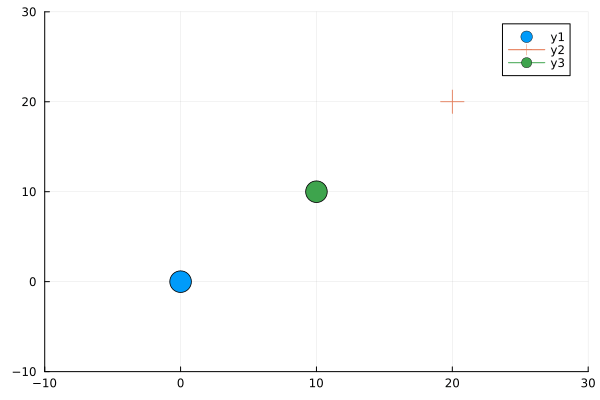

In [144]:
anim = @animate for t in 1:k_steps
    scatter([xₜ[t, 1]], [xₜ[t, 2]], m = (:circle, 12),
    xlims = (-10, 30), 
    ylims = (-10, 30), )
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
    plot!([obstacle[1]], [obstacle[2]], m = (:circle, 12))
end every 10;
gif(anim, "obstacle.gif")

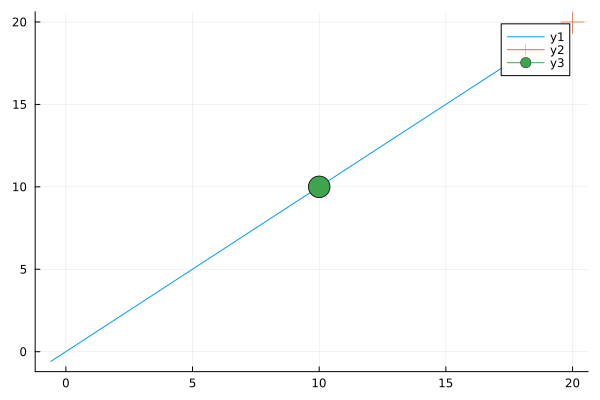

In [145]:
plot([xₜ[:, 1]], [xₜ[:, 2]])
plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12))
plot!([obstacle[1]], [obstacle[2]], m = (:circle, 12))

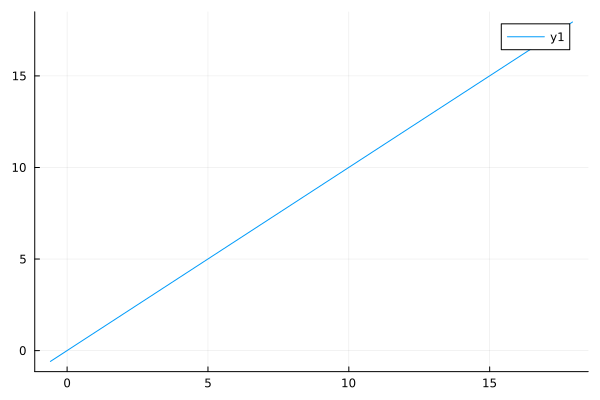

In [146]:
plot([xₜ[:, 1]], [xₜ[:, 2]])

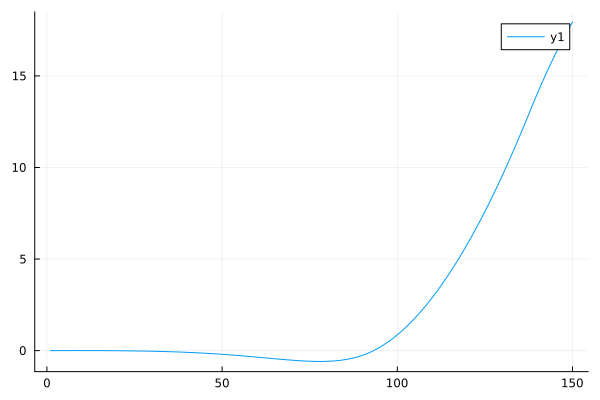

In [147]:
plot([xₜ[:, 2]])

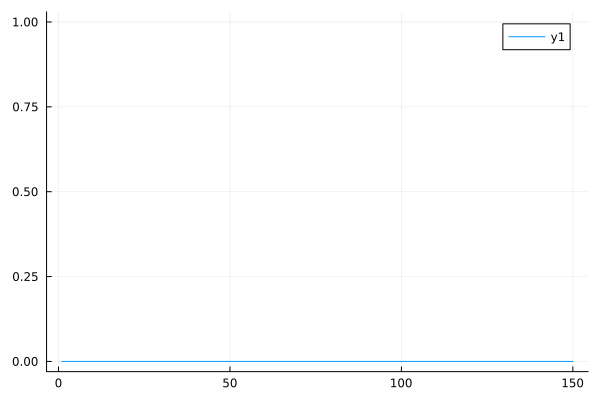

In [148]:
plot(costs)

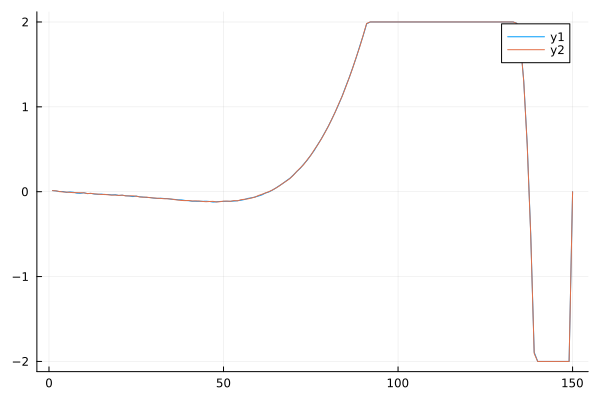

In [149]:
plot(uₜ)

In [150]:
xₜ[105,:]

4-element Vector{Float64}:
 1.7668525631525882
 1.7706006943224257
 2.0443490794328185
 2.0449771945160777